# Домашнее задание: Multi-Branch MLP для Wine Quality

**Цель**: Реализовать multi-branch модель и добиться F1 score ≥ 40%

**Задачи**:
1. Реализовать три типа блоков: Bottleneck, Inverted Bottleneck, Regular
2. Создать Multi-Branch архитектуру
3. Использовать weighted loss для борьбы с дисбалансом классов
4. Подобрать оптимальные гиперпараметры (глубина, ширина, lr, оптимизатор)

In [ ]:
!pip install pytorch_lightning

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import sys
sys.path.append('/content/lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style('whitegrid')
set_seed(42)

## 1. Загрузка и анализ данных

Загрузим Wine Quality датасет и проанализируем распределение классов.

In [ ]:
# Загружаем данные
dm = WineQualityDataModule(batch_size=128)
dm.setup()

print(f'Train samples: {len(dm.train_dataset)}')
print(f'Val samples: {len(dm.val_dataset)}')
print(f'Input dim: {dm.input_dim}')
print(f'Num classes: {dm.n_classes}')

Train samples: 1279
Val samples: 320
Input dim: 11
Num classes: 6


### 1.1. Анализ дисбаланса классов

Проанализируйте распределение классов и вычислите веса для weighted loss.

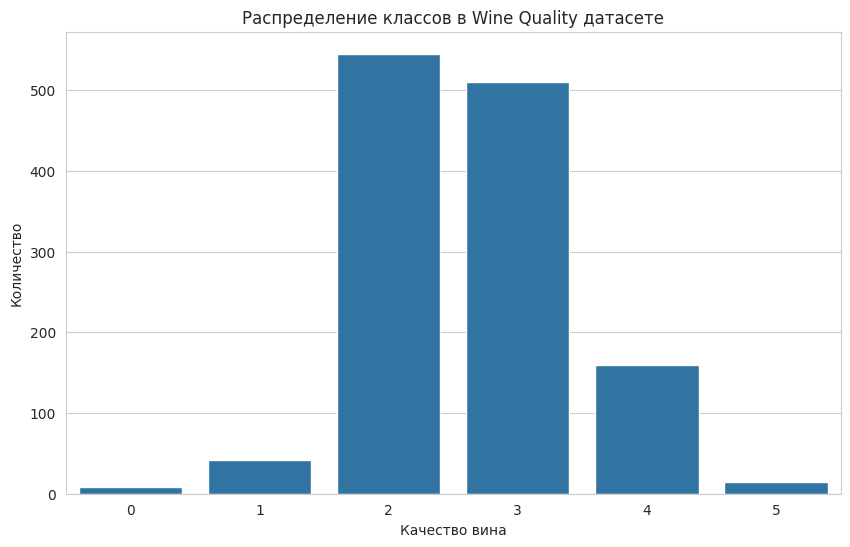

Class weights: [5.        2.2528641 0.6254051 0.646509  1.1578734 3.7697628]


In [ ]:
# Получаем метки классов из train_dataset
train_labels = np.array([dm.train_dataset[i][1].item() if hasattr(dm.train_dataset[i][1], 'item') else dm.train_dataset[i][1]
                         for i in range(len(dm.train_dataset))])

# Строим гистограмму распределения классов
plt.figure(figsize=(10, 6))
sns.countplot(x=train_labels)
plt.title('Распределение классов в Wine Quality датасете')
plt.xlabel('Качество вина')
plt.ylabel('Количество')
plt.show()

# Вычисляем веса классов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = class_weights.astype(np.float32)
class_weights = np.sqrt(class_weights)
class_weights = np.clip(class_weights, 0.5, 5.0)
print(f'Class weights: {class_weights}')

## 2. Реализация блоков

Реализуйте три типа блоков:
- **Bottleneck**: dim → dim//4 → dim (сужение)
- **Inverted Bottleneck**: dim → dim*4 → dim (расширение)
- **Regular**: dim → hidden_dim → dim (обычный)

In [ ]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    """Базовый класс для MLP блока"""
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__()
        self.dim = dim
        self.activation = {'relu': nn.ReLU(), 'gelu': nn.GELU(), 'swish': nn.SiLU()}.get(activation, nn.GELU())
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None

    @abstractmethod
    def forward(self, x):
        pass

class BottleneckBlock(BaseMLPBlock):
    """
    Bottleneck блок: dim → dim//4 → dim

    Сужает размерность в 4 раза, затем восстанавливает.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)

        # Bottleneck dimension (сужение в 4 раза)
        self.bottleneck_dim = max(dim // 4, 1)

        # Линейные слои: dim → bottleneck_dim → dim
        self.fc1 = nn.Linear(self.dim, self.bottleneck_dim)
        self.fc2 = nn.Linear(self.bottleneck_dim, self.dim)

    def forward(self, x):
        identity = x

        # Bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)

        # Residual connection
        return out + identity

class InvertedBottleneckBlock(BaseMLPBlock):
    """
    Inverted Bottleneck блок: dim → dim*4 → dim

    Расширяет размерность в 4 раза, затем сжимает обратно.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, expansion_factor=4, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)

        # Expanded dimension (расширение в 4 раза)
        self.expanded_dim = dim * expansion_factor

        # Линейные слои: dim → expanded_dim → dim
        self.fc1 = nn.Linear(self.dim, self.expanded_dim)
        self.fc2 = nn.Linear(self.expanded_dim, self.dim)

    def forward(self, x):
        identity = x

        # Inverted bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)

        # Residual connection
        return out + identity

class RegularBlock(BaseMLPBlock):
    """
    Regular блок: dim → hidden_dim → dim

    Обычный двухслойный MLP с residual connection.
    hidden_dim по умолчанию равен dim * 2.
    """
    def __init__(self, dim, hidden_dim=None, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)

        # Hidden dimension (по умолчанию в 2 раза больше)
        self.hidden_dim = hidden_dim if hidden_dim else dim * 2

        # Линейные слои: dim → hidden_dim → dim
        self.fc1 = nn.Linear(self.dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.dim)

    def forward(self, x):
        identity = x

        # Regular pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)

        # Residual connection
        return out + identity

# Тестируем блоки
print('✓ Блоки успешно определены!')
print()

# Проверим размерности
test_x = torch.randn(4, 64)
print('Тестирование блоков с размерностью 64:')
print(f'  Input shape: {test_x.shape}')

bottleneck = BottleneckBlock(64)
print(f'  BottleneckBlock output: {bottleneck(test_x).shape}')

inverted = InvertedBottleneckBlock(64)
print(f'  InvertedBottleneckBlock output: {inverted(test_x).shape}')

regular = RegularBlock(64)
print(f'  RegularBlock output: {regular(test_x).shape}')

# Подсчитаем параметры
print()
print('Количество параметров:')
print(f'  BottleneckBlock: {sum(p.numel() for p in bottleneck.parameters()):,}')
print(f'  InvertedBottleneckBlock: {sum(p.numel() for p in inverted.parameters()):,}')
print(f'  RegularBlock: {sum(p.numel() for p in regular.parameters()):,}')

✓ Блоки успешно определены!

Тестирование блоков с размерностью 64:
  Input shape: torch.Size([4, 64])
  BottleneckBlock output: torch.Size([4, 64])
  InvertedBottleneckBlock output: torch.Size([4, 64])
  RegularBlock output: torch.Size([4, 64])

Количество параметров:
  BottleneckBlock: 2,128
  InvertedBottleneckBlock: 33,088
  RegularBlock: 16,576


## 3. Multi-Branch модель

Реализуйте модель с тремя параллельными ветками.

**Архитектура**:
```
         Input
           |
      projection
           |
      ┌────┼────┐
      │    │    │
  Bottleneck  Inverted  Regular
   Branch      Branch    Branch
      │    │    │
      └────┼────┘
           |
      Concatenate/Sum
           |
      projection
           |
        Output
```

In [ ]:
class MultiBranchMLP(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        num_blocks=4,
        dropout=0.1,
        combine_mode='concat'
    ):
        super().__init__()
        self.output_dim = output_dim
        self.combine_mode = combine_mode

        # Входная проекция
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # Создаем три ветки
        self.bottleneck_branch = nn.ModuleList(
            [BottleneckBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)]
        )
        self.inverted_branch = nn.ModuleList(
            [InvertedBottleneckBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)]
        )
        self.regular_branch = nn.ModuleList(
            [RegularBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)]
        )

        # Выходная проекция
        proj_dim = hidden_dim * 3 if combine_mode == 'concat' else hidden_dim
        self.output_proj = nn.Linear(proj_dim, output_dim)

    def forward(self, x):
        # 1. Входная проекция
        x = self.input_proj(x)

        # 2. Пропускаем через каждую ветку
        x_b = x
        for block in self.bottleneck_branch:
            x_b = block(x_b)

        x_i = x
        for block in self.inverted_branch:
            x_i = block(x_i)

        x_r = x
        for block in self.regular_branch:
            x_r = block(x_r)

        # 3. Объединяем результаты
        if self.combine_mode == 'concat':
            combined = torch.cat([x_b, x_i, x_r], dim=1)
        else: # 'sum'
            combined = x_b + x_i + x_r

        # 4. Выходная проекция
        return self.output_proj(combined)

print('✓ Multi-Branch модель определена!')

✓ Multi-Branch модель определена!


## 4. Код обучение

In [ ]:
def train_model(
    model,
    dm,
    class_weights=None,
    max_epochs=50,
    lr=1e-3,
    optimizer_type='adam',
    optimizer_kwargs=None,
    early_stopping=True,
    patience=10
):
    """
    Обучает модель с weighted loss.
    """
    # Создаем loss function
    if class_weights is not None:
        loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    else:
        loss_fn = nn.CrossEntropyLoss()

    lightning_model = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type=optimizer_type,
        learning_rate=lr,
        task_type='multiclass'
    )

    # Early stopping по F1_macro на валидации (часто помогает не переобучаться и найти лучшую эпоху)
    callbacks = []
    if early_stopping:
        from pytorch_lightning.callbacks import EarlyStopping
        callbacks.append(EarlyStopping(monitor='val_f1_macro', mode='max', patience=patience))

    trainer = Trainer(
        max_epochs=max_epochs,
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
        enable_model_summary=False,
        accelerator='auto',
        devices=1
    )
    trainer.fit(lightning_model, dm)

    metrics = trainer.callback_metrics
    return {
        'val_acc': metrics.get('val_accuracy', 0).item(),
        'val_f1': metrics.get('val_f1_macro', 0).item()
    }

## 5. Итоговая модель

Обучите модель с лучшими гиперпараметрами.

In [ ]:
# Подбираем гиперпараметры
best_hidden_dim = 128
best_depth = 6
best_lr = 1e-3
best_optimizer = 'adamw'

# Обучаем итоговую модель
final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1000,
    lr=best_lr,
    optimizer_type=best_optimizer
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score: {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

Epoch 0: accuracy=0.2148, f1_macro=0.1488

Epoch 0: accuracy=0.2986, f1_macro=0.2062

Epoch 1: accuracy=0.3248, f1_macro=0.2258

Epoch 2: accuracy=0.3322, f1_macro=0.2248

Epoch 3: accuracy=0.3496, f1_macro=0.2307

Epoch 4: accuracy=0.3669, f1_macro=0.2409

Epoch 5: accuracy=0.3736, f1_macro=0.2440

Epoch 6: accuracy=0.3870, f1_macro=0.2504

Epoch 7: accuracy=0.3874, f1_macro=0.2499

Epoch 8: accuracy=0.3999, f1_macro=0.2549

Epoch 9: accuracy=0.3996, f1_macro=0.2547

Epoch 10: accuracy=0.4057, f1_macro=0.2578

Epoch 11: accuracy=0.4094, f1_macro=0.2596

Epoch 12: accuracy=0.4087, f1_macro=0.2613

Epoch 13: accuracy=0.4109, f1_macro=0.2633

Epoch 14: accuracy=0.4104, f1_macro=0.2619

Epoch 15: accuracy=0.4111, f1_macro=0.2628

Epoch 16: accuracy=0.4119, f1_macro=0.2634

Epoch 17: accuracy=0.4169, f1_macro=0.2656

Epoch 18: accuracy=0.4197, f1_macro=0.2670

Epoch 19: accuracy=0.4235, f1_macro=0.2695

Epoch 20: accuracy=0.4212, f1_macro=0.2692

Epoch 21: accuracy=0.4237, f1_macro=0.2703

Epoch 22: accuracy=0.4249, f1_macro=0.2719

Epoch 23: accuracy=0.4255, f1_macro=0.2728

Epoch 24: accuracy=0.4300, f1_macro=0.2746

Epoch 25: accuracy=0.4293, f1_macro=0.2745

Epoch 26: accuracy=0.4314, f1_macro=0.2759

Epoch 27: accuracy=0.4333, f1_macro=0.2767

Epoch 28: accuracy=0.4331, f1_macro=0.2769

Epoch 29: accuracy=0.4365, f1_macro=0.2788

Epoch 30: accuracy=0.4378, f1_macro=0.2794

Epoch 31: accuracy=0.4389, f1_macro=0.2800

Epoch 32: accuracy=0.4398, f1_macro=0.2805

Epoch 33: accuracy=0.4420, f1_macro=0.2816

Epoch 34: accuracy=0.4443, f1_macro=0.2831

Epoch 35: accuracy=0.4450, f1_macro=0.2836

Epoch 36: accuracy=0.4467, f1_macro=0.2844

Epoch 37: accuracy=0.4481, f1_macro=0.2852

Epoch 38: accuracy=0.4509, f1_macro=0.2867

Epoch 39: accuracy=0.4528, f1_macro=0.2875

Epoch 40: accuracy=0.4547, f1_macro=0.2888

Epoch 41: accuracy=0.4562, f1_macro=0.2894

Epoch 42: accuracy=0.4587, f1_macro=0.2909

Epoch 43: accuracy=0.4607, f1_macro=0.2921

Epoch 44: accuracy=0.4621, f1_macro=0.2927

Epoch 45: accuracy=0.4640, f1_macro=0.2937

Epoch 46: accuracy=0.4650, f1_macro=0.2944

Epoch 47: accuracy=0.4653, f1_macro=0.2947

Epoch 48: accuracy=0.4676, f1_macro=0.2958

Epoch 49: accuracy=0.4686, f1_macro=0.2964

Epoch 50: accuracy=0.4689, f1_macro=0.2964

Epoch 51: accuracy=0.4696, f1_macro=0.2965

Epoch 52: accuracy=0.4689, f1_macro=0.2960

Epoch 53: accuracy=0.4697, f1_macro=0.2963

Epoch 54: accuracy=0.4712, f1_macro=0.2974

Epoch 55: accuracy=0.4727, f1_macro=0.2978

Epoch 56: accuracy=0.4738, f1_macro=0.2984

Epoch 57: accuracy=0.4745, f1_macro=0.2987

Epoch 58: accuracy=0.4765, f1_macro=0.2997

Epoch 59: accuracy=0.4774, f1_macro=0.3001

Epoch 60: accuracy=0.4785, f1_macro=0.3009

Epoch 61: accuracy=0.4793, f1_macro=0.3016

Epoch 62: accuracy=0.4800, f1_macro=0.3020

Epoch 63: accuracy=0.4814, f1_macro=0.3026

Epoch 64: accuracy=0.4828, f1_macro=0.3031

Epoch 65: accuracy=0.4836, f1_macro=0.3036

Epoch 66: accuracy=0.4849, f1_macro=0.3041

Epoch 67: accuracy=0.4859, f1_macro=0.3045

Epoch 68: accuracy=0.4875, f1_macro=0.3052

Epoch 69: accuracy=0.4886, f1_macro=0.3057

Epoch 70: accuracy=0.4904, f1_macro=0.3065

Epoch 71: accuracy=0.4917, f1_macro=0.3072

Epoch 72: accuracy=0.4929, f1_macro=0.3077

Epoch 73: accuracy=0.4939, f1_macro=0.3082

Epoch 74: accuracy=0.4954, f1_macro=0.3088

Epoch 75: accuracy=0.4967, f1_macro=0.3094

Epoch 76: accuracy=0.4981, f1_macro=0.3101

Epoch 77: accuracy=0.4998, f1_macro=0.3110

Epoch 78: accuracy=0.5013, f1_macro=0.3118

Epoch 79: accuracy=0.5023, f1_macro=0.3122

Epoch 80: accuracy=0.5037, f1_macro=0.3128

Epoch 81: accuracy=0.5048, f1_macro=0.3133

Epoch 82: accuracy=0.5059, f1_macro=0.3137

Epoch 83: accuracy=0.5069, f1_macro=0.3143

Epoch 84: accuracy=0.5080, f1_macro=0.3148

Epoch 85: accuracy=0.5092, f1_macro=0.3154

Epoch 86: accuracy=0.5103, f1_macro=0.3159

Epoch 87: accuracy=0.5115, f1_macro=0.3164

Epoch 88: accuracy=0.5122, f1_macro=0.3166

Epoch 89: accuracy=0.5129, f1_macro=0.3168

Epoch 90: accuracy=0.5136, f1_macro=0.3171

Epoch 91: accuracy=0.5140, f1_macro=0.3171

Epoch 92: accuracy=0.5134, f1_macro=0.3168

Epoch 93: accuracy=0.5131, f1_macro=0.3168

Epoch 94: accuracy=0.5131, f1_macro=0.3164

Epoch 95: accuracy=0.5137, f1_macro=0.3167

Epoch 96: accuracy=0.5141, f1_macro=0.3170

Epoch 97: accuracy=0.5148, f1_macro=0.3175

Epoch 98: accuracy=0.5147, f1_macro=0.3176

Epoch 99: accuracy=0.5157, f1_macro=0.3180

Epoch 100: accuracy=0.5156, f1_macro=0.3179

Epoch 101: accuracy=0.5163, f1_macro=0.3183

Epoch 102: accuracy=0.5169, f1_macro=0.3185

Epoch 103: accuracy=0.5175, f1_macro=0.3187

Epoch 104: accuracy=0.5183, f1_macro=0.3190

Epoch 105: accuracy=0.5190, f1_macro=0.3193

Epoch 106: accuracy=0.5196, f1_macro=0.3195

Epoch 107: accuracy=0.5200, f1_macro=0.3196

Epoch 108: accuracy=0.5206, f1_macro=0.3198

Epoch 109: accuracy=0.5214, f1_macro=0.3201

Epoch 110: accuracy=0.5220, f1_macro=0.3203

Epoch 111: accuracy=0.5226, f1_macro=0.3205

Epoch 112: accuracy=0.5232, f1_macro=0.3208

Epoch 113: accuracy=0.5241, f1_macro=0.3213

Epoch 114: accuracy=0.5240, f1_macro=0.3211

Epoch 115: accuracy=0.5243, f1_macro=0.3212

Epoch 116: accuracy=0.5248, f1_macro=0.3213

Epoch 117: accuracy=0.5252, f1_macro=0.3215

Epoch 118: accuracy=0.5258, f1_macro=0.3217

Epoch 119: accuracy=0.5264, f1_macro=0.3218

Epoch 120: accuracy=0.5270, f1_macro=0.3220

Epoch 121: accuracy=0.5276, f1_macro=0.3223

Epoch 122: accuracy=0.5281, f1_macro=0.3225

Epoch 123: accuracy=0.5287, f1_macro=0.3227

Epoch 124: accuracy=0.5295, f1_macro=0.3230

Epoch 125: accuracy=0.5301, f1_macro=0.3233

Epoch 126: accuracy=0.5308, f1_macro=0.3235

Epoch 127: accuracy=0.5313, f1_macro=0.3237

Epoch 128: accuracy=0.5320, f1_macro=0.3239

Epoch 129: accuracy=0.5328, f1_macro=0.3243

Epoch 130: accuracy=0.5334, f1_macro=0.3245

Epoch 131: accuracy=0.5341, f1_macro=0.3248

Epoch 132: accuracy=0.5348, f1_macro=0.3250

Epoch 133: accuracy=0.5353, f1_macro=0.3252

Epoch 134: accuracy=0.5360, f1_macro=0.3255

Epoch 135: accuracy=0.5365, f1_macro=0.3257

Epoch 136: accuracy=0.5371, f1_macro=0.3259

Epoch 137: accuracy=0.5376, f1_macro=0.3262

Epoch 138: accuracy=0.5381, f1_macro=0.3264

Epoch 139: accuracy=0.5388, f1_macro=0.3266

Epoch 140: accuracy=0.5393, f1_macro=0.3268

Epoch 141: accuracy=0.5399, f1_macro=0.3270

Epoch 142: accuracy=0.5404, f1_macro=0.3272

Epoch 143: accuracy=0.5408, f1_macro=0.3273

Epoch 144: accuracy=0.5412, f1_macro=0.3274

Epoch 145: accuracy=0.5417, f1_macro=0.3276

Epoch 146: accuracy=0.5420, f1_macro=0.3277

Epoch 147: accuracy=0.5425, f1_macro=0.3278

Epoch 148: accuracy=0.5430, f1_macro=0.3281

Epoch 149: accuracy=0.5434, f1_macro=0.3282

Epoch 150: accuracy=0.5438, f1_macro=0.3284

Epoch 151: accuracy=0.5443, f1_macro=0.3286

Epoch 152: accuracy=0.5447, f1_macro=0.3287

Epoch 153: accuracy=0.5452, f1_macro=0.3289

Epoch 154: accuracy=0.5457, f1_macro=0.3291

Epoch 155: accuracy=0.5463, f1_macro=0.3294

Epoch 156: accuracy=0.5467, f1_macro=0.3296

Epoch 157: accuracy=0.5471, f1_macro=0.3298

Epoch 158: accuracy=0.5475, f1_macro=0.3300

Epoch 159: accuracy=0.5477, f1_macro=0.3302

Epoch 160: accuracy=0.5482, f1_macro=0.3304

Epoch 161: accuracy=0.5485, f1_macro=0.3305

Epoch 162: accuracy=0.5488, f1_macro=0.3306

Epoch 163: accuracy=0.5491, f1_macro=0.3307

Epoch 164: accuracy=0.5495, f1_macro=0.3308

Epoch 165: accuracy=0.5498, f1_macro=0.3309

Epoch 166: accuracy=0.5502, f1_macro=0.3310

Epoch 167: accuracy=0.5504, f1_macro=0.3311

Epoch 168: accuracy=0.5507, f1_macro=0.3312

Epoch 169: accuracy=0.5510, f1_macro=0.3313

Epoch 170: accuracy=0.5514, f1_macro=0.3315

Epoch 171: accuracy=0.5516, f1_macro=0.3315

Epoch 172: accuracy=0.5520, f1_macro=0.3317

Epoch 173: accuracy=0.5523, f1_macro=0.3318

Epoch 174: accuracy=0.5527, f1_macro=0.3318

Epoch 175: accuracy=0.5530, f1_macro=0.3320

Epoch 176: accuracy=0.5533, f1_macro=0.3322

Epoch 177: accuracy=0.5538, f1_macro=0.3324

Epoch 178: accuracy=0.5544, f1_macro=0.3327

Epoch 179: accuracy=0.5547, f1_macro=0.3329

Epoch 180: accuracy=0.5549, f1_macro=0.3329

Epoch 181: accuracy=0.5553, f1_macro=0.3331

Epoch 182: accuracy=0.5555, f1_macro=0.3332

Epoch 183: accuracy=0.5560, f1_macro=0.3335

Epoch 184: accuracy=0.5562, f1_macro=0.3338

Epoch 185: accuracy=0.5560, f1_macro=0.3337

Epoch 186: accuracy=0.5557, f1_macro=0.3334

Epoch 187: accuracy=0.5556, f1_macro=0.3334

Epoch 188: accuracy=0.5551, f1_macro=0.3331

Epoch 189: accuracy=0.5540, f1_macro=0.3329

Epoch 190: accuracy=0.5537, f1_macro=0.3329

Epoch 191: accuracy=0.5538, f1_macro=0.3330

Epoch 192: accuracy=0.5538, f1_macro=0.3330

Epoch 193: accuracy=0.5539, f1_macro=0.3332

Epoch 194: accuracy=0.5541, f1_macro=0.3334

Epoch 195: accuracy=0.5544, f1_macro=0.3337

Epoch 196: accuracy=0.5547, f1_macro=0.3341

Epoch 197: accuracy=0.5550, f1_macro=0.3343

Epoch 198: accuracy=0.5552, f1_macro=0.3346

Epoch 199: accuracy=0.5557, f1_macro=0.3349

Epoch 200: accuracy=0.5561, f1_macro=0.3352

Epoch 201: accuracy=0.5565, f1_macro=0.3355

Epoch 202: accuracy=0.5568, f1_macro=0.3358

Epoch 203: accuracy=0.5571, f1_macro=0.3360

Epoch 204: accuracy=0.5575, f1_macro=0.3363

Epoch 205: accuracy=0.5579, f1_macro=0.3367

Epoch 206: accuracy=0.5583, f1_macro=0.3370

Epoch 207: accuracy=0.5587, f1_macro=0.3372

Epoch 208: accuracy=0.5591, f1_macro=0.3375

Epoch 209: accuracy=0.5595, f1_macro=0.3378

Epoch 210: accuracy=0.5599, f1_macro=0.3381

Epoch 211: accuracy=0.5603, f1_macro=0.3384

Epoch 212: accuracy=0.5606, f1_macro=0.3387

Epoch 213: accuracy=0.5610, f1_macro=0.3389

Epoch 214: accuracy=0.5614, f1_macro=0.3390

Epoch 215: accuracy=0.5617, f1_macro=0.3393

Epoch 216: accuracy=0.5620, f1_macro=0.3395

Epoch 217: accuracy=0.5622, f1_macro=0.3396

Epoch 218: accuracy=0.5626, f1_macro=0.3398

Epoch 219: accuracy=0.5629, f1_macro=0.3399

Epoch 220: accuracy=0.5633, f1_macro=0.3401

Epoch 221: accuracy=0.5636, f1_macro=0.3404

Epoch 222: accuracy=0.5640, f1_macro=0.3406

Epoch 223: accuracy=0.5643, f1_macro=0.3409

Epoch 224: accuracy=0.5645, f1_macro=0.3411

Epoch 225: accuracy=0.5648, f1_macro=0.3413

Epoch 226: accuracy=0.5651, f1_macro=0.3415

Epoch 227: accuracy=0.5654, f1_macro=0.3416

Epoch 228: accuracy=0.5658, f1_macro=0.3418

Epoch 229: accuracy=0.5661, f1_macro=0.3420

Epoch 230: accuracy=0.5664, f1_macro=0.3422

Epoch 231: accuracy=0.5668, f1_macro=0.3424

Epoch 232: accuracy=0.5671, f1_macro=0.3426

Epoch 233: accuracy=0.5675, f1_macro=0.3428

Epoch 234: accuracy=0.5679, f1_macro=0.3430

Epoch 235: accuracy=0.5682, f1_macro=0.3432

Epoch 236: accuracy=0.5685, f1_macro=0.3435

Epoch 237: accuracy=0.5688, f1_macro=0.3437

Epoch 238: accuracy=0.5691, f1_macro=0.3438

Epoch 239: accuracy=0.5693, f1_macro=0.3440

Epoch 240: accuracy=0.5696, f1_macro=0.3443

Epoch 241: accuracy=0.5700, f1_macro=0.3445

Epoch 242: accuracy=0.5703, f1_macro=0.3447

Epoch 243: accuracy=0.5707, f1_macro=0.3448

Epoch 244: accuracy=0.5709, f1_macro=0.3450

Epoch 245: accuracy=0.5711, f1_macro=0.3451

Epoch 246: accuracy=0.5713, f1_macro=0.3453

Epoch 247: accuracy=0.5716, f1_macro=0.3454

Epoch 248: accuracy=0.5718, f1_macro=0.3456

Epoch 249: accuracy=0.5721, f1_macro=0.3458

Epoch 250: accuracy=0.5723, f1_macro=0.3460

Epoch 251: accuracy=0.5727, f1_macro=0.3461

Epoch 252: accuracy=0.5729, f1_macro=0.3463

Epoch 253: accuracy=0.5732, f1_macro=0.3465

Epoch 254: accuracy=0.5734, f1_macro=0.3467

Epoch 255: accuracy=0.5736, f1_macro=0.3468

Epoch 256: accuracy=0.5738, f1_macro=0.3469

Epoch 257: accuracy=0.5741, f1_macro=0.3471

Epoch 258: accuracy=0.5743, f1_macro=0.3473

Epoch 259: accuracy=0.5745, f1_macro=0.3475

Epoch 260: accuracy=0.5748, f1_macro=0.3477

Epoch 261: accuracy=0.5750, f1_macro=0.3478

Epoch 262: accuracy=0.5752, f1_macro=0.3480

Epoch 263: accuracy=0.5754, f1_macro=0.3482

Epoch 264: accuracy=0.5757, f1_macro=0.3485

Epoch 265: accuracy=0.5761, f1_macro=0.3487

Epoch 266: accuracy=0.5764, f1_macro=0.3490

Epoch 267: accuracy=0.5767, f1_macro=0.3492

Epoch 268: accuracy=0.5771, f1_macro=0.3495

Epoch 269: accuracy=0.5773, f1_macro=0.3497

Epoch 270: accuracy=0.5776, f1_macro=0.3499

Epoch 271: accuracy=0.5778, f1_macro=0.3501

Epoch 272: accuracy=0.5781, f1_macro=0.3504

Epoch 273: accuracy=0.5784, f1_macro=0.3506

Epoch 274: accuracy=0.5786, f1_macro=0.3508

Epoch 275: accuracy=0.5789, f1_macro=0.3510

Epoch 276: accuracy=0.5791, f1_macro=0.3511

Epoch 277: accuracy=0.5794, f1_macro=0.3513

Epoch 278: accuracy=0.5796, f1_macro=0.3514

Epoch 279: accuracy=0.5797, f1_macro=0.3514

Epoch 280: accuracy=0.5799, f1_macro=0.3516

Epoch 281: accuracy=0.5800, f1_macro=0.3517

Epoch 282: accuracy=0.5802, f1_macro=0.3518

Epoch 283: accuracy=0.5805, f1_macro=0.3520

Epoch 284: accuracy=0.5808, f1_macro=0.3522

Epoch 285: accuracy=0.5810, f1_macro=0.3525

Epoch 286: accuracy=0.5812, f1_macro=0.3526

Epoch 287: accuracy=0.5815, f1_macro=0.3527

Epoch 288: accuracy=0.5817, f1_macro=0.3528

Epoch 289: accuracy=0.5819, f1_macro=0.3529

Epoch 290: accuracy=0.5821, f1_macro=0.3530

Epoch 291: accuracy=0.5822, f1_macro=0.3531

Epoch 292: accuracy=0.5825, f1_macro=0.3532

Epoch 293: accuracy=0.5827, f1_macro=0.3533

Epoch 294: accuracy=0.5829, f1_macro=0.3535

Epoch 295: accuracy=0.5831, f1_macro=0.3536

Epoch 296: accuracy=0.5833, f1_macro=0.3537

Epoch 297: accuracy=0.5835, f1_macro=0.3538

Epoch 298: accuracy=0.5838, f1_macro=0.3540

Epoch 299: accuracy=0.5840, f1_macro=0.3541

Epoch 300: accuracy=0.5842, f1_macro=0.3543

Epoch 301: accuracy=0.5845, f1_macro=0.3544

Epoch 302: accuracy=0.5847, f1_macro=0.3546

Epoch 303: accuracy=0.5848, f1_macro=0.3546

Epoch 304: accuracy=0.5850, f1_macro=0.3548

Epoch 305: accuracy=0.5852, f1_macro=0.3548

Epoch 306: accuracy=0.5854, f1_macro=0.3549

Epoch 307: accuracy=0.5855, f1_macro=0.3550

Epoch 308: accuracy=0.5856, f1_macro=0.3551

Epoch 309: accuracy=0.5857, f1_macro=0.3551

Epoch 310: accuracy=0.5859, f1_macro=0.3553

Epoch 311: accuracy=0.5861, f1_macro=0.3554

Epoch 312: accuracy=0.5863, f1_macro=0.3555

Epoch 313: accuracy=0.5866, f1_macro=0.3557

Epoch 314: accuracy=0.5868, f1_macro=0.3559

Epoch 315: accuracy=0.5871, f1_macro=0.3560

Epoch 316: accuracy=0.5872, f1_macro=0.3562

Epoch 317: accuracy=0.5873, f1_macro=0.3563

Epoch 318: accuracy=0.5874, f1_macro=0.3564

Epoch 319: accuracy=0.5875, f1_macro=0.3564

Epoch 320: accuracy=0.5875, f1_macro=0.3565

Epoch 321: accuracy=0.5875, f1_macro=0.3566

Epoch 322: accuracy=0.5875, f1_macro=0.3568

Epoch 323: accuracy=0.5874, f1_macro=0.3568

Epoch 324: accuracy=0.5874, f1_macro=0.3568

Epoch 325: accuracy=0.5876, f1_macro=0.3570

Epoch 326: accuracy=0.5876, f1_macro=0.3571

Epoch 327: accuracy=0.5877, f1_macro=0.3572

Epoch 328: accuracy=0.5878, f1_macro=0.3574

Epoch 329: accuracy=0.5879, f1_macro=0.3575

Epoch 330: accuracy=0.5881, f1_macro=0.3577

Epoch 331: accuracy=0.5883, f1_macro=0.3579

Epoch 332: accuracy=0.5886, f1_macro=0.3580

Epoch 333: accuracy=0.5888, f1_macro=0.3582

Epoch 334: accuracy=0.5890, f1_macro=0.3583

Epoch 335: accuracy=0.5892, f1_macro=0.3584

Epoch 336: accuracy=0.5893, f1_macro=0.3586

Epoch 337: accuracy=0.5896, f1_macro=0.3588

Epoch 338: accuracy=0.5898, f1_macro=0.3590

Epoch 339: accuracy=0.5900, f1_macro=0.3591

Epoch 340: accuracy=0.5901, f1_macro=0.3592

Epoch 341: accuracy=0.5903, f1_macro=0.3594

Epoch 342: accuracy=0.5905, f1_macro=0.3595

Epoch 343: accuracy=0.5907, f1_macro=0.3597

Epoch 344: accuracy=0.5908, f1_macro=0.3598

Epoch 345: accuracy=0.5909, f1_macro=0.3600

Epoch 346: accuracy=0.5911, f1_macro=0.3601

Epoch 347: accuracy=0.5912, f1_macro=0.3602

Epoch 348: accuracy=0.5913, f1_macro=0.3604

Epoch 349: accuracy=0.5915, f1_macro=0.3606

Epoch 350: accuracy=0.5917, f1_macro=0.3608

Epoch 351: accuracy=0.5919, f1_macro=0.3609

Epoch 352: accuracy=0.5921, f1_macro=0.3611

Epoch 353: accuracy=0.5922, f1_macro=0.3613

Epoch 354: accuracy=0.5923, f1_macro=0.3614

Epoch 355: accuracy=0.5925, f1_macro=0.3616

Epoch 356: accuracy=0.5926, f1_macro=0.3618

Epoch 357: accuracy=0.5928, f1_macro=0.3620

Epoch 358: accuracy=0.5930, f1_macro=0.3622

Epoch 359: accuracy=0.5931, f1_macro=0.3623

Epoch 360: accuracy=0.5932, f1_macro=0.3624

Epoch 361: accuracy=0.5934, f1_macro=0.3626

Epoch 362: accuracy=0.5936, f1_macro=0.3627

Epoch 363: accuracy=0.5938, f1_macro=0.3629

Epoch 364: accuracy=0.5939, f1_macro=0.3631

Epoch 365: accuracy=0.5941, f1_macro=0.3632

Epoch 366: accuracy=0.5942, f1_macro=0.3634

Epoch 367: accuracy=0.5944, f1_macro=0.3636

Epoch 368: accuracy=0.5945, f1_macro=0.3637

Epoch 369: accuracy=0.5946, f1_macro=0.3639

Epoch 370: accuracy=0.5948, f1_macro=0.3640

Epoch 371: accuracy=0.5949, f1_macro=0.3642

Epoch 372: accuracy=0.5951, f1_macro=0.3643

Epoch 373: accuracy=0.5952, f1_macro=0.3645

Epoch 374: accuracy=0.5953, f1_macro=0.3646

Epoch 375: accuracy=0.5955, f1_macro=0.3647

Epoch 376: accuracy=0.5956, f1_macro=0.3648

Epoch 377: accuracy=0.5957, f1_macro=0.3649

Epoch 378: accuracy=0.5957, f1_macro=0.3650

Epoch 379: accuracy=0.5956, f1_macro=0.3649

Epoch 380: accuracy=0.5954, f1_macro=0.3647

Epoch 381: accuracy=0.5954, f1_macro=0.3647

Epoch 382: accuracy=0.5954, f1_macro=0.3648

Epoch 383: accuracy=0.5953, f1_macro=0.3646

Epoch 384: accuracy=0.5953, f1_macro=0.3646

Epoch 385: accuracy=0.5954, f1_macro=0.3647

Epoch 386: accuracy=0.5955, f1_macro=0.3648

Epoch 387: accuracy=0.5955, f1_macro=0.3648

Epoch 388: accuracy=0.5956, f1_macro=0.3649

Epoch 389: accuracy=0.5958, f1_macro=0.3651

Epoch 390: accuracy=0.5960, f1_macro=0.3653

Epoch 391: accuracy=0.5961, f1_macro=0.3654

Epoch 392: accuracy=0.5962, f1_macro=0.3655

Epoch 393: accuracy=0.5964, f1_macro=0.3657

Epoch 394: accuracy=0.5966, f1_macro=0.3658

Epoch 395: accuracy=0.5967, f1_macro=0.3659

Epoch 396: accuracy=0.5969, f1_macro=0.3660

Epoch 397: accuracy=0.5970, f1_macro=0.3662

Epoch 398: accuracy=0.5972, f1_macro=0.3663

Epoch 399: accuracy=0.5973, f1_macro=0.3664

Epoch 400: accuracy=0.5975, f1_macro=0.3665

Epoch 401: accuracy=0.5976, f1_macro=0.3666

Epoch 402: accuracy=0.5978, f1_macro=0.3667

Epoch 403: accuracy=0.5979, f1_macro=0.3668

Epoch 404: accuracy=0.5981, f1_macro=0.3669

Epoch 405: accuracy=0.5982, f1_macro=0.3670

Epoch 406: accuracy=0.5984, f1_macro=0.3671

Epoch 407: accuracy=0.5985, f1_macro=0.3672

Epoch 408: accuracy=0.5986, f1_macro=0.3672

Epoch 409: accuracy=0.5987, f1_macro=0.3673

Epoch 410: accuracy=0.5988, f1_macro=0.3674

Epoch 411: accuracy=0.5989, f1_macro=0.3674

Epoch 412: accuracy=0.5989, f1_macro=0.3675

Epoch 413: accuracy=0.5991, f1_macro=0.3676

Epoch 414: accuracy=0.5992, f1_macro=0.3677

Epoch 415: accuracy=0.5993, f1_macro=0.3678

Epoch 416: accuracy=0.5994, f1_macro=0.3679

Epoch 417: accuracy=0.5995, f1_macro=0.3680

Epoch 418: accuracy=0.5996, f1_macro=0.3680

Epoch 419: accuracy=0.5997, f1_macro=0.3681

Epoch 420: accuracy=0.5998, f1_macro=0.3682

Epoch 421: accuracy=0.6000, f1_macro=0.3683

Epoch 422: accuracy=0.6001, f1_macro=0.3684

Epoch 423: accuracy=0.6002, f1_macro=0.3685

Epoch 424: accuracy=0.6004, f1_macro=0.3686

Epoch 425: accuracy=0.6005, f1_macro=0.3688

Epoch 426: accuracy=0.6007, f1_macro=0.3689

Epoch 427: accuracy=0.6008, f1_macro=0.3690

Epoch 428: accuracy=0.6010, f1_macro=0.3691

Epoch 429: accuracy=0.6012, f1_macro=0.3692

Epoch 430: accuracy=0.6013, f1_macro=0.3693

Epoch 431: accuracy=0.6015, f1_macro=0.3694

Epoch 432: accuracy=0.6016, f1_macro=0.3695

Epoch 433: accuracy=0.6018, f1_macro=0.3696

Epoch 434: accuracy=0.6019, f1_macro=0.3697

Epoch 435: accuracy=0.6020, f1_macro=0.3698

Epoch 436: accuracy=0.6022, f1_macro=0.3699

Epoch 437: accuracy=0.6023, f1_macro=0.3700

Epoch 438: accuracy=0.6024, f1_macro=0.3701

Epoch 439: accuracy=0.6025, f1_macro=0.3702

Epoch 440: accuracy=0.6026, f1_macro=0.3703

Epoch 441: accuracy=0.6027, f1_macro=0.3703

Epoch 442: accuracy=0.6028, f1_macro=0.3704

Epoch 443: accuracy=0.6029, f1_macro=0.3705

Epoch 444: accuracy=0.6029, f1_macro=0.3705

Epoch 445: accuracy=0.6029, f1_macro=0.3705

Epoch 446: accuracy=0.6030, f1_macro=0.3706

Epoch 447: accuracy=0.6030, f1_macro=0.3706

Epoch 448: accuracy=0.6031, f1_macro=0.3706

Epoch 449: accuracy=0.6029, f1_macro=0.3705

Epoch 450: accuracy=0.6028, f1_macro=0.3704

Epoch 451: accuracy=0.6027, f1_macro=0.3704

Epoch 452: accuracy=0.6026, f1_macro=0.3704

Epoch 453: accuracy=0.6026, f1_macro=0.3703

Epoch 454: accuracy=0.6026, f1_macro=0.3703

Epoch 455: accuracy=0.6027, f1_macro=0.3704

Epoch 456: accuracy=0.6028, f1_macro=0.3705

Epoch 457: accuracy=0.6029, f1_macro=0.3705

Epoch 458: accuracy=0.6030, f1_macro=0.3706

Epoch 459: accuracy=0.6031, f1_macro=0.3707

Epoch 460: accuracy=0.6031, f1_macro=0.3707

Epoch 461: accuracy=0.6032, f1_macro=0.3708

Epoch 462: accuracy=0.6033, f1_macro=0.3709

Epoch 463: accuracy=0.6034, f1_macro=0.3710

Epoch 464: accuracy=0.6034, f1_macro=0.3710

Epoch 465: accuracy=0.6035, f1_macro=0.3711

Epoch 466: accuracy=0.6035, f1_macro=0.3711

Epoch 467: accuracy=0.6036, f1_macro=0.3712

Epoch 468: accuracy=0.6037, f1_macro=0.3713

Epoch 469: accuracy=0.6038, f1_macro=0.3714

Epoch 470: accuracy=0.6039, f1_macro=0.3714

Epoch 471: accuracy=0.6040, f1_macro=0.3715

Epoch 472: accuracy=0.6041, f1_macro=0.3716

Epoch 473: accuracy=0.6042, f1_macro=0.3716

Epoch 474: accuracy=0.6042, f1_macro=0.3717

Epoch 475: accuracy=0.6043, f1_macro=0.3718

Epoch 476: accuracy=0.6044, f1_macro=0.3718

Epoch 477: accuracy=0.6044, f1_macro=0.3719

Epoch 478: accuracy=0.6045, f1_macro=0.3719

Epoch 479: accuracy=0.6045, f1_macro=0.3720

Epoch 480: accuracy=0.6046, f1_macro=0.3720

Epoch 481: accuracy=0.6047, f1_macro=0.3721

Epoch 482: accuracy=0.6048, f1_macro=0.3721

Epoch 483: accuracy=0.6048, f1_macro=0.3722

Epoch 484: accuracy=0.6049, f1_macro=0.3722

Epoch 485: accuracy=0.6050, f1_macro=0.3723

Epoch 486: accuracy=0.6050, f1_macro=0.3723

Epoch 487: accuracy=0.6050, f1_macro=0.3724

Epoch 488: accuracy=0.6051, f1_macro=0.3725

Epoch 489: accuracy=0.6052, f1_macro=0.3726

Epoch 490: accuracy=0.6053, f1_macro=0.3727

Epoch 491: accuracy=0.6053, f1_macro=0.3727

Epoch 492: accuracy=0.6053, f1_macro=0.3728

Epoch 493: accuracy=0.6054, f1_macro=0.3728

Epoch 494: accuracy=0.6055, f1_macro=0.3728

Epoch 495: accuracy=0.6055, f1_macro=0.3729

Epoch 496: accuracy=0.6056, f1_macro=0.3729

Epoch 497: accuracy=0.6057, f1_macro=0.3730

Epoch 498: accuracy=0.6058, f1_macro=0.3730

Epoch 499: accuracy=0.6058, f1_macro=0.3731

Epoch 500: accuracy=0.6060, f1_macro=0.3732

Epoch 501: accuracy=0.6061, f1_macro=0.3732

Epoch 502: accuracy=0.6062, f1_macro=0.3732

Epoch 503: accuracy=0.6063, f1_macro=0.3733

Epoch 504: accuracy=0.6064, f1_macro=0.3734

Epoch 505: accuracy=0.6064, f1_macro=0.3734

Epoch 506: accuracy=0.6065, f1_macro=0.3735

Epoch 507: accuracy=0.6066, f1_macro=0.3735

Epoch 508: accuracy=0.6067, f1_macro=0.3736

Epoch 509: accuracy=0.6067, f1_macro=0.3736

Epoch 510: accuracy=0.6067, f1_macro=0.3736

Epoch 511: accuracy=0.6068, f1_macro=0.3737

Epoch 512: accuracy=0.6068, f1_macro=0.3738

Epoch 513: accuracy=0.6069, f1_macro=0.3739

Epoch 514: accuracy=0.6070, f1_macro=0.3739

Epoch 515: accuracy=0.6071, f1_macro=0.3740

Epoch 516: accuracy=0.6071, f1_macro=0.3740

Epoch 517: accuracy=0.6072, f1_macro=0.3740

Epoch 518: accuracy=0.6073, f1_macro=0.3741

Epoch 519: accuracy=0.6073, f1_macro=0.3741

Epoch 520: accuracy=0.6073, f1_macro=0.3741

Epoch 521: accuracy=0.6072, f1_macro=0.3740

Epoch 522: accuracy=0.6072, f1_macro=0.3740

Epoch 523: accuracy=0.6071, f1_macro=0.3740

Epoch 524: accuracy=0.6072, f1_macro=0.3741

Epoch 525: accuracy=0.6072, f1_macro=0.3742

Epoch 526: accuracy=0.6072, f1_macro=0.3742

Epoch 527: accuracy=0.6073, f1_macro=0.3743

Epoch 528: accuracy=0.6073, f1_macro=0.3743

Epoch 529: accuracy=0.6074, f1_macro=0.3744

Epoch 530: accuracy=0.6074, f1_macro=0.3745

Epoch 531: accuracy=0.6075, f1_macro=0.3745

Epoch 532: accuracy=0.6075, f1_macro=0.3747

Epoch 533: accuracy=0.6076, f1_macro=0.3747

Epoch 534: accuracy=0.6076, f1_macro=0.3748

Epoch 535: accuracy=0.6076, f1_macro=0.3748

Epoch 536: accuracy=0.6076, f1_macro=0.3748

Epoch 537: accuracy=0.6077, f1_macro=0.3748

Epoch 538: accuracy=0.6077, f1_macro=0.3749

Epoch 539: accuracy=0.6077, f1_macro=0.3748

Epoch 540: accuracy=0.6076, f1_macro=0.3747

Epoch 541: accuracy=0.6076, f1_macro=0.3748

Epoch 542: accuracy=0.6077, f1_macro=0.3749

Epoch 543: accuracy=0.6077, f1_macro=0.3749

Epoch 544: accuracy=0.6077, f1_macro=0.3749

Epoch 545: accuracy=0.6077, f1_macro=0.3749

Epoch 546: accuracy=0.6077, f1_macro=0.3749

Epoch 547: accuracy=0.6078, f1_macro=0.3749

Epoch 548: accuracy=0.6078, f1_macro=0.3749

Epoch 549: accuracy=0.6078, f1_macro=0.3749

Epoch 550: accuracy=0.6077, f1_macro=0.3749

Epoch 551: accuracy=0.6077, f1_macro=0.3749

Epoch 552: accuracy=0.6077, f1_macro=0.3749

Epoch 553: accuracy=0.6077, f1_macro=0.3749

Epoch 554: accuracy=0.6077, f1_macro=0.3749

Epoch 555: accuracy=0.6078, f1_macro=0.3749

Epoch 556: accuracy=0.6078, f1_macro=0.3749

Epoch 557: accuracy=0.6078, f1_macro=0.3749

Epoch 558: accuracy=0.6078, f1_macro=0.3748

Epoch 559: accuracy=0.6078, f1_macro=0.3748

Epoch 560: accuracy=0.6078, f1_macro=0.3748

Epoch 561: accuracy=0.6079, f1_macro=0.3748

Epoch 562: accuracy=0.6079, f1_macro=0.3748

Epoch 563: accuracy=0.6080, f1_macro=0.3748

Epoch 564: accuracy=0.6080, f1_macro=0.3748

Epoch 565: accuracy=0.6081, f1_macro=0.3748

Epoch 566: accuracy=0.6081, f1_macro=0.3748

Epoch 567: accuracy=0.6082, f1_macro=0.3748

Epoch 568: accuracy=0.6082, f1_macro=0.3748

Epoch 569: accuracy=0.6082, f1_macro=0.3748

Epoch 570: accuracy=0.6083, f1_macro=0.3748

Epoch 571: accuracy=0.6083, f1_macro=0.3748

Epoch 572: accuracy=0.6083, f1_macro=0.3748

Epoch 573: accuracy=0.6084, f1_macro=0.3748

Epoch 574: accuracy=0.6084, f1_macro=0.3748

Epoch 575: accuracy=0.6085, f1_macro=0.3748

Epoch 576: accuracy=0.6086, f1_macro=0.3748

Epoch 577: accuracy=0.6086, f1_macro=0.3748

Epoch 578: accuracy=0.6087, f1_macro=0.3749

Epoch 579: accuracy=0.6088, f1_macro=0.3749

Epoch 580: accuracy=0.6088, f1_macro=0.3749

Epoch 581: accuracy=0.6088, f1_macro=0.3749

Epoch 582: accuracy=0.6089, f1_macro=0.3749

Epoch 583: accuracy=0.6089, f1_macro=0.3749

Epoch 584: accuracy=0.6089, f1_macro=0.3749

Epoch 585: accuracy=0.6090, f1_macro=0.3749

Epoch 586: accuracy=0.6090, f1_macro=0.3749

Epoch 587: accuracy=0.6090, f1_macro=0.3749

Epoch 588: accuracy=0.6090, f1_macro=0.3749

Epoch 589: accuracy=0.6091, f1_macro=0.3749

Epoch 590: accuracy=0.6091, f1_macro=0.3749

Epoch 591: accuracy=0.6091, f1_macro=0.3749

Epoch 592: accuracy=0.6092, f1_macro=0.3749

Epoch 593: accuracy=0.6092, f1_macro=0.3749

Epoch 594: accuracy=0.6092, f1_macro=0.3749

Epoch 595: accuracy=0.6092, f1_macro=0.3749

Epoch 596: accuracy=0.6092, f1_macro=0.3749

Epoch 597: accuracy=0.6092, f1_macro=0.3749

Epoch 598: accuracy=0.6092, f1_macro=0.3748

Epoch 599: accuracy=0.6093, f1_macro=0.3748

Epoch 600: accuracy=0.6093, f1_macro=0.3748

Epoch 601: accuracy=0.6093, f1_macro=0.3748

Epoch 602: accuracy=0.6093, f1_macro=0.3748

Epoch 603: accuracy=0.6093, f1_macro=0.3748

Epoch 604: accuracy=0.6093, f1_macro=0.3748

Epoch 605: accuracy=0.6093, f1_macro=0.3748

Epoch 606: accuracy=0.6093, f1_macro=0.3748

Epoch 607: accuracy=0.6094, f1_macro=0.3748

Epoch 608: accuracy=0.6094, f1_macro=0.3748

Epoch 609: accuracy=0.6094, f1_macro=0.3748

Epoch 610: accuracy=0.6094, f1_macro=0.3748

Epoch 611: accuracy=0.6095, f1_macro=0.3748

Epoch 612: accuracy=0.6095, f1_macro=0.3748

Epoch 613: accuracy=0.6095, f1_macro=0.3748

Epoch 614: accuracy=0.6095, f1_macro=0.3747

Epoch 615: accuracy=0.6095, f1_macro=0.3747

Epoch 616: accuracy=0.6095, f1_macro=0.3748

Epoch 617: accuracy=0.6096, f1_macro=0.3748

Epoch 618: accuracy=0.6096, f1_macro=0.3748

Epoch 619: accuracy=0.6096, f1_macro=0.3748

Epoch 620: accuracy=0.6096, f1_macro=0.3748

Epoch 621: accuracy=0.6096, f1_macro=0.3748

Epoch 622: accuracy=0.6097, f1_macro=0.3749

Epoch 623: accuracy=0.6097, f1_macro=0.3749

Epoch 624: accuracy=0.6097, f1_macro=0.3749

Epoch 625: accuracy=0.6098, f1_macro=0.3749

Epoch 626: accuracy=0.6098, f1_macro=0.3749

Epoch 627: accuracy=0.6099, f1_macro=0.3749

Epoch 628: accuracy=0.6099, f1_macro=0.3749

Epoch 629: accuracy=0.6099, f1_macro=0.3749

Epoch 630: accuracy=0.6099, f1_macro=0.3749

Epoch 631: accuracy=0.6098, f1_macro=0.3749

Epoch 632: accuracy=0.6098, f1_macro=0.3749

Epoch 633: accuracy=0.6098, f1_macro=0.3748

Epoch 634: accuracy=0.6098, f1_macro=0.3749

Epoch 635: accuracy=0.6098, f1_macro=0.3749

Epoch 636: accuracy=0.6097, f1_macro=0.3748

Epoch 637: accuracy=0.6098, f1_macro=0.3748

Epoch 638: accuracy=0.6098, f1_macro=0.3748

Epoch 639: accuracy=0.6098, f1_macro=0.3749

Epoch 640: accuracy=0.6098, f1_macro=0.3748

Epoch 641: accuracy=0.6098, f1_macro=0.3748

Epoch 642: accuracy=0.6098, f1_macro=0.3748

Epoch 643: accuracy=0.6098, f1_macro=0.3748

Epoch 644: accuracy=0.6098, f1_macro=0.3748

Epoch 645: accuracy=0.6098, f1_macro=0.3748

Epoch 646: accuracy=0.6099, f1_macro=0.3748

Epoch 647: accuracy=0.6100, f1_macro=0.3749

Epoch 648: accuracy=0.6100, f1_macro=0.3750

Epoch 649: accuracy=0.6101, f1_macro=0.3750

Epoch 650: accuracy=0.6102, f1_macro=0.3751

Epoch 651: accuracy=0.6102, f1_macro=0.3751

Epoch 652: accuracy=0.6102, f1_macro=0.3751

Epoch 653: accuracy=0.6102, f1_macro=0.3751

Epoch 654: accuracy=0.6103, f1_macro=0.3751

Epoch 655: accuracy=0.6103, f1_macro=0.3752

Epoch 656: accuracy=0.6103, f1_macro=0.3752

Epoch 657: accuracy=0.6104, f1_macro=0.3752

Epoch 658: accuracy=0.6104, f1_macro=0.3753

Epoch 659: accuracy=0.6105, f1_macro=0.3753

Epoch 660: accuracy=0.6105, f1_macro=0.3753

Epoch 661: accuracy=0.6106, f1_macro=0.3754

Epoch 662: accuracy=0.6106, f1_macro=0.3754

Epoch 663: accuracy=0.6106, f1_macro=0.3754

Epoch 664: accuracy=0.6106, f1_macro=0.3754

Epoch 665: accuracy=0.6107, f1_macro=0.3755

Epoch 666: accuracy=0.6107, f1_macro=0.3755

Epoch 667: accuracy=0.6108, f1_macro=0.3755

Epoch 668: accuracy=0.6108, f1_macro=0.3755

Epoch 669: accuracy=0.6109, f1_macro=0.3755

Epoch 670: accuracy=0.6109, f1_macro=0.3756

Epoch 671: accuracy=0.6109, f1_macro=0.3756

Epoch 672: accuracy=0.6110, f1_macro=0.3756

Epoch 673: accuracy=0.6110, f1_macro=0.3757

Epoch 674: accuracy=0.6111, f1_macro=0.3757

Epoch 675: accuracy=0.6111, f1_macro=0.3757

Epoch 676: accuracy=0.6111, f1_macro=0.3758

Epoch 677: accuracy=0.6112, f1_macro=0.3758

Epoch 678: accuracy=0.6112, f1_macro=0.3758

Epoch 679: accuracy=0.6112, f1_macro=0.3758

Epoch 680: accuracy=0.6112, f1_macro=0.3758

Epoch 681: accuracy=0.6113, f1_macro=0.3759

Epoch 682: accuracy=0.6113, f1_macro=0.3759

Epoch 683: accuracy=0.6114, f1_macro=0.3759

Epoch 684: accuracy=0.6114, f1_macro=0.3759

Epoch 685: accuracy=0.6114, f1_macro=0.3759

Epoch 686: accuracy=0.6114, f1_macro=0.3760

Epoch 687: accuracy=0.6114, f1_macro=0.3760

Epoch 688: accuracy=0.6114, f1_macro=0.3760

Epoch 689: accuracy=0.6115, f1_macro=0.3760

Epoch 690: accuracy=0.6115, f1_macro=0.3760

Epoch 691: accuracy=0.6115, f1_macro=0.3761

Epoch 692: accuracy=0.6115, f1_macro=0.3761

Epoch 693: accuracy=0.6115, f1_macro=0.3761

Epoch 694: accuracy=0.6115, f1_macro=0.3761

Epoch 695: accuracy=0.6116, f1_macro=0.3761

Epoch 696: accuracy=0.6116, f1_macro=0.3761

Epoch 697: accuracy=0.6116, f1_macro=0.3761

Epoch 698: accuracy=0.6116, f1_macro=0.3761

Epoch 699: accuracy=0.6116, f1_macro=0.3761

Epoch 700: accuracy=0.6116, f1_macro=0.3761

Epoch 701: accuracy=0.6116, f1_macro=0.3761

Epoch 702: accuracy=0.6117, f1_macro=0.3762

Epoch 703: accuracy=0.6117, f1_macro=0.3762

Epoch 704: accuracy=0.6117, f1_macro=0.3762

Epoch 705: accuracy=0.6118, f1_macro=0.3763

Epoch 706: accuracy=0.6118, f1_macro=0.3763

Epoch 707: accuracy=0.6118, f1_macro=0.3763

Epoch 708: accuracy=0.6119, f1_macro=0.3764

Epoch 709: accuracy=0.6119, f1_macro=0.3764

Epoch 710: accuracy=0.6119, f1_macro=0.3764

Epoch 711: accuracy=0.6120, f1_macro=0.3764

Epoch 712: accuracy=0.6120, f1_macro=0.3765

Epoch 713: accuracy=0.6121, f1_macro=0.3765

Epoch 714: accuracy=0.6121, f1_macro=0.3765

Epoch 715: accuracy=0.6122, f1_macro=0.3765

Epoch 716: accuracy=0.6122, f1_macro=0.3766

Epoch 717: accuracy=0.6122, f1_macro=0.3766

Epoch 718: accuracy=0.6122, f1_macro=0.3766

Epoch 719: accuracy=0.6123, f1_macro=0.3766

Epoch 720: accuracy=0.6123, f1_macro=0.3766

Epoch 721: accuracy=0.6123, f1_macro=0.3766

Epoch 722: accuracy=0.6124, f1_macro=0.3767

Epoch 723: accuracy=0.6124, f1_macro=0.3767

Epoch 724: accuracy=0.6124, f1_macro=0.3767

Epoch 725: accuracy=0.6125, f1_macro=0.3767

Epoch 726: accuracy=0.6125, f1_macro=0.3768

Epoch 727: accuracy=0.6126, f1_macro=0.3768

Epoch 728: accuracy=0.6126, f1_macro=0.3768

Epoch 729: accuracy=0.6126, f1_macro=0.3768

Epoch 730: accuracy=0.6127, f1_macro=0.3768

Epoch 731: accuracy=0.6127, f1_macro=0.3768

Epoch 732: accuracy=0.6127, f1_macro=0.3768

Epoch 733: accuracy=0.6128, f1_macro=0.3768

Epoch 734: accuracy=0.6128, f1_macro=0.3768

Epoch 735: accuracy=0.6128, f1_macro=0.3769

Epoch 736: accuracy=0.6129, f1_macro=0.3769

Epoch 737: accuracy=0.6129, f1_macro=0.3769

Epoch 738: accuracy=0.6129, f1_macro=0.3769

Epoch 739: accuracy=0.6130, f1_macro=0.3769

Epoch 740: accuracy=0.6130, f1_macro=0.3770

Epoch 741: accuracy=0.6131, f1_macro=0.3770

Epoch 742: accuracy=0.6131, f1_macro=0.3770

Epoch 743: accuracy=0.6131, f1_macro=0.3770

Epoch 744: accuracy=0.6131, f1_macro=0.3770

Epoch 745: accuracy=0.6131, f1_macro=0.3771

Epoch 746: accuracy=0.6131, f1_macro=0.3771

Epoch 747: accuracy=0.6132, f1_macro=0.3771

Epoch 748: accuracy=0.6132, f1_macro=0.3771

Epoch 749: accuracy=0.6132, f1_macro=0.3771

Epoch 750: accuracy=0.6133, f1_macro=0.3771

Epoch 751: accuracy=0.6133, f1_macro=0.3772

Epoch 752: accuracy=0.6133, f1_macro=0.3772

Epoch 753: accuracy=0.6133, f1_macro=0.3772

Epoch 754: accuracy=0.6134, f1_macro=0.3772

Epoch 755: accuracy=0.6134, f1_macro=0.3772

Epoch 756: accuracy=0.6134, f1_macro=0.3772

Epoch 757: accuracy=0.6134, f1_macro=0.3772

Epoch 758: accuracy=0.6134, f1_macro=0.3772

Epoch 759: accuracy=0.6134, f1_macro=0.3772

Epoch 760: accuracy=0.6135, f1_macro=0.3772

Epoch 761: accuracy=0.6135, f1_macro=0.3772

Epoch 762: accuracy=0.6135, f1_macro=0.3772

Epoch 763: accuracy=0.6135, f1_macro=0.3773

Epoch 764: accuracy=0.6135, f1_macro=0.3773

Epoch 765: accuracy=0.6136, f1_macro=0.3773

Epoch 766: accuracy=0.6136, f1_macro=0.3773

Epoch 767: accuracy=0.6136, f1_macro=0.3773

Epoch 768: accuracy=0.6136, f1_macro=0.3773

Epoch 769: accuracy=0.6136, f1_macro=0.3773

Epoch 770: accuracy=0.6136, f1_macro=0.3774

Epoch 771: accuracy=0.6136, f1_macro=0.3773

Epoch 772: accuracy=0.6135, f1_macro=0.3772

Epoch 773: accuracy=0.6135, f1_macro=0.3772

Epoch 774: accuracy=0.6134, f1_macro=0.3772

Epoch 775: accuracy=0.6134, f1_macro=0.3771

Epoch 776: accuracy=0.6134, f1_macro=0.3771

Epoch 777: accuracy=0.6133, f1_macro=0.3771

Epoch 778: accuracy=0.6133, f1_macro=0.3771

Epoch 779: accuracy=0.6133, f1_macro=0.3771

Epoch 780: accuracy=0.6133, f1_macro=0.3771

Epoch 781: accuracy=0.6133, f1_macro=0.3771

Epoch 782: accuracy=0.6134, f1_macro=0.3772

Epoch 783: accuracy=0.6134, f1_macro=0.3772

Epoch 784: accuracy=0.6134, f1_macro=0.3772

Epoch 785: accuracy=0.6134, f1_macro=0.3772

Epoch 786: accuracy=0.6134, f1_macro=0.3772

Epoch 787: accuracy=0.6134, f1_macro=0.3772

Epoch 788: accuracy=0.6135, f1_macro=0.3772

Epoch 789: accuracy=0.6135, f1_macro=0.3772

Epoch 790: accuracy=0.6135, f1_macro=0.3772

Epoch 791: accuracy=0.6135, f1_macro=0.3772

Epoch 792: accuracy=0.6135, f1_macro=0.3772

Epoch 793: accuracy=0.6135, f1_macro=0.3772

Epoch 794: accuracy=0.6135, f1_macro=0.3772

Epoch 795: accuracy=0.6135, f1_macro=0.3772

Epoch 796: accuracy=0.6136, f1_macro=0.3772

Epoch 797: accuracy=0.6136, f1_macro=0.3772

Epoch 798: accuracy=0.6136, f1_macro=0.3771

Epoch 799: accuracy=0.6136, f1_macro=0.3771

Epoch 800: accuracy=0.6136, f1_macro=0.3772

Epoch 801: accuracy=0.6136, f1_macro=0.3772

Epoch 802: accuracy=0.6136, f1_macro=0.3772

Epoch 803: accuracy=0.6136, f1_macro=0.3772

Epoch 804: accuracy=0.6136, f1_macro=0.3772

Epoch 805: accuracy=0.6136, f1_macro=0.3771

Epoch 806: accuracy=0.6135, f1_macro=0.3771

Epoch 807: accuracy=0.6135, f1_macro=0.3770

Epoch 808: accuracy=0.6134, f1_macro=0.3770

Epoch 809: accuracy=0.6133, f1_macro=0.3770

Epoch 810: accuracy=0.6133, f1_macro=0.3769

Epoch 811: accuracy=0.6133, f1_macro=0.3769

Epoch 812: accuracy=0.6132, f1_macro=0.3769

Epoch 813: accuracy=0.6132, f1_macro=0.3769

Epoch 814: accuracy=0.6132, f1_macro=0.3769

Epoch 815: accuracy=0.6132, f1_macro=0.3769

Epoch 816: accuracy=0.6132, f1_macro=0.3769

Epoch 817: accuracy=0.6131, f1_macro=0.3769

Epoch 818: accuracy=0.6132, f1_macro=0.3770

Epoch 819: accuracy=0.6132, f1_macro=0.3771

Epoch 820: accuracy=0.6133, f1_macro=0.3771

Epoch 821: accuracy=0.6132, f1_macro=0.3771

Epoch 822: accuracy=0.6132, f1_macro=0.3771

Epoch 823: accuracy=0.6133, f1_macro=0.3772

Epoch 824: accuracy=0.6133, f1_macro=0.3772

Epoch 825: accuracy=0.6133, f1_macro=0.3772

Epoch 826: accuracy=0.6133, f1_macro=0.3772

Epoch 827: accuracy=0.6133, f1_macro=0.3772

Epoch 828: accuracy=0.6133, f1_macro=0.3772

Epoch 829: accuracy=0.6133, f1_macro=0.3773

Epoch 830: accuracy=0.6132, f1_macro=0.3773

Epoch 831: accuracy=0.6132, f1_macro=0.3773

Epoch 832: accuracy=0.6132, f1_macro=0.3773

Epoch 833: accuracy=0.6132, f1_macro=0.3773

Epoch 834: accuracy=0.6132, f1_macro=0.3773

Epoch 835: accuracy=0.6132, f1_macro=0.3773

Epoch 836: accuracy=0.6131, f1_macro=0.3774

Epoch 837: accuracy=0.6131, f1_macro=0.3774

Epoch 838: accuracy=0.6131, f1_macro=0.3774

Epoch 839: accuracy=0.6130, f1_macro=0.3774

Epoch 840: accuracy=0.6130, f1_macro=0.3773

Epoch 841: accuracy=0.6130, f1_macro=0.3773

Epoch 842: accuracy=0.6130, f1_macro=0.3773

Epoch 843: accuracy=0.6130, f1_macro=0.3773

Epoch 844: accuracy=0.6130, f1_macro=0.3773

Epoch 845: accuracy=0.6130, f1_macro=0.3773

Epoch 846: accuracy=0.6130, f1_macro=0.3773

Epoch 847: accuracy=0.6130, f1_macro=0.3773

Epoch 848: accuracy=0.6130, f1_macro=0.3773

Epoch 849: accuracy=0.6131, f1_macro=0.3773

Epoch 850: accuracy=0.6130, f1_macro=0.3773

Epoch 851: accuracy=0.6130, f1_macro=0.3773

Epoch 852: accuracy=0.6130, f1_macro=0.3773

Epoch 853: accuracy=0.6130, f1_macro=0.3773

Epoch 854: accuracy=0.6130, f1_macro=0.3773

Epoch 855: accuracy=0.6130, f1_macro=0.3772

Epoch 856: accuracy=0.6130, f1_macro=0.3772

Epoch 857: accuracy=0.6130, f1_macro=0.3772

Epoch 858: accuracy=0.6130, f1_macro=0.3772

Epoch 859: accuracy=0.6130, f1_macro=0.3772

Epoch 860: accuracy=0.6130, f1_macro=0.3772

Epoch 861: accuracy=0.6131, f1_macro=0.3771

Epoch 862: accuracy=0.6131, f1_macro=0.3771

Epoch 863: accuracy=0.6131, f1_macro=0.3771

Epoch 864: accuracy=0.6131, f1_macro=0.3771

Epoch 865: accuracy=0.6131, f1_macro=0.3771

Epoch 866: accuracy=0.6131, f1_macro=0.3771

Epoch 867: accuracy=0.6131, f1_macro=0.3770

Epoch 868: accuracy=0.6131, f1_macro=0.3770

Epoch 869: accuracy=0.6131, f1_macro=0.3770

Epoch 870: accuracy=0.6131, f1_macro=0.3769

Epoch 871: accuracy=0.6131, f1_macro=0.3769

Epoch 872: accuracy=0.6131, f1_macro=0.3769

Epoch 873: accuracy=0.6131, f1_macro=0.3769

Epoch 874: accuracy=0.6131, f1_macro=0.3769

Epoch 875: accuracy=0.6131, f1_macro=0.3769

Epoch 876: accuracy=0.6131, f1_macro=0.3769

Epoch 877: accuracy=0.6131, f1_macro=0.3769

Epoch 878: accuracy=0.6131, f1_macro=0.3769

Epoch 879: accuracy=0.6131, f1_macro=0.3769

Epoch 880: accuracy=0.6131, f1_macro=0.3769

Epoch 881: accuracy=0.6131, f1_macro=0.3769

Epoch 882: accuracy=0.6131, f1_macro=0.3769

Epoch 883: accuracy=0.6131, f1_macro=0.3768

Epoch 884: accuracy=0.6131, f1_macro=0.3768

Epoch 885: accuracy=0.6131, f1_macro=0.3768

Epoch 886: accuracy=0.6131, f1_macro=0.3768

Epoch 887: accuracy=0.6131, f1_macro=0.3768

Epoch 888: accuracy=0.6131, f1_macro=0.3768

Epoch 889: accuracy=0.6131, f1_macro=0.3768

Epoch 890: accuracy=0.6131, f1_macro=0.3767

Epoch 891: accuracy=0.6131, f1_macro=0.3767

Epoch 892: accuracy=0.6131, f1_macro=0.3767

Epoch 893: accuracy=0.6131, f1_macro=0.3767

Epoch 894: accuracy=0.6131, f1_macro=0.3767

Epoch 895: accuracy=0.6131, f1_macro=0.3767

Epoch 896: accuracy=0.6132, f1_macro=0.3767

Epoch 897: accuracy=0.6131, f1_macro=0.3767

Epoch 898: accuracy=0.6131, f1_macro=0.3767

Epoch 899: accuracy=0.6132, f1_macro=0.3767

Epoch 900: accuracy=0.6132, f1_macro=0.3767

Epoch 901: accuracy=0.6132, f1_macro=0.3767

Epoch 902: accuracy=0.6132, f1_macro=0.3767

Epoch 903: accuracy=0.6132, f1_macro=0.3767

Epoch 904: accuracy=0.6133, f1_macro=0.3767

Epoch 905: accuracy=0.6133, f1_macro=0.3767

Epoch 906: accuracy=0.6133, f1_macro=0.3767

Epoch 907: accuracy=0.6133, f1_macro=0.3767

Epoch 908: accuracy=0.6133, f1_macro=0.3767

Epoch 909: accuracy=0.6133, f1_macro=0.3767

Epoch 910: accuracy=0.6133, f1_macro=0.3767

Epoch 911: accuracy=0.6133, f1_macro=0.3767

Epoch 912: accuracy=0.6133, f1_macro=0.3767

Epoch 913: accuracy=0.6133, f1_macro=0.3767

Epoch 914: accuracy=0.6133, f1_macro=0.3767

Epoch 915: accuracy=0.6133, f1_macro=0.3767

Epoch 916: accuracy=0.6133, f1_macro=0.3767

Epoch 917: accuracy=0.6133, f1_macro=0.3766

Epoch 918: accuracy=0.6133, f1_macro=0.3766

Epoch 919: accuracy=0.6133, f1_macro=0.3766

Epoch 920: accuracy=0.6133, f1_macro=0.3766

Epoch 921: accuracy=0.6133, f1_macro=0.3766

Epoch 922: accuracy=0.6134, f1_macro=0.3766

Epoch 923: accuracy=0.6134, f1_macro=0.3766

Epoch 924: accuracy=0.6134, f1_macro=0.3766

Epoch 925: accuracy=0.6134, f1_macro=0.3766

Epoch 926: accuracy=0.6134, f1_macro=0.3766

Epoch 927: accuracy=0.6134, f1_macro=0.3767

Epoch 928: accuracy=0.6134, f1_macro=0.3767

Epoch 929: accuracy=0.6134, f1_macro=0.3767

Epoch 930: accuracy=0.6134, f1_macro=0.3767

Epoch 931: accuracy=0.6134, f1_macro=0.3767

Epoch 932: accuracy=0.6134, f1_macro=0.3767

Epoch 933: accuracy=0.6134, f1_macro=0.3767

Epoch 934: accuracy=0.6133, f1_macro=0.3767

Epoch 935: accuracy=0.6133, f1_macro=0.3767

Epoch 936: accuracy=0.6134, f1_macro=0.3767

Epoch 937: accuracy=0.6134, f1_macro=0.3767

Epoch 938: accuracy=0.6134, f1_macro=0.3767

Epoch 939: accuracy=0.6133, f1_macro=0.3767

Epoch 940: accuracy=0.6133, f1_macro=0.3767

Epoch 941: accuracy=0.6133, f1_macro=0.3767

Epoch 942: accuracy=0.6133, f1_macro=0.3767

Epoch 943: accuracy=0.6133, f1_macro=0.3767

Epoch 944: accuracy=0.6133, f1_macro=0.3768

Epoch 945: accuracy=0.6133, f1_macro=0.3768

Epoch 946: accuracy=0.6133, f1_macro=0.3768

Epoch 947: accuracy=0.6133, f1_macro=0.3768

Epoch 948: accuracy=0.6133, f1_macro=0.3768

Epoch 949: accuracy=0.6133, f1_macro=0.3767

Epoch 950: accuracy=0.6133, f1_macro=0.3767

Epoch 951: accuracy=0.6133, f1_macro=0.3767

Epoch 952: accuracy=0.6133, f1_macro=0.3767

Epoch 953: accuracy=0.6134, f1_macro=0.3767

Epoch 954: accuracy=0.6134, f1_macro=0.3766

Epoch 955: accuracy=0.6134, f1_macro=0.3766

Epoch 956: accuracy=0.6134, f1_macro=0.3766

Epoch 957: accuracy=0.6134, f1_macro=0.3766

Epoch 958: accuracy=0.6134, f1_macro=0.3766

Epoch 959: accuracy=0.6133, f1_macro=0.3765

Epoch 960: accuracy=0.6133, f1_macro=0.3765

Epoch 961: accuracy=0.6132, f1_macro=0.3765

Epoch 962: accuracy=0.6132, f1_macro=0.3765

Epoch 963: accuracy=0.6132, f1_macro=0.3764

Epoch 964: accuracy=0.6132, f1_macro=0.3764

Epoch 965: accuracy=0.6132, f1_macro=0.3764

Epoch 966: accuracy=0.6131, f1_macro=0.3764

Epoch 967: accuracy=0.6132, f1_macro=0.3764

Epoch 968: accuracy=0.6131, f1_macro=0.3764

Epoch 969: accuracy=0.6131, f1_macro=0.3763

Epoch 970: accuracy=0.6131, f1_macro=0.3763

Epoch 971: accuracy=0.6131, f1_macro=0.3763

Epoch 972: accuracy=0.6131, f1_macro=0.3763

Epoch 973: accuracy=0.6130, f1_macro=0.3763

Epoch 974: accuracy=0.6130, f1_macro=0.3762

Epoch 975: accuracy=0.6130, f1_macro=0.3762

Epoch 976: accuracy=0.6130, f1_macro=0.3762

Epoch 977: accuracy=0.6130, f1_macro=0.3762

Epoch 978: accuracy=0.6130, f1_macro=0.3762

Epoch 979: accuracy=0.6130, f1_macro=0.3761

Epoch 980: accuracy=0.6130, f1_macro=0.3761

Epoch 981: accuracy=0.6130, f1_macro=0.3761

Epoch 982: accuracy=0.6130, f1_macro=0.3761

Epoch 983: accuracy=0.6130, f1_macro=0.3761

Epoch 984: accuracy=0.6130, f1_macro=0.3761

Epoch 985: accuracy=0.6130, f1_macro=0.3761

Epoch 986: accuracy=0.6130, f1_macro=0.3761

Epoch 987: accuracy=0.6130, f1_macro=0.3761

Epoch 988: accuracy=0.6130, f1_macro=0.3761

Epoch 989: accuracy=0.6130, f1_macro=0.3761

Epoch 990: accuracy=0.6130, f1_macro=0.3761

Epoch 991: accuracy=0.6130, f1_macro=0.3761

Epoch 992: accuracy=0.6130, f1_macro=0.3761

Epoch 993: accuracy=0.6130, f1_macro=0.3761

Epoch 994: accuracy=0.6130, f1_macro=0.3761

Epoch 995: accuracy=0.6130, f1_macro=0.3761

Epoch 996: accuracy=0.6130, f1_macro=0.3761

Epoch 997: accuracy=0.6130, f1_macro=0.3761

Epoch 998: accuracy=0.6130, f1_macro=0.3760

Epoch 999: accuracy=0.6130, f1_macro=0.3760

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.



=== Итоговые результаты ===
F1 score: 0.3760
Accuracy: 0.6130


In [ ]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 4
best_lr = 4e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1000,
    lr=best_lr,
    optimizer_type=best_optimizer,
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

Epoch 0: accuracy=0.1992, f1_macro=0.0949

Epoch 0: accuracy=0.2222, f1_macro=0.1242

Epoch 1: accuracy=0.2467, f1_macro=0.1417

Epoch 2: accuracy=0.2582, f1_macro=0.1606

Epoch 3: accuracy=0.2754, f1_macro=0.1812

Epoch 4: accuracy=0.2856, f1_macro=0.1924

Epoch 5: accuracy=0.3084, f1_macro=0.2075

Epoch 6: accuracy=0.3117, f1_macro=0.2093

Epoch 7: accuracy=0.3210, f1_macro=0.2137

Epoch 8: accuracy=0.3284, f1_macro=0.2168

Epoch 9: accuracy=0.3385, f1_macro=0.2218

Epoch 10: accuracy=0.3430, f1_macro=0.2246

Epoch 11: accuracy=0.3472, f1_macro=0.2261

Epoch 12: accuracy=0.3537, f1_macro=0.2296

Epoch 13: accuracy=0.3539, f1_macro=0.2293

Epoch 14: accuracy=0.3562, f1_macro=0.2302

Epoch 15: accuracy=0.3597, f1_macro=0.2318

Epoch 16: accuracy=0.3618, f1_macro=0.2329

Epoch 17: accuracy=0.3647, f1_macro=0.2342

Epoch 18: accuracy=0.3663, f1_macro=0.2345

Epoch 19: accuracy=0.3693, f1_macro=0.2360

Epoch 20: accuracy=0.3718, f1_macro=0.2367

Epoch 21: accuracy=0.3716, f1_macro=0.2361

Epoch 22: accuracy=0.3737, f1_macro=0.2371

Epoch 23: accuracy=0.3742, f1_macro=0.2375

Epoch 24: accuracy=0.3765, f1_macro=0.2379

Epoch 25: accuracy=0.3764, f1_macro=0.2377

Epoch 26: accuracy=0.3787, f1_macro=0.2384

Epoch 27: accuracy=0.3792, f1_macro=0.2384

Epoch 28: accuracy=0.3799, f1_macro=0.2382

Epoch 29: accuracy=0.3812, f1_macro=0.2388

Epoch 30: accuracy=0.3826, f1_macro=0.2394

Epoch 31: accuracy=0.3840, f1_macro=0.2399

Epoch 32: accuracy=0.3851, f1_macro=0.2404

Epoch 33: accuracy=0.3862, f1_macro=0.2413

Epoch 34: accuracy=0.3873, f1_macro=0.2415

Epoch 35: accuracy=0.3880, f1_macro=0.2420

Epoch 36: accuracy=0.3894, f1_macro=0.2427

Epoch 37: accuracy=0.3900, f1_macro=0.2433

Epoch 38: accuracy=0.3905, f1_macro=0.2437

Epoch 39: accuracy=0.3910, f1_macro=0.2437

Epoch 40: accuracy=0.3920, f1_macro=0.2445

Epoch 41: accuracy=0.3924, f1_macro=0.2448

Epoch 42: accuracy=0.3934, f1_macro=0.2454

Epoch 43: accuracy=0.3945, f1_macro=0.2462

Epoch 44: accuracy=0.3949, f1_macro=0.2470

Epoch 45: accuracy=0.3960, f1_macro=0.2476

Epoch 46: accuracy=0.3967, f1_macro=0.2483

Epoch 47: accuracy=0.3979, f1_macro=0.2491

Epoch 48: accuracy=0.3982, f1_macro=0.2494

Epoch 49: accuracy=0.3986, f1_macro=0.2499

Epoch 50: accuracy=0.3997, f1_macro=0.2506

Epoch 51: accuracy=0.4000, f1_macro=0.2511

Epoch 52: accuracy=0.4008, f1_macro=0.2518

Epoch 53: accuracy=0.4016, f1_macro=0.2524

Epoch 54: accuracy=0.4024, f1_macro=0.2531

Epoch 55: accuracy=0.4038, f1_macro=0.2541

Epoch 56: accuracy=0.4043, f1_macro=0.2545

Epoch 57: accuracy=0.4050, f1_macro=0.2550

Epoch 58: accuracy=0.4056, f1_macro=0.2554

Epoch 59: accuracy=0.4061, f1_macro=0.2560

Epoch 60: accuracy=0.4071, f1_macro=0.2568

Epoch 61: accuracy=0.4072, f1_macro=0.2571

Epoch 62: accuracy=0.4078, f1_macro=0.2576

Epoch 63: accuracy=0.4082, f1_macro=0.2580

Epoch 64: accuracy=0.4089, f1_macro=0.2585

Epoch 65: accuracy=0.4093, f1_macro=0.2587

Epoch 66: accuracy=0.4095, f1_macro=0.2590

Epoch 67: accuracy=0.4098, f1_macro=0.2593

Epoch 68: accuracy=0.4105, f1_macro=0.2597

Epoch 69: accuracy=0.4112, f1_macro=0.2602

Epoch 70: accuracy=0.4120, f1_macro=0.2607

Epoch 71: accuracy=0.4123, f1_macro=0.2609

Epoch 72: accuracy=0.4128, f1_macro=0.2612

Epoch 73: accuracy=0.4136, f1_macro=0.2618

Epoch 74: accuracy=0.4142, f1_macro=0.2623

Epoch 75: accuracy=0.4148, f1_macro=0.2626

Epoch 76: accuracy=0.4154, f1_macro=0.2631

Epoch 77: accuracy=0.4161, f1_macro=0.2636

Epoch 78: accuracy=0.4165, f1_macro=0.2640

Epoch 79: accuracy=0.4172, f1_macro=0.2645

Epoch 80: accuracy=0.4177, f1_macro=0.2649

Epoch 81: accuracy=0.4184, f1_macro=0.2654

Epoch 82: accuracy=0.4190, f1_macro=0.2658

Epoch 83: accuracy=0.4193, f1_macro=0.2661

Epoch 84: accuracy=0.4202, f1_macro=0.2667

Epoch 85: accuracy=0.4206, f1_macro=0.2671

Epoch 86: accuracy=0.4213, f1_macro=0.2675

Epoch 87: accuracy=0.4219, f1_macro=0.2680

Epoch 88: accuracy=0.4225, f1_macro=0.2684

Epoch 89: accuracy=0.4227, f1_macro=0.2685

Epoch 90: accuracy=0.4233, f1_macro=0.2689

Epoch 91: accuracy=0.4237, f1_macro=0.2693

Epoch 92: accuracy=0.4240, f1_macro=0.2696

Epoch 93: accuracy=0.4245, f1_macro=0.2701

Epoch 94: accuracy=0.4248, f1_macro=0.2704

Epoch 95: accuracy=0.4254, f1_macro=0.2709

Epoch 96: accuracy=0.4257, f1_macro=0.2711

Epoch 97: accuracy=0.4261, f1_macro=0.2715

Epoch 98: accuracy=0.4265, f1_macro=0.2718

Epoch 99: accuracy=0.4270, f1_macro=0.2722

Epoch 100: accuracy=0.4276, f1_macro=0.2726

Epoch 101: accuracy=0.4279, f1_macro=0.2728

Epoch 102: accuracy=0.4284, f1_macro=0.2732

Epoch 103: accuracy=0.4287, f1_macro=0.2735

Epoch 104: accuracy=0.4292, f1_macro=0.2737

Epoch 105: accuracy=0.4296, f1_macro=0.2740

Epoch 106: accuracy=0.4300, f1_macro=0.2744

Epoch 107: accuracy=0.4303, f1_macro=0.2747

Epoch 108: accuracy=0.4308, f1_macro=0.2750

Epoch 109: accuracy=0.4312, f1_macro=0.2753

Epoch 110: accuracy=0.4315, f1_macro=0.2756

Epoch 111: accuracy=0.4317, f1_macro=0.2758

Epoch 112: accuracy=0.4321, f1_macro=0.2760

Epoch 113: accuracy=0.4325, f1_macro=0.2763

Epoch 114: accuracy=0.4329, f1_macro=0.2765

Epoch 115: accuracy=0.4333, f1_macro=0.2767

Epoch 116: accuracy=0.4336, f1_macro=0.2769

Epoch 117: accuracy=0.4339, f1_macro=0.2772

Epoch 118: accuracy=0.4343, f1_macro=0.2774

Epoch 119: accuracy=0.4346, f1_macro=0.2776

Epoch 120: accuracy=0.4350, f1_macro=0.2778

Epoch 121: accuracy=0.4349, f1_macro=0.2777

Epoch 122: accuracy=0.4355, f1_macro=0.2781

Epoch 123: accuracy=0.4356, f1_macro=0.2782

Epoch 124: accuracy=0.4358, f1_macro=0.2783

Epoch 125: accuracy=0.4363, f1_macro=0.2786

Epoch 126: accuracy=0.4365, f1_macro=0.2787

Epoch 127: accuracy=0.4366, f1_macro=0.2788

Epoch 128: accuracy=0.4366, f1_macro=0.2788

Epoch 129: accuracy=0.4368, f1_macro=0.2789

Epoch 130: accuracy=0.4370, f1_macro=0.2791

Epoch 131: accuracy=0.4373, f1_macro=0.2793

Epoch 132: accuracy=0.4376, f1_macro=0.2796

Epoch 133: accuracy=0.4377, f1_macro=0.2797

Epoch 134: accuracy=0.4380, f1_macro=0.2799

Epoch 135: accuracy=0.4382, f1_macro=0.2800

Epoch 136: accuracy=0.4385, f1_macro=0.2803

Epoch 137: accuracy=0.4387, f1_macro=0.2805

Epoch 138: accuracy=0.4388, f1_macro=0.2806

Epoch 139: accuracy=0.4389, f1_macro=0.2808

Epoch 140: accuracy=0.4393, f1_macro=0.2811

Epoch 141: accuracy=0.4395, f1_macro=0.2812

Epoch 142: accuracy=0.4397, f1_macro=0.2814

Epoch 143: accuracy=0.4402, f1_macro=0.2817

Epoch 144: accuracy=0.4404, f1_macro=0.2819

Epoch 145: accuracy=0.4405, f1_macro=0.2821

Epoch 146: accuracy=0.4408, f1_macro=0.2823

Epoch 147: accuracy=0.4410, f1_macro=0.2826

Epoch 148: accuracy=0.4413, f1_macro=0.2828

Epoch 149: accuracy=0.4415, f1_macro=0.2829

Epoch 150: accuracy=0.4415, f1_macro=0.2830

Epoch 151: accuracy=0.4415, f1_macro=0.2829

Epoch 152: accuracy=0.4416, f1_macro=0.2830

Epoch 153: accuracy=0.4419, f1_macro=0.2832

Epoch 154: accuracy=0.4420, f1_macro=0.2833

Epoch 155: accuracy=0.4422, f1_macro=0.2835

Epoch 156: accuracy=0.4426, f1_macro=0.2837

Epoch 157: accuracy=0.4428, f1_macro=0.2839

Epoch 158: accuracy=0.4430, f1_macro=0.2841

Epoch 159: accuracy=0.4432, f1_macro=0.2842

Epoch 160: accuracy=0.4435, f1_macro=0.2844

Epoch 161: accuracy=0.4436, f1_macro=0.2845

Epoch 162: accuracy=0.4439, f1_macro=0.2847

Epoch 163: accuracy=0.4443, f1_macro=0.2849

Epoch 164: accuracy=0.4444, f1_macro=0.2850

Epoch 165: accuracy=0.4446, f1_macro=0.2851

Epoch 166: accuracy=0.4447, f1_macro=0.2851

Epoch 167: accuracy=0.4450, f1_macro=0.2852

Epoch 168: accuracy=0.4453, f1_macro=0.2854

Epoch 169: accuracy=0.4455, f1_macro=0.2856

Epoch 170: accuracy=0.4455, f1_macro=0.2855

Epoch 171: accuracy=0.4457, f1_macro=0.2856

Epoch 172: accuracy=0.4460, f1_macro=0.2858

Epoch 173: accuracy=0.4460, f1_macro=0.2858

Epoch 174: accuracy=0.4462, f1_macro=0.2859

Epoch 175: accuracy=0.4463, f1_macro=0.2860

Epoch 176: accuracy=0.4463, f1_macro=0.2860

Epoch 177: accuracy=0.4465, f1_macro=0.2861

Epoch 178: accuracy=0.4468, f1_macro=0.2863

Epoch 179: accuracy=0.4470, f1_macro=0.2864

Epoch 180: accuracy=0.4472, f1_macro=0.2864

Epoch 181: accuracy=0.4473, f1_macro=0.2865

Epoch 182: accuracy=0.4475, f1_macro=0.2866

Epoch 183: accuracy=0.4476, f1_macro=0.2867

Epoch 184: accuracy=0.4479, f1_macro=0.2868

Epoch 185: accuracy=0.4482, f1_macro=0.2869

Epoch 186: accuracy=0.4483, f1_macro=0.2869

Epoch 187: accuracy=0.4486, f1_macro=0.2871

Epoch 188: accuracy=0.4488, f1_macro=0.2873

Epoch 189: accuracy=0.4489, f1_macro=0.2872

Epoch 190: accuracy=0.4489, f1_macro=0.2872

Epoch 191: accuracy=0.4493, f1_macro=0.2874

Epoch 192: accuracy=0.4496, f1_macro=0.2876

Epoch 193: accuracy=0.4498, f1_macro=0.2876

Epoch 194: accuracy=0.4501, f1_macro=0.2878

Epoch 195: accuracy=0.4504, f1_macro=0.2879

Epoch 196: accuracy=0.4506, f1_macro=0.2880

Epoch 197: accuracy=0.4508, f1_macro=0.2881

Epoch 198: accuracy=0.4510, f1_macro=0.2881

Epoch 199: accuracy=0.4515, f1_macro=0.2884

Epoch 200: accuracy=0.4517, f1_macro=0.2884

Epoch 201: accuracy=0.4520, f1_macro=0.2886

Epoch 202: accuracy=0.4522, f1_macro=0.2886

Epoch 203: accuracy=0.4524, f1_macro=0.2887

Epoch 204: accuracy=0.4527, f1_macro=0.2889

Epoch 205: accuracy=0.4531, f1_macro=0.2891

Epoch 206: accuracy=0.4534, f1_macro=0.2893

Epoch 207: accuracy=0.4536, f1_macro=0.2894

Epoch 208: accuracy=0.4538, f1_macro=0.2894

Epoch 209: accuracy=0.4539, f1_macro=0.2894

Epoch 210: accuracy=0.4543, f1_macro=0.2896

Epoch 211: accuracy=0.4543, f1_macro=0.2896

Epoch 212: accuracy=0.4546, f1_macro=0.2896

Epoch 213: accuracy=0.4547, f1_macro=0.2897

Epoch 214: accuracy=0.4550, f1_macro=0.2898

Epoch 215: accuracy=0.4553, f1_macro=0.2899

Epoch 216: accuracy=0.4556, f1_macro=0.2900

Epoch 217: accuracy=0.4560, f1_macro=0.2902

Epoch 218: accuracy=0.4564, f1_macro=0.2905

Epoch 219: accuracy=0.4567, f1_macro=0.2906

Epoch 220: accuracy=0.4568, f1_macro=0.2907

Epoch 221: accuracy=0.4572, f1_macro=0.2908

Epoch 222: accuracy=0.4574, f1_macro=0.2909

Epoch 223: accuracy=0.4578, f1_macro=0.2911

Epoch 224: accuracy=0.4580, f1_macro=0.2912

Epoch 225: accuracy=0.4582, f1_macro=0.2913

Epoch 226: accuracy=0.4583, f1_macro=0.2914

Epoch 227: accuracy=0.4585, f1_macro=0.2914

Epoch 228: accuracy=0.4587, f1_macro=0.2915

Epoch 229: accuracy=0.4589, f1_macro=0.2916

Epoch 230: accuracy=0.4592, f1_macro=0.2917

Epoch 231: accuracy=0.4594, f1_macro=0.2918

Epoch 232: accuracy=0.4598, f1_macro=0.2920

Epoch 233: accuracy=0.4602, f1_macro=0.2923

Epoch 234: accuracy=0.4605, f1_macro=0.2925

Epoch 235: accuracy=0.4609, f1_macro=0.2927

Epoch 236: accuracy=0.4611, f1_macro=0.2927

Epoch 237: accuracy=0.4614, f1_macro=0.2929

Epoch 238: accuracy=0.4617, f1_macro=0.2930

Epoch 239: accuracy=0.4620, f1_macro=0.2931

Epoch 240: accuracy=0.4622, f1_macro=0.2933

Epoch 241: accuracy=0.4625, f1_macro=0.2934

Epoch 242: accuracy=0.4626, f1_macro=0.2934

Epoch 243: accuracy=0.4628, f1_macro=0.2936

Epoch 244: accuracy=0.4631, f1_macro=0.2937

Epoch 245: accuracy=0.4633, f1_macro=0.2938

Epoch 246: accuracy=0.4635, f1_macro=0.2939

Epoch 247: accuracy=0.4637, f1_macro=0.2940

Epoch 248: accuracy=0.4638, f1_macro=0.2940

Epoch 249: accuracy=0.4641, f1_macro=0.2941

Epoch 250: accuracy=0.4642, f1_macro=0.2941

Epoch 251: accuracy=0.4645, f1_macro=0.2942

Epoch 252: accuracy=0.4645, f1_macro=0.2942

Epoch 253: accuracy=0.4647, f1_macro=0.2942

Epoch 254: accuracy=0.4648, f1_macro=0.2943

Epoch 255: accuracy=0.4650, f1_macro=0.2944

Epoch 256: accuracy=0.4652, f1_macro=0.2944

Epoch 257: accuracy=0.4654, f1_macro=0.2945

Epoch 258: accuracy=0.4657, f1_macro=0.2946

Epoch 259: accuracy=0.4659, f1_macro=0.2948

Epoch 260: accuracy=0.4662, f1_macro=0.2949

Epoch 261: accuracy=0.4665, f1_macro=0.2950

Epoch 262: accuracy=0.4667, f1_macro=0.2951

Epoch 263: accuracy=0.4670, f1_macro=0.2952

Epoch 264: accuracy=0.4672, f1_macro=0.2953

Epoch 265: accuracy=0.4674, f1_macro=0.2954

Epoch 266: accuracy=0.4676, f1_macro=0.2954

Epoch 267: accuracy=0.4679, f1_macro=0.2956

Epoch 268: accuracy=0.4681, f1_macro=0.2956

Epoch 269: accuracy=0.4683, f1_macro=0.2957

Epoch 270: accuracy=0.4683, f1_macro=0.2957

Epoch 271: accuracy=0.4683, f1_macro=0.2957

Epoch 272: accuracy=0.4684, f1_macro=0.2957

Epoch 273: accuracy=0.4685, f1_macro=0.2957

Epoch 274: accuracy=0.4687, f1_macro=0.2957

Epoch 275: accuracy=0.4688, f1_macro=0.2958

Epoch 276: accuracy=0.4689, f1_macro=0.2957

Epoch 277: accuracy=0.4690, f1_macro=0.2958

Epoch 278: accuracy=0.4692, f1_macro=0.2959

Epoch 279: accuracy=0.4694, f1_macro=0.2960

Epoch 280: accuracy=0.4696, f1_macro=0.2960

Epoch 281: accuracy=0.4699, f1_macro=0.2962

Epoch 282: accuracy=0.4701, f1_macro=0.2963

Epoch 283: accuracy=0.4704, f1_macro=0.2964

Epoch 284: accuracy=0.4705, f1_macro=0.2965

Epoch 285: accuracy=0.4706, f1_macro=0.2965

Epoch 286: accuracy=0.4708, f1_macro=0.2966

Epoch 287: accuracy=0.4710, f1_macro=0.2967

Epoch 288: accuracy=0.4713, f1_macro=0.2968

Epoch 289: accuracy=0.4715, f1_macro=0.2968

Epoch 290: accuracy=0.4718, f1_macro=0.2970

Epoch 291: accuracy=0.4721, f1_macro=0.2971

Epoch 292: accuracy=0.4723, f1_macro=0.2971

Epoch 293: accuracy=0.4725, f1_macro=0.2972

Epoch 294: accuracy=0.4727, f1_macro=0.2972

Epoch 295: accuracy=0.4729, f1_macro=0.2973

Epoch 296: accuracy=0.4731, f1_macro=0.2973

Epoch 297: accuracy=0.4733, f1_macro=0.2974

Epoch 298: accuracy=0.4736, f1_macro=0.2975

Epoch 299: accuracy=0.4739, f1_macro=0.2976

Epoch 300: accuracy=0.4741, f1_macro=0.2977

Epoch 301: accuracy=0.4742, f1_macro=0.2977

Epoch 302: accuracy=0.4744, f1_macro=0.2978

Epoch 303: accuracy=0.4746, f1_macro=0.2979

Epoch 304: accuracy=0.4748, f1_macro=0.2979

Epoch 305: accuracy=0.4750, f1_macro=0.2980

Epoch 306: accuracy=0.4752, f1_macro=0.2981

Epoch 307: accuracy=0.4753, f1_macro=0.2982

Epoch 308: accuracy=0.4754, f1_macro=0.2982

Epoch 309: accuracy=0.4755, f1_macro=0.2982

Epoch 310: accuracy=0.4758, f1_macro=0.2984

Epoch 311: accuracy=0.4761, f1_macro=0.2986

Epoch 312: accuracy=0.4762, f1_macro=0.2986

Epoch 313: accuracy=0.4763, f1_macro=0.2987

Epoch 314: accuracy=0.4765, f1_macro=0.2988

Epoch 315: accuracy=0.4766, f1_macro=0.2990

Epoch 316: accuracy=0.4769, f1_macro=0.2991

Epoch 317: accuracy=0.4770, f1_macro=0.2992

Epoch 318: accuracy=0.4772, f1_macro=0.2993

Epoch 319: accuracy=0.4773, f1_macro=0.2994

Epoch 320: accuracy=0.4775, f1_macro=0.2995

Epoch 321: accuracy=0.4777, f1_macro=0.2996

Epoch 322: accuracy=0.4779, f1_macro=0.2997

Epoch 323: accuracy=0.4781, f1_macro=0.2998

Epoch 324: accuracy=0.4783, f1_macro=0.2999

Epoch 325: accuracy=0.4784, f1_macro=0.2999

Epoch 326: accuracy=0.4786, f1_macro=0.3001

Epoch 327: accuracy=0.4788, f1_macro=0.3002

Epoch 328: accuracy=0.4790, f1_macro=0.3003

Epoch 329: accuracy=0.4791, f1_macro=0.3003

Epoch 330: accuracy=0.4792, f1_macro=0.3004

Epoch 331: accuracy=0.4793, f1_macro=0.3005

Epoch 332: accuracy=0.4794, f1_macro=0.3005

Epoch 333: accuracy=0.4796, f1_macro=0.3006

Epoch 334: accuracy=0.4798, f1_macro=0.3007

Epoch 335: accuracy=0.4800, f1_macro=0.3008

Epoch 336: accuracy=0.4802, f1_macro=0.3009

Epoch 337: accuracy=0.4804, f1_macro=0.3010

Epoch 338: accuracy=0.4805, f1_macro=0.3011

Epoch 339: accuracy=0.4807, f1_macro=0.3012

Epoch 340: accuracy=0.4809, f1_macro=0.3012

Epoch 341: accuracy=0.4810, f1_macro=0.3013

Epoch 342: accuracy=0.4812, f1_macro=0.3014

Epoch 343: accuracy=0.4814, f1_macro=0.3015

Epoch 344: accuracy=0.4816, f1_macro=0.3016

Epoch 345: accuracy=0.4817, f1_macro=0.3016

Epoch 346: accuracy=0.4818, f1_macro=0.3017

Epoch 347: accuracy=0.4820, f1_macro=0.3018

Epoch 348: accuracy=0.4822, f1_macro=0.3018

Epoch 349: accuracy=0.4823, f1_macro=0.3019

Epoch 350: accuracy=0.4825, f1_macro=0.3020

Epoch 351: accuracy=0.4826, f1_macro=0.3020

Epoch 352: accuracy=0.4828, f1_macro=0.3021

Epoch 353: accuracy=0.4830, f1_macro=0.3023

Epoch 354: accuracy=0.4832, f1_macro=0.3024

Epoch 355: accuracy=0.4834, f1_macro=0.3025

Epoch 356: accuracy=0.4835, f1_macro=0.3026

Epoch 357: accuracy=0.4837, f1_macro=0.3026

Epoch 358: accuracy=0.4838, f1_macro=0.3027

Epoch 359: accuracy=0.4840, f1_macro=0.3027

Epoch 360: accuracy=0.4842, f1_macro=0.3028

Epoch 361: accuracy=0.4843, f1_macro=0.3029

Epoch 362: accuracy=0.4845, f1_macro=0.3030

Epoch 363: accuracy=0.4847, f1_macro=0.3030

Epoch 364: accuracy=0.4849, f1_macro=0.3031

Epoch 365: accuracy=0.4850, f1_macro=0.3031

Epoch 366: accuracy=0.4852, f1_macro=0.3032

Epoch 367: accuracy=0.4854, f1_macro=0.3033

Epoch 368: accuracy=0.4856, f1_macro=0.3034

Epoch 369: accuracy=0.4858, f1_macro=0.3034

Epoch 370: accuracy=0.4859, f1_macro=0.3034

Epoch 371: accuracy=0.4860, f1_macro=0.3035

Epoch 372: accuracy=0.4862, f1_macro=0.3035

Epoch 373: accuracy=0.4863, f1_macro=0.3036

Epoch 374: accuracy=0.4865, f1_macro=0.3037

Epoch 375: accuracy=0.4867, f1_macro=0.3038

Epoch 376: accuracy=0.4869, f1_macro=0.3039

Epoch 377: accuracy=0.4871, f1_macro=0.3040

Epoch 378: accuracy=0.4873, f1_macro=0.3040

Epoch 379: accuracy=0.4875, f1_macro=0.3041

Epoch 380: accuracy=0.4877, f1_macro=0.3042

Epoch 381: accuracy=0.4878, f1_macro=0.3042

Epoch 382: accuracy=0.4879, f1_macro=0.3042

Epoch 383: accuracy=0.4881, f1_macro=0.3043

Epoch 384: accuracy=0.4883, f1_macro=0.3043

Epoch 385: accuracy=0.4884, f1_macro=0.3043

Epoch 386: accuracy=0.4886, f1_macro=0.3044

Epoch 387: accuracy=0.4888, f1_macro=0.3045

Epoch 388: accuracy=0.4890, f1_macro=0.3045

Epoch 389: accuracy=0.4892, f1_macro=0.3046

Epoch 390: accuracy=0.4894, f1_macro=0.3047

Epoch 391: accuracy=0.4897, f1_macro=0.3048

Epoch 392: accuracy=0.4899, f1_macro=0.3049

Epoch 393: accuracy=0.4901, f1_macro=0.3050

Epoch 394: accuracy=0.4904, f1_macro=0.3051

Epoch 395: accuracy=0.4905, f1_macro=0.3051

Epoch 396: accuracy=0.4907, f1_macro=0.3052

Epoch 397: accuracy=0.4909, f1_macro=0.3053

Epoch 398: accuracy=0.4911, f1_macro=0.3054

Epoch 399: accuracy=0.4913, f1_macro=0.3055

Epoch 400: accuracy=0.4914, f1_macro=0.3055

Epoch 401: accuracy=0.4916, f1_macro=0.3056

Epoch 402: accuracy=0.4919, f1_macro=0.3057

Epoch 403: accuracy=0.4921, f1_macro=0.3058

Epoch 404: accuracy=0.4922, f1_macro=0.3058

Epoch 405: accuracy=0.4924, f1_macro=0.3059

Epoch 406: accuracy=0.4924, f1_macro=0.3059

Epoch 407: accuracy=0.4926, f1_macro=0.3059

Epoch 408: accuracy=0.4928, f1_macro=0.3060

Epoch 409: accuracy=0.4930, f1_macro=0.3061

Epoch 410: accuracy=0.4932, f1_macro=0.3061

Epoch 411: accuracy=0.4933, f1_macro=0.3062

Epoch 412: accuracy=0.4935, f1_macro=0.3063

Epoch 413: accuracy=0.4937, f1_macro=0.3063

Epoch 414: accuracy=0.4938, f1_macro=0.3064

Epoch 415: accuracy=0.4940, f1_macro=0.3064

Epoch 416: accuracy=0.4942, f1_macro=0.3065

Epoch 417: accuracy=0.4944, f1_macro=0.3066

Epoch 418: accuracy=0.4945, f1_macro=0.3066

Epoch 419: accuracy=0.4947, f1_macro=0.3067

Epoch 420: accuracy=0.4949, f1_macro=0.3068

Epoch 421: accuracy=0.4949, f1_macro=0.3068

Epoch 422: accuracy=0.4951, f1_macro=0.3068

Epoch 423: accuracy=0.4952, f1_macro=0.3069

Epoch 424: accuracy=0.4953, f1_macro=0.3069

Epoch 425: accuracy=0.4955, f1_macro=0.3071

Epoch 426: accuracy=0.4957, f1_macro=0.3071

Epoch 427: accuracy=0.4958, f1_macro=0.3072

Epoch 428: accuracy=0.4959, f1_macro=0.3072

Epoch 429: accuracy=0.4960, f1_macro=0.3072

Epoch 430: accuracy=0.4961, f1_macro=0.3073

Epoch 431: accuracy=0.4963, f1_macro=0.3073

Epoch 432: accuracy=0.4964, f1_macro=0.3074

Epoch 433: accuracy=0.4965, f1_macro=0.3074

Epoch 434: accuracy=0.4967, f1_macro=0.3075

Epoch 435: accuracy=0.4967, f1_macro=0.3075

Epoch 436: accuracy=0.4968, f1_macro=0.3075

Epoch 437: accuracy=0.4969, f1_macro=0.3075

Epoch 438: accuracy=0.4971, f1_macro=0.3076

Epoch 439: accuracy=0.4972, f1_macro=0.3076

Epoch 440: accuracy=0.4973, f1_macro=0.3077

Epoch 441: accuracy=0.4975, f1_macro=0.3077

Epoch 442: accuracy=0.4976, f1_macro=0.3077

Epoch 443: accuracy=0.4977, f1_macro=0.3078

Epoch 444: accuracy=0.4978, f1_macro=0.3078

Epoch 445: accuracy=0.4980, f1_macro=0.3078

Epoch 446: accuracy=0.4982, f1_macro=0.3079

Epoch 447: accuracy=0.4983, f1_macro=0.3079

Epoch 448: accuracy=0.4984, f1_macro=0.3080

Epoch 449: accuracy=0.4985, f1_macro=0.3080

Epoch 450: accuracy=0.4986, f1_macro=0.3080

Epoch 451: accuracy=0.4986, f1_macro=0.3080

Epoch 452: accuracy=0.4987, f1_macro=0.3080

Epoch 453: accuracy=0.4989, f1_macro=0.3080

Epoch 454: accuracy=0.4989, f1_macro=0.3080

Epoch 455: accuracy=0.4991, f1_macro=0.3080

Epoch 456: accuracy=0.4992, f1_macro=0.3081

Epoch 457: accuracy=0.4994, f1_macro=0.3082

Epoch 458: accuracy=0.4995, f1_macro=0.3082

Epoch 459: accuracy=0.4996, f1_macro=0.3082

Epoch 460: accuracy=0.4998, f1_macro=0.3083

Epoch 461: accuracy=0.5000, f1_macro=0.3084

Epoch 462: accuracy=0.5000, f1_macro=0.3084

Epoch 463: accuracy=0.5001, f1_macro=0.3084

Epoch 464: accuracy=0.5002, f1_macro=0.3085

Epoch 465: accuracy=0.5004, f1_macro=0.3085

Epoch 466: accuracy=0.5005, f1_macro=0.3086

Epoch 467: accuracy=0.5007, f1_macro=0.3086

Epoch 468: accuracy=0.5009, f1_macro=0.3087

Epoch 469: accuracy=0.5010, f1_macro=0.3087

Epoch 470: accuracy=0.5011, f1_macro=0.3088

Epoch 471: accuracy=0.5012, f1_macro=0.3088

Epoch 472: accuracy=0.5014, f1_macro=0.3088

Epoch 473: accuracy=0.5015, f1_macro=0.3089

Epoch 474: accuracy=0.5016, f1_macro=0.3089

Epoch 475: accuracy=0.5018, f1_macro=0.3090

Epoch 476: accuracy=0.5019, f1_macro=0.3090

Epoch 477: accuracy=0.5021, f1_macro=0.3091

Epoch 478: accuracy=0.5022, f1_macro=0.3091

Epoch 479: accuracy=0.5023, f1_macro=0.3091

Epoch 480: accuracy=0.5025, f1_macro=0.3092

Epoch 481: accuracy=0.5026, f1_macro=0.3093

Epoch 482: accuracy=0.5027, f1_macro=0.3093

Epoch 483: accuracy=0.5028, f1_macro=0.3093

Epoch 484: accuracy=0.5029, f1_macro=0.3094

Epoch 485: accuracy=0.5030, f1_macro=0.3094

Epoch 486: accuracy=0.5031, f1_macro=0.3094

Epoch 487: accuracy=0.5032, f1_macro=0.3095

Epoch 488: accuracy=0.5033, f1_macro=0.3095

Epoch 489: accuracy=0.5034, f1_macro=0.3095

Epoch 490: accuracy=0.5035, f1_macro=0.3095

Epoch 491: accuracy=0.5036, f1_macro=0.3096

Epoch 492: accuracy=0.5037, f1_macro=0.3096

Epoch 493: accuracy=0.5038, f1_macro=0.3097

Epoch 494: accuracy=0.5039, f1_macro=0.3097

Epoch 495: accuracy=0.5040, f1_macro=0.3098

Epoch 496: accuracy=0.5041, f1_macro=0.3098

Epoch 497: accuracy=0.5043, f1_macro=0.3099

Epoch 498: accuracy=0.5044, f1_macro=0.3099

Epoch 499: accuracy=0.5045, f1_macro=0.3100

Epoch 500: accuracy=0.5046, f1_macro=0.3100

Epoch 501: accuracy=0.5047, f1_macro=0.3100

Epoch 502: accuracy=0.5048, f1_macro=0.3101

Epoch 503: accuracy=0.5049, f1_macro=0.3101

Epoch 504: accuracy=0.5051, f1_macro=0.3101

Epoch 505: accuracy=0.5052, f1_macro=0.3102

Epoch 506: accuracy=0.5053, f1_macro=0.3102

Epoch 507: accuracy=0.5054, f1_macro=0.3102

Epoch 508: accuracy=0.5055, f1_macro=0.3102

Epoch 509: accuracy=0.5056, f1_macro=0.3103

Epoch 510: accuracy=0.5057, f1_macro=0.3103

Epoch 511: accuracy=0.5058, f1_macro=0.3103

Epoch 512: accuracy=0.5059, f1_macro=0.3103

Epoch 513: accuracy=0.5060, f1_macro=0.3104

Epoch 514: accuracy=0.5062, f1_macro=0.3104

Epoch 515: accuracy=0.5063, f1_macro=0.3105

Epoch 516: accuracy=0.5064, f1_macro=0.3105

Epoch 517: accuracy=0.5066, f1_macro=0.3106

Epoch 518: accuracy=0.5067, f1_macro=0.3106

Epoch 519: accuracy=0.5068, f1_macro=0.3106

Epoch 520: accuracy=0.5069, f1_macro=0.3107

Epoch 521: accuracy=0.5071, f1_macro=0.3107

Epoch 522: accuracy=0.5071, f1_macro=0.3107

Epoch 523: accuracy=0.5072, f1_macro=0.3107

Epoch 524: accuracy=0.5072, f1_macro=0.3107

Epoch 525: accuracy=0.5073, f1_macro=0.3108

Epoch 526: accuracy=0.5074, f1_macro=0.3108

Epoch 527: accuracy=0.5075, f1_macro=0.3108

Epoch 528: accuracy=0.5076, f1_macro=0.3109

Epoch 529: accuracy=0.5077, f1_macro=0.3109

Epoch 530: accuracy=0.5078, f1_macro=0.3110

Epoch 531: accuracy=0.5079, f1_macro=0.3110

Epoch 532: accuracy=0.5079, f1_macro=0.3110

Epoch 533: accuracy=0.5080, f1_macro=0.3110

Epoch 534: accuracy=0.5081, f1_macro=0.3111

Epoch 535: accuracy=0.5082, f1_macro=0.3111

Epoch 536: accuracy=0.5083, f1_macro=0.3111

Epoch 537: accuracy=0.5083, f1_macro=0.3110

Epoch 538: accuracy=0.5083, f1_macro=0.3110

Epoch 539: accuracy=0.5084, f1_macro=0.3111

Epoch 540: accuracy=0.5084, f1_macro=0.3111

Epoch 541: accuracy=0.5085, f1_macro=0.3111

Epoch 542: accuracy=0.5086, f1_macro=0.3111

Epoch 543: accuracy=0.5087, f1_macro=0.3112

Epoch 544: accuracy=0.5088, f1_macro=0.3112

Epoch 545: accuracy=0.5088, f1_macro=0.3112

Epoch 546: accuracy=0.5089, f1_macro=0.3112

Epoch 547: accuracy=0.5090, f1_macro=0.3112

Epoch 548: accuracy=0.5091, f1_macro=0.3113

Epoch 549: accuracy=0.5091, f1_macro=0.3112

Epoch 550: accuracy=0.5091, f1_macro=0.3113

Epoch 551: accuracy=0.5092, f1_macro=0.3113

Epoch 552: accuracy=0.5093, f1_macro=0.3113

Epoch 553: accuracy=0.5093, f1_macro=0.3114

Epoch 554: accuracy=0.5095, f1_macro=0.3115

Epoch 555: accuracy=0.5095, f1_macro=0.3115

Epoch 556: accuracy=0.5096, f1_macro=0.3115

Epoch 557: accuracy=0.5097, f1_macro=0.3116

Epoch 558: accuracy=0.5098, f1_macro=0.3116

Epoch 559: accuracy=0.5099, f1_macro=0.3116

Epoch 560: accuracy=0.5099, f1_macro=0.3116

Epoch 561: accuracy=0.5100, f1_macro=0.3117

Epoch 562: accuracy=0.5101, f1_macro=0.3117

Epoch 563: accuracy=0.5102, f1_macro=0.3117

Epoch 564: accuracy=0.5103, f1_macro=0.3118

Epoch 565: accuracy=0.5104, f1_macro=0.3118

Epoch 566: accuracy=0.5105, f1_macro=0.3118

Epoch 567: accuracy=0.5106, f1_macro=0.3119

Epoch 568: accuracy=0.5107, f1_macro=0.3119

Epoch 569: accuracy=0.5108, f1_macro=0.3120

Epoch 570: accuracy=0.5109, f1_macro=0.3120

Epoch 571: accuracy=0.5110, f1_macro=0.3120

Epoch 572: accuracy=0.5111, f1_macro=0.3121

Epoch 573: accuracy=0.5113, f1_macro=0.3121

Epoch 574: accuracy=0.5114, f1_macro=0.3122

Epoch 575: accuracy=0.5114, f1_macro=0.3122

Epoch 576: accuracy=0.5115, f1_macro=0.3123

Epoch 577: accuracy=0.5117, f1_macro=0.3123

Epoch 578: accuracy=0.5118, f1_macro=0.3124

Epoch 579: accuracy=0.5118, f1_macro=0.3124

Epoch 580: accuracy=0.5119, f1_macro=0.3124

Epoch 581: accuracy=0.5121, f1_macro=0.3125

Epoch 582: accuracy=0.5122, f1_macro=0.3125

Epoch 583: accuracy=0.5123, f1_macro=0.3126

Epoch 584: accuracy=0.5125, f1_macro=0.3127

Epoch 585: accuracy=0.5126, f1_macro=0.3127

Epoch 586: accuracy=0.5127, f1_macro=0.3128

Epoch 587: accuracy=0.5128, f1_macro=0.3128

Epoch 588: accuracy=0.5130, f1_macro=0.3129

Epoch 589: accuracy=0.5131, f1_macro=0.3129

Epoch 590: accuracy=0.5131, f1_macro=0.3129

Epoch 591: accuracy=0.5132, f1_macro=0.3130

Epoch 592: accuracy=0.5133, f1_macro=0.3130

Epoch 593: accuracy=0.5134, f1_macro=0.3130

Epoch 594: accuracy=0.5135, f1_macro=0.3131

Epoch 595: accuracy=0.5137, f1_macro=0.3131

Epoch 596: accuracy=0.5138, f1_macro=0.3132

Epoch 597: accuracy=0.5139, f1_macro=0.3132

Epoch 598: accuracy=0.5140, f1_macro=0.3132

Epoch 599: accuracy=0.5141, f1_macro=0.3133

Epoch 600: accuracy=0.5142, f1_macro=0.3133

Epoch 601: accuracy=0.5143, f1_macro=0.3134

Epoch 602: accuracy=0.5144, f1_macro=0.3134

Epoch 603: accuracy=0.5145, f1_macro=0.3134

Epoch 604: accuracy=0.5146, f1_macro=0.3134

Epoch 605: accuracy=0.5147, f1_macro=0.3135

Epoch 606: accuracy=0.5148, f1_macro=0.3135

Epoch 607: accuracy=0.5148, f1_macro=0.3135

Epoch 608: accuracy=0.5149, f1_macro=0.3135

Epoch 609: accuracy=0.5150, f1_macro=0.3135

Epoch 610: accuracy=0.5151, f1_macro=0.3136

Epoch 611: accuracy=0.5151, f1_macro=0.3136

Epoch 612: accuracy=0.5152, f1_macro=0.3136

Epoch 613: accuracy=0.5154, f1_macro=0.3136

Epoch 614: accuracy=0.5154, f1_macro=0.3136

Epoch 615: accuracy=0.5155, f1_macro=0.3137

Epoch 616: accuracy=0.5155, f1_macro=0.3137

Epoch 617: accuracy=0.5156, f1_macro=0.3137

Epoch 618: accuracy=0.5157, f1_macro=0.3138

Epoch 619: accuracy=0.5157, f1_macro=0.3138

Epoch 620: accuracy=0.5158, f1_macro=0.3138

Epoch 621: accuracy=0.5159, f1_macro=0.3138

Epoch 622: accuracy=0.5160, f1_macro=0.3138

Epoch 623: accuracy=0.5161, f1_macro=0.3138

Epoch 624: accuracy=0.5162, f1_macro=0.3138

Epoch 625: accuracy=0.5163, f1_macro=0.3138

Epoch 626: accuracy=0.5163, f1_macro=0.3139

Epoch 627: accuracy=0.5164, f1_macro=0.3139

Epoch 628: accuracy=0.5165, f1_macro=0.3139

Epoch 629: accuracy=0.5166, f1_macro=0.3140

Epoch 630: accuracy=0.5167, f1_macro=0.3140

Epoch 631: accuracy=0.5168, f1_macro=0.3140

Epoch 632: accuracy=0.5169, f1_macro=0.3141

Epoch 633: accuracy=0.5169, f1_macro=0.3141

Epoch 634: accuracy=0.5171, f1_macro=0.3141

Epoch 635: accuracy=0.5172, f1_macro=0.3142

Epoch 636: accuracy=0.5172, f1_macro=0.3142

Epoch 637: accuracy=0.5173, f1_macro=0.3142

Epoch 638: accuracy=0.5174, f1_macro=0.3143

Epoch 639: accuracy=0.5175, f1_macro=0.3143

Epoch 640: accuracy=0.5176, f1_macro=0.3144

Epoch 641: accuracy=0.5177, f1_macro=0.3144

Epoch 642: accuracy=0.5178, f1_macro=0.3145

Epoch 643: accuracy=0.5179, f1_macro=0.3145

Epoch 644: accuracy=0.5180, f1_macro=0.3145

Epoch 645: accuracy=0.5181, f1_macro=0.3146

Epoch 646: accuracy=0.5182, f1_macro=0.3146

Epoch 647: accuracy=0.5183, f1_macro=0.3146

Epoch 648: accuracy=0.5184, f1_macro=0.3147

Epoch 649: accuracy=0.5185, f1_macro=0.3148

Epoch 650: accuracy=0.5186, f1_macro=0.3148

Epoch 651: accuracy=0.5187, f1_macro=0.3149

Epoch 652: accuracy=0.5188, f1_macro=0.3149

Epoch 653: accuracy=0.5190, f1_macro=0.3149

Epoch 654: accuracy=0.5191, f1_macro=0.3150

Epoch 655: accuracy=0.5192, f1_macro=0.3150

Epoch 656: accuracy=0.5193, f1_macro=0.3151

Epoch 657: accuracy=0.5194, f1_macro=0.3151

Epoch 658: accuracy=0.5194, f1_macro=0.3152

Epoch 659: accuracy=0.5195, f1_macro=0.3152

Epoch 660: accuracy=0.5196, f1_macro=0.3153

Epoch 661: accuracy=0.5197, f1_macro=0.3153

Epoch 662: accuracy=0.5198, f1_macro=0.3153

Epoch 663: accuracy=0.5199, f1_macro=0.3154

Epoch 664: accuracy=0.5200, f1_macro=0.3154

Epoch 665: accuracy=0.5201, f1_macro=0.3154

Epoch 666: accuracy=0.5202, f1_macro=0.3154

Epoch 667: accuracy=0.5203, f1_macro=0.3155

Epoch 668: accuracy=0.5204, f1_macro=0.3155

Epoch 669: accuracy=0.5205, f1_macro=0.3156

Epoch 670: accuracy=0.5206, f1_macro=0.3156

Epoch 671: accuracy=0.5207, f1_macro=0.3157

Epoch 672: accuracy=0.5208, f1_macro=0.3157

Epoch 673: accuracy=0.5209, f1_macro=0.3158

Epoch 674: accuracy=0.5210, f1_macro=0.3158

Epoch 675: accuracy=0.5210, f1_macro=0.3158

Epoch 676: accuracy=0.5211, f1_macro=0.3159

Epoch 677: accuracy=0.5212, f1_macro=0.3159

Epoch 678: accuracy=0.5213, f1_macro=0.3160

Epoch 679: accuracy=0.5214, f1_macro=0.3160

Epoch 680: accuracy=0.5215, f1_macro=0.3161

Epoch 681: accuracy=0.5216, f1_macro=0.3161

Epoch 682: accuracy=0.5217, f1_macro=0.3162

Epoch 683: accuracy=0.5218, f1_macro=0.3162

Epoch 684: accuracy=0.5218, f1_macro=0.3162

Epoch 685: accuracy=0.5218, f1_macro=0.3162

Epoch 686: accuracy=0.5219, f1_macro=0.3162

Epoch 687: accuracy=0.5219, f1_macro=0.3163

Epoch 688: accuracy=0.5220, f1_macro=0.3163

Epoch 689: accuracy=0.5221, f1_macro=0.3163

Epoch 690: accuracy=0.5221, f1_macro=0.3163

Epoch 691: accuracy=0.5221, f1_macro=0.3164

Epoch 692: accuracy=0.5222, f1_macro=0.3164

Epoch 693: accuracy=0.5222, f1_macro=0.3164

Epoch 694: accuracy=0.5223, f1_macro=0.3164

Epoch 695: accuracy=0.5223, f1_macro=0.3165

Epoch 696: accuracy=0.5224, f1_macro=0.3165

Epoch 697: accuracy=0.5225, f1_macro=0.3166

Epoch 698: accuracy=0.5226, f1_macro=0.3166

Epoch 699: accuracy=0.5227, f1_macro=0.3167

Epoch 700: accuracy=0.5228, f1_macro=0.3168

Epoch 701: accuracy=0.5229, f1_macro=0.3168

Epoch 702: accuracy=0.5230, f1_macro=0.3168

Epoch 703: accuracy=0.5231, f1_macro=0.3169

Epoch 704: accuracy=0.5231, f1_macro=0.3168

Epoch 705: accuracy=0.5232, f1_macro=0.3169

Epoch 706: accuracy=0.5233, f1_macro=0.3169

Epoch 707: accuracy=0.5233, f1_macro=0.3169

Epoch 708: accuracy=0.5234, f1_macro=0.3169

Epoch 709: accuracy=0.5235, f1_macro=0.3169

Epoch 710: accuracy=0.5236, f1_macro=0.3170

Epoch 711: accuracy=0.5236, f1_macro=0.3170

Epoch 712: accuracy=0.5237, f1_macro=0.3170

Epoch 713: accuracy=0.5239, f1_macro=0.3171

Epoch 714: accuracy=0.5240, f1_macro=0.3171

Epoch 715: accuracy=0.5241, f1_macro=0.3172

Epoch 716: accuracy=0.5242, f1_macro=0.3172

Epoch 717: accuracy=0.5243, f1_macro=0.3173

Epoch 718: accuracy=0.5243, f1_macro=0.3173

Epoch 719: accuracy=0.5244, f1_macro=0.3173

Epoch 720: accuracy=0.5245, f1_macro=0.3173

Epoch 721: accuracy=0.5246, f1_macro=0.3174

Epoch 722: accuracy=0.5246, f1_macro=0.3174

Epoch 723: accuracy=0.5247, f1_macro=0.3175

Epoch 724: accuracy=0.5248, f1_macro=0.3175

Epoch 725: accuracy=0.5250, f1_macro=0.3176

Epoch 726: accuracy=0.5251, f1_macro=0.3177

Epoch 727: accuracy=0.5252, f1_macro=0.3177

Epoch 728: accuracy=0.5253, f1_macro=0.3177

Epoch 729: accuracy=0.5254, f1_macro=0.3178

Epoch 730: accuracy=0.5255, f1_macro=0.3178

Epoch 731: accuracy=0.5256, f1_macro=0.3179

Epoch 732: accuracy=0.5256, f1_macro=0.3179

Epoch 733: accuracy=0.5257, f1_macro=0.3180

Epoch 734: accuracy=0.5258, f1_macro=0.3180

Epoch 735: accuracy=0.5259, f1_macro=0.3181

Epoch 736: accuracy=0.5260, f1_macro=0.3181

Epoch 737: accuracy=0.5261, f1_macro=0.3182

Epoch 738: accuracy=0.5262, f1_macro=0.3182

Epoch 739: accuracy=0.5263, f1_macro=0.3182

Epoch 740: accuracy=0.5264, f1_macro=0.3183

Epoch 741: accuracy=0.5265, f1_macro=0.3183

Epoch 742: accuracy=0.5265, f1_macro=0.3183

Epoch 743: accuracy=0.5266, f1_macro=0.3184

Epoch 744: accuracy=0.5267, f1_macro=0.3184

Epoch 745: accuracy=0.5267, f1_macro=0.3184

Epoch 746: accuracy=0.5268, f1_macro=0.3185

Epoch 747: accuracy=0.5269, f1_macro=0.3185

Epoch 748: accuracy=0.5270, f1_macro=0.3186

Epoch 749: accuracy=0.5270, f1_macro=0.3186

Epoch 750: accuracy=0.5271, f1_macro=0.3187

Epoch 751: accuracy=0.5272, f1_macro=0.3187

Epoch 752: accuracy=0.5273, f1_macro=0.3188

Epoch 753: accuracy=0.5274, f1_macro=0.3188

Epoch 754: accuracy=0.5275, f1_macro=0.3189

Epoch 755: accuracy=0.5276, f1_macro=0.3190

Epoch 756: accuracy=0.5277, f1_macro=0.3190

Epoch 757: accuracy=0.5277, f1_macro=0.3190

Epoch 758: accuracy=0.5278, f1_macro=0.3191

Epoch 759: accuracy=0.5279, f1_macro=0.3191

Epoch 760: accuracy=0.5281, f1_macro=0.3192

Epoch 761: accuracy=0.5281, f1_macro=0.3192

Epoch 762: accuracy=0.5282, f1_macro=0.3193

Epoch 763: accuracy=0.5283, f1_macro=0.3193

Epoch 764: accuracy=0.5284, f1_macro=0.3193

Epoch 765: accuracy=0.5286, f1_macro=0.3194

Epoch 766: accuracy=0.5287, f1_macro=0.3194

Epoch 767: accuracy=0.5288, f1_macro=0.3195

Epoch 768: accuracy=0.5289, f1_macro=0.3195

Epoch 769: accuracy=0.5290, f1_macro=0.3196

Epoch 770: accuracy=0.5291, f1_macro=0.3196

Epoch 771: accuracy=0.5292, f1_macro=0.3197

Epoch 772: accuracy=0.5294, f1_macro=0.3197

Epoch 773: accuracy=0.5295, f1_macro=0.3198

Epoch 774: accuracy=0.5296, f1_macro=0.3198

Epoch 775: accuracy=0.5297, f1_macro=0.3198

Epoch 776: accuracy=0.5297, f1_macro=0.3199

Epoch 777: accuracy=0.5298, f1_macro=0.3199

Epoch 778: accuracy=0.5299, f1_macro=0.3199

Epoch 779: accuracy=0.5299, f1_macro=0.3199

Epoch 780: accuracy=0.5300, f1_macro=0.3200

Epoch 781: accuracy=0.5301, f1_macro=0.3200

Epoch 782: accuracy=0.5302, f1_macro=0.3201

Epoch 783: accuracy=0.5303, f1_macro=0.3201

Epoch 784: accuracy=0.5304, f1_macro=0.3202

Epoch 785: accuracy=0.5305, f1_macro=0.3202

Epoch 786: accuracy=0.5306, f1_macro=0.3203

Epoch 787: accuracy=0.5308, f1_macro=0.3203

Epoch 788: accuracy=0.5309, f1_macro=0.3204

Epoch 789: accuracy=0.5310, f1_macro=0.3204

Epoch 790: accuracy=0.5311, f1_macro=0.3205

Epoch 791: accuracy=0.5311, f1_macro=0.3205

Epoch 792: accuracy=0.5312, f1_macro=0.3205

Epoch 793: accuracy=0.5313, f1_macro=0.3206

Epoch 794: accuracy=0.5314, f1_macro=0.3207

Epoch 795: accuracy=0.5316, f1_macro=0.3207

Epoch 796: accuracy=0.5317, f1_macro=0.3208

Epoch 797: accuracy=0.5318, f1_macro=0.3208

Epoch 798: accuracy=0.5319, f1_macro=0.3209

Epoch 799: accuracy=0.5320, f1_macro=0.3209

Epoch 800: accuracy=0.5320, f1_macro=0.3210

Epoch 801: accuracy=0.5322, f1_macro=0.3210

Epoch 802: accuracy=0.5322, f1_macro=0.3211

Epoch 803: accuracy=0.5323, f1_macro=0.3211

Epoch 804: accuracy=0.5324, f1_macro=0.3212

Epoch 805: accuracy=0.5325, f1_macro=0.3213

Epoch 806: accuracy=0.5326, f1_macro=0.3213

Epoch 807: accuracy=0.5327, f1_macro=0.3214

Epoch 808: accuracy=0.5328, f1_macro=0.3215

Epoch 809: accuracy=0.5328, f1_macro=0.3215

Epoch 810: accuracy=0.5329, f1_macro=0.3216

Epoch 811: accuracy=0.5330, f1_macro=0.3216

Epoch 812: accuracy=0.5332, f1_macro=0.3217

Epoch 813: accuracy=0.5333, f1_macro=0.3217

Epoch 814: accuracy=0.5334, f1_macro=0.3218

Epoch 815: accuracy=0.5335, f1_macro=0.3218

Epoch 816: accuracy=0.5336, f1_macro=0.3219

Epoch 817: accuracy=0.5337, f1_macro=0.3219

Epoch 818: accuracy=0.5337, f1_macro=0.3219

Epoch 819: accuracy=0.5338, f1_macro=0.3220

Epoch 820: accuracy=0.5339, f1_macro=0.3220

Epoch 821: accuracy=0.5340, f1_macro=0.3221

Epoch 822: accuracy=0.5341, f1_macro=0.3221

Epoch 823: accuracy=0.5342, f1_macro=0.3221

Epoch 824: accuracy=0.5343, f1_macro=0.3222

Epoch 825: accuracy=0.5344, f1_macro=0.3222

Epoch 826: accuracy=0.5345, f1_macro=0.3222

Epoch 827: accuracy=0.5346, f1_macro=0.3223

Epoch 828: accuracy=0.5346, f1_macro=0.3223

Epoch 829: accuracy=0.5347, f1_macro=0.3223

Epoch 830: accuracy=0.5348, f1_macro=0.3224

Epoch 831: accuracy=0.5349, f1_macro=0.3224

Epoch 832: accuracy=0.5350, f1_macro=0.3224

Epoch 833: accuracy=0.5351, f1_macro=0.3225

Epoch 834: accuracy=0.5352, f1_macro=0.3225

Epoch 835: accuracy=0.5353, f1_macro=0.3225

Epoch 836: accuracy=0.5354, f1_macro=0.3226

Epoch 837: accuracy=0.5355, f1_macro=0.3226

Epoch 838: accuracy=0.5356, f1_macro=0.3226

Epoch 839: accuracy=0.5357, f1_macro=0.3227

Epoch 840: accuracy=0.5358, f1_macro=0.3227

Epoch 841: accuracy=0.5359, f1_macro=0.3227

Epoch 842: accuracy=0.5360, f1_macro=0.3228

Epoch 843: accuracy=0.5361, f1_macro=0.3228

Epoch 844: accuracy=0.5362, f1_macro=0.3229

Epoch 845: accuracy=0.5362, f1_macro=0.3229

Epoch 846: accuracy=0.5364, f1_macro=0.3230

Epoch 847: accuracy=0.5365, f1_macro=0.3230

Epoch 848: accuracy=0.5366, f1_macro=0.3231

Epoch 849: accuracy=0.5367, f1_macro=0.3231

Epoch 850: accuracy=0.5368, f1_macro=0.3231

Epoch 851: accuracy=0.5368, f1_macro=0.3232

Epoch 852: accuracy=0.5369, f1_macro=0.3232

Epoch 853: accuracy=0.5370, f1_macro=0.3232

Epoch 854: accuracy=0.5371, f1_macro=0.3233

Epoch 855: accuracy=0.5372, f1_macro=0.3233

Epoch 856: accuracy=0.5372, f1_macro=0.3233

Epoch 857: accuracy=0.5373, f1_macro=0.3234

Epoch 858: accuracy=0.5374, f1_macro=0.3234

Epoch 859: accuracy=0.5375, f1_macro=0.3234

Epoch 860: accuracy=0.5376, f1_macro=0.3235

Epoch 861: accuracy=0.5377, f1_macro=0.3235

Epoch 862: accuracy=0.5378, f1_macro=0.3236

Epoch 863: accuracy=0.5379, f1_macro=0.3236

Epoch 864: accuracy=0.5379, f1_macro=0.3236

Epoch 865: accuracy=0.5380, f1_macro=0.3236

Epoch 866: accuracy=0.5381, f1_macro=0.3237

Epoch 867: accuracy=0.5382, f1_macro=0.3237

Epoch 868: accuracy=0.5382, f1_macro=0.3237

Epoch 869: accuracy=0.5383, f1_macro=0.3237

Epoch 870: accuracy=0.5384, f1_macro=0.3238

Epoch 871: accuracy=0.5385, f1_macro=0.3238

Epoch 872: accuracy=0.5386, f1_macro=0.3239

Epoch 873: accuracy=0.5387, f1_macro=0.3239

Epoch 874: accuracy=0.5388, f1_macro=0.3239

Epoch 875: accuracy=0.5389, f1_macro=0.3239

Epoch 876: accuracy=0.5389, f1_macro=0.3240

Epoch 877: accuracy=0.5390, f1_macro=0.3240

Epoch 878: accuracy=0.5391, f1_macro=0.3240

Epoch 879: accuracy=0.5392, f1_macro=0.3241

Epoch 880: accuracy=0.5393, f1_macro=0.3241

Epoch 881: accuracy=0.5394, f1_macro=0.3242

Epoch 882: accuracy=0.5395, f1_macro=0.3242

Epoch 883: accuracy=0.5396, f1_macro=0.3242

Epoch 884: accuracy=0.5396, f1_macro=0.3243

Epoch 885: accuracy=0.5397, f1_macro=0.3243

Epoch 886: accuracy=0.5398, f1_macro=0.3243

Epoch 887: accuracy=0.5398, f1_macro=0.3243

Epoch 888: accuracy=0.5399, f1_macro=0.3244

Epoch 889: accuracy=0.5400, f1_macro=0.3244

Epoch 890: accuracy=0.5400, f1_macro=0.3245

Epoch 891: accuracy=0.5401, f1_macro=0.3245

Epoch 892: accuracy=0.5400, f1_macro=0.3245

Epoch 893: accuracy=0.5401, f1_macro=0.3245

Epoch 894: accuracy=0.5401, f1_macro=0.3245

Epoch 895: accuracy=0.5400, f1_macro=0.3245

Epoch 896: accuracy=0.5400, f1_macro=0.3245

Epoch 897: accuracy=0.5400, f1_macro=0.3245

Epoch 898: accuracy=0.5400, f1_macro=0.3245

Epoch 899: accuracy=0.5401, f1_macro=0.3245

Epoch 900: accuracy=0.5401, f1_macro=0.3245

Epoch 901: accuracy=0.5401, f1_macro=0.3245

Epoch 902: accuracy=0.5402, f1_macro=0.3245

Epoch 903: accuracy=0.5403, f1_macro=0.3246

Epoch 904: accuracy=0.5404, f1_macro=0.3246

Epoch 905: accuracy=0.5404, f1_macro=0.3246

Epoch 906: accuracy=0.5405, f1_macro=0.3246

Epoch 907: accuracy=0.5406, f1_macro=0.3247

Epoch 908: accuracy=0.5407, f1_macro=0.3247

Epoch 909: accuracy=0.5408, f1_macro=0.3248

Epoch 910: accuracy=0.5408, f1_macro=0.3248

Epoch 911: accuracy=0.5409, f1_macro=0.3249

Epoch 912: accuracy=0.5410, f1_macro=0.3249

Epoch 913: accuracy=0.5411, f1_macro=0.3249

Epoch 914: accuracy=0.5412, f1_macro=0.3250

Epoch 915: accuracy=0.5413, f1_macro=0.3250

Epoch 916: accuracy=0.5414, f1_macro=0.3251

Epoch 917: accuracy=0.5415, f1_macro=0.3251

Epoch 918: accuracy=0.5416, f1_macro=0.3252

Epoch 919: accuracy=0.5417, f1_macro=0.3252

Epoch 920: accuracy=0.5418, f1_macro=0.3252

Epoch 921: accuracy=0.5419, f1_macro=0.3253

Epoch 922: accuracy=0.5420, f1_macro=0.3253

Epoch 923: accuracy=0.5420, f1_macro=0.3253

Epoch 924: accuracy=0.5421, f1_macro=0.3254

Epoch 925: accuracy=0.5422, f1_macro=0.3254

Epoch 926: accuracy=0.5423, f1_macro=0.3254

Epoch 927: accuracy=0.5424, f1_macro=0.3255

Epoch 928: accuracy=0.5425, f1_macro=0.3255

Epoch 929: accuracy=0.5426, f1_macro=0.3256

Epoch 930: accuracy=0.5427, f1_macro=0.3256

Epoch 931: accuracy=0.5428, f1_macro=0.3257

Epoch 932: accuracy=0.5429, f1_macro=0.3257

Epoch 933: accuracy=0.5430, f1_macro=0.3258

Epoch 934: accuracy=0.5430, f1_macro=0.3258

Epoch 935: accuracy=0.5431, f1_macro=0.3258

Epoch 936: accuracy=0.5432, f1_macro=0.3259

Epoch 937: accuracy=0.5433, f1_macro=0.3259

Epoch 938: accuracy=0.5434, f1_macro=0.3259

Epoch 939: accuracy=0.5435, f1_macro=0.3259

Epoch 940: accuracy=0.5436, f1_macro=0.3260

Epoch 941: accuracy=0.5436, f1_macro=0.3260

Epoch 942: accuracy=0.5437, f1_macro=0.3260

Epoch 943: accuracy=0.5438, f1_macro=0.3261

Epoch 944: accuracy=0.5439, f1_macro=0.3261

Epoch 945: accuracy=0.5440, f1_macro=0.3261

Epoch 946: accuracy=0.5440, f1_macro=0.3262

Epoch 947: accuracy=0.5441, f1_macro=0.3261

Epoch 948: accuracy=0.5441, f1_macro=0.3262

Epoch 949: accuracy=0.5442, f1_macro=0.3262

Epoch 950: accuracy=0.5443, f1_macro=0.3262

Epoch 951: accuracy=0.5443, f1_macro=0.3263

Epoch 952: accuracy=0.5444, f1_macro=0.3263

Epoch 953: accuracy=0.5445, f1_macro=0.3263

Epoch 954: accuracy=0.5446, f1_macro=0.3264

Epoch 955: accuracy=0.5447, f1_macro=0.3264

Epoch 956: accuracy=0.5447, f1_macro=0.3264

Epoch 957: accuracy=0.5448, f1_macro=0.3265

Epoch 958: accuracy=0.5449, f1_macro=0.3265

Epoch 959: accuracy=0.5450, f1_macro=0.3265

Epoch 960: accuracy=0.5451, f1_macro=0.3266

Epoch 961: accuracy=0.5452, f1_macro=0.3266

Epoch 962: accuracy=0.5453, f1_macro=0.3266

Epoch 963: accuracy=0.5454, f1_macro=0.3267

Epoch 964: accuracy=0.5455, f1_macro=0.3267

Epoch 965: accuracy=0.5456, f1_macro=0.3267

Epoch 966: accuracy=0.5456, f1_macro=0.3268

Epoch 967: accuracy=0.5457, f1_macro=0.3268

Epoch 968: accuracy=0.5458, f1_macro=0.3268

Epoch 969: accuracy=0.5459, f1_macro=0.3269

Epoch 970: accuracy=0.5460, f1_macro=0.3269

Epoch 971: accuracy=0.5461, f1_macro=0.3269

Epoch 972: accuracy=0.5461, f1_macro=0.3270

Epoch 973: accuracy=0.5462, f1_macro=0.3270

Epoch 974: accuracy=0.5463, f1_macro=0.3270

Epoch 975: accuracy=0.5464, f1_macro=0.3271

Epoch 976: accuracy=0.5465, f1_macro=0.3271

Epoch 977: accuracy=0.5465, f1_macro=0.3271

Epoch 978: accuracy=0.5466, f1_macro=0.3271

Epoch 979: accuracy=0.5466, f1_macro=0.3271

Epoch 980: accuracy=0.5467, f1_macro=0.3272

Epoch 981: accuracy=0.5468, f1_macro=0.3272

Epoch 982: accuracy=0.5469, f1_macro=0.3272

Epoch 983: accuracy=0.5469, f1_macro=0.3272

Epoch 984: accuracy=0.5470, f1_macro=0.3273

Epoch 985: accuracy=0.5471, f1_macro=0.3273

Epoch 986: accuracy=0.5472, f1_macro=0.3274

Epoch 987: accuracy=0.5472, f1_macro=0.3274

Epoch 988: accuracy=0.5473, f1_macro=0.3274

Epoch 989: accuracy=0.5474, f1_macro=0.3275

Epoch 990: accuracy=0.5475, f1_macro=0.3275

Epoch 991: accuracy=0.5475, f1_macro=0.3275

Epoch 992: accuracy=0.5476, f1_macro=0.3275

Epoch 993: accuracy=0.5477, f1_macro=0.3276

Epoch 994: accuracy=0.5477, f1_macro=0.3276

Epoch 995: accuracy=0.5478, f1_macro=0.3276

Epoch 996: accuracy=0.5478, f1_macro=0.3276

Epoch 997: accuracy=0.5479, f1_macro=0.3277

Epoch 998: accuracy=0.5480, f1_macro=0.3277

Epoch 999: accuracy=0.5480, f1_macro=0.3277

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.



=== Итоговые результаты ===
F1 score (macro): 0.3277
Accuracy: 0.5480


In [ ]:
# Подбираем гиперпараметры
best_hidden_dim = 256
best_depth = 6
best_lr = 3e-4
best_optimizer = 'adamw'

# Обучаем итоговую модель
final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1000,
    lr=best_lr,
    optimizer_type=best_optimizer,
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score: {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

Epoch 0: accuracy=0.0977, f1_macro=0.0691

Epoch 0: accuracy=0.3420, f1_macro=0.2139

Epoch 1: accuracy=0.4241, f1_macro=0.2545

Epoch 2: accuracy=0.4416, f1_macro=0.2585

Epoch 3: accuracy=0.4668, f1_macro=0.2691

Epoch 4: accuracy=0.4871, f1_macro=0.2780

Epoch 5: accuracy=0.4977, f1_macro=0.2838

Epoch 6: accuracy=0.5096, f1_macro=0.2893

Epoch 7: accuracy=0.5160, f1_macro=0.2944

Epoch 8: accuracy=0.5210, f1_macro=0.2958

Epoch 9: accuracy=0.5255, f1_macro=0.2993

Epoch 10: accuracy=0.5297, f1_macro=0.3029

Epoch 11: accuracy=0.5325, f1_macro=0.3039

Epoch 12: accuracy=0.5346, f1_macro=0.3059

Epoch 13: accuracy=0.5382, f1_macro=0.3093

Epoch 14: accuracy=0.5392, f1_macro=0.3086

Epoch 15: accuracy=0.5406, f1_macro=0.3093

Epoch 16: accuracy=0.5414, f1_macro=0.3085

Epoch 17: accuracy=0.5431, f1_macro=0.3105

Epoch 18: accuracy=0.5445, f1_macro=0.3117

Epoch 19: accuracy=0.5445, f1_macro=0.3112

Epoch 20: accuracy=0.5463, f1_macro=0.3124

Epoch 21: accuracy=0.5476, f1_macro=0.3133

Epoch 22: accuracy=0.5487, f1_macro=0.3134

Epoch 23: accuracy=0.5489, f1_macro=0.3123

Epoch 24: accuracy=0.5505, f1_macro=0.3131

Epoch 25: accuracy=0.5521, f1_macro=0.3137

Epoch 26: accuracy=0.5528, f1_macro=0.3135

Epoch 27: accuracy=0.5539, f1_macro=0.3141

Epoch 28: accuracy=0.5545, f1_macro=0.3153

Epoch 29: accuracy=0.5532, f1_macro=0.3140

Epoch 30: accuracy=0.5536, f1_macro=0.3147

Epoch 31: accuracy=0.5529, f1_macro=0.3147

Epoch 32: accuracy=0.5539, f1_macro=0.3157

Epoch 33: accuracy=0.5549, f1_macro=0.3165

Epoch 34: accuracy=0.5542, f1_macro=0.3166

Epoch 35: accuracy=0.5552, f1_macro=0.3174

Epoch 36: accuracy=0.5563, f1_macro=0.3192

Epoch 37: accuracy=0.5568, f1_macro=0.3201

Epoch 38: accuracy=0.5578, f1_macro=0.3214

Epoch 39: accuracy=0.5591, f1_macro=0.3226

Epoch 40: accuracy=0.5597, f1_macro=0.3230

Epoch 41: accuracy=0.5608, f1_macro=0.3242

Epoch 42: accuracy=0.5616, f1_macro=0.3243

Epoch 43: accuracy=0.5616, f1_macro=0.3246

Epoch 44: accuracy=0.5618, f1_macro=0.3262

Epoch 45: accuracy=0.5616, f1_macro=0.3266

Epoch 46: accuracy=0.5617, f1_macro=0.3269

Epoch 47: accuracy=0.5621, f1_macro=0.3275

Epoch 48: accuracy=0.5628, f1_macro=0.3285

Epoch 49: accuracy=0.5633, f1_macro=0.3292

Epoch 50: accuracy=0.5641, f1_macro=0.3302

Epoch 51: accuracy=0.5644, f1_macro=0.3307

Epoch 52: accuracy=0.5653, f1_macro=0.3315

Epoch 53: accuracy=0.5659, f1_macro=0.3320

Epoch 54: accuracy=0.5670, f1_macro=0.3332

Epoch 55: accuracy=0.5675, f1_macro=0.3338

Epoch 56: accuracy=0.5677, f1_macro=0.3341

Epoch 57: accuracy=0.5681, f1_macro=0.3345

Epoch 58: accuracy=0.5688, f1_macro=0.3349

Epoch 59: accuracy=0.5691, f1_macro=0.3356

Epoch 60: accuracy=0.5696, f1_macro=0.3357

Epoch 61: accuracy=0.5699, f1_macro=0.3362

Epoch 62: accuracy=0.5709, f1_macro=0.3372

Epoch 63: accuracy=0.5715, f1_macro=0.3381

Epoch 64: accuracy=0.5720, f1_macro=0.3385

Epoch 65: accuracy=0.5723, f1_macro=0.3390

Epoch 66: accuracy=0.5724, f1_macro=0.3393

Epoch 67: accuracy=0.5723, f1_macro=0.3398

Epoch 68: accuracy=0.5729, f1_macro=0.3403

Epoch 69: accuracy=0.5727, f1_macro=0.3404

Epoch 70: accuracy=0.5735, f1_macro=0.3410

Epoch 71: accuracy=0.5740, f1_macro=0.3413

Epoch 72: accuracy=0.5746, f1_macro=0.3416

Epoch 73: accuracy=0.5752, f1_macro=0.3420

Epoch 74: accuracy=0.5757, f1_macro=0.3422

Epoch 75: accuracy=0.5759, f1_macro=0.3423

Epoch 76: accuracy=0.5762, f1_macro=0.3424

Epoch 77: accuracy=0.5767, f1_macro=0.3426

Epoch 78: accuracy=0.5769, f1_macro=0.3428

Epoch 79: accuracy=0.5770, f1_macro=0.3429

Epoch 80: accuracy=0.5777, f1_macro=0.3435

Epoch 81: accuracy=0.5779, f1_macro=0.3436

Epoch 82: accuracy=0.5783, f1_macro=0.3441

Epoch 83: accuracy=0.5788, f1_macro=0.3445

Epoch 84: accuracy=0.5792, f1_macro=0.3450

Epoch 85: accuracy=0.5792, f1_macro=0.3450

Epoch 86: accuracy=0.5797, f1_macro=0.3455

Epoch 87: accuracy=0.5801, f1_macro=0.3458

Epoch 88: accuracy=0.5800, f1_macro=0.3458

Epoch 89: accuracy=0.5802, f1_macro=0.3460

Epoch 90: accuracy=0.5804, f1_macro=0.3461

Epoch 91: accuracy=0.5804, f1_macro=0.3462

Epoch 92: accuracy=0.5805, f1_macro=0.3463

Epoch 93: accuracy=0.5806, f1_macro=0.3465

Epoch 94: accuracy=0.5809, f1_macro=0.3469

Epoch 95: accuracy=0.5811, f1_macro=0.3471

Epoch 96: accuracy=0.5817, f1_macro=0.3474

Epoch 97: accuracy=0.5817, f1_macro=0.3475

Epoch 98: accuracy=0.5822, f1_macro=0.3479

Epoch 99: accuracy=0.5823, f1_macro=0.3482

Epoch 100: accuracy=0.5823, f1_macro=0.3483

Epoch 101: accuracy=0.5824, f1_macro=0.3487

Epoch 102: accuracy=0.5825, f1_macro=0.3487

Epoch 103: accuracy=0.5824, f1_macro=0.3486

Epoch 104: accuracy=0.5826, f1_macro=0.3487

Epoch 105: accuracy=0.5827, f1_macro=0.3487

Epoch 106: accuracy=0.5826, f1_macro=0.3488

Epoch 107: accuracy=0.5828, f1_macro=0.3488

Epoch 108: accuracy=0.5826, f1_macro=0.3488

Epoch 109: accuracy=0.5827, f1_macro=0.3489

Epoch 110: accuracy=0.5828, f1_macro=0.3488

Epoch 111: accuracy=0.5829, f1_macro=0.3489

Epoch 112: accuracy=0.5831, f1_macro=0.3489

Epoch 113: accuracy=0.5832, f1_macro=0.3490

Epoch 114: accuracy=0.5833, f1_macro=0.3490

Epoch 115: accuracy=0.5833, f1_macro=0.3489

Epoch 116: accuracy=0.5834, f1_macro=0.3491

Epoch 117: accuracy=0.5835, f1_macro=0.3493

Epoch 118: accuracy=0.5837, f1_macro=0.3493

Epoch 119: accuracy=0.5838, f1_macro=0.3495

Epoch 120: accuracy=0.5840, f1_macro=0.3497

Epoch 121: accuracy=0.5842, f1_macro=0.3500

Epoch 122: accuracy=0.5843, f1_macro=0.3500

Epoch 123: accuracy=0.5845, f1_macro=0.3501

Epoch 124: accuracy=0.5846, f1_macro=0.3501

Epoch 125: accuracy=0.5847, f1_macro=0.3502

Epoch 126: accuracy=0.5848, f1_macro=0.3503

Epoch 127: accuracy=0.5851, f1_macro=0.3505

Epoch 128: accuracy=0.5851, f1_macro=0.3506

Epoch 129: accuracy=0.5851, f1_macro=0.3506

Epoch 130: accuracy=0.5851, f1_macro=0.3506

Epoch 131: accuracy=0.5852, f1_macro=0.3508

Epoch 132: accuracy=0.5852, f1_macro=0.3509

Epoch 133: accuracy=0.5854, f1_macro=0.3511

Epoch 134: accuracy=0.5856, f1_macro=0.3512

Epoch 135: accuracy=0.5856, f1_macro=0.3514

Epoch 136: accuracy=0.5857, f1_macro=0.3514

Epoch 137: accuracy=0.5859, f1_macro=0.3516

Epoch 138: accuracy=0.5859, f1_macro=0.3516

Epoch 139: accuracy=0.5859, f1_macro=0.3517

Epoch 140: accuracy=0.5859, f1_macro=0.3517

Epoch 141: accuracy=0.5861, f1_macro=0.3518

Epoch 142: accuracy=0.5861, f1_macro=0.3518

Epoch 143: accuracy=0.5860, f1_macro=0.3516

Epoch 144: accuracy=0.5860, f1_macro=0.3516

Epoch 145: accuracy=0.5859, f1_macro=0.3515

Epoch 146: accuracy=0.5859, f1_macro=0.3516

Epoch 147: accuracy=0.5859, f1_macro=0.3515

Epoch 148: accuracy=0.5861, f1_macro=0.3516

Epoch 149: accuracy=0.5861, f1_macro=0.3516

Epoch 150: accuracy=0.5862, f1_macro=0.3516

Epoch 151: accuracy=0.5862, f1_macro=0.3516

Epoch 152: accuracy=0.5862, f1_macro=0.3517

Epoch 153: accuracy=0.5861, f1_macro=0.3515

Epoch 154: accuracy=0.5863, f1_macro=0.3515

Epoch 155: accuracy=0.5861, f1_macro=0.3515

Epoch 156: accuracy=0.5862, f1_macro=0.3516

Epoch 157: accuracy=0.5863, f1_macro=0.3517

Epoch 158: accuracy=0.5865, f1_macro=0.3518

Epoch 159: accuracy=0.5866, f1_macro=0.3518

Epoch 160: accuracy=0.5866, f1_macro=0.3518

Epoch 161: accuracy=0.5866, f1_macro=0.3519

Epoch 162: accuracy=0.5866, f1_macro=0.3519

Epoch 163: accuracy=0.5868, f1_macro=0.3519

Epoch 164: accuracy=0.5868, f1_macro=0.3520

Epoch 165: accuracy=0.5869, f1_macro=0.3521

Epoch 166: accuracy=0.5869, f1_macro=0.3520

Epoch 167: accuracy=0.5870, f1_macro=0.3520

Epoch 168: accuracy=0.5870, f1_macro=0.3520

Epoch 169: accuracy=0.5870, f1_macro=0.3519

Epoch 170: accuracy=0.5869, f1_macro=0.3519

Epoch 171: accuracy=0.5870, f1_macro=0.3518

Epoch 172: accuracy=0.5871, f1_macro=0.3519

Epoch 173: accuracy=0.5871, f1_macro=0.3518

Epoch 174: accuracy=0.5871, f1_macro=0.3518

Epoch 175: accuracy=0.5872, f1_macro=0.3518

Epoch 176: accuracy=0.5873, f1_macro=0.3518

Epoch 177: accuracy=0.5874, f1_macro=0.3519

Epoch 178: accuracy=0.5876, f1_macro=0.3519

Epoch 179: accuracy=0.5876, f1_macro=0.3519

Epoch 180: accuracy=0.5876, f1_macro=0.3518

Epoch 181: accuracy=0.5877, f1_macro=0.3518

Epoch 182: accuracy=0.5877, f1_macro=0.3518

Epoch 183: accuracy=0.5878, f1_macro=0.3518

Epoch 184: accuracy=0.5878, f1_macro=0.3517

Epoch 185: accuracy=0.5878, f1_macro=0.3517

Epoch 186: accuracy=0.5879, f1_macro=0.3517

Epoch 187: accuracy=0.5880, f1_macro=0.3517

Epoch 188: accuracy=0.5881, f1_macro=0.3517

Epoch 189: accuracy=0.5881, f1_macro=0.3517

Epoch 190: accuracy=0.5882, f1_macro=0.3517

Epoch 191: accuracy=0.5883, f1_macro=0.3517

Epoch 192: accuracy=0.5883, f1_macro=0.3517

Epoch 193: accuracy=0.5883, f1_macro=0.3517

Epoch 194: accuracy=0.5883, f1_macro=0.3516

Epoch 195: accuracy=0.5884, f1_macro=0.3516

Epoch 196: accuracy=0.5883, f1_macro=0.3516

Epoch 197: accuracy=0.5884, f1_macro=0.3515

Epoch 198: accuracy=0.5884, f1_macro=0.3515

Epoch 199: accuracy=0.5885, f1_macro=0.3515

Epoch 200: accuracy=0.5886, f1_macro=0.3515

Epoch 201: accuracy=0.5886, f1_macro=0.3515

Epoch 202: accuracy=0.5886, f1_macro=0.3514

Epoch 203: accuracy=0.5887, f1_macro=0.3514

Epoch 204: accuracy=0.5886, f1_macro=0.3514

Epoch 205: accuracy=0.5887, f1_macro=0.3514

Epoch 206: accuracy=0.5887, f1_macro=0.3514

Epoch 207: accuracy=0.5888, f1_macro=0.3513

Epoch 208: accuracy=0.5888, f1_macro=0.3514

Epoch 209: accuracy=0.5888, f1_macro=0.3514

Epoch 210: accuracy=0.5889, f1_macro=0.3514

Epoch 211: accuracy=0.5890, f1_macro=0.3513

Epoch 212: accuracy=0.5889, f1_macro=0.3513

Epoch 213: accuracy=0.5890, f1_macro=0.3513

Epoch 214: accuracy=0.5891, f1_macro=0.3513

Epoch 215: accuracy=0.5892, f1_macro=0.3513

Epoch 216: accuracy=0.5893, f1_macro=0.3514

Epoch 217: accuracy=0.5895, f1_macro=0.3516

Epoch 218: accuracy=0.5895, f1_macro=0.3517

Epoch 219: accuracy=0.5896, f1_macro=0.3518

Epoch 220: accuracy=0.5898, f1_macro=0.3520

Epoch 221: accuracy=0.5899, f1_macro=0.3519

Epoch 222: accuracy=0.5899, f1_macro=0.3520

Epoch 223: accuracy=0.5901, f1_macro=0.3521

Epoch 224: accuracy=0.5902, f1_macro=0.3521

Epoch 225: accuracy=0.5901, f1_macro=0.3521

Epoch 226: accuracy=0.5902, f1_macro=0.3523

Epoch 227: accuracy=0.5903, f1_macro=0.3523

Epoch 228: accuracy=0.5903, f1_macro=0.3524

Epoch 229: accuracy=0.5904, f1_macro=0.3525

Epoch 230: accuracy=0.5906, f1_macro=0.3525

Epoch 231: accuracy=0.5907, f1_macro=0.3526

Epoch 232: accuracy=0.5908, f1_macro=0.3526

Epoch 233: accuracy=0.5907, f1_macro=0.3526

Epoch 234: accuracy=0.5909, f1_macro=0.3527

Epoch 235: accuracy=0.5911, f1_macro=0.3528

Epoch 236: accuracy=0.5911, f1_macro=0.3529

Epoch 237: accuracy=0.5912, f1_macro=0.3529

Epoch 238: accuracy=0.5913, f1_macro=0.3529

Epoch 239: accuracy=0.5913, f1_macro=0.3528

Epoch 240: accuracy=0.5914, f1_macro=0.3528

Epoch 241: accuracy=0.5915, f1_macro=0.3528

Epoch 242: accuracy=0.5916, f1_macro=0.3528

Epoch 243: accuracy=0.5917, f1_macro=0.3528

Epoch 244: accuracy=0.5917, f1_macro=0.3528

Epoch 245: accuracy=0.5918, f1_macro=0.3528

Epoch 246: accuracy=0.5918, f1_macro=0.3528

Epoch 247: accuracy=0.5919, f1_macro=0.3528

Epoch 248: accuracy=0.5919, f1_macro=0.3528

Epoch 249: accuracy=0.5919, f1_macro=0.3528

Epoch 250: accuracy=0.5920, f1_macro=0.3529

Epoch 251: accuracy=0.5920, f1_macro=0.3529

Epoch 252: accuracy=0.5921, f1_macro=0.3529

Epoch 253: accuracy=0.5921, f1_macro=0.3529

Epoch 254: accuracy=0.5921, f1_macro=0.3528

Epoch 255: accuracy=0.5922, f1_macro=0.3528

Epoch 256: accuracy=0.5922, f1_macro=0.3528

Epoch 257: accuracy=0.5922, f1_macro=0.3528

Epoch 258: accuracy=0.5923, f1_macro=0.3528

Epoch 259: accuracy=0.5923, f1_macro=0.3528

Epoch 260: accuracy=0.5924, f1_macro=0.3528

Epoch 261: accuracy=0.5924, f1_macro=0.3528

Epoch 262: accuracy=0.5924, f1_macro=0.3528

Epoch 263: accuracy=0.5925, f1_macro=0.3527

Epoch 264: accuracy=0.5925, f1_macro=0.3528

Epoch 265: accuracy=0.5926, f1_macro=0.3527

Epoch 266: accuracy=0.5926, f1_macro=0.3527

Epoch 267: accuracy=0.5927, f1_macro=0.3528

Epoch 268: accuracy=0.5927, f1_macro=0.3528

Epoch 269: accuracy=0.5929, f1_macro=0.3528

Epoch 270: accuracy=0.5929, f1_macro=0.3528

Epoch 271: accuracy=0.5930, f1_macro=0.3529

Epoch 272: accuracy=0.5930, f1_macro=0.3528

Epoch 273: accuracy=0.5930, f1_macro=0.3528

Epoch 274: accuracy=0.5931, f1_macro=0.3529

Epoch 275: accuracy=0.5931, f1_macro=0.3529

Epoch 276: accuracy=0.5931, f1_macro=0.3530

Epoch 277: accuracy=0.5932, f1_macro=0.3531

Epoch 278: accuracy=0.5933, f1_macro=0.3531

Epoch 279: accuracy=0.5934, f1_macro=0.3532

Epoch 280: accuracy=0.5934, f1_macro=0.3531

Epoch 281: accuracy=0.5934, f1_macro=0.3531

Epoch 282: accuracy=0.5935, f1_macro=0.3531

Epoch 283: accuracy=0.5936, f1_macro=0.3531

Epoch 284: accuracy=0.5936, f1_macro=0.3531

Epoch 285: accuracy=0.5936, f1_macro=0.3531

Epoch 286: accuracy=0.5937, f1_macro=0.3531

Epoch 287: accuracy=0.5937, f1_macro=0.3530

Epoch 288: accuracy=0.5936, f1_macro=0.3529

Epoch 289: accuracy=0.5937, f1_macro=0.3529

Epoch 290: accuracy=0.5937, f1_macro=0.3529

Epoch 291: accuracy=0.5938, f1_macro=0.3529

Epoch 292: accuracy=0.5938, f1_macro=0.3529

Epoch 293: accuracy=0.5939, f1_macro=0.3530

Epoch 294: accuracy=0.5939, f1_macro=0.3530

Epoch 295: accuracy=0.5940, f1_macro=0.3531

Epoch 296: accuracy=0.5941, f1_macro=0.3531

Epoch 297: accuracy=0.5941, f1_macro=0.3531

Epoch 298: accuracy=0.5941, f1_macro=0.3531

Epoch 299: accuracy=0.5941, f1_macro=0.3530

Epoch 300: accuracy=0.5942, f1_macro=0.3531

Epoch 301: accuracy=0.5943, f1_macro=0.3531

Epoch 302: accuracy=0.5944, f1_macro=0.3531

Epoch 303: accuracy=0.5944, f1_macro=0.3531

Epoch 304: accuracy=0.5945, f1_macro=0.3532

Epoch 305: accuracy=0.5947, f1_macro=0.3532

Epoch 306: accuracy=0.5948, f1_macro=0.3533

Epoch 307: accuracy=0.5948, f1_macro=0.3533

Epoch 308: accuracy=0.5949, f1_macro=0.3533

Epoch 309: accuracy=0.5949, f1_macro=0.3533

Epoch 310: accuracy=0.5950, f1_macro=0.3533

Epoch 311: accuracy=0.5951, f1_macro=0.3533

Epoch 312: accuracy=0.5951, f1_macro=0.3533

Epoch 313: accuracy=0.5952, f1_macro=0.3533

Epoch 314: accuracy=0.5953, f1_macro=0.3533

Epoch 315: accuracy=0.5953, f1_macro=0.3533

Epoch 316: accuracy=0.5954, f1_macro=0.3533

Epoch 317: accuracy=0.5954, f1_macro=0.3533

Epoch 318: accuracy=0.5955, f1_macro=0.3533

Epoch 319: accuracy=0.5955, f1_macro=0.3533

Epoch 320: accuracy=0.5956, f1_macro=0.3534

Epoch 321: accuracy=0.5957, f1_macro=0.3534

Epoch 322: accuracy=0.5958, f1_macro=0.3535

Epoch 323: accuracy=0.5958, f1_macro=0.3535

Epoch 324: accuracy=0.5959, f1_macro=0.3536

Epoch 325: accuracy=0.5960, f1_macro=0.3536

Epoch 326: accuracy=0.5960, f1_macro=0.3536

Epoch 327: accuracy=0.5960, f1_macro=0.3536

Epoch 328: accuracy=0.5961, f1_macro=0.3536

Epoch 329: accuracy=0.5961, f1_macro=0.3536

Epoch 330: accuracy=0.5961, f1_macro=0.3536

Epoch 331: accuracy=0.5961, f1_macro=0.3536

Epoch 332: accuracy=0.5962, f1_macro=0.3537

Epoch 333: accuracy=0.5962, f1_macro=0.3537

Epoch 334: accuracy=0.5963, f1_macro=0.3538

Epoch 335: accuracy=0.5963, f1_macro=0.3538

Epoch 336: accuracy=0.5964, f1_macro=0.3539

Epoch 337: accuracy=0.5964, f1_macro=0.3539

Epoch 338: accuracy=0.5964, f1_macro=0.3539

Epoch 339: accuracy=0.5964, f1_macro=0.3539

Epoch 340: accuracy=0.5964, f1_macro=0.3539

Epoch 341: accuracy=0.5965, f1_macro=0.3540

Epoch 342: accuracy=0.5965, f1_macro=0.3540

Epoch 343: accuracy=0.5966, f1_macro=0.3539

Epoch 344: accuracy=0.5966, f1_macro=0.3539

Epoch 345: accuracy=0.5966, f1_macro=0.3540

Epoch 346: accuracy=0.5967, f1_macro=0.3540

Epoch 347: accuracy=0.5967, f1_macro=0.3541

Epoch 348: accuracy=0.5968, f1_macro=0.3541

Epoch 349: accuracy=0.5969, f1_macro=0.3542

Epoch 350: accuracy=0.5970, f1_macro=0.3543

Epoch 351: accuracy=0.5970, f1_macro=0.3543

Epoch 352: accuracy=0.5971, f1_macro=0.3544

Epoch 353: accuracy=0.5972, f1_macro=0.3545

Epoch 354: accuracy=0.5973, f1_macro=0.3546

Epoch 355: accuracy=0.5974, f1_macro=0.3547

Epoch 356: accuracy=0.5975, f1_macro=0.3547

Epoch 357: accuracy=0.5975, f1_macro=0.3547

Epoch 358: accuracy=0.5975, f1_macro=0.3547

Epoch 359: accuracy=0.5975, f1_macro=0.3547

Epoch 360: accuracy=0.5975, f1_macro=0.3548

Epoch 361: accuracy=0.5975, f1_macro=0.3549

Epoch 362: accuracy=0.5974, f1_macro=0.3549

Epoch 363: accuracy=0.5974, f1_macro=0.3551

Epoch 364: accuracy=0.5973, f1_macro=0.3551

Epoch 365: accuracy=0.5973, f1_macro=0.3551

Epoch 366: accuracy=0.5973, f1_macro=0.3551

Epoch 367: accuracy=0.5973, f1_macro=0.3552

Epoch 368: accuracy=0.5974, f1_macro=0.3553

Epoch 369: accuracy=0.5974, f1_macro=0.3553

Epoch 370: accuracy=0.5974, f1_macro=0.3553

Epoch 371: accuracy=0.5974, f1_macro=0.3553

Epoch 372: accuracy=0.5974, f1_macro=0.3553

Epoch 373: accuracy=0.5974, f1_macro=0.3554

Epoch 374: accuracy=0.5975, f1_macro=0.3555

Epoch 375: accuracy=0.5975, f1_macro=0.3555

Epoch 376: accuracy=0.5975, f1_macro=0.3556

Epoch 377: accuracy=0.5975, f1_macro=0.3557

Epoch 378: accuracy=0.5975, f1_macro=0.3557

Epoch 379: accuracy=0.5975, f1_macro=0.3557

Epoch 380: accuracy=0.5975, f1_macro=0.3557

Epoch 381: accuracy=0.5975, f1_macro=0.3558

Epoch 382: accuracy=0.5975, f1_macro=0.3558

Epoch 383: accuracy=0.5975, f1_macro=0.3558

Epoch 384: accuracy=0.5974, f1_macro=0.3558

Epoch 385: accuracy=0.5974, f1_macro=0.3558

Epoch 386: accuracy=0.5974, f1_macro=0.3559

Epoch 387: accuracy=0.5974, f1_macro=0.3559

Epoch 388: accuracy=0.5974, f1_macro=0.3559

Epoch 389: accuracy=0.5973, f1_macro=0.3560

Epoch 390: accuracy=0.5973, f1_macro=0.3560

Epoch 391: accuracy=0.5973, f1_macro=0.3560

Epoch 392: accuracy=0.5973, f1_macro=0.3561

Epoch 393: accuracy=0.5973, f1_macro=0.3560

Epoch 394: accuracy=0.5973, f1_macro=0.3560

Epoch 395: accuracy=0.5972, f1_macro=0.3560

Epoch 396: accuracy=0.5972, f1_macro=0.3560

Epoch 397: accuracy=0.5972, f1_macro=0.3560

Epoch 398: accuracy=0.5972, f1_macro=0.3560

Epoch 399: accuracy=0.5972, f1_macro=0.3560

Epoch 400: accuracy=0.5971, f1_macro=0.3560

Epoch 401: accuracy=0.5971, f1_macro=0.3560

Epoch 402: accuracy=0.5971, f1_macro=0.3560

Epoch 403: accuracy=0.5971, f1_macro=0.3560

Epoch 404: accuracy=0.5971, f1_macro=0.3559

Epoch 405: accuracy=0.5971, f1_macro=0.3559

Epoch 406: accuracy=0.5971, f1_macro=0.3559

Epoch 407: accuracy=0.5970, f1_macro=0.3559

Epoch 408: accuracy=0.5970, f1_macro=0.3559

Epoch 409: accuracy=0.5970, f1_macro=0.3559

Epoch 410: accuracy=0.5970, f1_macro=0.3559

Epoch 411: accuracy=0.5969, f1_macro=0.3559

Epoch 412: accuracy=0.5969, f1_macro=0.3559

Epoch 413: accuracy=0.5969, f1_macro=0.3559

Epoch 414: accuracy=0.5969, f1_macro=0.3559

Epoch 415: accuracy=0.5969, f1_macro=0.3559

Epoch 416: accuracy=0.5968, f1_macro=0.3558

Epoch 417: accuracy=0.5968, f1_macro=0.3558

Epoch 418: accuracy=0.5968, f1_macro=0.3559

Epoch 419: accuracy=0.5968, f1_macro=0.3559

Epoch 420: accuracy=0.5968, f1_macro=0.3558

Epoch 421: accuracy=0.5968, f1_macro=0.3558

Epoch 422: accuracy=0.5967, f1_macro=0.3558

Epoch 423: accuracy=0.5967, f1_macro=0.3558

Epoch 424: accuracy=0.5967, f1_macro=0.3558

Epoch 425: accuracy=0.5966, f1_macro=0.3558

Epoch 426: accuracy=0.5966, f1_macro=0.3558

Epoch 427: accuracy=0.5966, f1_macro=0.3559

Epoch 428: accuracy=0.5965, f1_macro=0.3559

Epoch 429: accuracy=0.5965, f1_macro=0.3559

Epoch 430: accuracy=0.5965, f1_macro=0.3558

Epoch 431: accuracy=0.5965, f1_macro=0.3558

Epoch 432: accuracy=0.5965, f1_macro=0.3558

Epoch 433: accuracy=0.5964, f1_macro=0.3558

Epoch 434: accuracy=0.5964, f1_macro=0.3558

Epoch 435: accuracy=0.5964, f1_macro=0.3558

Epoch 436: accuracy=0.5964, f1_macro=0.3559

Epoch 437: accuracy=0.5964, f1_macro=0.3559

Epoch 438: accuracy=0.5964, f1_macro=0.3559

Epoch 439: accuracy=0.5964, f1_macro=0.3560

Epoch 440: accuracy=0.5963, f1_macro=0.3560

Epoch 441: accuracy=0.5963, f1_macro=0.3560

Epoch 442: accuracy=0.5963, f1_macro=0.3560

Epoch 443: accuracy=0.5963, f1_macro=0.3560

Epoch 444: accuracy=0.5963, f1_macro=0.3560

Epoch 445: accuracy=0.5963, f1_macro=0.3560

Epoch 446: accuracy=0.5964, f1_macro=0.3561

Epoch 447: accuracy=0.5964, f1_macro=0.3561

Epoch 448: accuracy=0.5964, f1_macro=0.3561

Epoch 449: accuracy=0.5964, f1_macro=0.3561

Epoch 450: accuracy=0.5964, f1_macro=0.3561

Epoch 451: accuracy=0.5964, f1_macro=0.3561

Epoch 452: accuracy=0.5964, f1_macro=0.3562

Epoch 453: accuracy=0.5964, f1_macro=0.3562

Epoch 454: accuracy=0.5965, f1_macro=0.3563

Epoch 455: accuracy=0.5965, f1_macro=0.3563

Epoch 456: accuracy=0.5965, f1_macro=0.3563

Epoch 457: accuracy=0.5965, f1_macro=0.3563

Epoch 458: accuracy=0.5965, f1_macro=0.3564

Epoch 459: accuracy=0.5965, f1_macro=0.3564

Epoch 460: accuracy=0.5965, f1_macro=0.3565

Epoch 461: accuracy=0.5965, f1_macro=0.3565

Epoch 462: accuracy=0.5966, f1_macro=0.3566

Epoch 463: accuracy=0.5966, f1_macro=0.3566

Epoch 464: accuracy=0.5967, f1_macro=0.3567

Epoch 465: accuracy=0.5967, f1_macro=0.3568

Epoch 466: accuracy=0.5967, f1_macro=0.3568

Epoch 467: accuracy=0.5968, f1_macro=0.3569

Epoch 468: accuracy=0.5968, f1_macro=0.3569

Epoch 469: accuracy=0.5968, f1_macro=0.3570

Epoch 470: accuracy=0.5969, f1_macro=0.3570

Epoch 471: accuracy=0.5969, f1_macro=0.3570

Epoch 472: accuracy=0.5969, f1_macro=0.3570

Epoch 473: accuracy=0.5969, f1_macro=0.3570

Epoch 474: accuracy=0.5969, f1_macro=0.3570

Epoch 475: accuracy=0.5969, f1_macro=0.3570

Epoch 476: accuracy=0.5969, f1_macro=0.3570

Epoch 477: accuracy=0.5969, f1_macro=0.3570

Epoch 478: accuracy=0.5969, f1_macro=0.3570

Epoch 479: accuracy=0.5969, f1_macro=0.3570

Epoch 480: accuracy=0.5969, f1_macro=0.3570

Epoch 481: accuracy=0.5968, f1_macro=0.3570

Epoch 482: accuracy=0.5968, f1_macro=0.3570

Epoch 483: accuracy=0.5968, f1_macro=0.3570

Epoch 484: accuracy=0.5968, f1_macro=0.3570

Epoch 485: accuracy=0.5968, f1_macro=0.3570

Epoch 486: accuracy=0.5968, f1_macro=0.3570

Epoch 487: accuracy=0.5968, f1_macro=0.3570

Epoch 488: accuracy=0.5968, f1_macro=0.3570

Epoch 489: accuracy=0.5968, f1_macro=0.3570

Epoch 490: accuracy=0.5968, f1_macro=0.3570

Epoch 491: accuracy=0.5968, f1_macro=0.3570

Epoch 492: accuracy=0.5968, f1_macro=0.3570

Epoch 493: accuracy=0.5968, f1_macro=0.3570

Epoch 494: accuracy=0.5968, f1_macro=0.3570

Epoch 495: accuracy=0.5968, f1_macro=0.3570

Epoch 496: accuracy=0.5967, f1_macro=0.3570

Epoch 497: accuracy=0.5967, f1_macro=0.3570

Epoch 498: accuracy=0.5967, f1_macro=0.3570

Epoch 499: accuracy=0.5967, f1_macro=0.3570

Epoch 500: accuracy=0.5967, f1_macro=0.3570

Epoch 501: accuracy=0.5967, f1_macro=0.3570

Epoch 502: accuracy=0.5967, f1_macro=0.3570

Epoch 503: accuracy=0.5967, f1_macro=0.3570

Epoch 504: accuracy=0.5967, f1_macro=0.3570

Epoch 505: accuracy=0.5967, f1_macro=0.3570

Epoch 506: accuracy=0.5967, f1_macro=0.3570

Epoch 507: accuracy=0.5967, f1_macro=0.3570

Epoch 508: accuracy=0.5967, f1_macro=0.3570

Epoch 509: accuracy=0.5966, f1_macro=0.3570

Epoch 510: accuracy=0.5966, f1_macro=0.3570

Epoch 511: accuracy=0.5966, f1_macro=0.3570

Epoch 512: accuracy=0.5966, f1_macro=0.3570

Epoch 513: accuracy=0.5966, f1_macro=0.3570

Epoch 514: accuracy=0.5966, f1_macro=0.3570

Epoch 515: accuracy=0.5965, f1_macro=0.3570

Epoch 516: accuracy=0.5965, f1_macro=0.3570

Epoch 517: accuracy=0.5965, f1_macro=0.3570

Epoch 518: accuracy=0.5965, f1_macro=0.3570

Epoch 519: accuracy=0.5965, f1_macro=0.3570

Epoch 520: accuracy=0.5965, f1_macro=0.3570

Epoch 521: accuracy=0.5965, f1_macro=0.3570

Epoch 522: accuracy=0.5965, f1_macro=0.3570

Epoch 523: accuracy=0.5964, f1_macro=0.3570

Epoch 524: accuracy=0.5964, f1_macro=0.3570

Epoch 525: accuracy=0.5964, f1_macro=0.3570

Epoch 526: accuracy=0.5964, f1_macro=0.3570

Epoch 527: accuracy=0.5964, f1_macro=0.3570

Epoch 528: accuracy=0.5964, f1_macro=0.3570

Epoch 529: accuracy=0.5964, f1_macro=0.3570

Epoch 530: accuracy=0.5964, f1_macro=0.3570

Epoch 531: accuracy=0.5963, f1_macro=0.3570

Epoch 532: accuracy=0.5963, f1_macro=0.3570

Epoch 533: accuracy=0.5963, f1_macro=0.3570

Epoch 534: accuracy=0.5963, f1_macro=0.3570

Epoch 535: accuracy=0.5963, f1_macro=0.3570

Epoch 536: accuracy=0.5963, f1_macro=0.3570

Epoch 537: accuracy=0.5963, f1_macro=0.3570

Epoch 538: accuracy=0.5963, f1_macro=0.3570

Epoch 539: accuracy=0.5963, f1_macro=0.3570

Epoch 540: accuracy=0.5962, f1_macro=0.3570

Epoch 541: accuracy=0.5962, f1_macro=0.3570

Epoch 542: accuracy=0.5962, f1_macro=0.3570

Epoch 543: accuracy=0.5962, f1_macro=0.3570

Epoch 544: accuracy=0.5962, f1_macro=0.3569

Epoch 545: accuracy=0.5962, f1_macro=0.3569

Epoch 546: accuracy=0.5961, f1_macro=0.3569

Epoch 547: accuracy=0.5961, f1_macro=0.3569

Epoch 548: accuracy=0.5961, f1_macro=0.3569

Epoch 549: accuracy=0.5961, f1_macro=0.3569

Epoch 550: accuracy=0.5961, f1_macro=0.3569

Epoch 551: accuracy=0.5961, f1_macro=0.3569

Epoch 552: accuracy=0.5960, f1_macro=0.3569

Epoch 553: accuracy=0.5960, f1_macro=0.3569

Epoch 554: accuracy=0.5960, f1_macro=0.3569

Epoch 555: accuracy=0.5960, f1_macro=0.3570

Epoch 556: accuracy=0.5960, f1_macro=0.3570

Epoch 557: accuracy=0.5960, f1_macro=0.3570

Epoch 558: accuracy=0.5960, f1_macro=0.3571

Epoch 559: accuracy=0.5960, f1_macro=0.3571

Epoch 560: accuracy=0.5960, f1_macro=0.3571

Epoch 561: accuracy=0.5960, f1_macro=0.3571

Epoch 562: accuracy=0.5960, f1_macro=0.3572

Epoch 563: accuracy=0.5960, f1_macro=0.3572

Epoch 564: accuracy=0.5959, f1_macro=0.3572

Epoch 565: accuracy=0.5959, f1_macro=0.3572

Epoch 566: accuracy=0.5959, f1_macro=0.3572

Epoch 567: accuracy=0.5959, f1_macro=0.3572

Epoch 568: accuracy=0.5959, f1_macro=0.3572

Epoch 569: accuracy=0.5959, f1_macro=0.3572

Epoch 570: accuracy=0.5959, f1_macro=0.3572

Epoch 571: accuracy=0.5958, f1_macro=0.3572

Epoch 572: accuracy=0.5959, f1_macro=0.3572

Epoch 573: accuracy=0.5959, f1_macro=0.3573

Epoch 574: accuracy=0.5960, f1_macro=0.3574

Epoch 575: accuracy=0.5960, f1_macro=0.3574

Epoch 576: accuracy=0.5960, f1_macro=0.3574

Epoch 577: accuracy=0.5960, f1_macro=0.3574

Epoch 578: accuracy=0.5960, f1_macro=0.3574

Epoch 579: accuracy=0.5960, f1_macro=0.3575

Epoch 580: accuracy=0.5960, f1_macro=0.3575

Epoch 581: accuracy=0.5960, f1_macro=0.3577

Epoch 582: accuracy=0.5961, f1_macro=0.3577

Epoch 583: accuracy=0.5961, f1_macro=0.3577

Epoch 584: accuracy=0.5962, f1_macro=0.3578

Epoch 585: accuracy=0.5962, f1_macro=0.3578

Epoch 586: accuracy=0.5962, f1_macro=0.3579

Epoch 587: accuracy=0.5963, f1_macro=0.3579

Epoch 588: accuracy=0.5963, f1_macro=0.3579

Epoch 589: accuracy=0.5964, f1_macro=0.3580

Epoch 590: accuracy=0.5964, f1_macro=0.3580

Epoch 591: accuracy=0.5964, f1_macro=0.3581

Epoch 592: accuracy=0.5965, f1_macro=0.3581

Epoch 593: accuracy=0.5966, f1_macro=0.3582

Epoch 594: accuracy=0.5966, f1_macro=0.3582

Epoch 595: accuracy=0.5966, f1_macro=0.3582

Epoch 596: accuracy=0.5966, f1_macro=0.3582

Epoch 597: accuracy=0.5967, f1_macro=0.3581

Epoch 598: accuracy=0.5967, f1_macro=0.3581

Epoch 599: accuracy=0.5967, f1_macro=0.3581

Epoch 600: accuracy=0.5967, f1_macro=0.3581

Epoch 601: accuracy=0.5967, f1_macro=0.3581

Epoch 602: accuracy=0.5968, f1_macro=0.3582

Epoch 603: accuracy=0.5968, f1_macro=0.3582

Epoch 604: accuracy=0.5969, f1_macro=0.3582

Epoch 605: accuracy=0.5969, f1_macro=0.3582

Epoch 606: accuracy=0.5970, f1_macro=0.3582

Epoch 607: accuracy=0.5970, f1_macro=0.3582

Epoch 608: accuracy=0.5971, f1_macro=0.3582

Epoch 609: accuracy=0.5972, f1_macro=0.3582

Epoch 610: accuracy=0.5972, f1_macro=0.3582

Epoch 611: accuracy=0.5973, f1_macro=0.3582

Epoch 612: accuracy=0.5974, f1_macro=0.3582

Epoch 613: accuracy=0.5974, f1_macro=0.3583

Epoch 614: accuracy=0.5975, f1_macro=0.3583

Epoch 615: accuracy=0.5976, f1_macro=0.3583

Epoch 616: accuracy=0.5977, f1_macro=0.3583

Epoch 617: accuracy=0.5978, f1_macro=0.3583

Epoch 618: accuracy=0.5978, f1_macro=0.3583

Epoch 619: accuracy=0.5979, f1_macro=0.3583

Epoch 620: accuracy=0.5980, f1_macro=0.3584

Epoch 621: accuracy=0.5980, f1_macro=0.3584

Epoch 622: accuracy=0.5981, f1_macro=0.3584

Epoch 623: accuracy=0.5981, f1_macro=0.3584

Epoch 624: accuracy=0.5982, f1_macro=0.3584

Epoch 625: accuracy=0.5983, f1_macro=0.3584

Epoch 626: accuracy=0.5983, f1_macro=0.3584

Epoch 627: accuracy=0.5984, f1_macro=0.3584

Epoch 628: accuracy=0.5985, f1_macro=0.3585

Epoch 629: accuracy=0.5985, f1_macro=0.3585

Epoch 630: accuracy=0.5986, f1_macro=0.3585

Epoch 631: accuracy=0.5987, f1_macro=0.3585

Epoch 632: accuracy=0.5987, f1_macro=0.3585

Epoch 633: accuracy=0.5988, f1_macro=0.3585

Epoch 634: accuracy=0.5989, f1_macro=0.3586

Epoch 635: accuracy=0.5990, f1_macro=0.3586

Epoch 636: accuracy=0.5990, f1_macro=0.3586

Epoch 637: accuracy=0.5991, f1_macro=0.3586

Epoch 638: accuracy=0.5992, f1_macro=0.3586

Epoch 639: accuracy=0.5992, f1_macro=0.3587

Epoch 640: accuracy=0.5993, f1_macro=0.3587

Epoch 641: accuracy=0.5994, f1_macro=0.3587

Epoch 642: accuracy=0.5994, f1_macro=0.3587

Epoch 643: accuracy=0.5995, f1_macro=0.3587

Epoch 644: accuracy=0.5996, f1_macro=0.3587

Epoch 645: accuracy=0.5996, f1_macro=0.3587

Epoch 646: accuracy=0.5996, f1_macro=0.3587

Epoch 647: accuracy=0.5996, f1_macro=0.3587

Epoch 648: accuracy=0.5996, f1_macro=0.3587

Epoch 649: accuracy=0.5997, f1_macro=0.3587

Epoch 650: accuracy=0.5997, f1_macro=0.3587

Epoch 651: accuracy=0.5997, f1_macro=0.3588

Epoch 652: accuracy=0.5997, f1_macro=0.3588

Epoch 653: accuracy=0.5997, f1_macro=0.3588

Epoch 654: accuracy=0.5998, f1_macro=0.3589

Epoch 655: accuracy=0.5998, f1_macro=0.3589

Epoch 656: accuracy=0.5998, f1_macro=0.3589

Epoch 657: accuracy=0.5998, f1_macro=0.3588

Epoch 658: accuracy=0.5998, f1_macro=0.3588

Epoch 659: accuracy=0.5997, f1_macro=0.3588

Epoch 660: accuracy=0.5997, f1_macro=0.3588

Epoch 661: accuracy=0.5998, f1_macro=0.3588

Epoch 662: accuracy=0.5998, f1_macro=0.3588

Epoch 663: accuracy=0.5998, f1_macro=0.3588

Epoch 664: accuracy=0.5999, f1_macro=0.3589

Epoch 665: accuracy=0.5999, f1_macro=0.3590

Epoch 666: accuracy=0.6000, f1_macro=0.3590

Epoch 667: accuracy=0.6000, f1_macro=0.3591

Epoch 668: accuracy=0.6001, f1_macro=0.3591

Epoch 669: accuracy=0.6001, f1_macro=0.3592

Epoch 670: accuracy=0.6002, f1_macro=0.3592

Epoch 671: accuracy=0.6002, f1_macro=0.3592

Epoch 672: accuracy=0.6003, f1_macro=0.3593

Epoch 673: accuracy=0.6003, f1_macro=0.3593

Epoch 674: accuracy=0.6003, f1_macro=0.3593

Epoch 675: accuracy=0.6004, f1_macro=0.3594

Epoch 676: accuracy=0.6004, f1_macro=0.3594

Epoch 677: accuracy=0.6004, f1_macro=0.3594

Epoch 678: accuracy=0.6004, f1_macro=0.3594

Epoch 679: accuracy=0.6004, f1_macro=0.3595

Epoch 680: accuracy=0.6005, f1_macro=0.3595

Epoch 681: accuracy=0.6005, f1_macro=0.3595

Epoch 682: accuracy=0.6005, f1_macro=0.3595

Epoch 683: accuracy=0.6005, f1_macro=0.3596

Epoch 684: accuracy=0.6005, f1_macro=0.3596

Epoch 685: accuracy=0.6006, f1_macro=0.3596

Epoch 686: accuracy=0.6006, f1_macro=0.3596

Epoch 687: accuracy=0.6006, f1_macro=0.3597

Epoch 688: accuracy=0.6006, f1_macro=0.3597

Epoch 689: accuracy=0.6006, f1_macro=0.3597

Epoch 690: accuracy=0.6007, f1_macro=0.3597

Epoch 691: accuracy=0.6007, f1_macro=0.3598

Epoch 692: accuracy=0.6007, f1_macro=0.3598

Epoch 693: accuracy=0.6007, f1_macro=0.3598

Epoch 694: accuracy=0.6007, f1_macro=0.3598

Epoch 695: accuracy=0.6007, f1_macro=0.3599

Epoch 696: accuracy=0.6008, f1_macro=0.3599

Epoch 697: accuracy=0.6008, f1_macro=0.3599

Epoch 698: accuracy=0.6008, f1_macro=0.3599

Epoch 699: accuracy=0.6008, f1_macro=0.3600

Epoch 700: accuracy=0.6008, f1_macro=0.3600

Epoch 701: accuracy=0.6008, f1_macro=0.3600

Epoch 702: accuracy=0.6009, f1_macro=0.3600

Epoch 703: accuracy=0.6009, f1_macro=0.3601

Epoch 704: accuracy=0.6009, f1_macro=0.3601

Epoch 705: accuracy=0.6009, f1_macro=0.3601

Epoch 706: accuracy=0.6009, f1_macro=0.3601

Epoch 707: accuracy=0.6009, f1_macro=0.3601

Epoch 708: accuracy=0.6009, f1_macro=0.3602

Epoch 709: accuracy=0.6009, f1_macro=0.3602

Epoch 710: accuracy=0.6010, f1_macro=0.3602

Epoch 711: accuracy=0.6010, f1_macro=0.3602

Epoch 712: accuracy=0.6010, f1_macro=0.3602

Epoch 713: accuracy=0.6010, f1_macro=0.3603

Epoch 714: accuracy=0.6010, f1_macro=0.3603

Epoch 715: accuracy=0.6010, f1_macro=0.3603

Epoch 716: accuracy=0.6010, f1_macro=0.3603

Epoch 717: accuracy=0.6010, f1_macro=0.3603

Epoch 718: accuracy=0.6011, f1_macro=0.3604

Epoch 719: accuracy=0.6011, f1_macro=0.3604

Epoch 720: accuracy=0.6011, f1_macro=0.3604

Epoch 721: accuracy=0.6011, f1_macro=0.3604

Epoch 722: accuracy=0.6011, f1_macro=0.3604

Epoch 723: accuracy=0.6011, f1_macro=0.3605

Epoch 724: accuracy=0.6012, f1_macro=0.3605

Epoch 725: accuracy=0.6012, f1_macro=0.3605

Epoch 726: accuracy=0.6012, f1_macro=0.3605

Epoch 727: accuracy=0.6012, f1_macro=0.3606

Epoch 728: accuracy=0.6012, f1_macro=0.3606

Epoch 729: accuracy=0.6012, f1_macro=0.3606

Epoch 730: accuracy=0.6013, f1_macro=0.3606

Epoch 731: accuracy=0.6013, f1_macro=0.3607

Epoch 732: accuracy=0.6013, f1_macro=0.3607

Epoch 733: accuracy=0.6013, f1_macro=0.3607

Epoch 734: accuracy=0.6013, f1_macro=0.3607

Epoch 735: accuracy=0.6013, f1_macro=0.3607

Epoch 736: accuracy=0.6013, f1_macro=0.3608

Epoch 737: accuracy=0.6014, f1_macro=0.3608

Epoch 738: accuracy=0.6014, f1_macro=0.3608

Epoch 739: accuracy=0.6014, f1_macro=0.3608

Epoch 740: accuracy=0.6014, f1_macro=0.3608

Epoch 741: accuracy=0.6014, f1_macro=0.3609

Epoch 742: accuracy=0.6014, f1_macro=0.3609

Epoch 743: accuracy=0.6015, f1_macro=0.3609

Epoch 744: accuracy=0.6015, f1_macro=0.3609

Epoch 745: accuracy=0.6015, f1_macro=0.3610

Epoch 746: accuracy=0.6015, f1_macro=0.3610

Epoch 747: accuracy=0.6015, f1_macro=0.3610

Epoch 748: accuracy=0.6015, f1_macro=0.3610

Epoch 749: accuracy=0.6015, f1_macro=0.3610

Epoch 750: accuracy=0.6015, f1_macro=0.3610

Epoch 751: accuracy=0.6015, f1_macro=0.3611

Epoch 752: accuracy=0.6015, f1_macro=0.3611

Epoch 753: accuracy=0.6016, f1_macro=0.3611

Epoch 754: accuracy=0.6016, f1_macro=0.3611

Epoch 755: accuracy=0.6016, f1_macro=0.3611

Epoch 756: accuracy=0.6016, f1_macro=0.3612

Epoch 757: accuracy=0.6016, f1_macro=0.3612

Epoch 758: accuracy=0.6016, f1_macro=0.3612

Epoch 759: accuracy=0.6016, f1_macro=0.3612

Epoch 760: accuracy=0.6017, f1_macro=0.3612

Epoch 761: accuracy=0.6017, f1_macro=0.3613

Epoch 762: accuracy=0.6017, f1_macro=0.3613

Epoch 763: accuracy=0.6017, f1_macro=0.3613

Epoch 764: accuracy=0.6017, f1_macro=0.3613

Epoch 765: accuracy=0.6017, f1_macro=0.3613

Epoch 766: accuracy=0.6017, f1_macro=0.3613

Epoch 767: accuracy=0.6017, f1_macro=0.3614

Epoch 768: accuracy=0.6018, f1_macro=0.3614

Epoch 769: accuracy=0.6018, f1_macro=0.3614

Epoch 770: accuracy=0.6018, f1_macro=0.3614

Epoch 771: accuracy=0.6018, f1_macro=0.3614

Epoch 772: accuracy=0.6018, f1_macro=0.3615

Epoch 773: accuracy=0.6019, f1_macro=0.3615

Epoch 774: accuracy=0.6019, f1_macro=0.3615

Epoch 775: accuracy=0.6019, f1_macro=0.3615

Epoch 776: accuracy=0.6019, f1_macro=0.3615

Epoch 777: accuracy=0.6019, f1_macro=0.3616

Epoch 778: accuracy=0.6020, f1_macro=0.3616

Epoch 779: accuracy=0.6020, f1_macro=0.3616

Epoch 780: accuracy=0.6020, f1_macro=0.3616

Epoch 781: accuracy=0.6020, f1_macro=0.3617

Epoch 782: accuracy=0.6020, f1_macro=0.3617

Epoch 783: accuracy=0.6020, f1_macro=0.3617

Epoch 784: accuracy=0.6021, f1_macro=0.3618

Epoch 785: accuracy=0.6021, f1_macro=0.3618

Epoch 786: accuracy=0.6021, f1_macro=0.3619

Epoch 787: accuracy=0.6021, f1_macro=0.3619

Epoch 788: accuracy=0.6021, f1_macro=0.3619

Epoch 789: accuracy=0.6021, f1_macro=0.3619

Epoch 790: accuracy=0.6021, f1_macro=0.3619

Epoch 791: accuracy=0.6021, f1_macro=0.3619

Epoch 792: accuracy=0.6022, f1_macro=0.3619

Epoch 793: accuracy=0.6021, f1_macro=0.3618

Epoch 794: accuracy=0.6022, f1_macro=0.3619

Epoch 795: accuracy=0.6022, f1_macro=0.3619

Epoch 796: accuracy=0.6022, f1_macro=0.3619

Epoch 797: accuracy=0.6023, f1_macro=0.3619

Epoch 798: accuracy=0.6023, f1_macro=0.3619

Epoch 799: accuracy=0.6023, f1_macro=0.3619

Epoch 800: accuracy=0.6023, f1_macro=0.3619

Epoch 801: accuracy=0.6023, f1_macro=0.3619

Epoch 802: accuracy=0.6023, f1_macro=0.3619

Epoch 803: accuracy=0.6024, f1_macro=0.3620

Epoch 804: accuracy=0.6024, f1_macro=0.3620

Epoch 805: accuracy=0.6025, f1_macro=0.3621

Epoch 806: accuracy=0.6025, f1_macro=0.3621

Epoch 807: accuracy=0.6026, f1_macro=0.3622

Epoch 808: accuracy=0.6026, f1_macro=0.3622

Epoch 809: accuracy=0.6026, f1_macro=0.3622

Epoch 810: accuracy=0.6027, f1_macro=0.3623

Epoch 811: accuracy=0.6027, f1_macro=0.3623

Epoch 812: accuracy=0.6027, f1_macro=0.3623

Epoch 813: accuracy=0.6027, f1_macro=0.3623

Epoch 814: accuracy=0.6028, f1_macro=0.3624

Epoch 815: accuracy=0.6028, f1_macro=0.3624

Epoch 816: accuracy=0.6029, f1_macro=0.3624

Epoch 817: accuracy=0.6029, f1_macro=0.3624

Epoch 818: accuracy=0.6029, f1_macro=0.3625

Epoch 819: accuracy=0.6029, f1_macro=0.3625

Epoch 820: accuracy=0.6030, f1_macro=0.3625

Epoch 821: accuracy=0.6030, f1_macro=0.3625

Epoch 822: accuracy=0.6030, f1_macro=0.3625

Epoch 823: accuracy=0.6030, f1_macro=0.3625

Epoch 824: accuracy=0.6031, f1_macro=0.3625

Epoch 825: accuracy=0.6031, f1_macro=0.3626

Epoch 826: accuracy=0.6031, f1_macro=0.3626

Epoch 827: accuracy=0.6032, f1_macro=0.3626

Epoch 828: accuracy=0.6032, f1_macro=0.3626

Epoch 829: accuracy=0.6032, f1_macro=0.3626

Epoch 830: accuracy=0.6032, f1_macro=0.3626

Epoch 831: accuracy=0.6033, f1_macro=0.3627

Epoch 832: accuracy=0.6033, f1_macro=0.3627

Epoch 833: accuracy=0.6033, f1_macro=0.3627

Epoch 834: accuracy=0.6033, f1_macro=0.3627

Epoch 835: accuracy=0.6033, f1_macro=0.3627

Epoch 836: accuracy=0.6034, f1_macro=0.3627

Epoch 837: accuracy=0.6034, f1_macro=0.3627

Epoch 838: accuracy=0.6034, f1_macro=0.3627

Epoch 839: accuracy=0.6034, f1_macro=0.3628

Epoch 840: accuracy=0.6035, f1_macro=0.3628

Epoch 841: accuracy=0.6035, f1_macro=0.3628

Epoch 842: accuracy=0.6035, f1_macro=0.3628

Epoch 843: accuracy=0.6035, f1_macro=0.3628

Epoch 844: accuracy=0.6036, f1_macro=0.3628

Epoch 845: accuracy=0.6036, f1_macro=0.3628

Epoch 846: accuracy=0.6036, f1_macro=0.3629

Epoch 847: accuracy=0.6036, f1_macro=0.3629

Epoch 848: accuracy=0.6037, f1_macro=0.3629

Epoch 849: accuracy=0.6037, f1_macro=0.3629

Epoch 850: accuracy=0.6037, f1_macro=0.3629

Epoch 851: accuracy=0.6037, f1_macro=0.3629

Epoch 852: accuracy=0.6037, f1_macro=0.3630

Epoch 853: accuracy=0.6038, f1_macro=0.3630

Epoch 854: accuracy=0.6038, f1_macro=0.3630

Epoch 855: accuracy=0.6038, f1_macro=0.3630

Epoch 856: accuracy=0.6039, f1_macro=0.3630

Epoch 857: accuracy=0.6039, f1_macro=0.3630

Epoch 858: accuracy=0.6039, f1_macro=0.3631

Epoch 859: accuracy=0.6039, f1_macro=0.3631

Epoch 860: accuracy=0.6039, f1_macro=0.3631

Epoch 861: accuracy=0.6040, f1_macro=0.3631

Epoch 862: accuracy=0.6040, f1_macro=0.3631

Epoch 863: accuracy=0.6040, f1_macro=0.3631

Epoch 864: accuracy=0.6040, f1_macro=0.3631

Epoch 865: accuracy=0.6041, f1_macro=0.3632

Epoch 866: accuracy=0.6041, f1_macro=0.3632

Epoch 867: accuracy=0.6041, f1_macro=0.3632

Epoch 868: accuracy=0.6041, f1_macro=0.3632

Epoch 869: accuracy=0.6041, f1_macro=0.3632

Epoch 870: accuracy=0.6042, f1_macro=0.3633

Epoch 871: accuracy=0.6042, f1_macro=0.3633

Epoch 872: accuracy=0.6042, f1_macro=0.3634

Epoch 873: accuracy=0.6042, f1_macro=0.3633

Epoch 874: accuracy=0.6042, f1_macro=0.3633

Epoch 875: accuracy=0.6043, f1_macro=0.3634

Epoch 876: accuracy=0.6043, f1_macro=0.3634

Epoch 877: accuracy=0.6043, f1_macro=0.3634

Epoch 878: accuracy=0.6043, f1_macro=0.3634

Epoch 879: accuracy=0.6042, f1_macro=0.3634

Epoch 880: accuracy=0.6042, f1_macro=0.3634

Epoch 881: accuracy=0.6042, f1_macro=0.3633

Epoch 882: accuracy=0.6042, f1_macro=0.3634

Epoch 883: accuracy=0.6042, f1_macro=0.3634

Epoch 884: accuracy=0.6042, f1_macro=0.3634

Epoch 885: accuracy=0.6042, f1_macro=0.3634

Epoch 886: accuracy=0.6043, f1_macro=0.3635

Epoch 887: accuracy=0.6043, f1_macro=0.3635

Epoch 888: accuracy=0.6043, f1_macro=0.3635

Epoch 889: accuracy=0.6043, f1_macro=0.3635

Epoch 890: accuracy=0.6043, f1_macro=0.3635

Epoch 891: accuracy=0.6043, f1_macro=0.3635

Epoch 892: accuracy=0.6044, f1_macro=0.3635

Epoch 893: accuracy=0.6044, f1_macro=0.3635

Epoch 894: accuracy=0.6044, f1_macro=0.3635

Epoch 895: accuracy=0.6044, f1_macro=0.3635

Epoch 896: accuracy=0.6044, f1_macro=0.3635

Epoch 897: accuracy=0.6044, f1_macro=0.3635

Epoch 898: accuracy=0.6044, f1_macro=0.3635

Epoch 899: accuracy=0.6044, f1_macro=0.3635

Epoch 900: accuracy=0.6044, f1_macro=0.3634

Epoch 901: accuracy=0.6044, f1_macro=0.3634

Epoch 902: accuracy=0.6044, f1_macro=0.3634

Epoch 903: accuracy=0.6044, f1_macro=0.3634

Epoch 904: accuracy=0.6044, f1_macro=0.3634

Epoch 905: accuracy=0.6044, f1_macro=0.3634

Epoch 906: accuracy=0.6044, f1_macro=0.3634

Epoch 907: accuracy=0.6044, f1_macro=0.3634

Epoch 908: accuracy=0.6044, f1_macro=0.3634

Epoch 909: accuracy=0.6044, f1_macro=0.3634

Epoch 910: accuracy=0.6044, f1_macro=0.3634

Epoch 911: accuracy=0.6044, f1_macro=0.3634

Epoch 912: accuracy=0.6045, f1_macro=0.3634

Epoch 913: accuracy=0.6045, f1_macro=0.3635

Epoch 914: accuracy=0.6045, f1_macro=0.3635

Epoch 915: accuracy=0.6045, f1_macro=0.3635

Epoch 916: accuracy=0.6045, f1_macro=0.3635

Epoch 917: accuracy=0.6045, f1_macro=0.3635

Epoch 918: accuracy=0.6045, f1_macro=0.3635

Epoch 919: accuracy=0.6046, f1_macro=0.3635

Epoch 920: accuracy=0.6046, f1_macro=0.3636

Epoch 921: accuracy=0.6046, f1_macro=0.3636

Epoch 922: accuracy=0.6046, f1_macro=0.3636

Epoch 923: accuracy=0.6047, f1_macro=0.3636

Epoch 924: accuracy=0.6046, f1_macro=0.3636

Epoch 925: accuracy=0.6046, f1_macro=0.3636

Epoch 926: accuracy=0.6047, f1_macro=0.3636

Epoch 927: accuracy=0.6047, f1_macro=0.3636

Epoch 928: accuracy=0.6047, f1_macro=0.3636

Epoch 929: accuracy=0.6047, f1_macro=0.3637

Epoch 930: accuracy=0.6047, f1_macro=0.3637

Epoch 931: accuracy=0.6047, f1_macro=0.3637

Epoch 932: accuracy=0.6047, f1_macro=0.3637

Epoch 933: accuracy=0.6047, f1_macro=0.3637

Epoch 934: accuracy=0.6047, f1_macro=0.3637

Epoch 935: accuracy=0.6047, f1_macro=0.3637

Epoch 936: accuracy=0.6047, f1_macro=0.3637

Epoch 937: accuracy=0.6047, f1_macro=0.3637

Epoch 938: accuracy=0.6047, f1_macro=0.3637

Epoch 939: accuracy=0.6047, f1_macro=0.3637

Epoch 940: accuracy=0.6047, f1_macro=0.3637

Epoch 941: accuracy=0.6047, f1_macro=0.3637

Epoch 942: accuracy=0.6047, f1_macro=0.3637

Epoch 943: accuracy=0.6048, f1_macro=0.3637

Epoch 944: accuracy=0.6048, f1_macro=0.3637

Epoch 945: accuracy=0.6048, f1_macro=0.3637

Epoch 946: accuracy=0.6048, f1_macro=0.3637

Epoch 947: accuracy=0.6048, f1_macro=0.3636

Epoch 948: accuracy=0.6048, f1_macro=0.3636

Epoch 949: accuracy=0.6048, f1_macro=0.3636

Epoch 950: accuracy=0.6048, f1_macro=0.3636

Epoch 951: accuracy=0.6048, f1_macro=0.3636

Epoch 952: accuracy=0.6048, f1_macro=0.3636

Epoch 953: accuracy=0.6048, f1_macro=0.3636

Epoch 954: accuracy=0.6048, f1_macro=0.3636

Epoch 955: accuracy=0.6048, f1_macro=0.3636

Epoch 956: accuracy=0.6048, f1_macro=0.3636

Epoch 957: accuracy=0.6048, f1_macro=0.3636

Epoch 958: accuracy=0.6049, f1_macro=0.3635

Epoch 959: accuracy=0.6049, f1_macro=0.3635

Epoch 960: accuracy=0.6049, f1_macro=0.3635

Epoch 961: accuracy=0.6049, f1_macro=0.3635

Epoch 962: accuracy=0.6049, f1_macro=0.3635

Epoch 963: accuracy=0.6049, f1_macro=0.3635

Epoch 964: accuracy=0.6049, f1_macro=0.3635

Epoch 965: accuracy=0.6049, f1_macro=0.3635

Epoch 966: accuracy=0.6049, f1_macro=0.3635

Epoch 967: accuracy=0.6049, f1_macro=0.3635

Epoch 968: accuracy=0.6049, f1_macro=0.3634

Epoch 969: accuracy=0.6049, f1_macro=0.3634

Epoch 970: accuracy=0.6049, f1_macro=0.3634

Epoch 971: accuracy=0.6049, f1_macro=0.3634

Epoch 972: accuracy=0.6049, f1_macro=0.3634

Epoch 973: accuracy=0.6049, f1_macro=0.3634

Epoch 974: accuracy=0.6049, f1_macro=0.3634

Epoch 975: accuracy=0.6049, f1_macro=0.3634

Epoch 976: accuracy=0.6049, f1_macro=0.3634

Epoch 977: accuracy=0.6049, f1_macro=0.3633

Epoch 978: accuracy=0.6049, f1_macro=0.3633

Epoch 979: accuracy=0.6049, f1_macro=0.3633

Epoch 980: accuracy=0.6049, f1_macro=0.3633

Epoch 981: accuracy=0.6049, f1_macro=0.3633

Epoch 982: accuracy=0.6049, f1_macro=0.3633

Epoch 983: accuracy=0.6049, f1_macro=0.3633

Epoch 984: accuracy=0.6049, f1_macro=0.3633

Epoch 985: accuracy=0.6049, f1_macro=0.3633

Epoch 986: accuracy=0.6049, f1_macro=0.3632

Epoch 987: accuracy=0.6049, f1_macro=0.3632

Epoch 988: accuracy=0.6049, f1_macro=0.3632

Epoch 989: accuracy=0.6049, f1_macro=0.3632

Epoch 990: accuracy=0.6049, f1_macro=0.3632

Epoch 991: accuracy=0.6049, f1_macro=0.3632

Epoch 992: accuracy=0.6049, f1_macro=0.3632

Epoch 993: accuracy=0.6049, f1_macro=0.3632

Epoch 994: accuracy=0.6049, f1_macro=0.3632

Epoch 995: accuracy=0.6049, f1_macro=0.3631

Epoch 996: accuracy=0.6049, f1_macro=0.3631

Epoch 997: accuracy=0.6049, f1_macro=0.3631

Epoch 998: accuracy=0.6049, f1_macro=0.3631

Epoch 999: accuracy=0.6049, f1_macro=0.3631

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.



=== Итоговые результаты ===
F1 score: 0.3631
Accuracy: 0.6049


In [ ]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 4
best_lr = 4e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1100,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

Epoch 0: accuracy=0.3398, f1_macro=0.1409

Epoch 0: accuracy=0.4514, f1_macro=0.2039

Epoch 1: accuracy=0.4978, f1_macro=0.2463

Epoch 2: accuracy=0.5238, f1_macro=0.2609

Epoch 3: accuracy=0.5384, f1_macro=0.2839

Epoch 4: accuracy=0.5480, f1_macro=0.2991

Epoch 5: accuracy=0.5519, f1_macro=0.3101

Epoch 6: accuracy=0.5589, f1_macro=0.3214

Epoch 7: accuracy=0.5621, f1_macro=0.3255

Epoch 8: accuracy=0.5647, f1_macro=0.3286

Epoch 9: accuracy=0.5668, f1_macro=0.3332

Epoch 10: accuracy=0.5665, f1_macro=0.3332

Epoch 11: accuracy=0.5698, f1_macro=0.3366

Epoch 12: accuracy=0.5709, f1_macro=0.3397

Epoch 13: accuracy=0.5714, f1_macro=0.3395

Epoch 14: accuracy=0.5706, f1_macro=0.3388

Epoch 15: accuracy=0.5718, f1_macro=0.3399

Epoch 16: accuracy=0.5716, f1_macro=0.3395

Epoch 17: accuracy=0.5736, f1_macro=0.3413

Epoch 18: accuracy=0.5735, f1_macro=0.3408

Epoch 19: accuracy=0.5742, f1_macro=0.3405

Epoch 20: accuracy=0.5737, f1_macro=0.3397

Epoch 21: accuracy=0.5739, f1_macro=0.3397

Epoch 22: accuracy=0.5739, f1_macro=0.3394

Epoch 23: accuracy=0.5743, f1_macro=0.3396

Epoch 24: accuracy=0.5749, f1_macro=0.3401

Epoch 25: accuracy=0.5745, f1_macro=0.3398

Epoch 26: accuracy=0.5744, f1_macro=0.3392

Epoch 27: accuracy=0.5750, f1_macro=0.3391

Epoch 28: accuracy=0.5750, f1_macro=0.3389

Epoch 29: accuracy=0.5752, f1_macro=0.3384

Epoch 30: accuracy=0.5755, f1_macro=0.3383

Epoch 31: accuracy=0.5749, f1_macro=0.3375

Epoch 32: accuracy=0.5752, f1_macro=0.3375

Epoch 33: accuracy=0.5744, f1_macro=0.3369

Epoch 34: accuracy=0.5740, f1_macro=0.3366

Epoch 35: accuracy=0.5738, f1_macro=0.3365

Epoch 36: accuracy=0.5738, f1_macro=0.3360

Epoch 37: accuracy=0.5740, f1_macro=0.3361

Epoch 38: accuracy=0.5733, f1_macro=0.3353

Epoch 39: accuracy=0.5736, f1_macro=0.3353

Epoch 40: accuracy=0.5734, f1_macro=0.3350

Epoch 41: accuracy=0.5730, f1_macro=0.3343

Epoch 42: accuracy=0.5734, f1_macro=0.3344

Epoch 43: accuracy=0.5730, f1_macro=0.3339

Epoch 44: accuracy=0.5731, f1_macro=0.3336

Epoch 45: accuracy=0.5722, f1_macro=0.3332

Epoch 46: accuracy=0.5730, f1_macro=0.3330

Epoch 47: accuracy=0.5727, f1_macro=0.3326

Epoch 48: accuracy=0.5730, f1_macro=0.3326

Epoch 49: accuracy=0.5725, f1_macro=0.3318

Epoch 50: accuracy=0.5728, f1_macro=0.3319

Epoch 51: accuracy=0.5724, f1_macro=0.3315

Epoch 52: accuracy=0.5727, f1_macro=0.3314

Epoch 53: accuracy=0.5721, f1_macro=0.3307

Epoch 54: accuracy=0.5725, f1_macro=0.3305

Epoch 55: accuracy=0.5719, f1_macro=0.3299

Epoch 56: accuracy=0.5719, f1_macro=0.3292

Epoch 57: accuracy=0.5717, f1_macro=0.3289

Epoch 58: accuracy=0.5714, f1_macro=0.3289

Epoch 59: accuracy=0.5711, f1_macro=0.3290

Epoch 60: accuracy=0.5706, f1_macro=0.3287

Epoch 61: accuracy=0.5707, f1_macro=0.3290

Epoch 62: accuracy=0.5710, f1_macro=0.3296

Epoch 63: accuracy=0.5710, f1_macro=0.3299

Epoch 64: accuracy=0.5708, f1_macro=0.3298

Epoch 65: accuracy=0.5705, f1_macro=0.3301

Epoch 66: accuracy=0.5705, f1_macro=0.3300

Epoch 67: accuracy=0.5702, f1_macro=0.3297

Epoch 68: accuracy=0.5698, f1_macro=0.3293

Epoch 69: accuracy=0.5697, f1_macro=0.3293

Epoch 70: accuracy=0.5696, f1_macro=0.3303

Epoch 71: accuracy=0.5697, f1_macro=0.3302

Epoch 72: accuracy=0.5696, f1_macro=0.3307

Epoch 73: accuracy=0.5693, f1_macro=0.3306

Epoch 74: accuracy=0.5695, f1_macro=0.3312

Epoch 75: accuracy=0.5695, f1_macro=0.3320

Epoch 76: accuracy=0.5694, f1_macro=0.3325

Epoch 77: accuracy=0.5694, f1_macro=0.3322

Epoch 78: accuracy=0.5692, f1_macro=0.3327

Epoch 79: accuracy=0.5690, f1_macro=0.3326

Epoch 80: accuracy=0.5685, f1_macro=0.3325

Epoch 81: accuracy=0.5684, f1_macro=0.3329

Epoch 82: accuracy=0.5682, f1_macro=0.3333

Epoch 83: accuracy=0.5683, f1_macro=0.3334

Epoch 84: accuracy=0.5684, f1_macro=0.3339

Epoch 85: accuracy=0.5682, f1_macro=0.3340

Epoch 86: accuracy=0.5683, f1_macro=0.3343

Epoch 87: accuracy=0.5683, f1_macro=0.3342

Epoch 88: accuracy=0.5683, f1_macro=0.3346

Epoch 89: accuracy=0.5685, f1_macro=0.3345

Epoch 90: accuracy=0.5686, f1_macro=0.3350

Epoch 91: accuracy=0.5688, f1_macro=0.3350

Epoch 92: accuracy=0.5689, f1_macro=0.3354

Epoch 93: accuracy=0.5688, f1_macro=0.3357

Epoch 94: accuracy=0.5689, f1_macro=0.3362

Epoch 95: accuracy=0.5690, f1_macro=0.3365

Epoch 96: accuracy=0.5688, f1_macro=0.3366

Epoch 97: accuracy=0.5690, f1_macro=0.3371

Epoch 98: accuracy=0.5688, f1_macro=0.3372

Epoch 99: accuracy=0.5688, f1_macro=0.3374

Epoch 100: accuracy=0.5685, f1_macro=0.3375

Epoch 101: accuracy=0.5686, f1_macro=0.3378

Epoch 102: accuracy=0.5685, f1_macro=0.3380

Epoch 103: accuracy=0.5686, f1_macro=0.3380

Epoch 104: accuracy=0.5688, f1_macro=0.3384

Epoch 105: accuracy=0.5688, f1_macro=0.3386

Epoch 106: accuracy=0.5689, f1_macro=0.3390

Epoch 107: accuracy=0.5691, f1_macro=0.3393

Epoch 108: accuracy=0.5692, f1_macro=0.3397

Epoch 109: accuracy=0.5694, f1_macro=0.3400

Epoch 110: accuracy=0.5695, f1_macro=0.3403

Epoch 111: accuracy=0.5695, f1_macro=0.3404

Epoch 112: accuracy=0.5694, f1_macro=0.3406

Epoch 113: accuracy=0.5697, f1_macro=0.3409

Epoch 114: accuracy=0.5698, f1_macro=0.3411

Epoch 115: accuracy=0.5698, f1_macro=0.3415

Epoch 116: accuracy=0.5698, f1_macro=0.3417

Epoch 117: accuracy=0.5700, f1_macro=0.3420

Epoch 118: accuracy=0.5700, f1_macro=0.3422

Epoch 119: accuracy=0.5701, f1_macro=0.3423

Epoch 120: accuracy=0.5701, f1_macro=0.3426

Epoch 121: accuracy=0.5702, f1_macro=0.3427

Epoch 122: accuracy=0.5704, f1_macro=0.3430

Epoch 123: accuracy=0.5705, f1_macro=0.3433

Epoch 124: accuracy=0.5707, f1_macro=0.3436

Epoch 125: accuracy=0.5708, f1_macro=0.3438

Epoch 126: accuracy=0.5707, f1_macro=0.3440

Epoch 127: accuracy=0.5708, f1_macro=0.3443

Epoch 128: accuracy=0.5709, f1_macro=0.3445

Epoch 129: accuracy=0.5711, f1_macro=0.3449

Epoch 130: accuracy=0.5712, f1_macro=0.3452

Epoch 131: accuracy=0.5715, f1_macro=0.3455

Epoch 132: accuracy=0.5717, f1_macro=0.3459

Epoch 133: accuracy=0.5718, f1_macro=0.3461

Epoch 134: accuracy=0.5720, f1_macro=0.3465

Epoch 135: accuracy=0.5722, f1_macro=0.3467

Epoch 136: accuracy=0.5724, f1_macro=0.3470

Epoch 137: accuracy=0.5726, f1_macro=0.3470

Epoch 138: accuracy=0.5728, f1_macro=0.3474

Epoch 139: accuracy=0.5731, f1_macro=0.3477

Epoch 140: accuracy=0.5732, f1_macro=0.3480

Epoch 141: accuracy=0.5733, f1_macro=0.3482

Epoch 142: accuracy=0.5734, f1_macro=0.3484

Epoch 143: accuracy=0.5735, f1_macro=0.3486

Epoch 144: accuracy=0.5736, f1_macro=0.3487

Epoch 145: accuracy=0.5738, f1_macro=0.3489

Epoch 146: accuracy=0.5739, f1_macro=0.3491

Epoch 147: accuracy=0.5740, f1_macro=0.3493

Epoch 148: accuracy=0.5740, f1_macro=0.3494

Epoch 149: accuracy=0.5742, f1_macro=0.3496

Epoch 150: accuracy=0.5743, f1_macro=0.3498

Epoch 151: accuracy=0.5745, f1_macro=0.3499

Epoch 152: accuracy=0.5748, f1_macro=0.3501

Epoch 153: accuracy=0.5748, f1_macro=0.3503

Epoch 154: accuracy=0.5749, f1_macro=0.3504

Epoch 155: accuracy=0.5750, f1_macro=0.3505

Epoch 156: accuracy=0.5752, f1_macro=0.3506

Epoch 157: accuracy=0.5754, f1_macro=0.3509

Epoch 158: accuracy=0.5756, f1_macro=0.3511

Epoch 159: accuracy=0.5757, f1_macro=0.3512

Epoch 160: accuracy=0.5758, f1_macro=0.3513

Epoch 161: accuracy=0.5760, f1_macro=0.3516

Epoch 162: accuracy=0.5761, f1_macro=0.3518

Epoch 163: accuracy=0.5762, f1_macro=0.3520

Epoch 164: accuracy=0.5761, f1_macro=0.3520

Epoch 165: accuracy=0.5764, f1_macro=0.3522

Epoch 166: accuracy=0.5766, f1_macro=0.3525

Epoch 167: accuracy=0.5768, f1_macro=0.3528

Epoch 168: accuracy=0.5770, f1_macro=0.3530

Epoch 169: accuracy=0.5771, f1_macro=0.3531

Epoch 170: accuracy=0.5772, f1_macro=0.3533

Epoch 171: accuracy=0.5773, f1_macro=0.3534

Epoch 172: accuracy=0.5774, f1_macro=0.3536

Epoch 173: accuracy=0.5774, f1_macro=0.3537

Epoch 174: accuracy=0.5774, f1_macro=0.3538

Epoch 175: accuracy=0.5775, f1_macro=0.3539

Epoch 176: accuracy=0.5775, f1_macro=0.3541

Epoch 177: accuracy=0.5776, f1_macro=0.3542

Epoch 178: accuracy=0.5778, f1_macro=0.3543

Epoch 179: accuracy=0.5778, f1_macro=0.3544

Epoch 180: accuracy=0.5779, f1_macro=0.3545

Epoch 181: accuracy=0.5779, f1_macro=0.3546

Epoch 182: accuracy=0.5779, f1_macro=0.3546

Epoch 183: accuracy=0.5781, f1_macro=0.3548

Epoch 184: accuracy=0.5782, f1_macro=0.3550

Epoch 185: accuracy=0.5784, f1_macro=0.3552

Epoch 186: accuracy=0.5784, f1_macro=0.3553

Epoch 187: accuracy=0.5786, f1_macro=0.3554

Epoch 188: accuracy=0.5787, f1_macro=0.3556

Epoch 189: accuracy=0.5789, f1_macro=0.3558

Epoch 190: accuracy=0.5790, f1_macro=0.3560

Epoch 191: accuracy=0.5791, f1_macro=0.3561

Epoch 192: accuracy=0.5793, f1_macro=0.3563

Epoch 193: accuracy=0.5794, f1_macro=0.3564

Epoch 194: accuracy=0.5795, f1_macro=0.3566

Epoch 195: accuracy=0.5796, f1_macro=0.3567

Epoch 196: accuracy=0.5797, f1_macro=0.3568

Epoch 197: accuracy=0.5797, f1_macro=0.3569

Epoch 198: accuracy=0.5798, f1_macro=0.3571

Epoch 199: accuracy=0.5799, f1_macro=0.3572

Epoch 200: accuracy=0.5800, f1_macro=0.3573

Epoch 201: accuracy=0.5800, f1_macro=0.3574

Epoch 202: accuracy=0.5800, f1_macro=0.3574

Epoch 203: accuracy=0.5801, f1_macro=0.3576

Epoch 204: accuracy=0.5803, f1_macro=0.3578

Epoch 205: accuracy=0.5803, f1_macro=0.3579

Epoch 206: accuracy=0.5805, f1_macro=0.3580

Epoch 207: accuracy=0.5805, f1_macro=0.3581

Epoch 208: accuracy=0.5807, f1_macro=0.3583

Epoch 209: accuracy=0.5807, f1_macro=0.3584

Epoch 210: accuracy=0.5808, f1_macro=0.3585

Epoch 211: accuracy=0.5809, f1_macro=0.3586

Epoch 212: accuracy=0.5809, f1_macro=0.3587

Epoch 213: accuracy=0.5809, f1_macro=0.3587

Epoch 214: accuracy=0.5810, f1_macro=0.3588

Epoch 215: accuracy=0.5810, f1_macro=0.3589

Epoch 216: accuracy=0.5810, f1_macro=0.3589

Epoch 217: accuracy=0.5810, f1_macro=0.3589

Epoch 218: accuracy=0.5810, f1_macro=0.3590

Epoch 219: accuracy=0.5810, f1_macro=0.3591

Epoch 220: accuracy=0.5812, f1_macro=0.3593

Epoch 221: accuracy=0.5812, f1_macro=0.3593

Epoch 222: accuracy=0.5813, f1_macro=0.3594

Epoch 223: accuracy=0.5814, f1_macro=0.3595

Epoch 224: accuracy=0.5815, f1_macro=0.3596

Epoch 225: accuracy=0.5815, f1_macro=0.3597

Epoch 226: accuracy=0.5816, f1_macro=0.3598

Epoch 227: accuracy=0.5817, f1_macro=0.3600

Epoch 228: accuracy=0.5818, f1_macro=0.3601

Epoch 229: accuracy=0.5819, f1_macro=0.3602

Epoch 230: accuracy=0.5820, f1_macro=0.3603

Epoch 231: accuracy=0.5820, f1_macro=0.3604

Epoch 232: accuracy=0.5821, f1_macro=0.3605

Epoch 233: accuracy=0.5822, f1_macro=0.3606

Epoch 234: accuracy=0.5822, f1_macro=0.3607

Epoch 235: accuracy=0.5823, f1_macro=0.3608

Epoch 236: accuracy=0.5823, f1_macro=0.3608

Epoch 237: accuracy=0.5824, f1_macro=0.3609

Epoch 238: accuracy=0.5825, f1_macro=0.3610

Epoch 239: accuracy=0.5824, f1_macro=0.3610

Epoch 240: accuracy=0.5824, f1_macro=0.3610

Epoch 241: accuracy=0.5825, f1_macro=0.3612

Epoch 242: accuracy=0.5825, f1_macro=0.3612

Epoch 243: accuracy=0.5826, f1_macro=0.3613

Epoch 244: accuracy=0.5827, f1_macro=0.3613

Epoch 245: accuracy=0.5826, f1_macro=0.3614

Epoch 246: accuracy=0.5826, f1_macro=0.3615

Epoch 247: accuracy=0.5826, f1_macro=0.3615

Epoch 248: accuracy=0.5826, f1_macro=0.3615

Epoch 249: accuracy=0.5826, f1_macro=0.3616

Epoch 250: accuracy=0.5827, f1_macro=0.3617

Epoch 251: accuracy=0.5827, f1_macro=0.3618

Epoch 252: accuracy=0.5826, f1_macro=0.3618

Epoch 253: accuracy=0.5826, f1_macro=0.3618

Epoch 254: accuracy=0.5826, f1_macro=0.3618

Epoch 255: accuracy=0.5826, f1_macro=0.3619

Epoch 256: accuracy=0.5826, f1_macro=0.3619

Epoch 257: accuracy=0.5826, f1_macro=0.3619

Epoch 258: accuracy=0.5826, f1_macro=0.3620

Epoch 259: accuracy=0.5826, f1_macro=0.3620

Epoch 260: accuracy=0.5825, f1_macro=0.3620

Epoch 261: accuracy=0.5825, f1_macro=0.3621

Epoch 262: accuracy=0.5825, f1_macro=0.3621

Epoch 263: accuracy=0.5826, f1_macro=0.3622

Epoch 264: accuracy=0.5827, f1_macro=0.3623

Epoch 265: accuracy=0.5827, f1_macro=0.3623

Epoch 266: accuracy=0.5828, f1_macro=0.3624

Epoch 267: accuracy=0.5828, f1_macro=0.3624

Epoch 268: accuracy=0.5827, f1_macro=0.3625

Epoch 269: accuracy=0.5828, f1_macro=0.3626

Epoch 270: accuracy=0.5827, f1_macro=0.3626

Epoch 271: accuracy=0.5828, f1_macro=0.3627

Epoch 272: accuracy=0.5828, f1_macro=0.3628

Epoch 273: accuracy=0.5828, f1_macro=0.3629

Epoch 274: accuracy=0.5828, f1_macro=0.3629

Epoch 275: accuracy=0.5829, f1_macro=0.3630

Epoch 276: accuracy=0.5829, f1_macro=0.3631

Epoch 277: accuracy=0.5829, f1_macro=0.3632

Epoch 278: accuracy=0.5829, f1_macro=0.3632

Epoch 279: accuracy=0.5829, f1_macro=0.3632

Epoch 280: accuracy=0.5829, f1_macro=0.3633

Epoch 281: accuracy=0.5828, f1_macro=0.3633

Epoch 282: accuracy=0.5828, f1_macro=0.3633

Epoch 283: accuracy=0.5829, f1_macro=0.3634

Epoch 284: accuracy=0.5828, f1_macro=0.3635

Epoch 285: accuracy=0.5828, f1_macro=0.3635

Epoch 286: accuracy=0.5828, f1_macro=0.3636

Epoch 287: accuracy=0.5828, f1_macro=0.3635

Epoch 288: accuracy=0.5828, f1_macro=0.3636

Epoch 289: accuracy=0.5828, f1_macro=0.3636

Epoch 290: accuracy=0.5829, f1_macro=0.3637

Epoch 291: accuracy=0.5829, f1_macro=0.3637

Epoch 292: accuracy=0.5829, f1_macro=0.3638

Epoch 293: accuracy=0.5829, f1_macro=0.3639

Epoch 294: accuracy=0.5830, f1_macro=0.3640

Epoch 295: accuracy=0.5831, f1_macro=0.3640

Epoch 296: accuracy=0.5831, f1_macro=0.3641

Epoch 297: accuracy=0.5831, f1_macro=0.3641

Epoch 298: accuracy=0.5831, f1_macro=0.3641

Epoch 299: accuracy=0.5831, f1_macro=0.3642

Epoch 300: accuracy=0.5831, f1_macro=0.3642

Epoch 301: accuracy=0.5832, f1_macro=0.3642

Epoch 302: accuracy=0.5832, f1_macro=0.3642

Epoch 303: accuracy=0.5832, f1_macro=0.3643

Epoch 304: accuracy=0.5832, f1_macro=0.3643

Epoch 305: accuracy=0.5832, f1_macro=0.3644

Epoch 306: accuracy=0.5833, f1_macro=0.3644

Epoch 307: accuracy=0.5833, f1_macro=0.3644

Epoch 308: accuracy=0.5833, f1_macro=0.3645

Epoch 309: accuracy=0.5833, f1_macro=0.3646

Epoch 310: accuracy=0.5833, f1_macro=0.3646

Epoch 311: accuracy=0.5833, f1_macro=0.3646

Epoch 312: accuracy=0.5834, f1_macro=0.3646

Epoch 313: accuracy=0.5834, f1_macro=0.3647

Epoch 314: accuracy=0.5835, f1_macro=0.3647

Epoch 315: accuracy=0.5835, f1_macro=0.3648

Epoch 316: accuracy=0.5835, f1_macro=0.3648

Epoch 317: accuracy=0.5835, f1_macro=0.3649

Epoch 318: accuracy=0.5836, f1_macro=0.3650

Epoch 319: accuracy=0.5836, f1_macro=0.3651

Epoch 320: accuracy=0.5837, f1_macro=0.3652

Epoch 321: accuracy=0.5838, f1_macro=0.3652

Epoch 322: accuracy=0.5839, f1_macro=0.3653

Epoch 323: accuracy=0.5839, f1_macro=0.3653

Epoch 324: accuracy=0.5839, f1_macro=0.3654

Epoch 325: accuracy=0.5840, f1_macro=0.3655

Epoch 326: accuracy=0.5840, f1_macro=0.3655

Epoch 327: accuracy=0.5841, f1_macro=0.3656

Epoch 328: accuracy=0.5841, f1_macro=0.3657

Epoch 329: accuracy=0.5841, f1_macro=0.3657

Epoch 330: accuracy=0.5842, f1_macro=0.3658

Epoch 331: accuracy=0.5843, f1_macro=0.3659

Epoch 332: accuracy=0.5843, f1_macro=0.3659

Epoch 333: accuracy=0.5844, f1_macro=0.3660

Epoch 334: accuracy=0.5844, f1_macro=0.3660

Epoch 335: accuracy=0.5844, f1_macro=0.3661

Epoch 336: accuracy=0.5844, f1_macro=0.3661

Epoch 337: accuracy=0.5845, f1_macro=0.3662

Epoch 338: accuracy=0.5844, f1_macro=0.3662

Epoch 339: accuracy=0.5845, f1_macro=0.3662

Epoch 340: accuracy=0.5845, f1_macro=0.3663

Epoch 341: accuracy=0.5845, f1_macro=0.3663

Epoch 342: accuracy=0.5845, f1_macro=0.3663

Epoch 343: accuracy=0.5845, f1_macro=0.3664

Epoch 344: accuracy=0.5845, f1_macro=0.3665

Epoch 345: accuracy=0.5845, f1_macro=0.3665

Epoch 346: accuracy=0.5845, f1_macro=0.3665

Epoch 347: accuracy=0.5846, f1_macro=0.3666

Epoch 348: accuracy=0.5846, f1_macro=0.3666

Epoch 349: accuracy=0.5846, f1_macro=0.3667

Epoch 350: accuracy=0.5846, f1_macro=0.3667

Epoch 351: accuracy=0.5846, f1_macro=0.3668

Epoch 352: accuracy=0.5847, f1_macro=0.3668

Epoch 353: accuracy=0.5846, f1_macro=0.3668

Epoch 354: accuracy=0.5846, f1_macro=0.3669

Epoch 355: accuracy=0.5846, f1_macro=0.3669

Epoch 356: accuracy=0.5847, f1_macro=0.3670

Epoch 357: accuracy=0.5847, f1_macro=0.3670

Epoch 358: accuracy=0.5848, f1_macro=0.3671

Epoch 359: accuracy=0.5849, f1_macro=0.3672

Epoch 360: accuracy=0.5849, f1_macro=0.3672

Epoch 361: accuracy=0.5850, f1_macro=0.3672

Epoch 362: accuracy=0.5850, f1_macro=0.3673

Epoch 363: accuracy=0.5850, f1_macro=0.3672

Epoch 364: accuracy=0.5850, f1_macro=0.3673

Epoch 365: accuracy=0.5849, f1_macro=0.3673

Epoch 366: accuracy=0.5849, f1_macro=0.3673

Epoch 367: accuracy=0.5849, f1_macro=0.3672

Epoch 368: accuracy=0.5849, f1_macro=0.3673

Epoch 369: accuracy=0.5849, f1_macro=0.3673

Epoch 370: accuracy=0.5850, f1_macro=0.3674

Epoch 371: accuracy=0.5850, f1_macro=0.3674

Epoch 372: accuracy=0.5851, f1_macro=0.3674

Epoch 373: accuracy=0.5851, f1_macro=0.3675

Epoch 374: accuracy=0.5851, f1_macro=0.3675

Epoch 375: accuracy=0.5851, f1_macro=0.3676

Epoch 376: accuracy=0.5851, f1_macro=0.3676

Epoch 377: accuracy=0.5851, f1_macro=0.3676

Epoch 378: accuracy=0.5851, f1_macro=0.3676

Epoch 379: accuracy=0.5851, f1_macro=0.3676

Epoch 380: accuracy=0.5851, f1_macro=0.3677

Epoch 381: accuracy=0.5852, f1_macro=0.3677

Epoch 382: accuracy=0.5851, f1_macro=0.3677

Epoch 383: accuracy=0.5852, f1_macro=0.3677

Epoch 384: accuracy=0.5852, f1_macro=0.3678

Epoch 385: accuracy=0.5853, f1_macro=0.3678

Epoch 386: accuracy=0.5853, f1_macro=0.3678

Epoch 387: accuracy=0.5853, f1_macro=0.3679

Epoch 388: accuracy=0.5854, f1_macro=0.3679

Epoch 389: accuracy=0.5854, f1_macro=0.3679

Epoch 390: accuracy=0.5854, f1_macro=0.3680

Epoch 391: accuracy=0.5854, f1_macro=0.3680

Epoch 392: accuracy=0.5854, f1_macro=0.3680

Epoch 393: accuracy=0.5854, f1_macro=0.3680

Epoch 394: accuracy=0.5855, f1_macro=0.3681

Epoch 395: accuracy=0.5856, f1_macro=0.3682

Epoch 396: accuracy=0.5856, f1_macro=0.3683

Epoch 397: accuracy=0.5857, f1_macro=0.3684

Epoch 398: accuracy=0.5858, f1_macro=0.3684

Epoch 399: accuracy=0.5859, f1_macro=0.3685

Epoch 400: accuracy=0.5859, f1_macro=0.3685

Epoch 401: accuracy=0.5859, f1_macro=0.3685

Epoch 402: accuracy=0.5860, f1_macro=0.3686

Epoch 403: accuracy=0.5860, f1_macro=0.3687

Epoch 404: accuracy=0.5861, f1_macro=0.3687

Epoch 405: accuracy=0.5861, f1_macro=0.3688

Epoch 406: accuracy=0.5862, f1_macro=0.3689

Epoch 407: accuracy=0.5863, f1_macro=0.3689

Epoch 408: accuracy=0.5863, f1_macro=0.3690

Epoch 409: accuracy=0.5863, f1_macro=0.3690

Epoch 410: accuracy=0.5863, f1_macro=0.3690

Epoch 411: accuracy=0.5863, f1_macro=0.3691

Epoch 412: accuracy=0.5863, f1_macro=0.3691

Epoch 413: accuracy=0.5864, f1_macro=0.3692

Epoch 414: accuracy=0.5864, f1_macro=0.3692

Epoch 415: accuracy=0.5865, f1_macro=0.3693

Epoch 416: accuracy=0.5866, f1_macro=0.3694

Epoch 417: accuracy=0.5865, f1_macro=0.3694

Epoch 418: accuracy=0.5866, f1_macro=0.3695

Epoch 419: accuracy=0.5866, f1_macro=0.3695

Epoch 420: accuracy=0.5867, f1_macro=0.3696

Epoch 421: accuracy=0.5867, f1_macro=0.3696

Epoch 422: accuracy=0.5868, f1_macro=0.3697

Epoch 423: accuracy=0.5868, f1_macro=0.3698

Epoch 424: accuracy=0.5869, f1_macro=0.3698

Epoch 425: accuracy=0.5869, f1_macro=0.3699

Epoch 426: accuracy=0.5869, f1_macro=0.3699

Epoch 427: accuracy=0.5871, f1_macro=0.3700

Epoch 428: accuracy=0.5871, f1_macro=0.3700

Epoch 429: accuracy=0.5872, f1_macro=0.3700

Epoch 430: accuracy=0.5872, f1_macro=0.3701

Epoch 431: accuracy=0.5873, f1_macro=0.3701

Epoch 432: accuracy=0.5873, f1_macro=0.3701

Epoch 433: accuracy=0.5873, f1_macro=0.3702

Epoch 434: accuracy=0.5873, f1_macro=0.3702

Epoch 435: accuracy=0.5874, f1_macro=0.3702

Epoch 436: accuracy=0.5874, f1_macro=0.3703

Epoch 437: accuracy=0.5874, f1_macro=0.3703

Epoch 438: accuracy=0.5874, f1_macro=0.3703

Epoch 439: accuracy=0.5875, f1_macro=0.3704

Epoch 440: accuracy=0.5875, f1_macro=0.3704

Epoch 441: accuracy=0.5875, f1_macro=0.3705

Epoch 442: accuracy=0.5876, f1_macro=0.3706

Epoch 443: accuracy=0.5877, f1_macro=0.3707

Epoch 444: accuracy=0.5877, f1_macro=0.3707

Epoch 445: accuracy=0.5878, f1_macro=0.3708

Epoch 446: accuracy=0.5878, f1_macro=0.3708

Epoch 447: accuracy=0.5879, f1_macro=0.3709

Epoch 448: accuracy=0.5880, f1_macro=0.3710

Epoch 449: accuracy=0.5880, f1_macro=0.3711

Epoch 450: accuracy=0.5881, f1_macro=0.3711

Epoch 451: accuracy=0.5881, f1_macro=0.3711

Epoch 452: accuracy=0.5881, f1_macro=0.3712

Epoch 453: accuracy=0.5882, f1_macro=0.3712

Epoch 454: accuracy=0.5883, f1_macro=0.3713

Epoch 455: accuracy=0.5883, f1_macro=0.3714

Epoch 456: accuracy=0.5884, f1_macro=0.3714

Epoch 457: accuracy=0.5884, f1_macro=0.3714

Epoch 458: accuracy=0.5884, f1_macro=0.3714

Epoch 459: accuracy=0.5884, f1_macro=0.3715

Epoch 460: accuracy=0.5885, f1_macro=0.3716

Epoch 461: accuracy=0.5885, f1_macro=0.3716

Epoch 462: accuracy=0.5885, f1_macro=0.3717

Epoch 463: accuracy=0.5885, f1_macro=0.3717

Epoch 464: accuracy=0.5885, f1_macro=0.3717

Epoch 465: accuracy=0.5886, f1_macro=0.3717

Epoch 466: accuracy=0.5886, f1_macro=0.3718

Epoch 467: accuracy=0.5887, f1_macro=0.3719

Epoch 468: accuracy=0.5888, f1_macro=0.3719

Epoch 469: accuracy=0.5888, f1_macro=0.3720

Epoch 470: accuracy=0.5889, f1_macro=0.3720

Epoch 471: accuracy=0.5889, f1_macro=0.3720

Epoch 472: accuracy=0.5890, f1_macro=0.3721

Epoch 473: accuracy=0.5890, f1_macro=0.3721

Epoch 474: accuracy=0.5890, f1_macro=0.3722

Epoch 475: accuracy=0.5891, f1_macro=0.3723

Epoch 476: accuracy=0.5892, f1_macro=0.3723

Epoch 477: accuracy=0.5891, f1_macro=0.3723

Epoch 478: accuracy=0.5892, f1_macro=0.3724

Epoch 479: accuracy=0.5893, f1_macro=0.3724

Epoch 480: accuracy=0.5893, f1_macro=0.3725

Epoch 481: accuracy=0.5893, f1_macro=0.3725

Epoch 482: accuracy=0.5894, f1_macro=0.3726

Epoch 483: accuracy=0.5894, f1_macro=0.3726

Epoch 484: accuracy=0.5895, f1_macro=0.3727

Epoch 485: accuracy=0.5895, f1_macro=0.3727

Epoch 486: accuracy=0.5895, f1_macro=0.3727

Epoch 487: accuracy=0.5895, f1_macro=0.3727

Epoch 488: accuracy=0.5895, f1_macro=0.3727

Epoch 489: accuracy=0.5896, f1_macro=0.3728

Epoch 490: accuracy=0.5896, f1_macro=0.3728

Epoch 491: accuracy=0.5896, f1_macro=0.3728

Epoch 492: accuracy=0.5896, f1_macro=0.3728

Epoch 493: accuracy=0.5896, f1_macro=0.3728

Epoch 494: accuracy=0.5896, f1_macro=0.3729

Epoch 495: accuracy=0.5896, f1_macro=0.3729

Epoch 496: accuracy=0.5896, f1_macro=0.3729

Epoch 497: accuracy=0.5897, f1_macro=0.3730

Epoch 498: accuracy=0.5897, f1_macro=0.3730

Epoch 499: accuracy=0.5897, f1_macro=0.3730

Epoch 500: accuracy=0.5897, f1_macro=0.3731

Epoch 501: accuracy=0.5898, f1_macro=0.3731

Epoch 502: accuracy=0.5897, f1_macro=0.3731

Epoch 503: accuracy=0.5898, f1_macro=0.3731

Epoch 504: accuracy=0.5898, f1_macro=0.3732

Epoch 505: accuracy=0.5898, f1_macro=0.3732

Epoch 506: accuracy=0.5898, f1_macro=0.3732

Epoch 507: accuracy=0.5899, f1_macro=0.3732

Epoch 508: accuracy=0.5899, f1_macro=0.3732

Epoch 509: accuracy=0.5900, f1_macro=0.3733

Epoch 510: accuracy=0.5900, f1_macro=0.3733

Epoch 511: accuracy=0.5900, f1_macro=0.3733

Epoch 512: accuracy=0.5901, f1_macro=0.3734

Epoch 513: accuracy=0.5901, f1_macro=0.3734

Epoch 514: accuracy=0.5901, f1_macro=0.3734

Epoch 515: accuracy=0.5902, f1_macro=0.3735

Epoch 516: accuracy=0.5902, f1_macro=0.3735

Epoch 517: accuracy=0.5902, f1_macro=0.3735

Epoch 518: accuracy=0.5902, f1_macro=0.3736

Epoch 519: accuracy=0.5903, f1_macro=0.3736

Epoch 520: accuracy=0.5903, f1_macro=0.3736

Epoch 521: accuracy=0.5903, f1_macro=0.3737

Epoch 522: accuracy=0.5904, f1_macro=0.3737

Epoch 523: accuracy=0.5904, f1_macro=0.3737

Epoch 524: accuracy=0.5904, f1_macro=0.3738

Epoch 525: accuracy=0.5905, f1_macro=0.3738

Epoch 526: accuracy=0.5905, f1_macro=0.3739

Epoch 527: accuracy=0.5905, f1_macro=0.3739

Epoch 528: accuracy=0.5906, f1_macro=0.3739

Epoch 529: accuracy=0.5906, f1_macro=0.3739

Epoch 530: accuracy=0.5906, f1_macro=0.3740

Epoch 531: accuracy=0.5906, f1_macro=0.3740

Epoch 532: accuracy=0.5907, f1_macro=0.3741

Epoch 533: accuracy=0.5907, f1_macro=0.3742

Epoch 534: accuracy=0.5908, f1_macro=0.3742

Epoch 535: accuracy=0.5908, f1_macro=0.3743

Epoch 536: accuracy=0.5909, f1_macro=0.3743

Epoch 537: accuracy=0.5909, f1_macro=0.3744

Epoch 538: accuracy=0.5910, f1_macro=0.3744

Epoch 539: accuracy=0.5910, f1_macro=0.3745

Epoch 540: accuracy=0.5911, f1_macro=0.3745

Epoch 541: accuracy=0.5911, f1_macro=0.3746

Epoch 542: accuracy=0.5911, f1_macro=0.3746

Epoch 543: accuracy=0.5911, f1_macro=0.3747

Epoch 544: accuracy=0.5911, f1_macro=0.3747

Epoch 545: accuracy=0.5911, f1_macro=0.3747

Epoch 546: accuracy=0.5912, f1_macro=0.3747

Epoch 547: accuracy=0.5912, f1_macro=0.3748

Epoch 548: accuracy=0.5912, f1_macro=0.3748

Epoch 549: accuracy=0.5912, f1_macro=0.3748

Epoch 550: accuracy=0.5912, f1_macro=0.3747

Epoch 551: accuracy=0.5912, f1_macro=0.3747

Epoch 552: accuracy=0.5913, f1_macro=0.3747

Epoch 553: accuracy=0.5913, f1_macro=0.3747

Epoch 554: accuracy=0.5913, f1_macro=0.3748

Epoch 555: accuracy=0.5913, f1_macro=0.3748

Epoch 556: accuracy=0.5914, f1_macro=0.3748

Epoch 557: accuracy=0.5914, f1_macro=0.3748

Epoch 558: accuracy=0.5914, f1_macro=0.3748

Epoch 559: accuracy=0.5915, f1_macro=0.3749

Epoch 560: accuracy=0.5915, f1_macro=0.3749

Epoch 561: accuracy=0.5915, f1_macro=0.3749

Epoch 562: accuracy=0.5916, f1_macro=0.3750

Epoch 563: accuracy=0.5916, f1_macro=0.3750

Epoch 564: accuracy=0.5916, f1_macro=0.3750

Epoch 565: accuracy=0.5917, f1_macro=0.3750

Epoch 566: accuracy=0.5917, f1_macro=0.3750

Epoch 567: accuracy=0.5917, f1_macro=0.3751

Epoch 568: accuracy=0.5917, f1_macro=0.3751

Epoch 569: accuracy=0.5917, f1_macro=0.3751

Epoch 570: accuracy=0.5918, f1_macro=0.3752

Epoch 571: accuracy=0.5918, f1_macro=0.3752

Epoch 572: accuracy=0.5918, f1_macro=0.3753

Epoch 573: accuracy=0.5918, f1_macro=0.3753

Epoch 574: accuracy=0.5919, f1_macro=0.3753

Epoch 575: accuracy=0.5919, f1_macro=0.3753

Epoch 576: accuracy=0.5919, f1_macro=0.3754

Epoch 577: accuracy=0.5920, f1_macro=0.3754

Epoch 578: accuracy=0.5920, f1_macro=0.3754

Epoch 579: accuracy=0.5920, f1_macro=0.3754

Epoch 580: accuracy=0.5920, f1_macro=0.3754

Epoch 581: accuracy=0.5920, f1_macro=0.3754

Epoch 582: accuracy=0.5920, f1_macro=0.3754

Epoch 583: accuracy=0.5920, f1_macro=0.3755

Epoch 584: accuracy=0.5920, f1_macro=0.3755

Epoch 585: accuracy=0.5921, f1_macro=0.3755

Epoch 586: accuracy=0.5921, f1_macro=0.3755

Epoch 587: accuracy=0.5921, f1_macro=0.3755

Epoch 588: accuracy=0.5921, f1_macro=0.3756

Epoch 589: accuracy=0.5921, f1_macro=0.3756

Epoch 590: accuracy=0.5921, f1_macro=0.3756

Epoch 591: accuracy=0.5921, f1_macro=0.3756

Epoch 592: accuracy=0.5921, f1_macro=0.3755

Epoch 593: accuracy=0.5922, f1_macro=0.3756

Epoch 594: accuracy=0.5922, f1_macro=0.3756

Epoch 595: accuracy=0.5922, f1_macro=0.3756

Epoch 596: accuracy=0.5922, f1_macro=0.3756

Epoch 597: accuracy=0.5922, f1_macro=0.3756

Epoch 598: accuracy=0.5923, f1_macro=0.3756

Epoch 599: accuracy=0.5923, f1_macro=0.3756

Epoch 600: accuracy=0.5924, f1_macro=0.3756

Epoch 601: accuracy=0.5924, f1_macro=0.3756

Epoch 602: accuracy=0.5924, f1_macro=0.3756

Epoch 603: accuracy=0.5924, f1_macro=0.3756

Epoch 604: accuracy=0.5925, f1_macro=0.3757

Epoch 605: accuracy=0.5925, f1_macro=0.3757

Epoch 606: accuracy=0.5925, f1_macro=0.3757

Epoch 607: accuracy=0.5925, f1_macro=0.3757

Epoch 608: accuracy=0.5925, f1_macro=0.3757

Epoch 609: accuracy=0.5925, f1_macro=0.3757

Epoch 610: accuracy=0.5926, f1_macro=0.3757

Epoch 611: accuracy=0.5926, f1_macro=0.3758

Epoch 612: accuracy=0.5927, f1_macro=0.3759

Epoch 613: accuracy=0.5927, f1_macro=0.3759

Epoch 614: accuracy=0.5928, f1_macro=0.3759

Epoch 615: accuracy=0.5928, f1_macro=0.3760

Epoch 616: accuracy=0.5928, f1_macro=0.3760

Epoch 617: accuracy=0.5929, f1_macro=0.3760

Epoch 618: accuracy=0.5929, f1_macro=0.3761

Epoch 619: accuracy=0.5929, f1_macro=0.3761

Epoch 620: accuracy=0.5930, f1_macro=0.3761

Epoch 621: accuracy=0.5930, f1_macro=0.3761

Epoch 622: accuracy=0.5931, f1_macro=0.3761

Epoch 623: accuracy=0.5931, f1_macro=0.3762

Epoch 624: accuracy=0.5932, f1_macro=0.3762

Epoch 625: accuracy=0.5932, f1_macro=0.3762

Epoch 626: accuracy=0.5932, f1_macro=0.3762

Epoch 627: accuracy=0.5933, f1_macro=0.3763

Epoch 628: accuracy=0.5933, f1_macro=0.3763

Epoch 629: accuracy=0.5934, f1_macro=0.3764

Epoch 630: accuracy=0.5934, f1_macro=0.3764

Epoch 631: accuracy=0.5935, f1_macro=0.3764

Epoch 632: accuracy=0.5935, f1_macro=0.3765

Epoch 633: accuracy=0.5935, f1_macro=0.3765

Epoch 634: accuracy=0.5935, f1_macro=0.3765

Epoch 635: accuracy=0.5936, f1_macro=0.3765

Epoch 636: accuracy=0.5936, f1_macro=0.3765

Epoch 637: accuracy=0.5937, f1_macro=0.3766

Epoch 638: accuracy=0.5937, f1_macro=0.3766

Epoch 639: accuracy=0.5938, f1_macro=0.3766

Epoch 640: accuracy=0.5938, f1_macro=0.3766

Epoch 641: accuracy=0.5938, f1_macro=0.3766

Epoch 642: accuracy=0.5939, f1_macro=0.3767

Epoch 643: accuracy=0.5939, f1_macro=0.3767

Epoch 644: accuracy=0.5940, f1_macro=0.3767

Epoch 645: accuracy=0.5940, f1_macro=0.3768

Epoch 646: accuracy=0.5941, f1_macro=0.3768

Epoch 647: accuracy=0.5942, f1_macro=0.3769

Epoch 648: accuracy=0.5942, f1_macro=0.3769

Epoch 649: accuracy=0.5943, f1_macro=0.3769

Epoch 650: accuracy=0.5943, f1_macro=0.3769

Epoch 651: accuracy=0.5943, f1_macro=0.3769

Epoch 652: accuracy=0.5943, f1_macro=0.3769

Epoch 653: accuracy=0.5943, f1_macro=0.3769

Epoch 654: accuracy=0.5944, f1_macro=0.3770

Epoch 655: accuracy=0.5944, f1_macro=0.3770

Epoch 656: accuracy=0.5945, f1_macro=0.3771

Epoch 657: accuracy=0.5945, f1_macro=0.3771

Epoch 658: accuracy=0.5946, f1_macro=0.3772

Epoch 659: accuracy=0.5946, f1_macro=0.3772

Epoch 660: accuracy=0.5947, f1_macro=0.3772

Epoch 661: accuracy=0.5947, f1_macro=0.3771

Epoch 662: accuracy=0.5947, f1_macro=0.3772

Epoch 663: accuracy=0.5948, f1_macro=0.3772

Epoch 664: accuracy=0.5948, f1_macro=0.3772

Epoch 665: accuracy=0.5949, f1_macro=0.3773

Epoch 666: accuracy=0.5949, f1_macro=0.3773

Epoch 667: accuracy=0.5950, f1_macro=0.3773

Epoch 668: accuracy=0.5950, f1_macro=0.3773

Epoch 669: accuracy=0.5951, f1_macro=0.3773

Epoch 670: accuracy=0.5951, f1_macro=0.3774

Epoch 671: accuracy=0.5952, f1_macro=0.3774

Epoch 672: accuracy=0.5952, f1_macro=0.3774

Epoch 673: accuracy=0.5953, f1_macro=0.3774

Epoch 674: accuracy=0.5953, f1_macro=0.3774

Epoch 675: accuracy=0.5953, f1_macro=0.3774

Epoch 676: accuracy=0.5954, f1_macro=0.3774

Epoch 677: accuracy=0.5954, f1_macro=0.3774

Epoch 678: accuracy=0.5954, f1_macro=0.3774

Epoch 679: accuracy=0.5955, f1_macro=0.3774

Epoch 680: accuracy=0.5956, f1_macro=0.3775

Epoch 681: accuracy=0.5956, f1_macro=0.3775

Epoch 682: accuracy=0.5957, f1_macro=0.3775

Epoch 683: accuracy=0.5957, f1_macro=0.3775

Epoch 684: accuracy=0.5957, f1_macro=0.3775

Epoch 685: accuracy=0.5958, f1_macro=0.3775

Epoch 686: accuracy=0.5958, f1_macro=0.3775

Epoch 687: accuracy=0.5959, f1_macro=0.3775

Epoch 688: accuracy=0.5959, f1_macro=0.3775

Epoch 689: accuracy=0.5959, f1_macro=0.3776

Epoch 690: accuracy=0.5960, f1_macro=0.3776

Epoch 691: accuracy=0.5960, f1_macro=0.3776

Epoch 692: accuracy=0.5960, f1_macro=0.3776

Epoch 693: accuracy=0.5961, f1_macro=0.3776

Epoch 694: accuracy=0.5961, f1_macro=0.3777

Epoch 695: accuracy=0.5961, f1_macro=0.3777

Epoch 696: accuracy=0.5962, f1_macro=0.3777

Epoch 697: accuracy=0.5962, f1_macro=0.3777

Epoch 698: accuracy=0.5962, f1_macro=0.3778

Epoch 699: accuracy=0.5963, f1_macro=0.3778

Epoch 700: accuracy=0.5963, f1_macro=0.3778

Epoch 701: accuracy=0.5963, f1_macro=0.3778

Epoch 702: accuracy=0.5963, f1_macro=0.3778

Epoch 703: accuracy=0.5964, f1_macro=0.3778

Epoch 704: accuracy=0.5964, f1_macro=0.3779

Epoch 705: accuracy=0.5965, f1_macro=0.3779

Epoch 706: accuracy=0.5965, f1_macro=0.3779

Epoch 707: accuracy=0.5966, f1_macro=0.3780

Epoch 708: accuracy=0.5967, f1_macro=0.3780

Epoch 709: accuracy=0.5967, f1_macro=0.3780

Epoch 710: accuracy=0.5967, f1_macro=0.3780

Epoch 711: accuracy=0.5968, f1_macro=0.3780

Epoch 712: accuracy=0.5968, f1_macro=0.3780

Epoch 713: accuracy=0.5969, f1_macro=0.3780

Epoch 714: accuracy=0.5969, f1_macro=0.3780

Epoch 715: accuracy=0.5969, f1_macro=0.3780

Epoch 716: accuracy=0.5970, f1_macro=0.3781

Epoch 717: accuracy=0.5970, f1_macro=0.3781

Epoch 718: accuracy=0.5971, f1_macro=0.3781

Epoch 719: accuracy=0.5971, f1_macro=0.3781

Epoch 720: accuracy=0.5972, f1_macro=0.3781

Epoch 721: accuracy=0.5972, f1_macro=0.3782

Epoch 722: accuracy=0.5973, f1_macro=0.3782

Epoch 723: accuracy=0.5973, f1_macro=0.3782

Epoch 724: accuracy=0.5973, f1_macro=0.3782

Epoch 725: accuracy=0.5974, f1_macro=0.3782

Epoch 726: accuracy=0.5975, f1_macro=0.3782

Epoch 727: accuracy=0.5975, f1_macro=0.3782

Epoch 728: accuracy=0.5976, f1_macro=0.3783

Epoch 729: accuracy=0.5976, f1_macro=0.3783

Epoch 730: accuracy=0.5977, f1_macro=0.3783

Epoch 731: accuracy=0.5978, f1_macro=0.3784

Epoch 732: accuracy=0.5978, f1_macro=0.3784

Epoch 733: accuracy=0.5979, f1_macro=0.3784

Epoch 734: accuracy=0.5979, f1_macro=0.3784

Epoch 735: accuracy=0.5980, f1_macro=0.3785

Epoch 736: accuracy=0.5980, f1_macro=0.3785

Epoch 737: accuracy=0.5980, f1_macro=0.3785

Epoch 738: accuracy=0.5981, f1_macro=0.3785

Epoch 739: accuracy=0.5981, f1_macro=0.3785

Epoch 740: accuracy=0.5981, f1_macro=0.3785

Epoch 741: accuracy=0.5982, f1_macro=0.3785

Epoch 742: accuracy=0.5982, f1_macro=0.3785

Epoch 743: accuracy=0.5982, f1_macro=0.3785

Epoch 744: accuracy=0.5983, f1_macro=0.3785

Epoch 745: accuracy=0.5983, f1_macro=0.3785

Epoch 746: accuracy=0.5984, f1_macro=0.3786

Epoch 747: accuracy=0.5984, f1_macro=0.3786

Epoch 748: accuracy=0.5985, f1_macro=0.3786

Epoch 749: accuracy=0.5985, f1_macro=0.3787

Epoch 750: accuracy=0.5985, f1_macro=0.3787

Epoch 751: accuracy=0.5986, f1_macro=0.3787

Epoch 752: accuracy=0.5986, f1_macro=0.3787

Epoch 753: accuracy=0.5986, f1_macro=0.3787

Epoch 754: accuracy=0.5987, f1_macro=0.3787

Epoch 755: accuracy=0.5988, f1_macro=0.3787

Epoch 756: accuracy=0.5988, f1_macro=0.3788

Epoch 757: accuracy=0.5988, f1_macro=0.3788

Epoch 758: accuracy=0.5989, f1_macro=0.3789

Epoch 759: accuracy=0.5989, f1_macro=0.3789

Epoch 760: accuracy=0.5990, f1_macro=0.3789

Epoch 761: accuracy=0.5991, f1_macro=0.3790

Epoch 762: accuracy=0.5991, f1_macro=0.3790

Epoch 763: accuracy=0.5992, f1_macro=0.3790

Epoch 764: accuracy=0.5992, f1_macro=0.3791

Epoch 765: accuracy=0.5993, f1_macro=0.3791

Epoch 766: accuracy=0.5993, f1_macro=0.3791

Epoch 767: accuracy=0.5994, f1_macro=0.3791

Epoch 768: accuracy=0.5994, f1_macro=0.3792

Epoch 769: accuracy=0.5995, f1_macro=0.3792

Epoch 770: accuracy=0.5995, f1_macro=0.3792

Epoch 771: accuracy=0.5996, f1_macro=0.3792

Epoch 772: accuracy=0.5996, f1_macro=0.3793

Epoch 773: accuracy=0.5997, f1_macro=0.3793

Epoch 774: accuracy=0.5997, f1_macro=0.3793

Epoch 775: accuracy=0.5998, f1_macro=0.3793

Epoch 776: accuracy=0.5998, f1_macro=0.3794

Epoch 777: accuracy=0.5999, f1_macro=0.3794

Epoch 778: accuracy=0.5999, f1_macro=0.3794

Epoch 779: accuracy=0.5999, f1_macro=0.3794

Epoch 780: accuracy=0.6000, f1_macro=0.3795

Epoch 781: accuracy=0.6000, f1_macro=0.3795

Epoch 782: accuracy=0.6000, f1_macro=0.3795

Epoch 783: accuracy=0.6001, f1_macro=0.3795

Epoch 784: accuracy=0.6001, f1_macro=0.3795

Epoch 785: accuracy=0.6002, f1_macro=0.3795

Epoch 786: accuracy=0.6002, f1_macro=0.3796

Epoch 787: accuracy=0.6003, f1_macro=0.3796

Epoch 788: accuracy=0.6003, f1_macro=0.3796

Epoch 789: accuracy=0.6004, f1_macro=0.3796

Epoch 790: accuracy=0.6004, f1_macro=0.3796

Epoch 791: accuracy=0.6004, f1_macro=0.3797

Epoch 792: accuracy=0.6005, f1_macro=0.3797

Epoch 793: accuracy=0.6005, f1_macro=0.3797

Epoch 794: accuracy=0.6005, f1_macro=0.3797

Epoch 795: accuracy=0.6006, f1_macro=0.3798

Epoch 796: accuracy=0.6006, f1_macro=0.3798

Epoch 797: accuracy=0.6007, f1_macro=0.3798

Epoch 798: accuracy=0.6007, f1_macro=0.3798

Epoch 799: accuracy=0.6008, f1_macro=0.3799

Epoch 800: accuracy=0.6008, f1_macro=0.3799

Epoch 801: accuracy=0.6009, f1_macro=0.3799

Epoch 802: accuracy=0.6009, f1_macro=0.3799

Epoch 803: accuracy=0.6009, f1_macro=0.3800

Epoch 804: accuracy=0.6009, f1_macro=0.3799

Epoch 805: accuracy=0.6010, f1_macro=0.3799

Epoch 806: accuracy=0.6010, f1_macro=0.3799

Epoch 807: accuracy=0.6010, f1_macro=0.3799

Epoch 808: accuracy=0.6010, f1_macro=0.3799

Epoch 809: accuracy=0.6010, f1_macro=0.3800

Epoch 810: accuracy=0.6011, f1_macro=0.3800

Epoch 811: accuracy=0.6011, f1_macro=0.3800

Epoch 812: accuracy=0.6012, f1_macro=0.3800

Epoch 813: accuracy=0.6012, f1_macro=0.3800

Epoch 814: accuracy=0.6012, f1_macro=0.3800

Epoch 815: accuracy=0.6012, f1_macro=0.3800

Epoch 816: accuracy=0.6013, f1_macro=0.3800

Epoch 817: accuracy=0.6013, f1_macro=0.3800

Epoch 818: accuracy=0.6013, f1_macro=0.3800

Epoch 819: accuracy=0.6014, f1_macro=0.3801

Epoch 820: accuracy=0.6014, f1_macro=0.3801

Epoch 821: accuracy=0.6014, f1_macro=0.3801

Epoch 822: accuracy=0.6014, f1_macro=0.3801

Epoch 823: accuracy=0.6015, f1_macro=0.3801

Epoch 824: accuracy=0.6014, f1_macro=0.3801

Epoch 825: accuracy=0.6015, f1_macro=0.3801

Epoch 826: accuracy=0.6015, f1_macro=0.3801

Epoch 827: accuracy=0.6015, f1_macro=0.3801

Epoch 828: accuracy=0.6015, f1_macro=0.3801

Epoch 829: accuracy=0.6015, f1_macro=0.3801

Epoch 830: accuracy=0.6015, f1_macro=0.3801

Epoch 831: accuracy=0.6016, f1_macro=0.3802

Epoch 832: accuracy=0.6016, f1_macro=0.3802

Epoch 833: accuracy=0.6016, f1_macro=0.3802

Epoch 834: accuracy=0.6017, f1_macro=0.3802

Epoch 835: accuracy=0.6017, f1_macro=0.3802

Epoch 836: accuracy=0.6017, f1_macro=0.3802

Epoch 837: accuracy=0.6018, f1_macro=0.3802

Epoch 838: accuracy=0.6018, f1_macro=0.3802

Epoch 839: accuracy=0.6018, f1_macro=0.3802

Epoch 840: accuracy=0.6019, f1_macro=0.3803

Epoch 841: accuracy=0.6020, f1_macro=0.3804

Epoch 842: accuracy=0.6020, f1_macro=0.3804

Epoch 843: accuracy=0.6020, f1_macro=0.3804

Epoch 844: accuracy=0.6021, f1_macro=0.3804

Epoch 845: accuracy=0.6021, f1_macro=0.3805

Epoch 846: accuracy=0.6021, f1_macro=0.3804

Epoch 847: accuracy=0.6022, f1_macro=0.3805

Epoch 848: accuracy=0.6022, f1_macro=0.3805

Epoch 849: accuracy=0.6022, f1_macro=0.3805

Epoch 850: accuracy=0.6023, f1_macro=0.3805

Epoch 851: accuracy=0.6023, f1_macro=0.3805

Epoch 852: accuracy=0.6023, f1_macro=0.3805

Epoch 853: accuracy=0.6024, f1_macro=0.3806

Epoch 854: accuracy=0.6024, f1_macro=0.3806

Epoch 855: accuracy=0.6025, f1_macro=0.3807

Epoch 856: accuracy=0.6026, f1_macro=0.3807

Epoch 857: accuracy=0.6026, f1_macro=0.3808

Epoch 858: accuracy=0.6026, f1_macro=0.3808

Epoch 859: accuracy=0.6027, f1_macro=0.3808

Epoch 860: accuracy=0.6027, f1_macro=0.3808

Epoch 861: accuracy=0.6028, f1_macro=0.3808

Epoch 862: accuracy=0.6028, f1_macro=0.3809

Epoch 863: accuracy=0.6028, f1_macro=0.3809

Epoch 864: accuracy=0.6029, f1_macro=0.3809

Epoch 865: accuracy=0.6029, f1_macro=0.3809

Epoch 866: accuracy=0.6029, f1_macro=0.3809

Epoch 867: accuracy=0.6030, f1_macro=0.3810

Epoch 868: accuracy=0.6030, f1_macro=0.3810

Epoch 869: accuracy=0.6031, f1_macro=0.3810

Epoch 870: accuracy=0.6031, f1_macro=0.3810

Epoch 871: accuracy=0.6031, f1_macro=0.3810

Epoch 872: accuracy=0.6032, f1_macro=0.3810

Epoch 873: accuracy=0.6032, f1_macro=0.3811

Epoch 874: accuracy=0.6033, f1_macro=0.3811

Epoch 875: accuracy=0.6033, f1_macro=0.3811

Epoch 876: accuracy=0.6034, f1_macro=0.3811

Epoch 877: accuracy=0.6034, f1_macro=0.3811

Epoch 878: accuracy=0.6034, f1_macro=0.3811

Epoch 879: accuracy=0.6035, f1_macro=0.3811

Epoch 880: accuracy=0.6035, f1_macro=0.3811

Epoch 881: accuracy=0.6035, f1_macro=0.3812

Epoch 882: accuracy=0.6036, f1_macro=0.3812

Epoch 883: accuracy=0.6036, f1_macro=0.3812

Epoch 884: accuracy=0.6036, f1_macro=0.3812

Epoch 885: accuracy=0.6037, f1_macro=0.3812

Epoch 886: accuracy=0.6037, f1_macro=0.3813

Epoch 887: accuracy=0.6037, f1_macro=0.3813

Epoch 888: accuracy=0.6038, f1_macro=0.3813

Epoch 889: accuracy=0.6038, f1_macro=0.3813

Epoch 890: accuracy=0.6039, f1_macro=0.3813

Epoch 891: accuracy=0.6039, f1_macro=0.3813

Epoch 892: accuracy=0.6040, f1_macro=0.3814

Epoch 893: accuracy=0.6040, f1_macro=0.3814

Epoch 894: accuracy=0.6040, f1_macro=0.3814

Epoch 895: accuracy=0.6041, f1_macro=0.3814

Epoch 896: accuracy=0.6041, f1_macro=0.3814

Epoch 897: accuracy=0.6041, f1_macro=0.3814

Epoch 898: accuracy=0.6042, f1_macro=0.3814

Epoch 899: accuracy=0.6042, f1_macro=0.3814

Epoch 900: accuracy=0.6042, f1_macro=0.3814

Epoch 901: accuracy=0.6042, f1_macro=0.3814

Epoch 902: accuracy=0.6043, f1_macro=0.3815

Epoch 903: accuracy=0.6043, f1_macro=0.3815

Epoch 904: accuracy=0.6043, f1_macro=0.3815

Epoch 905: accuracy=0.6044, f1_macro=0.3815

Epoch 906: accuracy=0.6044, f1_macro=0.3815

Epoch 907: accuracy=0.6044, f1_macro=0.3816

Epoch 908: accuracy=0.6045, f1_macro=0.3816

Epoch 909: accuracy=0.6045, f1_macro=0.3816

Epoch 910: accuracy=0.6046, f1_macro=0.3816

Epoch 911: accuracy=0.6046, f1_macro=0.3816

Epoch 912: accuracy=0.6046, f1_macro=0.3816

Epoch 913: accuracy=0.6047, f1_macro=0.3816

Epoch 914: accuracy=0.6047, f1_macro=0.3816

Epoch 915: accuracy=0.6047, f1_macro=0.3816

Epoch 916: accuracy=0.6047, f1_macro=0.3816

Epoch 917: accuracy=0.6048, f1_macro=0.3816

Epoch 918: accuracy=0.6048, f1_macro=0.3816

Epoch 919: accuracy=0.6049, f1_macro=0.3817

Epoch 920: accuracy=0.6049, f1_macro=0.3816

Epoch 921: accuracy=0.6050, f1_macro=0.3817

Epoch 922: accuracy=0.6050, f1_macro=0.3817

Epoch 923: accuracy=0.6050, f1_macro=0.3817

Epoch 924: accuracy=0.6050, f1_macro=0.3817

Epoch 925: accuracy=0.6050, f1_macro=0.3817

Epoch 926: accuracy=0.6051, f1_macro=0.3817

Epoch 927: accuracy=0.6051, f1_macro=0.3817

Epoch 928: accuracy=0.6052, f1_macro=0.3817

Epoch 929: accuracy=0.6052, f1_macro=0.3817

Epoch 930: accuracy=0.6052, f1_macro=0.3817

Epoch 931: accuracy=0.6053, f1_macro=0.3818

Epoch 932: accuracy=0.6053, f1_macro=0.3818

Epoch 933: accuracy=0.6053, f1_macro=0.3817

Epoch 934: accuracy=0.6053, f1_macro=0.3818

Epoch 935: accuracy=0.6054, f1_macro=0.3818

Epoch 936: accuracy=0.6054, f1_macro=0.3818

Epoch 937: accuracy=0.6054, f1_macro=0.3818

Epoch 938: accuracy=0.6055, f1_macro=0.3818

Epoch 939: accuracy=0.6055, f1_macro=0.3818

Epoch 940: accuracy=0.6055, f1_macro=0.3818

Epoch 941: accuracy=0.6055, f1_macro=0.3818

Epoch 942: accuracy=0.6056, f1_macro=0.3818

Epoch 943: accuracy=0.6056, f1_macro=0.3818

Epoch 944: accuracy=0.6056, f1_macro=0.3819

Epoch 945: accuracy=0.6057, f1_macro=0.3819

Epoch 946: accuracy=0.6057, f1_macro=0.3819

Epoch 947: accuracy=0.6057, f1_macro=0.3819

Epoch 948: accuracy=0.6058, f1_macro=0.3819

Epoch 949: accuracy=0.6058, f1_macro=0.3819

Epoch 950: accuracy=0.6058, f1_macro=0.3819

Epoch 951: accuracy=0.6058, f1_macro=0.3819

Epoch 952: accuracy=0.6058, f1_macro=0.3819

Epoch 953: accuracy=0.6059, f1_macro=0.3820

Epoch 954: accuracy=0.6059, f1_macro=0.3820

Epoch 955: accuracy=0.6059, f1_macro=0.3820

Epoch 956: accuracy=0.6059, f1_macro=0.3820

Epoch 957: accuracy=0.6060, f1_macro=0.3820

Epoch 958: accuracy=0.6060, f1_macro=0.3819

Epoch 959: accuracy=0.6060, f1_macro=0.3819

Epoch 960: accuracy=0.6060, f1_macro=0.3819

Epoch 961: accuracy=0.6061, f1_macro=0.3819

Epoch 962: accuracy=0.6061, f1_macro=0.3819

Epoch 963: accuracy=0.6061, f1_macro=0.3819

Epoch 964: accuracy=0.6061, f1_macro=0.3819

Epoch 965: accuracy=0.6062, f1_macro=0.3820

Epoch 966: accuracy=0.6062, f1_macro=0.3820

Epoch 967: accuracy=0.6062, f1_macro=0.3820

Epoch 968: accuracy=0.6063, f1_macro=0.3820

Epoch 969: accuracy=0.6063, f1_macro=0.3820

Epoch 970: accuracy=0.6063, f1_macro=0.3820

Epoch 971: accuracy=0.6063, f1_macro=0.3820

Epoch 972: accuracy=0.6063, f1_macro=0.3820

Epoch 973: accuracy=0.6064, f1_macro=0.3820

Epoch 974: accuracy=0.6064, f1_macro=0.3820

Epoch 975: accuracy=0.6065, f1_macro=0.3820

Epoch 976: accuracy=0.6065, f1_macro=0.3821

Epoch 977: accuracy=0.6065, f1_macro=0.3821

Epoch 978: accuracy=0.6066, f1_macro=0.3821

Epoch 979: accuracy=0.6066, f1_macro=0.3821

Epoch 980: accuracy=0.6066, f1_macro=0.3821

Epoch 981: accuracy=0.6067, f1_macro=0.3821

Epoch 982: accuracy=0.6067, f1_macro=0.3821

Epoch 983: accuracy=0.6067, f1_macro=0.3821

Epoch 984: accuracy=0.6067, f1_macro=0.3821

Epoch 985: accuracy=0.6068, f1_macro=0.3822

Epoch 986: accuracy=0.6068, f1_macro=0.3822

Epoch 987: accuracy=0.6069, f1_macro=0.3822

Epoch 988: accuracy=0.6069, f1_macro=0.3822

Epoch 989: accuracy=0.6069, f1_macro=0.3823

Epoch 990: accuracy=0.6070, f1_macro=0.3823

Epoch 991: accuracy=0.6070, f1_macro=0.3823

Epoch 992: accuracy=0.6070, f1_macro=0.3823

Epoch 993: accuracy=0.6071, f1_macro=0.3823

Epoch 994: accuracy=0.6071, f1_macro=0.3823

Epoch 995: accuracy=0.6071, f1_macro=0.3823

Epoch 996: accuracy=0.6071, f1_macro=0.3823

Epoch 997: accuracy=0.6072, f1_macro=0.3823

Epoch 998: accuracy=0.6072, f1_macro=0.3823

Epoch 999: accuracy=0.6072, f1_macro=0.3823

Epoch 1000: accuracy=0.6073, f1_macro=0.3823

Epoch 1001: accuracy=0.6073, f1_macro=0.3823

Epoch 1002: accuracy=0.6073, f1_macro=0.3824

Epoch 1003: accuracy=0.6074, f1_macro=0.3824

Epoch 1004: accuracy=0.6074, f1_macro=0.3824

Epoch 1005: accuracy=0.6074, f1_macro=0.3824

Epoch 1006: accuracy=0.6075, f1_macro=0.3824

Epoch 1007: accuracy=0.6075, f1_macro=0.3824

Epoch 1008: accuracy=0.6075, f1_macro=0.3825

Epoch 1009: accuracy=0.6076, f1_macro=0.3825

Epoch 1010: accuracy=0.6076, f1_macro=0.3825

Epoch 1011: accuracy=0.6076, f1_macro=0.3825

Epoch 1012: accuracy=0.6076, f1_macro=0.3825

Epoch 1013: accuracy=0.6076, f1_macro=0.3825

Epoch 1014: accuracy=0.6077, f1_macro=0.3825

Epoch 1015: accuracy=0.6077, f1_macro=0.3825

Epoch 1016: accuracy=0.6077, f1_macro=0.3825

Epoch 1017: accuracy=0.6077, f1_macro=0.3825

Epoch 1018: accuracy=0.6077, f1_macro=0.3825

Epoch 1019: accuracy=0.6077, f1_macro=0.3825

Epoch 1020: accuracy=0.6078, f1_macro=0.3825

Epoch 1021: accuracy=0.6078, f1_macro=0.3825

Epoch 1022: accuracy=0.6078, f1_macro=0.3825

Epoch 1023: accuracy=0.6078, f1_macro=0.3825

Epoch 1024: accuracy=0.6079, f1_macro=0.3825

Epoch 1025: accuracy=0.6079, f1_macro=0.3825

Epoch 1026: accuracy=0.6079, f1_macro=0.3825

Epoch 1027: accuracy=0.6080, f1_macro=0.3825

Epoch 1028: accuracy=0.6080, f1_macro=0.3825

Epoch 1029: accuracy=0.6080, f1_macro=0.3825

Epoch 1030: accuracy=0.6080, f1_macro=0.3825

Epoch 1031: accuracy=0.6080, f1_macro=0.3825

Epoch 1032: accuracy=0.6080, f1_macro=0.3825

Epoch 1033: accuracy=0.6081, f1_macro=0.3825

Epoch 1034: accuracy=0.6081, f1_macro=0.3825

Epoch 1035: accuracy=0.6081, f1_macro=0.3825

Epoch 1036: accuracy=0.6081, f1_macro=0.3825

Epoch 1037: accuracy=0.6081, f1_macro=0.3825

Epoch 1038: accuracy=0.6082, f1_macro=0.3826

Epoch 1039: accuracy=0.6082, f1_macro=0.3826

Epoch 1040: accuracy=0.6082, f1_macro=0.3826

Epoch 1041: accuracy=0.6082, f1_macro=0.3826

Epoch 1042: accuracy=0.6082, f1_macro=0.3825

Epoch 1043: accuracy=0.6082, f1_macro=0.3825

Epoch 1044: accuracy=0.6082, f1_macro=0.3825

Epoch 1045: accuracy=0.6082, f1_macro=0.3825

Epoch 1046: accuracy=0.6082, f1_macro=0.3825

Epoch 1047: accuracy=0.6082, f1_macro=0.3825

Epoch 1048: accuracy=0.6082, f1_macro=0.3825

Epoch 1049: accuracy=0.6082, f1_macro=0.3825

Epoch 1050: accuracy=0.6083, f1_macro=0.3825

Epoch 1051: accuracy=0.6083, f1_macro=0.3825

Epoch 1052: accuracy=0.6083, f1_macro=0.3824

Epoch 1053: accuracy=0.6083, f1_macro=0.3824

Epoch 1054: accuracy=0.6083, f1_macro=0.3824

Epoch 1055: accuracy=0.6083, f1_macro=0.3824

Epoch 1056: accuracy=0.6083, f1_macro=0.3824

Epoch 1057: accuracy=0.6084, f1_macro=0.3824

Epoch 1058: accuracy=0.6084, f1_macro=0.3824

Epoch 1059: accuracy=0.6084, f1_macro=0.3824

Epoch 1060: accuracy=0.6084, f1_macro=0.3824

Epoch 1061: accuracy=0.6084, f1_macro=0.3824

Epoch 1062: accuracy=0.6084, f1_macro=0.3824

Epoch 1063: accuracy=0.6084, f1_macro=0.3824

Epoch 1064: accuracy=0.6085, f1_macro=0.3824

Epoch 1065: accuracy=0.6085, f1_macro=0.3824

Epoch 1066: accuracy=0.6085, f1_macro=0.3824

Epoch 1067: accuracy=0.6085, f1_macro=0.3824

Epoch 1068: accuracy=0.6085, f1_macro=0.3824

Epoch 1069: accuracy=0.6086, f1_macro=0.3824

Epoch 1070: accuracy=0.6086, f1_macro=0.3824

Epoch 1071: accuracy=0.6086, f1_macro=0.3824

Epoch 1072: accuracy=0.6087, f1_macro=0.3825

Epoch 1073: accuracy=0.6087, f1_macro=0.3825

Epoch 1074: accuracy=0.6087, f1_macro=0.3825

Epoch 1075: accuracy=0.6087, f1_macro=0.3825

Epoch 1076: accuracy=0.6088, f1_macro=0.3825

Epoch 1077: accuracy=0.6088, f1_macro=0.3825

Epoch 1078: accuracy=0.6089, f1_macro=0.3825

Epoch 1079: accuracy=0.6089, f1_macro=0.3825

Epoch 1080: accuracy=0.6089, f1_macro=0.3825

Epoch 1081: accuracy=0.6089, f1_macro=0.3825

Epoch 1082: accuracy=0.6089, f1_macro=0.3825

Epoch 1083: accuracy=0.6089, f1_macro=0.3825

Epoch 1084: accuracy=0.6090, f1_macro=0.3825

Epoch 1085: accuracy=0.6090, f1_macro=0.3825

Epoch 1086: accuracy=0.6091, f1_macro=0.3826

Epoch 1087: accuracy=0.6091, f1_macro=0.3826

Epoch 1088: accuracy=0.6091, f1_macro=0.3826

Epoch 1089: accuracy=0.6091, f1_macro=0.3826

Epoch 1090: accuracy=0.6091, f1_macro=0.3826

Epoch 1091: accuracy=0.6091, f1_macro=0.3826

Epoch 1092: accuracy=0.6092, f1_macro=0.3826

Epoch 1093: accuracy=0.6092, f1_macro=0.3826

Epoch 1094: accuracy=0.6092, f1_macro=0.3826

Epoch 1095: accuracy=0.6092, f1_macro=0.3826

Epoch 1096: accuracy=0.6093, f1_macro=0.3826

Epoch 1097: accuracy=0.6093, f1_macro=0.3826

Epoch 1098: accuracy=0.6093, f1_macro=0.3826

Epoch 1099: accuracy=0.6094, f1_macro=0.3826

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1100` reached.



=== Итоговые результаты ===
F1 score (macro): 0.3826
Accuracy: 0.6094


In [48]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 6
best_lr = 4e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=2000,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.4f}")
print(f"Accuracy: {final_results['val_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

Epoch 0: accuracy=0.1133, f1_macro=0.0612

Epoch 0: accuracy=0.3524, f1_macro=0.2054

Epoch 1: accuracy=0.4342, f1_macro=0.2823

Epoch 2: accuracy=0.4729, f1_macro=0.3057

Epoch 3: accuracy=0.5007, f1_macro=0.3251

Epoch 4: accuracy=0.5113, f1_macro=0.3220

Epoch 5: accuracy=0.5230, f1_macro=0.3212

Epoch 6: accuracy=0.5276, f1_macro=0.3197

Epoch 7: accuracy=0.5305, f1_macro=0.3160

Epoch 8: accuracy=0.5351, f1_macro=0.3157

Epoch 9: accuracy=0.5379, f1_macro=0.3145

Epoch 10: accuracy=0.5408, f1_macro=0.3148

Epoch 11: accuracy=0.5405, f1_macro=0.3134

Epoch 12: accuracy=0.5417, f1_macro=0.3121

Epoch 13: accuracy=0.5418, f1_macro=0.3110

Epoch 14: accuracy=0.5445, f1_macro=0.3122

Epoch 15: accuracy=0.5448, f1_macro=0.3123

Epoch 16: accuracy=0.5463, f1_macro=0.3120

Epoch 17: accuracy=0.5445, f1_macro=0.3104

Epoch 18: accuracy=0.5464, f1_macro=0.3106

Epoch 19: accuracy=0.5478, f1_macro=0.3105

Epoch 20: accuracy=0.5476, f1_macro=0.3100

Epoch 21: accuracy=0.5495, f1_macro=0.3107

Epoch 22: accuracy=0.5509, f1_macro=0.3105

Epoch 23: accuracy=0.5517, f1_macro=0.3106

Epoch 24: accuracy=0.5529, f1_macro=0.3106

Epoch 25: accuracy=0.5542, f1_macro=0.3111

Epoch 26: accuracy=0.5550, f1_macro=0.3113

Epoch 27: accuracy=0.5561, f1_macro=0.3119

Epoch 28: accuracy=0.5565, f1_macro=0.3117

Epoch 29: accuracy=0.5573, f1_macro=0.3117

Epoch 30: accuracy=0.5579, f1_macro=0.3118

Epoch 31: accuracy=0.5578, f1_macro=0.3115

Epoch 32: accuracy=0.5591, f1_macro=0.3124

Epoch 33: accuracy=0.5597, f1_macro=0.3123

Epoch 34: accuracy=0.5601, f1_macro=0.3124

Epoch 35: accuracy=0.5609, f1_macro=0.3128

Epoch 36: accuracy=0.5602, f1_macro=0.3121

Epoch 37: accuracy=0.5606, f1_macro=0.3120

Epoch 38: accuracy=0.5616, f1_macro=0.3129

Epoch 39: accuracy=0.5610, f1_macro=0.3133

Epoch 40: accuracy=0.5617, f1_macro=0.3134

Epoch 41: accuracy=0.5615, f1_macro=0.3135

Epoch 42: accuracy=0.5623, f1_macro=0.3140

Epoch 43: accuracy=0.5619, f1_macro=0.3140

Epoch 44: accuracy=0.5625, f1_macro=0.3141

Epoch 45: accuracy=0.5625, f1_macro=0.3140

Epoch 46: accuracy=0.5628, f1_macro=0.3142

Epoch 47: accuracy=0.5628, f1_macro=0.3143

Epoch 48: accuracy=0.5628, f1_macro=0.3144

Epoch 49: accuracy=0.5628, f1_macro=0.3145

Epoch 50: accuracy=0.5623, f1_macro=0.3147

Epoch 51: accuracy=0.5626, f1_macro=0.3150

Epoch 52: accuracy=0.5629, f1_macro=0.3158

Epoch 53: accuracy=0.5628, f1_macro=0.3160

Epoch 54: accuracy=0.5632, f1_macro=0.3163

Epoch 55: accuracy=0.5638, f1_macro=0.3170

Epoch 56: accuracy=0.5638, f1_macro=0.3173

Epoch 57: accuracy=0.5643, f1_macro=0.3174

Epoch 58: accuracy=0.5645, f1_macro=0.3178

Epoch 59: accuracy=0.5649, f1_macro=0.3184

Epoch 60: accuracy=0.5645, f1_macro=0.3183

Epoch 61: accuracy=0.5645, f1_macro=0.3182

Epoch 62: accuracy=0.5651, f1_macro=0.3188

Epoch 63: accuracy=0.5652, f1_macro=0.3189

Epoch 64: accuracy=0.5654, f1_macro=0.3198

Epoch 65: accuracy=0.5652, f1_macro=0.3199

Epoch 66: accuracy=0.5652, f1_macro=0.3199

Epoch 67: accuracy=0.5653, f1_macro=0.3206

Epoch 68: accuracy=0.5657, f1_macro=0.3208

Epoch 69: accuracy=0.5658, f1_macro=0.3208

Epoch 70: accuracy=0.5660, f1_macro=0.3210

Epoch 71: accuracy=0.5664, f1_macro=0.3215

Epoch 72: accuracy=0.5666, f1_macro=0.3225

Epoch 73: accuracy=0.5668, f1_macro=0.3226

Epoch 74: accuracy=0.5671, f1_macro=0.3234

Epoch 75: accuracy=0.5673, f1_macro=0.3236

Epoch 76: accuracy=0.5672, f1_macro=0.3234

Epoch 77: accuracy=0.5675, f1_macro=0.3235

Epoch 78: accuracy=0.5676, f1_macro=0.3242

Epoch 79: accuracy=0.5679, f1_macro=0.3247

Epoch 80: accuracy=0.5678, f1_macro=0.3252

Epoch 81: accuracy=0.5678, f1_macro=0.3253

Epoch 82: accuracy=0.5679, f1_macro=0.3258

Epoch 83: accuracy=0.5681, f1_macro=0.3260

Epoch 84: accuracy=0.5685, f1_macro=0.3268

Epoch 85: accuracy=0.5686, f1_macro=0.3268

Epoch 86: accuracy=0.5688, f1_macro=0.3274

Epoch 87: accuracy=0.5692, f1_macro=0.3281

Epoch 88: accuracy=0.5695, f1_macro=0.3288

Epoch 89: accuracy=0.5697, f1_macro=0.3291

Epoch 90: accuracy=0.5695, f1_macro=0.3288

Epoch 91: accuracy=0.5698, f1_macro=0.3291

Epoch 92: accuracy=0.5702, f1_macro=0.3298

Epoch 93: accuracy=0.5705, f1_macro=0.3302

Epoch 94: accuracy=0.5705, f1_macro=0.3304

Epoch 95: accuracy=0.5704, f1_macro=0.3309

Epoch 96: accuracy=0.5705, f1_macro=0.3312

Epoch 97: accuracy=0.5706, f1_macro=0.3317

Epoch 98: accuracy=0.5706, f1_macro=0.3320

Epoch 99: accuracy=0.5706, f1_macro=0.3323

Epoch 100: accuracy=0.5708, f1_macro=0.3328

Epoch 101: accuracy=0.5708, f1_macro=0.3333

Epoch 102: accuracy=0.5708, f1_macro=0.3334

Epoch 103: accuracy=0.5708, f1_macro=0.3336

Epoch 104: accuracy=0.5710, f1_macro=0.3340

Epoch 105: accuracy=0.5711, f1_macro=0.3343

Epoch 106: accuracy=0.5713, f1_macro=0.3346

Epoch 107: accuracy=0.5715, f1_macro=0.3350

Epoch 108: accuracy=0.5716, f1_macro=0.3356

Epoch 109: accuracy=0.5716, f1_macro=0.3358

Epoch 110: accuracy=0.5716, f1_macro=0.3363

Epoch 111: accuracy=0.5714, f1_macro=0.3364

Epoch 112: accuracy=0.5716, f1_macro=0.3369

Epoch 113: accuracy=0.5717, f1_macro=0.3372

Epoch 114: accuracy=0.5719, f1_macro=0.3376

Epoch 115: accuracy=0.5720, f1_macro=0.3378

Epoch 116: accuracy=0.5721, f1_macro=0.3379

Epoch 117: accuracy=0.5723, f1_macro=0.3385

Epoch 118: accuracy=0.5726, f1_macro=0.3390

Epoch 119: accuracy=0.5726, f1_macro=0.3390

Epoch 120: accuracy=0.5730, f1_macro=0.3397

Epoch 121: accuracy=0.5731, f1_macro=0.3401

Epoch 122: accuracy=0.5734, f1_macro=0.3404

Epoch 123: accuracy=0.5736, f1_macro=0.3408

Epoch 124: accuracy=0.5737, f1_macro=0.3410

Epoch 125: accuracy=0.5738, f1_macro=0.3414

Epoch 126: accuracy=0.5741, f1_macro=0.3419

Epoch 127: accuracy=0.5744, f1_macro=0.3424

Epoch 128: accuracy=0.5747, f1_macro=0.3429

Epoch 129: accuracy=0.5748, f1_macro=0.3431

Epoch 130: accuracy=0.5752, f1_macro=0.3436

Epoch 131: accuracy=0.5753, f1_macro=0.3439

Epoch 132: accuracy=0.5755, f1_macro=0.3443

Epoch 133: accuracy=0.5759, f1_macro=0.3449

Epoch 134: accuracy=0.5762, f1_macro=0.3452

Epoch 135: accuracy=0.5764, f1_macro=0.3455

Epoch 136: accuracy=0.5767, f1_macro=0.3459

Epoch 137: accuracy=0.5770, f1_macro=0.3464

Epoch 138: accuracy=0.5772, f1_macro=0.3467

Epoch 139: accuracy=0.5773, f1_macro=0.3470

Epoch 140: accuracy=0.5776, f1_macro=0.3473

Epoch 141: accuracy=0.5778, f1_macro=0.3476

Epoch 142: accuracy=0.5781, f1_macro=0.3480

Epoch 143: accuracy=0.5784, f1_macro=0.3483

Epoch 144: accuracy=0.5785, f1_macro=0.3486

Epoch 145: accuracy=0.5787, f1_macro=0.3488

Epoch 146: accuracy=0.5789, f1_macro=0.3491

Epoch 147: accuracy=0.5791, f1_macro=0.3495

Epoch 148: accuracy=0.5794, f1_macro=0.3498

Epoch 149: accuracy=0.5797, f1_macro=0.3500

Epoch 150: accuracy=0.5798, f1_macro=0.3502

Epoch 151: accuracy=0.5800, f1_macro=0.3504

Epoch 152: accuracy=0.5803, f1_macro=0.3508

Epoch 153: accuracy=0.5805, f1_macro=0.3511

Epoch 154: accuracy=0.5807, f1_macro=0.3512

Epoch 155: accuracy=0.5809, f1_macro=0.3515

Epoch 156: accuracy=0.5810, f1_macro=0.3517

Epoch 157: accuracy=0.5813, f1_macro=0.3520

Epoch 158: accuracy=0.5815, f1_macro=0.3524

Epoch 159: accuracy=0.5818, f1_macro=0.3527

Epoch 160: accuracy=0.5821, f1_macro=0.3532

Epoch 161: accuracy=0.5820, f1_macro=0.3531

Epoch 162: accuracy=0.5821, f1_macro=0.3534

Epoch 163: accuracy=0.5822, f1_macro=0.3536

Epoch 164: accuracy=0.5822, f1_macro=0.3538

Epoch 165: accuracy=0.5825, f1_macro=0.3540

Epoch 166: accuracy=0.5826, f1_macro=0.3543

Epoch 167: accuracy=0.5828, f1_macro=0.3545

Epoch 168: accuracy=0.5830, f1_macro=0.3547

Epoch 169: accuracy=0.5833, f1_macro=0.3550

Epoch 170: accuracy=0.5835, f1_macro=0.3552

Epoch 171: accuracy=0.5837, f1_macro=0.3555

Epoch 172: accuracy=0.5839, f1_macro=0.3557

Epoch 173: accuracy=0.5842, f1_macro=0.3560

Epoch 174: accuracy=0.5845, f1_macro=0.3564

Epoch 175: accuracy=0.5848, f1_macro=0.3567

Epoch 176: accuracy=0.5849, f1_macro=0.3568

Epoch 177: accuracy=0.5851, f1_macro=0.3570

Epoch 178: accuracy=0.5853, f1_macro=0.3573

Epoch 179: accuracy=0.5856, f1_macro=0.3575

Epoch 180: accuracy=0.5858, f1_macro=0.3577

Epoch 181: accuracy=0.5859, f1_macro=0.3579

Epoch 182: accuracy=0.5859, f1_macro=0.3581

Epoch 183: accuracy=0.5862, f1_macro=0.3583

Epoch 184: accuracy=0.5865, f1_macro=0.3587

Epoch 185: accuracy=0.5867, f1_macro=0.3590

Epoch 186: accuracy=0.5868, f1_macro=0.3592

Epoch 187: accuracy=0.5869, f1_macro=0.3593

Epoch 188: accuracy=0.5871, f1_macro=0.3596

Epoch 189: accuracy=0.5872, f1_macro=0.3599

Epoch 190: accuracy=0.5874, f1_macro=0.3602

Epoch 191: accuracy=0.5876, f1_macro=0.3605

Epoch 192: accuracy=0.5877, f1_macro=0.3607

Epoch 193: accuracy=0.5879, f1_macro=0.3609

Epoch 194: accuracy=0.5881, f1_macro=0.3611

Epoch 195: accuracy=0.5883, f1_macro=0.3615

Epoch 196: accuracy=0.5885, f1_macro=0.3617

Epoch 197: accuracy=0.5885, f1_macro=0.3619

Epoch 198: accuracy=0.5888, f1_macro=0.3621

Epoch 199: accuracy=0.5890, f1_macro=0.3624

Epoch 200: accuracy=0.5892, f1_macro=0.3625

Epoch 201: accuracy=0.5893, f1_macro=0.3627

Epoch 202: accuracy=0.5895, f1_macro=0.3628

Epoch 203: accuracy=0.5896, f1_macro=0.3629

Epoch 204: accuracy=0.5897, f1_macro=0.3630

Epoch 205: accuracy=0.5898, f1_macro=0.3631

Epoch 206: accuracy=0.5899, f1_macro=0.3633

Epoch 207: accuracy=0.5899, f1_macro=0.3634

Epoch 208: accuracy=0.5901, f1_macro=0.3635

Epoch 209: accuracy=0.5902, f1_macro=0.3636

Epoch 210: accuracy=0.5904, f1_macro=0.3638

Epoch 211: accuracy=0.5906, f1_macro=0.3639

Epoch 212: accuracy=0.5907, f1_macro=0.3641

Epoch 213: accuracy=0.5908, f1_macro=0.3642

Epoch 214: accuracy=0.5911, f1_macro=0.3644

Epoch 215: accuracy=0.5912, f1_macro=0.3647

Epoch 216: accuracy=0.5914, f1_macro=0.3648

Epoch 217: accuracy=0.5916, f1_macro=0.3649

Epoch 218: accuracy=0.5919, f1_macro=0.3651

Epoch 219: accuracy=0.5920, f1_macro=0.3653

Epoch 220: accuracy=0.5921, f1_macro=0.3655

Epoch 221: accuracy=0.5922, f1_macro=0.3656

Epoch 222: accuracy=0.5924, f1_macro=0.3657

Epoch 223: accuracy=0.5925, f1_macro=0.3658

Epoch 224: accuracy=0.5926, f1_macro=0.3659

Epoch 225: accuracy=0.5928, f1_macro=0.3660

Epoch 226: accuracy=0.5929, f1_macro=0.3661

Epoch 227: accuracy=0.5931, f1_macro=0.3662

Epoch 228: accuracy=0.5932, f1_macro=0.3663

Epoch 229: accuracy=0.5934, f1_macro=0.3665

Epoch 230: accuracy=0.5937, f1_macro=0.3667

Epoch 231: accuracy=0.5938, f1_macro=0.3668

Epoch 232: accuracy=0.5939, f1_macro=0.3670

Epoch 233: accuracy=0.5940, f1_macro=0.3671

Epoch 234: accuracy=0.5941, f1_macro=0.3672

Epoch 235: accuracy=0.5943, f1_macro=0.3673

Epoch 236: accuracy=0.5944, f1_macro=0.3673

Epoch 237: accuracy=0.5945, f1_macro=0.3674

Epoch 238: accuracy=0.5947, f1_macro=0.3676

Epoch 239: accuracy=0.5948, f1_macro=0.3678

Epoch 240: accuracy=0.5950, f1_macro=0.3679

Epoch 241: accuracy=0.5951, f1_macro=0.3680

Epoch 242: accuracy=0.5952, f1_macro=0.3681

Epoch 243: accuracy=0.5954, f1_macro=0.3681

Epoch 244: accuracy=0.5955, f1_macro=0.3684

Epoch 245: accuracy=0.5957, f1_macro=0.3686

Epoch 246: accuracy=0.5959, f1_macro=0.3687

Epoch 247: accuracy=0.5960, f1_macro=0.3689

Epoch 248: accuracy=0.5962, f1_macro=0.3690

Epoch 249: accuracy=0.5964, f1_macro=0.3692

Epoch 250: accuracy=0.5966, f1_macro=0.3693

Epoch 251: accuracy=0.5968, f1_macro=0.3695

Epoch 252: accuracy=0.5969, f1_macro=0.3697

Epoch 253: accuracy=0.5970, f1_macro=0.3698

Epoch 254: accuracy=0.5970, f1_macro=0.3698

Epoch 255: accuracy=0.5971, f1_macro=0.3699

Epoch 256: accuracy=0.5973, f1_macro=0.3701

Epoch 257: accuracy=0.5974, f1_macro=0.3702

Epoch 258: accuracy=0.5976, f1_macro=0.3704

Epoch 259: accuracy=0.5977, f1_macro=0.3706

Epoch 260: accuracy=0.5979, f1_macro=0.3708

Epoch 261: accuracy=0.5981, f1_macro=0.3710

Epoch 262: accuracy=0.5981, f1_macro=0.3710

Epoch 263: accuracy=0.5982, f1_macro=0.3710

Epoch 264: accuracy=0.5984, f1_macro=0.3712

Epoch 265: accuracy=0.5984, f1_macro=0.3713

Epoch 266: accuracy=0.5985, f1_macro=0.3713

Epoch 267: accuracy=0.5986, f1_macro=0.3715

Epoch 268: accuracy=0.5987, f1_macro=0.3717

Epoch 269: accuracy=0.5989, f1_macro=0.3719

Epoch 270: accuracy=0.5990, f1_macro=0.3721

Epoch 271: accuracy=0.5991, f1_macro=0.3724

Epoch 272: accuracy=0.5993, f1_macro=0.3726

Epoch 273: accuracy=0.5994, f1_macro=0.3728

Epoch 274: accuracy=0.5994, f1_macro=0.3730

Epoch 275: accuracy=0.5994, f1_macro=0.3730

Epoch 276: accuracy=0.5996, f1_macro=0.3732

Epoch 277: accuracy=0.5997, f1_macro=0.3734

Epoch 278: accuracy=0.5998, f1_macro=0.3736

Epoch 279: accuracy=0.6000, f1_macro=0.3737

Epoch 280: accuracy=0.6001, f1_macro=0.3739

Epoch 281: accuracy=0.6003, f1_macro=0.3741

Epoch 282: accuracy=0.6005, f1_macro=0.3742

Epoch 283: accuracy=0.6006, f1_macro=0.3743

Epoch 284: accuracy=0.6007, f1_macro=0.3744

Epoch 285: accuracy=0.6008, f1_macro=0.3745

Epoch 286: accuracy=0.6009, f1_macro=0.3746

Epoch 287: accuracy=0.6010, f1_macro=0.3748

Epoch 288: accuracy=0.6012, f1_macro=0.3749

Epoch 289: accuracy=0.6012, f1_macro=0.3750

Epoch 290: accuracy=0.6012, f1_macro=0.3751

Epoch 291: accuracy=0.6013, f1_macro=0.3752

Epoch 292: accuracy=0.6014, f1_macro=0.3753

Epoch 293: accuracy=0.6015, f1_macro=0.3755

Epoch 294: accuracy=0.6016, f1_macro=0.3756

Epoch 295: accuracy=0.6017, f1_macro=0.3758

Epoch 296: accuracy=0.6018, f1_macro=0.3760

Epoch 297: accuracy=0.6019, f1_macro=0.3762

Epoch 298: accuracy=0.6019, f1_macro=0.3763

Epoch 299: accuracy=0.6020, f1_macro=0.3765

Epoch 300: accuracy=0.6021, f1_macro=0.3765

Epoch 301: accuracy=0.6022, f1_macro=0.3767

Epoch 302: accuracy=0.6023, f1_macro=0.3768

Epoch 303: accuracy=0.6024, f1_macro=0.3769

Epoch 304: accuracy=0.6025, f1_macro=0.3770

Epoch 305: accuracy=0.6027, f1_macro=0.3772

Epoch 306: accuracy=0.6028, f1_macro=0.3773

Epoch 307: accuracy=0.6028, f1_macro=0.3774

Epoch 308: accuracy=0.6029, f1_macro=0.3775

Epoch 309: accuracy=0.6031, f1_macro=0.3776

Epoch 310: accuracy=0.6032, f1_macro=0.3778

Epoch 311: accuracy=0.6032, f1_macro=0.3779

Epoch 312: accuracy=0.6033, f1_macro=0.3780

Epoch 313: accuracy=0.6035, f1_macro=0.3781

Epoch 314: accuracy=0.6035, f1_macro=0.3783

Epoch 315: accuracy=0.6037, f1_macro=0.3784

Epoch 316: accuracy=0.6038, f1_macro=0.3785

Epoch 317: accuracy=0.6039, f1_macro=0.3786

Epoch 318: accuracy=0.6040, f1_macro=0.3788

Epoch 319: accuracy=0.6040, f1_macro=0.3788

Epoch 320: accuracy=0.6041, f1_macro=0.3789

Epoch 321: accuracy=0.6042, f1_macro=0.3790

Epoch 322: accuracy=0.6043, f1_macro=0.3791

Epoch 323: accuracy=0.6043, f1_macro=0.3791

Epoch 324: accuracy=0.6043, f1_macro=0.3792

Epoch 325: accuracy=0.6044, f1_macro=0.3793

Epoch 326: accuracy=0.6044, f1_macro=0.3793

Epoch 327: accuracy=0.6044, f1_macro=0.3794

Epoch 328: accuracy=0.6045, f1_macro=0.3795

Epoch 329: accuracy=0.6045, f1_macro=0.3796

Epoch 330: accuracy=0.6046, f1_macro=0.3798

Epoch 331: accuracy=0.6047, f1_macro=0.3799

Epoch 332: accuracy=0.6048, f1_macro=0.3800

Epoch 333: accuracy=0.6049, f1_macro=0.3801

Epoch 334: accuracy=0.6050, f1_macro=0.3802

Epoch 335: accuracy=0.6050, f1_macro=0.3802

Epoch 336: accuracy=0.6050, f1_macro=0.3802

Epoch 337: accuracy=0.6050, f1_macro=0.3803

Epoch 338: accuracy=0.6051, f1_macro=0.3804

Epoch 339: accuracy=0.6052, f1_macro=0.3805

Epoch 340: accuracy=0.6052, f1_macro=0.3806

Epoch 341: accuracy=0.6053, f1_macro=0.3807

Epoch 342: accuracy=0.6054, f1_macro=0.3808

Epoch 343: accuracy=0.6054, f1_macro=0.3809

Epoch 344: accuracy=0.6055, f1_macro=0.3810

Epoch 345: accuracy=0.6056, f1_macro=0.3811

Epoch 346: accuracy=0.6057, f1_macro=0.3812

Epoch 347: accuracy=0.6057, f1_macro=0.3813

Epoch 348: accuracy=0.6058, f1_macro=0.3814

Epoch 349: accuracy=0.6058, f1_macro=0.3814

Epoch 350: accuracy=0.6059, f1_macro=0.3815

Epoch 351: accuracy=0.6059, f1_macro=0.3816

Epoch 352: accuracy=0.6060, f1_macro=0.3816

Epoch 353: accuracy=0.6061, f1_macro=0.3817

Epoch 354: accuracy=0.6062, f1_macro=0.3819

Epoch 355: accuracy=0.6063, f1_macro=0.3820

Epoch 356: accuracy=0.6064, f1_macro=0.3822

Epoch 357: accuracy=0.6065, f1_macro=0.3823

Epoch 358: accuracy=0.6066, f1_macro=0.3824

Epoch 359: accuracy=0.6067, f1_macro=0.3826

Epoch 360: accuracy=0.6068, f1_macro=0.3826

Epoch 361: accuracy=0.6069, f1_macro=0.3827

Epoch 362: accuracy=0.6070, f1_macro=0.3828

Epoch 363: accuracy=0.6071, f1_macro=0.3829

Epoch 364: accuracy=0.6072, f1_macro=0.3829

Epoch 365: accuracy=0.6072, f1_macro=0.3829

Epoch 366: accuracy=0.6072, f1_macro=0.3830

Epoch 367: accuracy=0.6073, f1_macro=0.3830

Epoch 368: accuracy=0.6073, f1_macro=0.3830

Epoch 369: accuracy=0.6074, f1_macro=0.3832

Epoch 370: accuracy=0.6075, f1_macro=0.3832

Epoch 371: accuracy=0.6076, f1_macro=0.3833

Epoch 372: accuracy=0.6077, f1_macro=0.3833

Epoch 373: accuracy=0.6078, f1_macro=0.3834

Epoch 374: accuracy=0.6079, f1_macro=0.3835

Epoch 375: accuracy=0.6079, f1_macro=0.3835

Epoch 376: accuracy=0.6080, f1_macro=0.3836

Epoch 377: accuracy=0.6081, f1_macro=0.3837

Epoch 378: accuracy=0.6082, f1_macro=0.3838

Epoch 379: accuracy=0.6083, f1_macro=0.3839

Epoch 380: accuracy=0.6085, f1_macro=0.3840

Epoch 381: accuracy=0.6085, f1_macro=0.3841

Epoch 382: accuracy=0.6086, f1_macro=0.3841

Epoch 383: accuracy=0.6087, f1_macro=0.3841

Epoch 384: accuracy=0.6087, f1_macro=0.3841

Epoch 385: accuracy=0.6088, f1_macro=0.3842

Epoch 386: accuracy=0.6089, f1_macro=0.3843

Epoch 387: accuracy=0.6089, f1_macro=0.3844

Epoch 388: accuracy=0.6091, f1_macro=0.3845

Epoch 389: accuracy=0.6092, f1_macro=0.3846

Epoch 390: accuracy=0.6093, f1_macro=0.3847

Epoch 391: accuracy=0.6094, f1_macro=0.3847

Epoch 392: accuracy=0.6095, f1_macro=0.3848

Epoch 393: accuracy=0.6095, f1_macro=0.3848

Epoch 394: accuracy=0.6096, f1_macro=0.3848

Epoch 395: accuracy=0.6096, f1_macro=0.3848

Epoch 396: accuracy=0.6097, f1_macro=0.3849

Epoch 397: accuracy=0.6098, f1_macro=0.3850

Epoch 398: accuracy=0.6100, f1_macro=0.3850

Epoch 399: accuracy=0.6100, f1_macro=0.3850

Epoch 400: accuracy=0.6101, f1_macro=0.3851

Epoch 401: accuracy=0.6102, f1_macro=0.3852

Epoch 402: accuracy=0.6103, f1_macro=0.3853

Epoch 403: accuracy=0.6103, f1_macro=0.3854

Epoch 404: accuracy=0.6104, f1_macro=0.3855

Epoch 405: accuracy=0.6105, f1_macro=0.3856

Epoch 406: accuracy=0.6106, f1_macro=0.3857

Epoch 407: accuracy=0.6107, f1_macro=0.3858

Epoch 408: accuracy=0.6108, f1_macro=0.3859

Epoch 409: accuracy=0.6109, f1_macro=0.3859

Epoch 410: accuracy=0.6110, f1_macro=0.3860

Epoch 411: accuracy=0.6111, f1_macro=0.3860

Epoch 412: accuracy=0.6112, f1_macro=0.3861

Epoch 413: accuracy=0.6112, f1_macro=0.3862

Epoch 414: accuracy=0.6112, f1_macro=0.3862

Epoch 415: accuracy=0.6113, f1_macro=0.3863

Epoch 416: accuracy=0.6114, f1_macro=0.3864

Epoch 417: accuracy=0.6114, f1_macro=0.3864

Epoch 418: accuracy=0.6115, f1_macro=0.3864

Epoch 419: accuracy=0.6116, f1_macro=0.3865

Epoch 420: accuracy=0.6117, f1_macro=0.3865

Epoch 421: accuracy=0.6117, f1_macro=0.3866

Epoch 422: accuracy=0.6118, f1_macro=0.3866

Epoch 423: accuracy=0.6119, f1_macro=0.3867

Epoch 424: accuracy=0.6120, f1_macro=0.3867

Epoch 425: accuracy=0.6121, f1_macro=0.3868

Epoch 426: accuracy=0.6122, f1_macro=0.3869

Epoch 427: accuracy=0.6122, f1_macro=0.3870

Epoch 428: accuracy=0.6123, f1_macro=0.3871

Epoch 429: accuracy=0.6125, f1_macro=0.3872

Epoch 430: accuracy=0.6125, f1_macro=0.3872

Epoch 431: accuracy=0.6126, f1_macro=0.3873

Epoch 432: accuracy=0.6126, f1_macro=0.3872

Epoch 433: accuracy=0.6127, f1_macro=0.3873

Epoch 434: accuracy=0.6128, f1_macro=0.3873

Epoch 435: accuracy=0.6129, f1_macro=0.3874

Epoch 436: accuracy=0.6130, f1_macro=0.3874

Epoch 437: accuracy=0.6131, f1_macro=0.3875

Epoch 438: accuracy=0.6132, f1_macro=0.3876

Epoch 439: accuracy=0.6132, f1_macro=0.3877

Epoch 440: accuracy=0.6133, f1_macro=0.3878

Epoch 441: accuracy=0.6134, f1_macro=0.3879

Epoch 442: accuracy=0.6135, f1_macro=0.3879

Epoch 443: accuracy=0.6135, f1_macro=0.3880

Epoch 444: accuracy=0.6136, f1_macro=0.3881

Epoch 445: accuracy=0.6136, f1_macro=0.3881

Epoch 446: accuracy=0.6137, f1_macro=0.3882

Epoch 447: accuracy=0.6138, f1_macro=0.3883

Epoch 448: accuracy=0.6139, f1_macro=0.3884

Epoch 449: accuracy=0.6140, f1_macro=0.3884

Epoch 450: accuracy=0.6140, f1_macro=0.3885

Epoch 451: accuracy=0.6141, f1_macro=0.3886

Epoch 452: accuracy=0.6142, f1_macro=0.3887

Epoch 453: accuracy=0.6143, f1_macro=0.3888

Epoch 454: accuracy=0.6143, f1_macro=0.3888

Epoch 455: accuracy=0.6144, f1_macro=0.3888

Epoch 456: accuracy=0.6145, f1_macro=0.3889

Epoch 457: accuracy=0.6146, f1_macro=0.3889

Epoch 458: accuracy=0.6147, f1_macro=0.3890

Epoch 459: accuracy=0.6147, f1_macro=0.3890

Epoch 460: accuracy=0.6147, f1_macro=0.3890

Epoch 461: accuracy=0.6148, f1_macro=0.3891

Epoch 462: accuracy=0.6149, f1_macro=0.3891

Epoch 463: accuracy=0.6149, f1_macro=0.3892

Epoch 464: accuracy=0.6150, f1_macro=0.3892

Epoch 465: accuracy=0.6151, f1_macro=0.3893

Epoch 466: accuracy=0.6152, f1_macro=0.3894

Epoch 467: accuracy=0.6152, f1_macro=0.3894

Epoch 468: accuracy=0.6153, f1_macro=0.3895

Epoch 469: accuracy=0.6154, f1_macro=0.3895

Epoch 470: accuracy=0.6154, f1_macro=0.3896

Epoch 471: accuracy=0.6154, f1_macro=0.3896

Epoch 472: accuracy=0.6155, f1_macro=0.3897

Epoch 473: accuracy=0.6156, f1_macro=0.3898

Epoch 474: accuracy=0.6156, f1_macro=0.3898

Epoch 475: accuracy=0.6157, f1_macro=0.3898

Epoch 476: accuracy=0.6157, f1_macro=0.3899

Epoch 477: accuracy=0.6158, f1_macro=0.3899

Epoch 478: accuracy=0.6158, f1_macro=0.3899

Epoch 479: accuracy=0.6158, f1_macro=0.3900

Epoch 480: accuracy=0.6160, f1_macro=0.3902

Epoch 481: accuracy=0.6161, f1_macro=0.3902

Epoch 482: accuracy=0.6162, f1_macro=0.3903

Epoch 483: accuracy=0.6162, f1_macro=0.3904

Epoch 484: accuracy=0.6163, f1_macro=0.3904

Epoch 485: accuracy=0.6164, f1_macro=0.3905

Epoch 486: accuracy=0.6165, f1_macro=0.3905

Epoch 487: accuracy=0.6165, f1_macro=0.3905

Epoch 488: accuracy=0.6166, f1_macro=0.3906

Epoch 489: accuracy=0.6166, f1_macro=0.3906

Epoch 490: accuracy=0.6167, f1_macro=0.3906

Epoch 491: accuracy=0.6168, f1_macro=0.3906

Epoch 492: accuracy=0.6168, f1_macro=0.3906

Epoch 493: accuracy=0.6169, f1_macro=0.3906

Epoch 494: accuracy=0.6170, f1_macro=0.3907

Epoch 495: accuracy=0.6171, f1_macro=0.3907

Epoch 496: accuracy=0.6172, f1_macro=0.3907

Epoch 497: accuracy=0.6173, f1_macro=0.3908

Epoch 498: accuracy=0.6174, f1_macro=0.3908

Epoch 499: accuracy=0.6174, f1_macro=0.3908

Epoch 500: accuracy=0.6175, f1_macro=0.3909

Epoch 501: accuracy=0.6176, f1_macro=0.3910

Epoch 502: accuracy=0.6177, f1_macro=0.3911

Epoch 503: accuracy=0.6178, f1_macro=0.3912

Epoch 504: accuracy=0.6179, f1_macro=0.3912

Epoch 505: accuracy=0.6179, f1_macro=0.3912

Epoch 506: accuracy=0.6180, f1_macro=0.3913

Epoch 507: accuracy=0.6180, f1_macro=0.3913

Epoch 508: accuracy=0.6180, f1_macro=0.3913

Epoch 509: accuracy=0.6181, f1_macro=0.3913

Epoch 510: accuracy=0.6182, f1_macro=0.3913

Epoch 511: accuracy=0.6183, f1_macro=0.3914

Epoch 512: accuracy=0.6183, f1_macro=0.3914

Epoch 513: accuracy=0.6184, f1_macro=0.3914

Epoch 514: accuracy=0.6185, f1_macro=0.3915

Epoch 515: accuracy=0.6185, f1_macro=0.3915

Epoch 516: accuracy=0.6186, f1_macro=0.3915

Epoch 517: accuracy=0.6187, f1_macro=0.3916

Epoch 518: accuracy=0.6188, f1_macro=0.3916

Epoch 519: accuracy=0.6188, f1_macro=0.3916

Epoch 520: accuracy=0.6188, f1_macro=0.3917

Epoch 521: accuracy=0.6189, f1_macro=0.3917

Epoch 522: accuracy=0.6190, f1_macro=0.3917

Epoch 523: accuracy=0.6190, f1_macro=0.3918

Epoch 524: accuracy=0.6191, f1_macro=0.3919

Epoch 525: accuracy=0.6191, f1_macro=0.3920

Epoch 526: accuracy=0.6192, f1_macro=0.3921

Epoch 527: accuracy=0.6193, f1_macro=0.3921

Epoch 528: accuracy=0.6193, f1_macro=0.3922

Epoch 529: accuracy=0.6194, f1_macro=0.3922

Epoch 530: accuracy=0.6194, f1_macro=0.3922

Epoch 531: accuracy=0.6195, f1_macro=0.3923

Epoch 532: accuracy=0.6196, f1_macro=0.3923

Epoch 533: accuracy=0.6196, f1_macro=0.3923

Epoch 534: accuracy=0.6197, f1_macro=0.3924

Epoch 535: accuracy=0.6197, f1_macro=0.3925

Epoch 536: accuracy=0.6197, f1_macro=0.3925

Epoch 537: accuracy=0.6198, f1_macro=0.3925

Epoch 538: accuracy=0.6198, f1_macro=0.3925

Epoch 539: accuracy=0.6199, f1_macro=0.3925

Epoch 540: accuracy=0.6199, f1_macro=0.3925

Epoch 541: accuracy=0.6200, f1_macro=0.3926

Epoch 542: accuracy=0.6201, f1_macro=0.3926

Epoch 543: accuracy=0.6201, f1_macro=0.3927

Epoch 544: accuracy=0.6202, f1_macro=0.3927

Epoch 545: accuracy=0.6202, f1_macro=0.3927

Epoch 546: accuracy=0.6203, f1_macro=0.3927

Epoch 547: accuracy=0.6203, f1_macro=0.3928

Epoch 548: accuracy=0.6203, f1_macro=0.3928

Epoch 549: accuracy=0.6204, f1_macro=0.3928

Epoch 550: accuracy=0.6205, f1_macro=0.3929

Epoch 551: accuracy=0.6206, f1_macro=0.3929

Epoch 552: accuracy=0.6207, f1_macro=0.3930

Epoch 553: accuracy=0.6208, f1_macro=0.3930

Epoch 554: accuracy=0.6208, f1_macro=0.3930

Epoch 555: accuracy=0.6209, f1_macro=0.3931

Epoch 556: accuracy=0.6210, f1_macro=0.3931

Epoch 557: accuracy=0.6210, f1_macro=0.3931

Epoch 558: accuracy=0.6211, f1_macro=0.3931

Epoch 559: accuracy=0.6211, f1_macro=0.3931

Epoch 560: accuracy=0.6212, f1_macro=0.3932

Epoch 561: accuracy=0.6212, f1_macro=0.3932

Epoch 562: accuracy=0.6213, f1_macro=0.3932

Epoch 563: accuracy=0.6213, f1_macro=0.3932

Epoch 564: accuracy=0.6214, f1_macro=0.3932

Epoch 565: accuracy=0.6214, f1_macro=0.3932

Epoch 566: accuracy=0.6215, f1_macro=0.3932

Epoch 567: accuracy=0.6216, f1_macro=0.3932

Epoch 568: accuracy=0.6216, f1_macro=0.3933

Epoch 569: accuracy=0.6216, f1_macro=0.3933

Epoch 570: accuracy=0.6217, f1_macro=0.3933

Epoch 571: accuracy=0.6218, f1_macro=0.3933

Epoch 572: accuracy=0.6218, f1_macro=0.3934

Epoch 573: accuracy=0.6219, f1_macro=0.3934

Epoch 574: accuracy=0.6219, f1_macro=0.3934

Epoch 575: accuracy=0.6220, f1_macro=0.3934

Epoch 576: accuracy=0.6221, f1_macro=0.3934

Epoch 577: accuracy=0.6221, f1_macro=0.3935

Epoch 578: accuracy=0.6222, f1_macro=0.3936

Epoch 579: accuracy=0.6222, f1_macro=0.3936

Epoch 580: accuracy=0.6223, f1_macro=0.3936

Epoch 581: accuracy=0.6224, f1_macro=0.3937

Epoch 582: accuracy=0.6224, f1_macro=0.3937

Epoch 583: accuracy=0.6225, f1_macro=0.3938

Epoch 584: accuracy=0.6225, f1_macro=0.3938

Epoch 585: accuracy=0.6226, f1_macro=0.3938

Epoch 586: accuracy=0.6227, f1_macro=0.3938

Epoch 587: accuracy=0.6227, f1_macro=0.3939

Epoch 588: accuracy=0.6228, f1_macro=0.3939

Epoch 589: accuracy=0.6228, f1_macro=0.3939

Epoch 590: accuracy=0.6229, f1_macro=0.3939

Epoch 591: accuracy=0.6229, f1_macro=0.3939

Epoch 592: accuracy=0.6229, f1_macro=0.3940

Epoch 593: accuracy=0.6230, f1_macro=0.3939

Epoch 594: accuracy=0.6230, f1_macro=0.3940

Epoch 595: accuracy=0.6230, f1_macro=0.3939

Epoch 596: accuracy=0.6231, f1_macro=0.3940

Epoch 597: accuracy=0.6231, f1_macro=0.3940

Epoch 598: accuracy=0.6231, f1_macro=0.3940

Epoch 599: accuracy=0.6232, f1_macro=0.3940

Epoch 600: accuracy=0.6232, f1_macro=0.3940

Epoch 601: accuracy=0.6233, f1_macro=0.3941

Epoch 602: accuracy=0.6233, f1_macro=0.3941

Epoch 603: accuracy=0.6234, f1_macro=0.3941

Epoch 604: accuracy=0.6234, f1_macro=0.3941

Epoch 605: accuracy=0.6235, f1_macro=0.3942

Epoch 606: accuracy=0.6235, f1_macro=0.3942

Epoch 607: accuracy=0.6235, f1_macro=0.3942

Epoch 608: accuracy=0.6236, f1_macro=0.3942

Epoch 609: accuracy=0.6236, f1_macro=0.3942

Epoch 610: accuracy=0.6237, f1_macro=0.3942

Epoch 611: accuracy=0.6237, f1_macro=0.3942

Epoch 612: accuracy=0.6237, f1_macro=0.3942

Epoch 613: accuracy=0.6238, f1_macro=0.3942

Epoch 614: accuracy=0.6238, f1_macro=0.3943

Epoch 615: accuracy=0.6239, f1_macro=0.3943

Epoch 616: accuracy=0.6239, f1_macro=0.3943

Epoch 617: accuracy=0.6239, f1_macro=0.3943

Epoch 618: accuracy=0.6240, f1_macro=0.3943

Epoch 619: accuracy=0.6240, f1_macro=0.3943

Epoch 620: accuracy=0.6240, f1_macro=0.3943

Epoch 621: accuracy=0.6240, f1_macro=0.3942

Epoch 622: accuracy=0.6240, f1_macro=0.3942

Epoch 623: accuracy=0.6240, f1_macro=0.3942

Epoch 624: accuracy=0.6240, f1_macro=0.3942

Epoch 625: accuracy=0.6240, f1_macro=0.3942

Epoch 626: accuracy=0.6240, f1_macro=0.3942

Epoch 627: accuracy=0.6240, f1_macro=0.3942

Epoch 628: accuracy=0.6240, f1_macro=0.3942

Epoch 629: accuracy=0.6241, f1_macro=0.3942

Epoch 630: accuracy=0.6241, f1_macro=0.3942

Epoch 631: accuracy=0.6241, f1_macro=0.3943

Epoch 632: accuracy=0.6241, f1_macro=0.3943

Epoch 633: accuracy=0.6241, f1_macro=0.3943

Epoch 634: accuracy=0.6241, f1_macro=0.3943

Epoch 635: accuracy=0.6242, f1_macro=0.3943

Epoch 636: accuracy=0.6242, f1_macro=0.3943

Epoch 637: accuracy=0.6242, f1_macro=0.3943

Epoch 638: accuracy=0.6242, f1_macro=0.3943

Epoch 639: accuracy=0.6243, f1_macro=0.3943

Epoch 640: accuracy=0.6243, f1_macro=0.3943

Epoch 641: accuracy=0.6243, f1_macro=0.3943

Epoch 642: accuracy=0.6243, f1_macro=0.3943

Epoch 643: accuracy=0.6243, f1_macro=0.3943

Epoch 644: accuracy=0.6244, f1_macro=0.3943

Epoch 645: accuracy=0.6244, f1_macro=0.3943

Epoch 646: accuracy=0.6244, f1_macro=0.3943

Epoch 647: accuracy=0.6244, f1_macro=0.3942

Epoch 648: accuracy=0.6244, f1_macro=0.3942

Epoch 649: accuracy=0.6245, f1_macro=0.3943

Epoch 650: accuracy=0.6245, f1_macro=0.3943

Epoch 651: accuracy=0.6245, f1_macro=0.3943

Epoch 652: accuracy=0.6246, f1_macro=0.3943

Epoch 653: accuracy=0.6246, f1_macro=0.3943

Epoch 654: accuracy=0.6246, f1_macro=0.3943

Epoch 655: accuracy=0.6247, f1_macro=0.3943

Epoch 656: accuracy=0.6247, f1_macro=0.3943

Epoch 657: accuracy=0.6247, f1_macro=0.3943

Epoch 658: accuracy=0.6247, f1_macro=0.3943

Epoch 659: accuracy=0.6248, f1_macro=0.3943

Epoch 660: accuracy=0.6248, f1_macro=0.3943

Epoch 661: accuracy=0.6248, f1_macro=0.3943

Epoch 662: accuracy=0.6248, f1_macro=0.3943

Epoch 663: accuracy=0.6249, f1_macro=0.3943

Epoch 664: accuracy=0.6248, f1_macro=0.3943

Epoch 665: accuracy=0.6249, f1_macro=0.3943

Epoch 666: accuracy=0.6248, f1_macro=0.3942

Epoch 667: accuracy=0.6249, f1_macro=0.3943

Epoch 668: accuracy=0.6249, f1_macro=0.3943

Epoch 669: accuracy=0.6249, f1_macro=0.3943

Epoch 670: accuracy=0.6250, f1_macro=0.3943

Epoch 671: accuracy=0.6250, f1_macro=0.3943

Epoch 672: accuracy=0.6250, f1_macro=0.3944

Epoch 673: accuracy=0.6251, f1_macro=0.3944

Epoch 674: accuracy=0.6251, f1_macro=0.3944

Epoch 675: accuracy=0.6251, f1_macro=0.3944

Epoch 676: accuracy=0.6251, f1_macro=0.3944

Epoch 677: accuracy=0.6252, f1_macro=0.3944

Epoch 678: accuracy=0.6252, f1_macro=0.3944

Epoch 679: accuracy=0.6252, f1_macro=0.3945

Epoch 680: accuracy=0.6252, f1_macro=0.3944

Epoch 681: accuracy=0.6252, f1_macro=0.3944

Epoch 682: accuracy=0.6253, f1_macro=0.3945

Epoch 683: accuracy=0.6253, f1_macro=0.3945

Epoch 684: accuracy=0.6253, f1_macro=0.3945

Epoch 685: accuracy=0.6253, f1_macro=0.3945

Epoch 686: accuracy=0.6253, f1_macro=0.3945

Epoch 687: accuracy=0.6254, f1_macro=0.3945

Epoch 688: accuracy=0.6254, f1_macro=0.3946

Epoch 689: accuracy=0.6254, f1_macro=0.3946

Epoch 690: accuracy=0.6254, f1_macro=0.3946

Epoch 691: accuracy=0.6255, f1_macro=0.3946

Epoch 692: accuracy=0.6255, f1_macro=0.3946

Epoch 693: accuracy=0.6255, f1_macro=0.3947

Epoch 694: accuracy=0.6256, f1_macro=0.3947

Epoch 695: accuracy=0.6256, f1_macro=0.3947

Epoch 696: accuracy=0.6257, f1_macro=0.3947

Epoch 697: accuracy=0.6257, f1_macro=0.3947

Epoch 698: accuracy=0.6258, f1_macro=0.3947

Epoch 699: accuracy=0.6258, f1_macro=0.3947

Epoch 700: accuracy=0.6258, f1_macro=0.3947

Epoch 701: accuracy=0.6258, f1_macro=0.3947

Epoch 702: accuracy=0.6258, f1_macro=0.3947

Epoch 703: accuracy=0.6258, f1_macro=0.3947

Epoch 704: accuracy=0.6258, f1_macro=0.3947

Epoch 705: accuracy=0.6259, f1_macro=0.3947

Epoch 706: accuracy=0.6259, f1_macro=0.3947

Epoch 707: accuracy=0.6260, f1_macro=0.3948

Epoch 708: accuracy=0.6260, f1_macro=0.3948

Epoch 709: accuracy=0.6261, f1_macro=0.3948

Epoch 710: accuracy=0.6261, f1_macro=0.3948

Epoch 711: accuracy=0.6261, f1_macro=0.3948

Epoch 712: accuracy=0.6262, f1_macro=0.3948

Epoch 713: accuracy=0.6262, f1_macro=0.3948

Epoch 714: accuracy=0.6262, f1_macro=0.3949

Epoch 715: accuracy=0.6263, f1_macro=0.3949

Epoch 716: accuracy=0.6263, f1_macro=0.3949

Epoch 717: accuracy=0.6263, f1_macro=0.3949

Epoch 718: accuracy=0.6263, f1_macro=0.3949

Epoch 719: accuracy=0.6264, f1_macro=0.3949

Epoch 720: accuracy=0.6264, f1_macro=0.3949

Epoch 721: accuracy=0.6264, f1_macro=0.3949

Epoch 722: accuracy=0.6264, f1_macro=0.3949

Epoch 723: accuracy=0.6264, f1_macro=0.3949

Epoch 724: accuracy=0.6264, f1_macro=0.3949

Epoch 725: accuracy=0.6264, f1_macro=0.3948

Epoch 726: accuracy=0.6265, f1_macro=0.3948

Epoch 727: accuracy=0.6265, f1_macro=0.3948

Epoch 728: accuracy=0.6265, f1_macro=0.3948

Epoch 729: accuracy=0.6265, f1_macro=0.3948

Epoch 730: accuracy=0.6266, f1_macro=0.3948

Epoch 731: accuracy=0.6266, f1_macro=0.3948

Epoch 732: accuracy=0.6266, f1_macro=0.3948

Epoch 733: accuracy=0.6267, f1_macro=0.3948

Epoch 734: accuracy=0.6267, f1_macro=0.3948

Epoch 735: accuracy=0.6267, f1_macro=0.3948

Epoch 736: accuracy=0.6268, f1_macro=0.3948

Epoch 737: accuracy=0.6268, f1_macro=0.3948

Epoch 738: accuracy=0.6268, f1_macro=0.3948

Epoch 739: accuracy=0.6268, f1_macro=0.3948

Epoch 740: accuracy=0.6268, f1_macro=0.3949

Epoch 741: accuracy=0.6268, f1_macro=0.3948

Epoch 742: accuracy=0.6268, f1_macro=0.3948

Epoch 743: accuracy=0.6268, f1_macro=0.3948

Epoch 744: accuracy=0.6269, f1_macro=0.3948

Epoch 745: accuracy=0.6269, f1_macro=0.3949

Epoch 746: accuracy=0.6269, f1_macro=0.3949

Epoch 747: accuracy=0.6269, f1_macro=0.3949

Epoch 748: accuracy=0.6269, f1_macro=0.3949

Epoch 749: accuracy=0.6270, f1_macro=0.3949

Epoch 750: accuracy=0.6270, f1_macro=0.3949

Epoch 751: accuracy=0.6270, f1_macro=0.3950

Epoch 752: accuracy=0.6270, f1_macro=0.3950

Epoch 753: accuracy=0.6271, f1_macro=0.3950

Epoch 754: accuracy=0.6271, f1_macro=0.3950

Epoch 755: accuracy=0.6271, f1_macro=0.3950

Epoch 756: accuracy=0.6271, f1_macro=0.3950

Epoch 757: accuracy=0.6271, f1_macro=0.3950

Epoch 758: accuracy=0.6272, f1_macro=0.3951

Epoch 759: accuracy=0.6272, f1_macro=0.3951

Epoch 760: accuracy=0.6272, f1_macro=0.3951

Epoch 761: accuracy=0.6272, f1_macro=0.3951

Epoch 762: accuracy=0.6272, f1_macro=0.3951

Epoch 763: accuracy=0.6272, f1_macro=0.3951

Epoch 764: accuracy=0.6272, f1_macro=0.3952

Epoch 765: accuracy=0.6272, f1_macro=0.3952

Epoch 766: accuracy=0.6273, f1_macro=0.3952

Epoch 767: accuracy=0.6273, f1_macro=0.3952

Epoch 768: accuracy=0.6273, f1_macro=0.3952

Epoch 769: accuracy=0.6273, f1_macro=0.3953

Epoch 770: accuracy=0.6273, f1_macro=0.3953

Epoch 771: accuracy=0.6273, f1_macro=0.3953

Epoch 772: accuracy=0.6273, f1_macro=0.3953

Epoch 773: accuracy=0.6274, f1_macro=0.3953

Epoch 774: accuracy=0.6274, f1_macro=0.3954

Epoch 775: accuracy=0.6274, f1_macro=0.3954

Epoch 776: accuracy=0.6274, f1_macro=0.3954

Epoch 777: accuracy=0.6274, f1_macro=0.3954

Epoch 778: accuracy=0.6275, f1_macro=0.3955

Epoch 779: accuracy=0.6275, f1_macro=0.3955

Epoch 780: accuracy=0.6275, f1_macro=0.3955

Epoch 781: accuracy=0.6275, f1_macro=0.3955

Epoch 782: accuracy=0.6275, f1_macro=0.3955

Epoch 783: accuracy=0.6276, f1_macro=0.3956

Epoch 784: accuracy=0.6276, f1_macro=0.3956

Epoch 785: accuracy=0.6276, f1_macro=0.3957

Epoch 786: accuracy=0.6276, f1_macro=0.3957

Epoch 787: accuracy=0.6277, f1_macro=0.3958

Epoch 788: accuracy=0.6277, f1_macro=0.3958

Epoch 789: accuracy=0.6277, f1_macro=0.3959

Epoch 790: accuracy=0.6278, f1_macro=0.3959

Epoch 791: accuracy=0.6278, f1_macro=0.3960

Epoch 792: accuracy=0.6278, f1_macro=0.3960

Epoch 793: accuracy=0.6279, f1_macro=0.3960

Epoch 794: accuracy=0.6279, f1_macro=0.3960

Epoch 795: accuracy=0.6279, f1_macro=0.3960

Epoch 796: accuracy=0.6279, f1_macro=0.3961

Epoch 797: accuracy=0.6279, f1_macro=0.3961

Epoch 798: accuracy=0.6280, f1_macro=0.3961

Epoch 799: accuracy=0.6280, f1_macro=0.3961

Epoch 800: accuracy=0.6280, f1_macro=0.3961

Epoch 801: accuracy=0.6281, f1_macro=0.3962

Epoch 802: accuracy=0.6281, f1_macro=0.3962

Epoch 803: accuracy=0.6281, f1_macro=0.3962

Epoch 804: accuracy=0.6282, f1_macro=0.3962

Epoch 805: accuracy=0.6282, f1_macro=0.3962

Epoch 806: accuracy=0.6283, f1_macro=0.3963

Epoch 807: accuracy=0.6283, f1_macro=0.3963

Epoch 808: accuracy=0.6283, f1_macro=0.3963

Epoch 809: accuracy=0.6283, f1_macro=0.3963

Epoch 810: accuracy=0.6283, f1_macro=0.3962

Epoch 811: accuracy=0.6283, f1_macro=0.3962

Epoch 812: accuracy=0.6283, f1_macro=0.3962

Epoch 813: accuracy=0.6283, f1_macro=0.3962

Epoch 814: accuracy=0.6283, f1_macro=0.3962

Epoch 815: accuracy=0.6283, f1_macro=0.3962

Epoch 816: accuracy=0.6283, f1_macro=0.3962

Epoch 817: accuracy=0.6283, f1_macro=0.3962

Epoch 818: accuracy=0.6283, f1_macro=0.3962

Epoch 819: accuracy=0.6283, f1_macro=0.3962

Epoch 820: accuracy=0.6283, f1_macro=0.3962

Epoch 821: accuracy=0.6283, f1_macro=0.3962

Epoch 822: accuracy=0.6283, f1_macro=0.3962

Epoch 823: accuracy=0.6283, f1_macro=0.3962

Epoch 824: accuracy=0.6283, f1_macro=0.3962

Epoch 825: accuracy=0.6284, f1_macro=0.3962

Epoch 826: accuracy=0.6284, f1_macro=0.3962

Epoch 827: accuracy=0.6284, f1_macro=0.3962

Epoch 828: accuracy=0.6284, f1_macro=0.3962

Epoch 829: accuracy=0.6285, f1_macro=0.3962

Epoch 830: accuracy=0.6285, f1_macro=0.3962

Epoch 831: accuracy=0.6285, f1_macro=0.3962

Epoch 832: accuracy=0.6285, f1_macro=0.3962

Epoch 833: accuracy=0.6285, f1_macro=0.3962

Epoch 834: accuracy=0.6285, f1_macro=0.3962

Epoch 835: accuracy=0.6286, f1_macro=0.3962

Epoch 836: accuracy=0.6286, f1_macro=0.3962

Epoch 837: accuracy=0.6286, f1_macro=0.3962

Epoch 838: accuracy=0.6286, f1_macro=0.3962

Epoch 839: accuracy=0.6286, f1_macro=0.3962

Epoch 840: accuracy=0.6286, f1_macro=0.3962

Epoch 841: accuracy=0.6286, f1_macro=0.3962

Epoch 842: accuracy=0.6286, f1_macro=0.3962

Epoch 843: accuracy=0.6286, f1_macro=0.3962

Epoch 844: accuracy=0.6287, f1_macro=0.3962

Epoch 845: accuracy=0.6287, f1_macro=0.3962

Epoch 846: accuracy=0.6287, f1_macro=0.3962

Epoch 847: accuracy=0.6287, f1_macro=0.3962

Epoch 848: accuracy=0.6287, f1_macro=0.3961

Epoch 849: accuracy=0.6287, f1_macro=0.3961

Epoch 850: accuracy=0.6287, f1_macro=0.3961

Epoch 851: accuracy=0.6287, f1_macro=0.3961

Epoch 852: accuracy=0.6288, f1_macro=0.3962

Epoch 853: accuracy=0.6288, f1_macro=0.3962

Epoch 854: accuracy=0.6288, f1_macro=0.3961

Epoch 855: accuracy=0.6288, f1_macro=0.3962

Epoch 856: accuracy=0.6288, f1_macro=0.3961

Epoch 857: accuracy=0.6288, f1_macro=0.3961

Epoch 858: accuracy=0.6288, f1_macro=0.3961

Epoch 859: accuracy=0.6288, f1_macro=0.3961

Epoch 860: accuracy=0.6288, f1_macro=0.3961

Epoch 861: accuracy=0.6288, f1_macro=0.3961

Epoch 862: accuracy=0.6288, f1_macro=0.3961

Epoch 863: accuracy=0.6289, f1_macro=0.3961

Epoch 864: accuracy=0.6289, f1_macro=0.3961

Epoch 865: accuracy=0.6289, f1_macro=0.3961

Epoch 866: accuracy=0.6289, f1_macro=0.3961

Epoch 867: accuracy=0.6289, f1_macro=0.3961

Epoch 868: accuracy=0.6289, f1_macro=0.3960

Epoch 869: accuracy=0.6289, f1_macro=0.3960

Epoch 870: accuracy=0.6289, f1_macro=0.3960

Epoch 871: accuracy=0.6289, f1_macro=0.3960

Epoch 872: accuracy=0.6289, f1_macro=0.3960

Epoch 873: accuracy=0.6289, f1_macro=0.3960

Epoch 874: accuracy=0.6289, f1_macro=0.3960

Epoch 875: accuracy=0.6289, f1_macro=0.3960

Epoch 876: accuracy=0.6289, f1_macro=0.3960

Epoch 877: accuracy=0.6289, f1_macro=0.3960

Epoch 878: accuracy=0.6289, f1_macro=0.3960

Epoch 879: accuracy=0.6289, f1_macro=0.3960

Epoch 880: accuracy=0.6289, f1_macro=0.3959

Epoch 881: accuracy=0.6289, f1_macro=0.3959

Epoch 882: accuracy=0.6289, f1_macro=0.3959

Epoch 883: accuracy=0.6290, f1_macro=0.3959

Epoch 884: accuracy=0.6290, f1_macro=0.3959

Epoch 885: accuracy=0.6290, f1_macro=0.3959

Epoch 886: accuracy=0.6289, f1_macro=0.3959

Epoch 887: accuracy=0.6289, f1_macro=0.3959

Epoch 888: accuracy=0.6290, f1_macro=0.3959

Epoch 889: accuracy=0.6290, f1_macro=0.3959

Epoch 890: accuracy=0.6290, f1_macro=0.3959

Epoch 891: accuracy=0.6290, f1_macro=0.3959

Epoch 892: accuracy=0.6290, f1_macro=0.3959

Epoch 893: accuracy=0.6290, f1_macro=0.3959

Epoch 894: accuracy=0.6290, f1_macro=0.3958

Epoch 895: accuracy=0.6290, f1_macro=0.3958

Epoch 896: accuracy=0.6290, f1_macro=0.3958

Epoch 897: accuracy=0.6290, f1_macro=0.3958

Epoch 898: accuracy=0.6290, f1_macro=0.3958

Epoch 899: accuracy=0.6290, f1_macro=0.3958

Epoch 900: accuracy=0.6290, f1_macro=0.3958

Epoch 901: accuracy=0.6290, f1_macro=0.3958

Epoch 902: accuracy=0.6290, f1_macro=0.3958

Epoch 903: accuracy=0.6290, f1_macro=0.3958

Epoch 904: accuracy=0.6291, f1_macro=0.3958

Epoch 905: accuracy=0.6291, f1_macro=0.3958

Epoch 906: accuracy=0.6291, f1_macro=0.3958

Epoch 907: accuracy=0.6291, f1_macro=0.3958

Epoch 908: accuracy=0.6291, f1_macro=0.3958

Epoch 909: accuracy=0.6291, f1_macro=0.3958

Epoch 910: accuracy=0.6291, f1_macro=0.3958

Epoch 911: accuracy=0.6291, f1_macro=0.3958

Epoch 912: accuracy=0.6291, f1_macro=0.3958

Epoch 913: accuracy=0.6291, f1_macro=0.3958

Epoch 914: accuracy=0.6292, f1_macro=0.3958

Epoch 915: accuracy=0.6291, f1_macro=0.3958

Epoch 916: accuracy=0.6291, f1_macro=0.3958

Epoch 917: accuracy=0.6291, f1_macro=0.3958

Epoch 918: accuracy=0.6291, f1_macro=0.3957

Epoch 919: accuracy=0.6291, f1_macro=0.3957

Epoch 920: accuracy=0.6291, f1_macro=0.3957

Epoch 921: accuracy=0.6292, f1_macro=0.3957

Epoch 922: accuracy=0.6291, f1_macro=0.3957

Epoch 923: accuracy=0.6291, f1_macro=0.3957

Epoch 924: accuracy=0.6291, f1_macro=0.3957

Epoch 925: accuracy=0.6291, f1_macro=0.3956

Epoch 926: accuracy=0.6291, f1_macro=0.3956

Epoch 927: accuracy=0.6291, f1_macro=0.3956

Epoch 928: accuracy=0.6291, f1_macro=0.3956

Epoch 929: accuracy=0.6292, f1_macro=0.3956

Epoch 930: accuracy=0.6292, f1_macro=0.3956

Epoch 931: accuracy=0.6292, f1_macro=0.3956

Epoch 932: accuracy=0.6292, f1_macro=0.3956

Epoch 933: accuracy=0.6292, f1_macro=0.3956

Epoch 934: accuracy=0.6292, f1_macro=0.3956

Epoch 935: accuracy=0.6292, f1_macro=0.3956

Epoch 936: accuracy=0.6293, f1_macro=0.3956

Epoch 937: accuracy=0.6293, f1_macro=0.3956

Epoch 938: accuracy=0.6293, f1_macro=0.3956

Epoch 939: accuracy=0.6293, f1_macro=0.3956

Epoch 940: accuracy=0.6293, f1_macro=0.3956

Epoch 941: accuracy=0.6293, f1_macro=0.3956

Epoch 942: accuracy=0.6293, f1_macro=0.3956

Epoch 943: accuracy=0.6293, f1_macro=0.3956

Epoch 944: accuracy=0.6294, f1_macro=0.3956

Epoch 945: accuracy=0.6294, f1_macro=0.3956

Epoch 946: accuracy=0.6293, f1_macro=0.3956

Epoch 947: accuracy=0.6294, f1_macro=0.3956

Epoch 948: accuracy=0.6294, f1_macro=0.3957

Epoch 949: accuracy=0.6294, f1_macro=0.3957

Epoch 950: accuracy=0.6294, f1_macro=0.3957

Epoch 951: accuracy=0.6294, f1_macro=0.3957

Epoch 952: accuracy=0.6294, f1_macro=0.3957

Epoch 953: accuracy=0.6294, f1_macro=0.3957

Epoch 954: accuracy=0.6294, f1_macro=0.3957

Epoch 955: accuracy=0.6295, f1_macro=0.3957

Epoch 956: accuracy=0.6295, f1_macro=0.3957

Epoch 957: accuracy=0.6295, f1_macro=0.3958

Epoch 958: accuracy=0.6295, f1_macro=0.3958

Epoch 959: accuracy=0.6295, f1_macro=0.3958

Epoch 960: accuracy=0.6295, f1_macro=0.3958

Epoch 961: accuracy=0.6295, f1_macro=0.3958

Epoch 962: accuracy=0.6295, f1_macro=0.3958

Epoch 963: accuracy=0.6296, f1_macro=0.3958

Epoch 964: accuracy=0.6296, f1_macro=0.3958

Epoch 965: accuracy=0.6296, f1_macro=0.3958

Epoch 966: accuracy=0.6296, f1_macro=0.3958

Epoch 967: accuracy=0.6296, f1_macro=0.3958

Epoch 968: accuracy=0.6296, f1_macro=0.3958

Epoch 969: accuracy=0.6296, f1_macro=0.3958

Epoch 970: accuracy=0.6296, f1_macro=0.3957

Epoch 971: accuracy=0.6296, f1_macro=0.3957

Epoch 972: accuracy=0.6296, f1_macro=0.3957

Epoch 973: accuracy=0.6295, f1_macro=0.3957

Epoch 974: accuracy=0.6295, f1_macro=0.3957

Epoch 975: accuracy=0.6295, f1_macro=0.3957

Epoch 976: accuracy=0.6295, f1_macro=0.3957

Epoch 977: accuracy=0.6295, f1_macro=0.3957

Epoch 978: accuracy=0.6295, f1_macro=0.3957

Epoch 979: accuracy=0.6295, f1_macro=0.3957

Epoch 980: accuracy=0.6295, f1_macro=0.3957

Epoch 981: accuracy=0.6295, f1_macro=0.3957

Epoch 982: accuracy=0.6295, f1_macro=0.3956

Epoch 983: accuracy=0.6295, f1_macro=0.3956

Epoch 984: accuracy=0.6295, f1_macro=0.3956

Epoch 985: accuracy=0.6295, f1_macro=0.3956

Epoch 986: accuracy=0.6295, f1_macro=0.3956

Epoch 987: accuracy=0.6295, f1_macro=0.3956

Epoch 988: accuracy=0.6295, f1_macro=0.3956

Epoch 989: accuracy=0.6295, f1_macro=0.3956

Epoch 990: accuracy=0.6296, f1_macro=0.3956

Epoch 991: accuracy=0.6295, f1_macro=0.3956

Epoch 992: accuracy=0.6296, f1_macro=0.3955

Epoch 993: accuracy=0.6296, f1_macro=0.3955

Epoch 994: accuracy=0.6295, f1_macro=0.3955

Epoch 995: accuracy=0.6295, f1_macro=0.3954

Epoch 996: accuracy=0.6295, f1_macro=0.3954

Epoch 997: accuracy=0.6295, f1_macro=0.3954

Epoch 998: accuracy=0.6295, f1_macro=0.3953

Epoch 999: accuracy=0.6295, f1_macro=0.3953

Epoch 1000: accuracy=0.6295, f1_macro=0.3954

Epoch 1001: accuracy=0.6295, f1_macro=0.3954

Epoch 1002: accuracy=0.6295, f1_macro=0.3954

Epoch 1003: accuracy=0.6295, f1_macro=0.3954

Epoch 1004: accuracy=0.6295, f1_macro=0.3954

Epoch 1005: accuracy=0.6296, f1_macro=0.3954

Epoch 1006: accuracy=0.6295, f1_macro=0.3954

Epoch 1007: accuracy=0.6295, f1_macro=0.3954

Epoch 1008: accuracy=0.6295, f1_macro=0.3953

Epoch 1009: accuracy=0.6295, f1_macro=0.3953

Epoch 1010: accuracy=0.6295, f1_macro=0.3953

Epoch 1011: accuracy=0.6295, f1_macro=0.3953

Epoch 1012: accuracy=0.6295, f1_macro=0.3953

Epoch 1013: accuracy=0.6295, f1_macro=0.3953

Epoch 1014: accuracy=0.6295, f1_macro=0.3953

Epoch 1015: accuracy=0.6295, f1_macro=0.3953

Epoch 1016: accuracy=0.6295, f1_macro=0.3953

Epoch 1017: accuracy=0.6295, f1_macro=0.3953

Epoch 1018: accuracy=0.6295, f1_macro=0.3953

Epoch 1019: accuracy=0.6295, f1_macro=0.3953

Epoch 1020: accuracy=0.6295, f1_macro=0.3953

Epoch 1021: accuracy=0.6295, f1_macro=0.3953

Epoch 1022: accuracy=0.6295, f1_macro=0.3953

Epoch 1023: accuracy=0.6295, f1_macro=0.3953

Epoch 1024: accuracy=0.6295, f1_macro=0.3953

Epoch 1025: accuracy=0.6295, f1_macro=0.3952

Epoch 1026: accuracy=0.6295, f1_macro=0.3952

Epoch 1027: accuracy=0.6295, f1_macro=0.3952

Epoch 1028: accuracy=0.6295, f1_macro=0.3952

Epoch 1029: accuracy=0.6295, f1_macro=0.3952

Epoch 1030: accuracy=0.6295, f1_macro=0.3952

Epoch 1031: accuracy=0.6295, f1_macro=0.3952

Epoch 1032: accuracy=0.6295, f1_macro=0.3952

Epoch 1033: accuracy=0.6295, f1_macro=0.3952

Epoch 1034: accuracy=0.6296, f1_macro=0.3952

Epoch 1035: accuracy=0.6296, f1_macro=0.3952

Epoch 1036: accuracy=0.6296, f1_macro=0.3952

Epoch 1037: accuracy=0.6296, f1_macro=0.3952

Epoch 1038: accuracy=0.6296, f1_macro=0.3952

Epoch 1039: accuracy=0.6296, f1_macro=0.3952

Epoch 1040: accuracy=0.6297, f1_macro=0.3952

Epoch 1041: accuracy=0.6297, f1_macro=0.3952

Epoch 1042: accuracy=0.6297, f1_macro=0.3951

Epoch 1043: accuracy=0.6297, f1_macro=0.3951

Epoch 1044: accuracy=0.6297, f1_macro=0.3951

Epoch 1045: accuracy=0.6297, f1_macro=0.3951

Epoch 1046: accuracy=0.6297, f1_macro=0.3951

Epoch 1047: accuracy=0.6297, f1_macro=0.3951

Epoch 1048: accuracy=0.6297, f1_macro=0.3951

Epoch 1049: accuracy=0.6297, f1_macro=0.3952

Epoch 1050: accuracy=0.6297, f1_macro=0.3952

Epoch 1051: accuracy=0.6297, f1_macro=0.3951

Epoch 1052: accuracy=0.6297, f1_macro=0.3952

Epoch 1053: accuracy=0.6297, f1_macro=0.3952

Epoch 1054: accuracy=0.6297, f1_macro=0.3952

Epoch 1055: accuracy=0.6297, f1_macro=0.3952

Epoch 1056: accuracy=0.6297, f1_macro=0.3952

Epoch 1057: accuracy=0.6297, f1_macro=0.3952

Epoch 1058: accuracy=0.6297, f1_macro=0.3952

Epoch 1059: accuracy=0.6297, f1_macro=0.3952

Epoch 1060: accuracy=0.6297, f1_macro=0.3952

Epoch 1061: accuracy=0.6297, f1_macro=0.3952

Epoch 1062: accuracy=0.6297, f1_macro=0.3952

Epoch 1063: accuracy=0.6297, f1_macro=0.3952

Epoch 1064: accuracy=0.6297, f1_macro=0.3953

Epoch 1065: accuracy=0.6298, f1_macro=0.3953

Epoch 1066: accuracy=0.6298, f1_macro=0.3953

Epoch 1067: accuracy=0.6298, f1_macro=0.3953

Epoch 1068: accuracy=0.6298, f1_macro=0.3953

Epoch 1069: accuracy=0.6298, f1_macro=0.3953

Epoch 1070: accuracy=0.6298, f1_macro=0.3953

Epoch 1071: accuracy=0.6298, f1_macro=0.3952

Epoch 1072: accuracy=0.6298, f1_macro=0.3952

Epoch 1073: accuracy=0.6298, f1_macro=0.3952

Epoch 1074: accuracy=0.6298, f1_macro=0.3952

Epoch 1075: accuracy=0.6298, f1_macro=0.3952

Epoch 1076: accuracy=0.6298, f1_macro=0.3952

Epoch 1077: accuracy=0.6298, f1_macro=0.3952

Epoch 1078: accuracy=0.6298, f1_macro=0.3952

Epoch 1079: accuracy=0.6298, f1_macro=0.3952

Epoch 1080: accuracy=0.6298, f1_macro=0.3952

Epoch 1081: accuracy=0.6298, f1_macro=0.3951

Epoch 1082: accuracy=0.6298, f1_macro=0.3951

Epoch 1083: accuracy=0.6298, f1_macro=0.3952

Epoch 1084: accuracy=0.6298, f1_macro=0.3952

Epoch 1085: accuracy=0.6298, f1_macro=0.3952

Epoch 1086: accuracy=0.6298, f1_macro=0.3951

Epoch 1087: accuracy=0.6298, f1_macro=0.3951

Epoch 1088: accuracy=0.6298, f1_macro=0.3951

Epoch 1089: accuracy=0.6298, f1_macro=0.3951

Epoch 1090: accuracy=0.6298, f1_macro=0.3951

Epoch 1091: accuracy=0.6298, f1_macro=0.3951

Epoch 1092: accuracy=0.6298, f1_macro=0.3951

Epoch 1093: accuracy=0.6298, f1_macro=0.3951

Epoch 1094: accuracy=0.6298, f1_macro=0.3951

Epoch 1095: accuracy=0.6298, f1_macro=0.3951

Epoch 1096: accuracy=0.6298, f1_macro=0.3952

Epoch 1097: accuracy=0.6298, f1_macro=0.3951

Epoch 1098: accuracy=0.6298, f1_macro=0.3951

Epoch 1099: accuracy=0.6298, f1_macro=0.3951

Epoch 1100: accuracy=0.6298, f1_macro=0.3951

Epoch 1101: accuracy=0.6298, f1_macro=0.3951

Epoch 1102: accuracy=0.6297, f1_macro=0.3951

Epoch 1103: accuracy=0.6297, f1_macro=0.3951

Epoch 1104: accuracy=0.6297, f1_macro=0.3950

Epoch 1105: accuracy=0.6297, f1_macro=0.3950

Epoch 1106: accuracy=0.6297, f1_macro=0.3950

Epoch 1107: accuracy=0.6297, f1_macro=0.3950

Epoch 1108: accuracy=0.6297, f1_macro=0.3950

Epoch 1109: accuracy=0.6297, f1_macro=0.3950

Epoch 1110: accuracy=0.6297, f1_macro=0.3950

Epoch 1111: accuracy=0.6298, f1_macro=0.3950

Epoch 1112: accuracy=0.6298, f1_macro=0.3950

Epoch 1113: accuracy=0.6298, f1_macro=0.3950

Epoch 1114: accuracy=0.6297, f1_macro=0.3950

Epoch 1115: accuracy=0.6298, f1_macro=0.3950

Epoch 1116: accuracy=0.6298, f1_macro=0.3950

Epoch 1117: accuracy=0.6298, f1_macro=0.3950

Epoch 1118: accuracy=0.6298, f1_macro=0.3950

Epoch 1119: accuracy=0.6298, f1_macro=0.3950

Epoch 1120: accuracy=0.6298, f1_macro=0.3950

Epoch 1121: accuracy=0.6298, f1_macro=0.3949

Epoch 1122: accuracy=0.6297, f1_macro=0.3949

Epoch 1123: accuracy=0.6297, f1_macro=0.3949

Epoch 1124: accuracy=0.6297, f1_macro=0.3949

Epoch 1125: accuracy=0.6297, f1_macro=0.3949

Epoch 1126: accuracy=0.6297, f1_macro=0.3949

Epoch 1127: accuracy=0.6297, f1_macro=0.3949

Epoch 1128: accuracy=0.6297, f1_macro=0.3948

Epoch 1129: accuracy=0.6297, f1_macro=0.3948

Epoch 1130: accuracy=0.6297, f1_macro=0.3948

Epoch 1131: accuracy=0.6297, f1_macro=0.3948

Epoch 1132: accuracy=0.6297, f1_macro=0.3948

Epoch 1133: accuracy=0.6297, f1_macro=0.3948

Epoch 1134: accuracy=0.6297, f1_macro=0.3948

Epoch 1135: accuracy=0.6297, f1_macro=0.3947

Epoch 1136: accuracy=0.6297, f1_macro=0.3947

Epoch 1137: accuracy=0.6297, f1_macro=0.3947

Epoch 1138: accuracy=0.6297, f1_macro=0.3947

Epoch 1139: accuracy=0.6297, f1_macro=0.3947

Epoch 1140: accuracy=0.6297, f1_macro=0.3947

Epoch 1141: accuracy=0.6297, f1_macro=0.3947

Epoch 1142: accuracy=0.6297, f1_macro=0.3947

Epoch 1143: accuracy=0.6297, f1_macro=0.3947

Epoch 1144: accuracy=0.6297, f1_macro=0.3947

Epoch 1145: accuracy=0.6297, f1_macro=0.3947

Epoch 1146: accuracy=0.6297, f1_macro=0.3946

Epoch 1147: accuracy=0.6297, f1_macro=0.3946

Epoch 1148: accuracy=0.6296, f1_macro=0.3946

Epoch 1149: accuracy=0.6296, f1_macro=0.3946

Epoch 1150: accuracy=0.6296, f1_macro=0.3946

Epoch 1151: accuracy=0.6296, f1_macro=0.3945

Epoch 1152: accuracy=0.6296, f1_macro=0.3945

Epoch 1153: accuracy=0.6296, f1_macro=0.3945

Epoch 1154: accuracy=0.6296, f1_macro=0.3945

Epoch 1155: accuracy=0.6296, f1_macro=0.3945

Epoch 1156: accuracy=0.6296, f1_macro=0.3945

Epoch 1157: accuracy=0.6296, f1_macro=0.3945

Epoch 1158: accuracy=0.6296, f1_macro=0.3944

Epoch 1159: accuracy=0.6296, f1_macro=0.3944

Epoch 1160: accuracy=0.6296, f1_macro=0.3945

Epoch 1161: accuracy=0.6296, f1_macro=0.3945

Epoch 1162: accuracy=0.6296, f1_macro=0.3944

Epoch 1163: accuracy=0.6296, f1_macro=0.3944

Epoch 1164: accuracy=0.6296, f1_macro=0.3944

Epoch 1165: accuracy=0.6296, f1_macro=0.3944

Epoch 1166: accuracy=0.6296, f1_macro=0.3944

Epoch 1167: accuracy=0.6296, f1_macro=0.3944

Epoch 1168: accuracy=0.6296, f1_macro=0.3943

Epoch 1169: accuracy=0.6296, f1_macro=0.3943

Epoch 1170: accuracy=0.6296, f1_macro=0.3943

Epoch 1171: accuracy=0.6296, f1_macro=0.3943

Epoch 1172: accuracy=0.6296, f1_macro=0.3943

Epoch 1173: accuracy=0.6296, f1_macro=0.3943

Epoch 1174: accuracy=0.6296, f1_macro=0.3943

Epoch 1175: accuracy=0.6296, f1_macro=0.3943

Epoch 1176: accuracy=0.6296, f1_macro=0.3944

Epoch 1177: accuracy=0.6296, f1_macro=0.3944

Epoch 1178: accuracy=0.6296, f1_macro=0.3944

Epoch 1179: accuracy=0.6296, f1_macro=0.3944

Epoch 1180: accuracy=0.6296, f1_macro=0.3944

Epoch 1181: accuracy=0.6296, f1_macro=0.3944

Epoch 1182: accuracy=0.6296, f1_macro=0.3943

Epoch 1183: accuracy=0.6296, f1_macro=0.3943

Epoch 1184: accuracy=0.6296, f1_macro=0.3943

Epoch 1185: accuracy=0.6296, f1_macro=0.3943

Epoch 1186: accuracy=0.6296, f1_macro=0.3942

Epoch 1187: accuracy=0.6296, f1_macro=0.3942

Epoch 1188: accuracy=0.6296, f1_macro=0.3942

Epoch 1189: accuracy=0.6296, f1_macro=0.3942

Epoch 1190: accuracy=0.6296, f1_macro=0.3942

Epoch 1191: accuracy=0.6296, f1_macro=0.3942

Epoch 1192: accuracy=0.6296, f1_macro=0.3942

Epoch 1193: accuracy=0.6296, f1_macro=0.3942

Epoch 1194: accuracy=0.6296, f1_macro=0.3942

Epoch 1195: accuracy=0.6296, f1_macro=0.3942

Epoch 1196: accuracy=0.6296, f1_macro=0.3942

Epoch 1197: accuracy=0.6296, f1_macro=0.3942

Epoch 1198: accuracy=0.6296, f1_macro=0.3942

Epoch 1199: accuracy=0.6296, f1_macro=0.3942

Epoch 1200: accuracy=0.6297, f1_macro=0.3942

Epoch 1201: accuracy=0.6297, f1_macro=0.3942

Epoch 1202: accuracy=0.6297, f1_macro=0.3942

Epoch 1203: accuracy=0.6297, f1_macro=0.3942

Epoch 1204: accuracy=0.6297, f1_macro=0.3942

Epoch 1205: accuracy=0.6297, f1_macro=0.3942

Epoch 1206: accuracy=0.6297, f1_macro=0.3942

Epoch 1207: accuracy=0.6297, f1_macro=0.3943

Epoch 1208: accuracy=0.6297, f1_macro=0.3943

Epoch 1209: accuracy=0.6297, f1_macro=0.3943

Epoch 1210: accuracy=0.6297, f1_macro=0.3943

Epoch 1211: accuracy=0.6297, f1_macro=0.3942

Epoch 1212: accuracy=0.6297, f1_macro=0.3942

Epoch 1213: accuracy=0.6297, f1_macro=0.3943

Epoch 1214: accuracy=0.6298, f1_macro=0.3943

Epoch 1215: accuracy=0.6298, f1_macro=0.3943

Epoch 1216: accuracy=0.6298, f1_macro=0.3943

Epoch 1217: accuracy=0.6298, f1_macro=0.3943

Epoch 1218: accuracy=0.6298, f1_macro=0.3943

Epoch 1219: accuracy=0.6298, f1_macro=0.3943

Epoch 1220: accuracy=0.6298, f1_macro=0.3943

Epoch 1221: accuracy=0.6298, f1_macro=0.3943

Epoch 1222: accuracy=0.6298, f1_macro=0.3943

Epoch 1223: accuracy=0.6298, f1_macro=0.3943

Epoch 1224: accuracy=0.6298, f1_macro=0.3943

Epoch 1225: accuracy=0.6299, f1_macro=0.3943

Epoch 1226: accuracy=0.6299, f1_macro=0.3943

Epoch 1227: accuracy=0.6299, f1_macro=0.3943

Epoch 1228: accuracy=0.6299, f1_macro=0.3943

Epoch 1229: accuracy=0.6299, f1_macro=0.3943

Epoch 1230: accuracy=0.6299, f1_macro=0.3943

Epoch 1231: accuracy=0.6299, f1_macro=0.3943

Epoch 1232: accuracy=0.6299, f1_macro=0.3943

Epoch 1233: accuracy=0.6299, f1_macro=0.3943

Epoch 1234: accuracy=0.6300, f1_macro=0.3944

Epoch 1235: accuracy=0.6300, f1_macro=0.3944

Epoch 1236: accuracy=0.6300, f1_macro=0.3944

Epoch 1237: accuracy=0.6300, f1_macro=0.3944

Epoch 1238: accuracy=0.6300, f1_macro=0.3944

Epoch 1239: accuracy=0.6300, f1_macro=0.3944

Epoch 1240: accuracy=0.6300, f1_macro=0.3944

Epoch 1241: accuracy=0.6300, f1_macro=0.3944

Epoch 1242: accuracy=0.6300, f1_macro=0.3944

Epoch 1243: accuracy=0.6300, f1_macro=0.3944

Epoch 1244: accuracy=0.6300, f1_macro=0.3943

Epoch 1245: accuracy=0.6300, f1_macro=0.3943

Epoch 1246: accuracy=0.6300, f1_macro=0.3944

Epoch 1247: accuracy=0.6300, f1_macro=0.3943

Epoch 1248: accuracy=0.6300, f1_macro=0.3943

Epoch 1249: accuracy=0.6300, f1_macro=0.3943

Epoch 1250: accuracy=0.6300, f1_macro=0.3943

Epoch 1251: accuracy=0.6300, f1_macro=0.3943

Epoch 1252: accuracy=0.6300, f1_macro=0.3943

Epoch 1253: accuracy=0.6300, f1_macro=0.3943

Epoch 1254: accuracy=0.6300, f1_macro=0.3943

Epoch 1255: accuracy=0.6300, f1_macro=0.3943

Epoch 1256: accuracy=0.6301, f1_macro=0.3943

Epoch 1257: accuracy=0.6301, f1_macro=0.3943

Epoch 1258: accuracy=0.6301, f1_macro=0.3943

Epoch 1259: accuracy=0.6301, f1_macro=0.3943

Epoch 1260: accuracy=0.6301, f1_macro=0.3943

Epoch 1261: accuracy=0.6300, f1_macro=0.3943

Epoch 1262: accuracy=0.6300, f1_macro=0.3943

Epoch 1263: accuracy=0.6300, f1_macro=0.3943

Epoch 1264: accuracy=0.6301, f1_macro=0.3943

Epoch 1265: accuracy=0.6301, f1_macro=0.3943

Epoch 1266: accuracy=0.6301, f1_macro=0.3943

Epoch 1267: accuracy=0.6301, f1_macro=0.3943

Epoch 1268: accuracy=0.6301, f1_macro=0.3943

Epoch 1269: accuracy=0.6301, f1_macro=0.3944

Epoch 1270: accuracy=0.6301, f1_macro=0.3944

Epoch 1271: accuracy=0.6301, f1_macro=0.3944

Epoch 1272: accuracy=0.6301, f1_macro=0.3943

Epoch 1273: accuracy=0.6301, f1_macro=0.3943

Epoch 1274: accuracy=0.6301, f1_macro=0.3943

Epoch 1275: accuracy=0.6301, f1_macro=0.3943

Epoch 1276: accuracy=0.6301, f1_macro=0.3943

Epoch 1277: accuracy=0.6301, f1_macro=0.3943

Epoch 1278: accuracy=0.6301, f1_macro=0.3943

Epoch 1279: accuracy=0.6301, f1_macro=0.3943

Epoch 1280: accuracy=0.6301, f1_macro=0.3943

Epoch 1281: accuracy=0.6302, f1_macro=0.3943

Epoch 1282: accuracy=0.6302, f1_macro=0.3943

Epoch 1283: accuracy=0.6302, f1_macro=0.3943

Epoch 1284: accuracy=0.6302, f1_macro=0.3944

Epoch 1285: accuracy=0.6302, f1_macro=0.3944

Epoch 1286: accuracy=0.6302, f1_macro=0.3944

Epoch 1287: accuracy=0.6302, f1_macro=0.3944

Epoch 1288: accuracy=0.6302, f1_macro=0.3944

Epoch 1289: accuracy=0.6302, f1_macro=0.3944

Epoch 1290: accuracy=0.6302, f1_macro=0.3943

Epoch 1291: accuracy=0.6302, f1_macro=0.3943

Epoch 1292: accuracy=0.6302, f1_macro=0.3944

Epoch 1293: accuracy=0.6302, f1_macro=0.3944

Epoch 1294: accuracy=0.6302, f1_macro=0.3944

Epoch 1295: accuracy=0.6302, f1_macro=0.3943

Epoch 1296: accuracy=0.6302, f1_macro=0.3943

Epoch 1297: accuracy=0.6302, f1_macro=0.3943

Epoch 1298: accuracy=0.6302, f1_macro=0.3943

Epoch 1299: accuracy=0.6302, f1_macro=0.3943

Epoch 1300: accuracy=0.6303, f1_macro=0.3944

Epoch 1301: accuracy=0.6303, f1_macro=0.3944

Epoch 1302: accuracy=0.6303, f1_macro=0.3943

Epoch 1303: accuracy=0.6302, f1_macro=0.3943

Epoch 1304: accuracy=0.6302, f1_macro=0.3943

Epoch 1305: accuracy=0.6302, f1_macro=0.3943

Epoch 1306: accuracy=0.6302, f1_macro=0.3943

Epoch 1307: accuracy=0.6302, f1_macro=0.3943

Epoch 1308: accuracy=0.6302, f1_macro=0.3943

Epoch 1309: accuracy=0.6302, f1_macro=0.3943

Epoch 1310: accuracy=0.6302, f1_macro=0.3943

Epoch 1311: accuracy=0.6302, f1_macro=0.3943

Epoch 1312: accuracy=0.6302, f1_macro=0.3943

Epoch 1313: accuracy=0.6302, f1_macro=0.3943

Epoch 1314: accuracy=0.6302, f1_macro=0.3943

Epoch 1315: accuracy=0.6302, f1_macro=0.3943

Epoch 1316: accuracy=0.6302, f1_macro=0.3943

Epoch 1317: accuracy=0.6302, f1_macro=0.3943

Epoch 1318: accuracy=0.6302, f1_macro=0.3943

Epoch 1319: accuracy=0.6302, f1_macro=0.3943

Epoch 1320: accuracy=0.6302, f1_macro=0.3943

Epoch 1321: accuracy=0.6302, f1_macro=0.3942

Epoch 1322: accuracy=0.6302, f1_macro=0.3942

Epoch 1323: accuracy=0.6302, f1_macro=0.3942

Epoch 1324: accuracy=0.6302, f1_macro=0.3942

Epoch 1325: accuracy=0.6302, f1_macro=0.3942

Epoch 1326: accuracy=0.6302, f1_macro=0.3942

Epoch 1327: accuracy=0.6303, f1_macro=0.3942

Epoch 1328: accuracy=0.6303, f1_macro=0.3942

Epoch 1329: accuracy=0.6303, f1_macro=0.3942

Epoch 1330: accuracy=0.6303, f1_macro=0.3942

Epoch 1331: accuracy=0.6303, f1_macro=0.3942

Epoch 1332: accuracy=0.6303, f1_macro=0.3942

Epoch 1333: accuracy=0.6303, f1_macro=0.3942

Epoch 1334: accuracy=0.6303, f1_macro=0.3942

Epoch 1335: accuracy=0.6303, f1_macro=0.3942

Epoch 1336: accuracy=0.6303, f1_macro=0.3942

Epoch 1337: accuracy=0.6303, f1_macro=0.3942

Epoch 1338: accuracy=0.6303, f1_macro=0.3942

Epoch 1339: accuracy=0.6304, f1_macro=0.3942

Epoch 1340: accuracy=0.6304, f1_macro=0.3942

Epoch 1341: accuracy=0.6304, f1_macro=0.3942

Epoch 1342: accuracy=0.6304, f1_macro=0.3942

Epoch 1343: accuracy=0.6304, f1_macro=0.3942

Epoch 1344: accuracy=0.6304, f1_macro=0.3942

Epoch 1345: accuracy=0.6304, f1_macro=0.3942

Epoch 1346: accuracy=0.6304, f1_macro=0.3942

Epoch 1347: accuracy=0.6304, f1_macro=0.3942

Epoch 1348: accuracy=0.6304, f1_macro=0.3942

Epoch 1349: accuracy=0.6304, f1_macro=0.3942

Epoch 1350: accuracy=0.6304, f1_macro=0.3942

Epoch 1351: accuracy=0.6304, f1_macro=0.3942

Epoch 1352: accuracy=0.6304, f1_macro=0.3942

Epoch 1353: accuracy=0.6304, f1_macro=0.3942

Epoch 1354: accuracy=0.6304, f1_macro=0.3942

Epoch 1355: accuracy=0.6304, f1_macro=0.3942

Epoch 1356: accuracy=0.6304, f1_macro=0.3942

Epoch 1357: accuracy=0.6304, f1_macro=0.3942

Epoch 1358: accuracy=0.6304, f1_macro=0.3942

Epoch 1359: accuracy=0.6304, f1_macro=0.3942

Epoch 1360: accuracy=0.6305, f1_macro=0.3942

Epoch 1361: accuracy=0.6304, f1_macro=0.3942

Epoch 1362: accuracy=0.6304, f1_macro=0.3942

Epoch 1363: accuracy=0.6305, f1_macro=0.3942

Epoch 1364: accuracy=0.6305, f1_macro=0.3942

Epoch 1365: accuracy=0.6305, f1_macro=0.3942

Epoch 1366: accuracy=0.6304, f1_macro=0.3942

Epoch 1367: accuracy=0.6305, f1_macro=0.3942

Epoch 1368: accuracy=0.6304, f1_macro=0.3942

Epoch 1369: accuracy=0.6304, f1_macro=0.3942

Epoch 1370: accuracy=0.6304, f1_macro=0.3941

Epoch 1371: accuracy=0.6304, f1_macro=0.3941

Epoch 1372: accuracy=0.6304, f1_macro=0.3941

Epoch 1373: accuracy=0.6305, f1_macro=0.3942

Epoch 1374: accuracy=0.6305, f1_macro=0.3942

Epoch 1375: accuracy=0.6305, f1_macro=0.3942

Epoch 1376: accuracy=0.6305, f1_macro=0.3942

Epoch 1377: accuracy=0.6305, f1_macro=0.3942

Epoch 1378: accuracy=0.6305, f1_macro=0.3942

Epoch 1379: accuracy=0.6305, f1_macro=0.3942

Epoch 1380: accuracy=0.6305, f1_macro=0.3942

Epoch 1381: accuracy=0.6305, f1_macro=0.3942

Epoch 1382: accuracy=0.6306, f1_macro=0.3942

Epoch 1383: accuracy=0.6306, f1_macro=0.3942

Epoch 1384: accuracy=0.6306, f1_macro=0.3942

Epoch 1385: accuracy=0.6306, f1_macro=0.3942

Epoch 1386: accuracy=0.6305, f1_macro=0.3942

Epoch 1387: accuracy=0.6306, f1_macro=0.3942

Epoch 1388: accuracy=0.6305, f1_macro=0.3942

Epoch 1389: accuracy=0.6305, f1_macro=0.3941

Epoch 1390: accuracy=0.6305, f1_macro=0.3941

Epoch 1391: accuracy=0.6305, f1_macro=0.3941

Epoch 1392: accuracy=0.6305, f1_macro=0.3941

Epoch 1393: accuracy=0.6305, f1_macro=0.3941

Epoch 1394: accuracy=0.6305, f1_macro=0.3941

Epoch 1395: accuracy=0.6305, f1_macro=0.3941

Epoch 1396: accuracy=0.6305, f1_macro=0.3941

Epoch 1397: accuracy=0.6305, f1_macro=0.3941

Epoch 1398: accuracy=0.6305, f1_macro=0.3941

Epoch 1399: accuracy=0.6305, f1_macro=0.3941

Epoch 1400: accuracy=0.6305, f1_macro=0.3941

Epoch 1401: accuracy=0.6305, f1_macro=0.3941

Epoch 1402: accuracy=0.6305, f1_macro=0.3941

Epoch 1403: accuracy=0.6305, f1_macro=0.3941

Epoch 1404: accuracy=0.6305, f1_macro=0.3941

Epoch 1405: accuracy=0.6305, f1_macro=0.3941

Epoch 1406: accuracy=0.6305, f1_macro=0.3941

Epoch 1407: accuracy=0.6305, f1_macro=0.3941

Epoch 1408: accuracy=0.6305, f1_macro=0.3941

Epoch 1409: accuracy=0.6305, f1_macro=0.3941

Epoch 1410: accuracy=0.6305, f1_macro=0.3941

Epoch 1411: accuracy=0.6305, f1_macro=0.3941

Epoch 1412: accuracy=0.6305, f1_macro=0.3941

Epoch 1413: accuracy=0.6306, f1_macro=0.3941

Epoch 1414: accuracy=0.6306, f1_macro=0.3941

Epoch 1415: accuracy=0.6306, f1_macro=0.3941

Epoch 1416: accuracy=0.6306, f1_macro=0.3941

Epoch 1417: accuracy=0.6306, f1_macro=0.3941

Epoch 1418: accuracy=0.6306, f1_macro=0.3941

Epoch 1419: accuracy=0.6306, f1_macro=0.3941

Epoch 1420: accuracy=0.6306, f1_macro=0.3941

Epoch 1421: accuracy=0.6306, f1_macro=0.3941

Epoch 1422: accuracy=0.6306, f1_macro=0.3941

Epoch 1423: accuracy=0.6306, f1_macro=0.3941

Epoch 1424: accuracy=0.6306, f1_macro=0.3941

Epoch 1425: accuracy=0.6306, f1_macro=0.3941

Epoch 1426: accuracy=0.6306, f1_macro=0.3941

Epoch 1427: accuracy=0.6306, f1_macro=0.3942

Epoch 1428: accuracy=0.6306, f1_macro=0.3941

Epoch 1429: accuracy=0.6306, f1_macro=0.3941

Epoch 1430: accuracy=0.6306, f1_macro=0.3941

Epoch 1431: accuracy=0.6307, f1_macro=0.3941

Epoch 1432: accuracy=0.6307, f1_macro=0.3941

Epoch 1433: accuracy=0.6307, f1_macro=0.3941

Epoch 1434: accuracy=0.6306, f1_macro=0.3941

Epoch 1435: accuracy=0.6306, f1_macro=0.3941

Epoch 1436: accuracy=0.6306, f1_macro=0.3941

Epoch 1437: accuracy=0.6306, f1_macro=0.3941

Epoch 1438: accuracy=0.6306, f1_macro=0.3941

Epoch 1439: accuracy=0.6306, f1_macro=0.3941

Epoch 1440: accuracy=0.6307, f1_macro=0.3941

Epoch 1441: accuracy=0.6307, f1_macro=0.3941

Epoch 1442: accuracy=0.6307, f1_macro=0.3941

Epoch 1443: accuracy=0.6307, f1_macro=0.3942

Epoch 1444: accuracy=0.6307, f1_macro=0.3941

Epoch 1445: accuracy=0.6307, f1_macro=0.3942

Epoch 1446: accuracy=0.6307, f1_macro=0.3942

Epoch 1447: accuracy=0.6307, f1_macro=0.3941

Epoch 1448: accuracy=0.6307, f1_macro=0.3941

Epoch 1449: accuracy=0.6307, f1_macro=0.3941

Epoch 1450: accuracy=0.6307, f1_macro=0.3941

Epoch 1451: accuracy=0.6306, f1_macro=0.3941

Epoch 1452: accuracy=0.6306, f1_macro=0.3941

Epoch 1453: accuracy=0.6306, f1_macro=0.3941

Epoch 1454: accuracy=0.6306, f1_macro=0.3941

Epoch 1455: accuracy=0.6306, f1_macro=0.3941

Epoch 1456: accuracy=0.6306, f1_macro=0.3941

Epoch 1457: accuracy=0.6306, f1_macro=0.3941

Epoch 1458: accuracy=0.6306, f1_macro=0.3941

Epoch 1459: accuracy=0.6306, f1_macro=0.3941

Epoch 1460: accuracy=0.6306, f1_macro=0.3941

Epoch 1461: accuracy=0.6306, f1_macro=0.3941

Epoch 1462: accuracy=0.6306, f1_macro=0.3941

Epoch 1463: accuracy=0.6306, f1_macro=0.3941

Epoch 1464: accuracy=0.6306, f1_macro=0.3941

Epoch 1465: accuracy=0.6306, f1_macro=0.3941

Epoch 1466: accuracy=0.6306, f1_macro=0.3941

Epoch 1467: accuracy=0.6307, f1_macro=0.3941

Epoch 1468: accuracy=0.6307, f1_macro=0.3941

Epoch 1469: accuracy=0.6307, f1_macro=0.3941

Epoch 1470: accuracy=0.6307, f1_macro=0.3942

Epoch 1471: accuracy=0.6307, f1_macro=0.3941

Epoch 1472: accuracy=0.6307, f1_macro=0.3941

Epoch 1473: accuracy=0.6307, f1_macro=0.3941

Epoch 1474: accuracy=0.6307, f1_macro=0.3941

Epoch 1475: accuracy=0.6307, f1_macro=0.3941

Epoch 1476: accuracy=0.6307, f1_macro=0.3941

Epoch 1477: accuracy=0.6307, f1_macro=0.3942

Epoch 1478: accuracy=0.6307, f1_macro=0.3942

Epoch 1479: accuracy=0.6307, f1_macro=0.3942

Epoch 1480: accuracy=0.6307, f1_macro=0.3942

Epoch 1481: accuracy=0.6307, f1_macro=0.3942

Epoch 1482: accuracy=0.6307, f1_macro=0.3941

Epoch 1483: accuracy=0.6307, f1_macro=0.3941

Epoch 1484: accuracy=0.6307, f1_macro=0.3941

Epoch 1485: accuracy=0.6307, f1_macro=0.3941

Epoch 1486: accuracy=0.6307, f1_macro=0.3941

Epoch 1487: accuracy=0.6307, f1_macro=0.3941

Epoch 1488: accuracy=0.6307, f1_macro=0.3941

Epoch 1489: accuracy=0.6307, f1_macro=0.3941

Epoch 1490: accuracy=0.6307, f1_macro=0.3941

Epoch 1491: accuracy=0.6307, f1_macro=0.3941

Epoch 1492: accuracy=0.6307, f1_macro=0.3940

Epoch 1493: accuracy=0.6307, f1_macro=0.3940

Epoch 1494: accuracy=0.6307, f1_macro=0.3940

Epoch 1495: accuracy=0.6307, f1_macro=0.3940

Epoch 1496: accuracy=0.6307, f1_macro=0.3940

Epoch 1497: accuracy=0.6307, f1_macro=0.3940

Epoch 1498: accuracy=0.6307, f1_macro=0.3940

Epoch 1499: accuracy=0.6307, f1_macro=0.3940

Epoch 1500: accuracy=0.6307, f1_macro=0.3940

Epoch 1501: accuracy=0.6307, f1_macro=0.3939

Epoch 1502: accuracy=0.6307, f1_macro=0.3939

Epoch 1503: accuracy=0.6307, f1_macro=0.3939

Epoch 1504: accuracy=0.6307, f1_macro=0.3939

Epoch 1505: accuracy=0.6307, f1_macro=0.3939

Epoch 1506: accuracy=0.6307, f1_macro=0.3939

Epoch 1507: accuracy=0.6307, f1_macro=0.3938

Epoch 1508: accuracy=0.6307, f1_macro=0.3938

Epoch 1509: accuracy=0.6307, f1_macro=0.3938

Epoch 1510: accuracy=0.6307, f1_macro=0.3938

Epoch 1511: accuracy=0.6307, f1_macro=0.3938

Epoch 1512: accuracy=0.6307, f1_macro=0.3938

Epoch 1513: accuracy=0.6306, f1_macro=0.3938

Epoch 1514: accuracy=0.6306, f1_macro=0.3938

Epoch 1515: accuracy=0.6306, f1_macro=0.3938

Epoch 1516: accuracy=0.6306, f1_macro=0.3938

Epoch 1517: accuracy=0.6306, f1_macro=0.3938

Epoch 1518: accuracy=0.6306, f1_macro=0.3938

Epoch 1519: accuracy=0.6306, f1_macro=0.3938

Epoch 1520: accuracy=0.6306, f1_macro=0.3938

Epoch 1521: accuracy=0.6306, f1_macro=0.3938

Epoch 1522: accuracy=0.6306, f1_macro=0.3938

Epoch 1523: accuracy=0.6306, f1_macro=0.3937

Epoch 1524: accuracy=0.6306, f1_macro=0.3937

Epoch 1525: accuracy=0.6306, f1_macro=0.3937

Epoch 1526: accuracy=0.6306, f1_macro=0.3937

Epoch 1527: accuracy=0.6306, f1_macro=0.3937

Epoch 1528: accuracy=0.6306, f1_macro=0.3936

Epoch 1529: accuracy=0.6306, f1_macro=0.3936

Epoch 1530: accuracy=0.6306, f1_macro=0.3936

Epoch 1531: accuracy=0.6306, f1_macro=0.3936

Epoch 1532: accuracy=0.6306, f1_macro=0.3936

Epoch 1533: accuracy=0.6306, f1_macro=0.3936

Epoch 1534: accuracy=0.6306, f1_macro=0.3936

Epoch 1535: accuracy=0.6306, f1_macro=0.3936

Epoch 1536: accuracy=0.6306, f1_macro=0.3936

Epoch 1537: accuracy=0.6306, f1_macro=0.3936

Epoch 1538: accuracy=0.6306, f1_macro=0.3936

Epoch 1539: accuracy=0.6306, f1_macro=0.3936

Epoch 1540: accuracy=0.6307, f1_macro=0.3936

Epoch 1541: accuracy=0.6307, f1_macro=0.3936

Epoch 1542: accuracy=0.6307, f1_macro=0.3936

Epoch 1543: accuracy=0.6307, f1_macro=0.3936

Epoch 1544: accuracy=0.6307, f1_macro=0.3936

Epoch 1545: accuracy=0.6307, f1_macro=0.3936

Epoch 1546: accuracy=0.6307, f1_macro=0.3936

Epoch 1547: accuracy=0.6307, f1_macro=0.3936

Epoch 1548: accuracy=0.6307, f1_macro=0.3936

Epoch 1549: accuracy=0.6307, f1_macro=0.3936

Epoch 1550: accuracy=0.6307, f1_macro=0.3936

Epoch 1551: accuracy=0.6307, f1_macro=0.3936

Epoch 1552: accuracy=0.6307, f1_macro=0.3936

Epoch 1553: accuracy=0.6307, f1_macro=0.3936

Epoch 1554: accuracy=0.6307, f1_macro=0.3936

Epoch 1555: accuracy=0.6307, f1_macro=0.3936

Epoch 1556: accuracy=0.6307, f1_macro=0.3936

Epoch 1557: accuracy=0.6307, f1_macro=0.3936

Epoch 1558: accuracy=0.6307, f1_macro=0.3936

Epoch 1559: accuracy=0.6307, f1_macro=0.3935

Epoch 1560: accuracy=0.6307, f1_macro=0.3936

Epoch 1561: accuracy=0.6308, f1_macro=0.3936

Epoch 1562: accuracy=0.6308, f1_macro=0.3935

Epoch 1563: accuracy=0.6307, f1_macro=0.3935

Epoch 1564: accuracy=0.6307, f1_macro=0.3935

Epoch 1565: accuracy=0.6307, f1_macro=0.3935

Epoch 1566: accuracy=0.6307, f1_macro=0.3935

Epoch 1567: accuracy=0.6307, f1_macro=0.3935

Epoch 1568: accuracy=0.6307, f1_macro=0.3935

Epoch 1569: accuracy=0.6307, f1_macro=0.3935

Epoch 1570: accuracy=0.6307, f1_macro=0.3935

Epoch 1571: accuracy=0.6307, f1_macro=0.3935

Epoch 1572: accuracy=0.6307, f1_macro=0.3935

Epoch 1573: accuracy=0.6307, f1_macro=0.3935

Epoch 1574: accuracy=0.6307, f1_macro=0.3935

Epoch 1575: accuracy=0.6307, f1_macro=0.3935

Epoch 1576: accuracy=0.6307, f1_macro=0.3935

Epoch 1577: accuracy=0.6307, f1_macro=0.3935

Epoch 1578: accuracy=0.6307, f1_macro=0.3935

Epoch 1579: accuracy=0.6307, f1_macro=0.3935

Epoch 1580: accuracy=0.6307, f1_macro=0.3935

Epoch 1581: accuracy=0.6307, f1_macro=0.3935

Epoch 1582: accuracy=0.6307, f1_macro=0.3935

Epoch 1583: accuracy=0.6307, f1_macro=0.3935

Epoch 1584: accuracy=0.6307, f1_macro=0.3935

Epoch 1585: accuracy=0.6307, f1_macro=0.3935

Epoch 1586: accuracy=0.6307, f1_macro=0.3935

Epoch 1587: accuracy=0.6307, f1_macro=0.3935

Epoch 1588: accuracy=0.6307, f1_macro=0.3934

Epoch 1589: accuracy=0.6307, f1_macro=0.3935

Epoch 1590: accuracy=0.6307, f1_macro=0.3935

Epoch 1591: accuracy=0.6308, f1_macro=0.3935

Epoch 1592: accuracy=0.6308, f1_macro=0.3935

Epoch 1593: accuracy=0.6308, f1_macro=0.3935

Epoch 1594: accuracy=0.6308, f1_macro=0.3934

Epoch 1595: accuracy=0.6308, f1_macro=0.3934

Epoch 1596: accuracy=0.6308, f1_macro=0.3934

Epoch 1597: accuracy=0.6308, f1_macro=0.3934

Epoch 1598: accuracy=0.6308, f1_macro=0.3934

Epoch 1599: accuracy=0.6308, f1_macro=0.3934

Epoch 1600: accuracy=0.6308, f1_macro=0.3934

Epoch 1601: accuracy=0.6308, f1_macro=0.3934

Epoch 1602: accuracy=0.6308, f1_macro=0.3934

Epoch 1603: accuracy=0.6308, f1_macro=0.3934

Epoch 1604: accuracy=0.6308, f1_macro=0.3934

Epoch 1605: accuracy=0.6308, f1_macro=0.3934

Epoch 1606: accuracy=0.6308, f1_macro=0.3934

Epoch 1607: accuracy=0.6308, f1_macro=0.3934

Epoch 1608: accuracy=0.6308, f1_macro=0.3934

Epoch 1609: accuracy=0.6308, f1_macro=0.3934

Epoch 1610: accuracy=0.6308, f1_macro=0.3934

Epoch 1611: accuracy=0.6308, f1_macro=0.3934

Epoch 1612: accuracy=0.6308, f1_macro=0.3934

Epoch 1613: accuracy=0.6308, f1_macro=0.3934

Epoch 1614: accuracy=0.6308, f1_macro=0.3933

Epoch 1615: accuracy=0.6308, f1_macro=0.3933

Epoch 1616: accuracy=0.6308, f1_macro=0.3933

Epoch 1617: accuracy=0.6308, f1_macro=0.3933

Epoch 1618: accuracy=0.6308, f1_macro=0.3933

Epoch 1619: accuracy=0.6308, f1_macro=0.3933

Epoch 1620: accuracy=0.6307, f1_macro=0.3932

Epoch 1621: accuracy=0.6307, f1_macro=0.3932

Epoch 1622: accuracy=0.6307, f1_macro=0.3932

Epoch 1623: accuracy=0.6307, f1_macro=0.3932

Epoch 1624: accuracy=0.6307, f1_macro=0.3932

Epoch 1625: accuracy=0.6307, f1_macro=0.3932

Epoch 1626: accuracy=0.6306, f1_macro=0.3931

Epoch 1627: accuracy=0.6306, f1_macro=0.3931

Epoch 1628: accuracy=0.6306, f1_macro=0.3931

Epoch 1629: accuracy=0.6306, f1_macro=0.3931

Epoch 1630: accuracy=0.6306, f1_macro=0.3931

Epoch 1631: accuracy=0.6306, f1_macro=0.3931

Epoch 1632: accuracy=0.6306, f1_macro=0.3931

Epoch 1633: accuracy=0.6306, f1_macro=0.3931

Epoch 1634: accuracy=0.6306, f1_macro=0.3931

Epoch 1635: accuracy=0.6306, f1_macro=0.3931

Epoch 1636: accuracy=0.6306, f1_macro=0.3930

Epoch 1637: accuracy=0.6306, f1_macro=0.3930

Epoch 1638: accuracy=0.6306, f1_macro=0.3931

Epoch 1639: accuracy=0.6305, f1_macro=0.3931

Epoch 1640: accuracy=0.6306, f1_macro=0.3931

Epoch 1641: accuracy=0.6306, f1_macro=0.3931

Epoch 1642: accuracy=0.6306, f1_macro=0.3931

Epoch 1643: accuracy=0.6306, f1_macro=0.3931

Epoch 1644: accuracy=0.6306, f1_macro=0.3931

Epoch 1645: accuracy=0.6306, f1_macro=0.3931

Epoch 1646: accuracy=0.6306, f1_macro=0.3931

Epoch 1647: accuracy=0.6306, f1_macro=0.3931

Epoch 1648: accuracy=0.6306, f1_macro=0.3931

Epoch 1649: accuracy=0.6306, f1_macro=0.3930

Epoch 1650: accuracy=0.6306, f1_macro=0.3930

Epoch 1651: accuracy=0.6306, f1_macro=0.3930

Epoch 1652: accuracy=0.6306, f1_macro=0.3930

Epoch 1653: accuracy=0.6306, f1_macro=0.3930

Epoch 1654: accuracy=0.6306, f1_macro=0.3930

Epoch 1655: accuracy=0.6306, f1_macro=0.3930

Epoch 1656: accuracy=0.6306, f1_macro=0.3930

Epoch 1657: accuracy=0.6306, f1_macro=0.3930

Epoch 1658: accuracy=0.6306, f1_macro=0.3930

Epoch 1659: accuracy=0.6306, f1_macro=0.3930

Epoch 1660: accuracy=0.6306, f1_macro=0.3930

Epoch 1661: accuracy=0.6306, f1_macro=0.3930

Epoch 1662: accuracy=0.6306, f1_macro=0.3930

Epoch 1663: accuracy=0.6306, f1_macro=0.3930

Epoch 1664: accuracy=0.6306, f1_macro=0.3929

Epoch 1665: accuracy=0.6306, f1_macro=0.3929

Epoch 1666: accuracy=0.6306, f1_macro=0.3929

Epoch 1667: accuracy=0.6306, f1_macro=0.3929

Epoch 1668: accuracy=0.6306, f1_macro=0.3929

Epoch 1669: accuracy=0.6306, f1_macro=0.3929

Epoch 1670: accuracy=0.6306, f1_macro=0.3929

Epoch 1671: accuracy=0.6306, f1_macro=0.3929

Epoch 1672: accuracy=0.6306, f1_macro=0.3929

Epoch 1673: accuracy=0.6306, f1_macro=0.3929

Epoch 1674: accuracy=0.6306, f1_macro=0.3930

Epoch 1675: accuracy=0.6306, f1_macro=0.3930

Epoch 1676: accuracy=0.6306, f1_macro=0.3930

Epoch 1677: accuracy=0.6306, f1_macro=0.3930

Epoch 1678: accuracy=0.6306, f1_macro=0.3930

Epoch 1679: accuracy=0.6306, f1_macro=0.3930

Epoch 1680: accuracy=0.6306, f1_macro=0.3930

Epoch 1681: accuracy=0.6306, f1_macro=0.3930

Epoch 1682: accuracy=0.6306, f1_macro=0.3930

Epoch 1683: accuracy=0.6306, f1_macro=0.3930

Epoch 1684: accuracy=0.6306, f1_macro=0.3930

Epoch 1685: accuracy=0.6306, f1_macro=0.3929

Epoch 1686: accuracy=0.6306, f1_macro=0.3929

Epoch 1687: accuracy=0.6306, f1_macro=0.3929

Epoch 1688: accuracy=0.6306, f1_macro=0.3929

Epoch 1689: accuracy=0.6306, f1_macro=0.3929

Epoch 1690: accuracy=0.6307, f1_macro=0.3929

Epoch 1691: accuracy=0.6307, f1_macro=0.3930

Epoch 1692: accuracy=0.6307, f1_macro=0.3929

Epoch 1693: accuracy=0.6307, f1_macro=0.3930

Epoch 1694: accuracy=0.6307, f1_macro=0.3930

Epoch 1695: accuracy=0.6307, f1_macro=0.3930

Epoch 1696: accuracy=0.6307, f1_macro=0.3930

Epoch 1697: accuracy=0.6307, f1_macro=0.3930

Epoch 1698: accuracy=0.6307, f1_macro=0.3930

Epoch 1699: accuracy=0.6307, f1_macro=0.3929

Epoch 1700: accuracy=0.6307, f1_macro=0.3929

Epoch 1701: accuracy=0.6307, f1_macro=0.3929

Epoch 1702: accuracy=0.6307, f1_macro=0.3929

Epoch 1703: accuracy=0.6307, f1_macro=0.3929

Epoch 1704: accuracy=0.6307, f1_macro=0.3929

Epoch 1705: accuracy=0.6307, f1_macro=0.3929

Epoch 1706: accuracy=0.6307, f1_macro=0.3929

Epoch 1707: accuracy=0.6307, f1_macro=0.3929

Epoch 1708: accuracy=0.6307, f1_macro=0.3929

Epoch 1709: accuracy=0.6307, f1_macro=0.3929

Epoch 1710: accuracy=0.6307, f1_macro=0.3929

Epoch 1711: accuracy=0.6307, f1_macro=0.3929

Epoch 1712: accuracy=0.6307, f1_macro=0.3929

Epoch 1713: accuracy=0.6307, f1_macro=0.3929

Epoch 1714: accuracy=0.6307, f1_macro=0.3929

Epoch 1715: accuracy=0.6307, f1_macro=0.3929

Epoch 1716: accuracy=0.6307, f1_macro=0.3929

Epoch 1717: accuracy=0.6307, f1_macro=0.3929

Epoch 1718: accuracy=0.6307, f1_macro=0.3929

Epoch 1719: accuracy=0.6307, f1_macro=0.3928

Epoch 1720: accuracy=0.6307, f1_macro=0.3928

Epoch 1721: accuracy=0.6307, f1_macro=0.3928

Epoch 1722: accuracy=0.6307, f1_macro=0.3928

Epoch 1723: accuracy=0.6307, f1_macro=0.3928

Epoch 1724: accuracy=0.6307, f1_macro=0.3928

Epoch 1725: accuracy=0.6307, f1_macro=0.3928

Epoch 1726: accuracy=0.6307, f1_macro=0.3928

Epoch 1727: accuracy=0.6307, f1_macro=0.3928

Epoch 1728: accuracy=0.6307, f1_macro=0.3928

Epoch 1729: accuracy=0.6307, f1_macro=0.3928

Epoch 1730: accuracy=0.6307, f1_macro=0.3928

Epoch 1731: accuracy=0.6307, f1_macro=0.3928

Epoch 1732: accuracy=0.6307, f1_macro=0.3928

Epoch 1733: accuracy=0.6307, f1_macro=0.3927

Epoch 1734: accuracy=0.6307, f1_macro=0.3927

Epoch 1735: accuracy=0.6307, f1_macro=0.3927

Epoch 1736: accuracy=0.6307, f1_macro=0.3927

Epoch 1737: accuracy=0.6307, f1_macro=0.3927

Epoch 1738: accuracy=0.6307, f1_macro=0.3927

Epoch 1739: accuracy=0.6307, f1_macro=0.3927

Epoch 1740: accuracy=0.6307, f1_macro=0.3927

Epoch 1741: accuracy=0.6308, f1_macro=0.3927

Epoch 1742: accuracy=0.6307, f1_macro=0.3927

Epoch 1743: accuracy=0.6307, f1_macro=0.3927

Epoch 1744: accuracy=0.6307, f1_macro=0.3926

Epoch 1745: accuracy=0.6307, f1_macro=0.3926

Epoch 1746: accuracy=0.6308, f1_macro=0.3926

Epoch 1747: accuracy=0.6308, f1_macro=0.3926

Epoch 1748: accuracy=0.6308, f1_macro=0.3926

Epoch 1749: accuracy=0.6308, f1_macro=0.3927

Epoch 1750: accuracy=0.6308, f1_macro=0.3927

Epoch 1751: accuracy=0.6308, f1_macro=0.3927

Epoch 1752: accuracy=0.6308, f1_macro=0.3927

Epoch 1753: accuracy=0.6308, f1_macro=0.3927

Epoch 1754: accuracy=0.6308, f1_macro=0.3926

Epoch 1755: accuracy=0.6308, f1_macro=0.3926

Epoch 1756: accuracy=0.6308, f1_macro=0.3926

Epoch 1757: accuracy=0.6308, f1_macro=0.3927

Epoch 1758: accuracy=0.6309, f1_macro=0.3927

Epoch 1759: accuracy=0.6309, f1_macro=0.3927

Epoch 1760: accuracy=0.6309, f1_macro=0.3927

Epoch 1761: accuracy=0.6309, f1_macro=0.3927

Epoch 1762: accuracy=0.6309, f1_macro=0.3927

Epoch 1763: accuracy=0.6309, f1_macro=0.3927

Epoch 1764: accuracy=0.6309, f1_macro=0.3926

Epoch 1765: accuracy=0.6309, f1_macro=0.3926

Epoch 1766: accuracy=0.6309, f1_macro=0.3926

Epoch 1767: accuracy=0.6309, f1_macro=0.3926

Epoch 1768: accuracy=0.6309, f1_macro=0.3926

Epoch 1769: accuracy=0.6309, f1_macro=0.3926

Epoch 1770: accuracy=0.6309, f1_macro=0.3926

Epoch 1771: accuracy=0.6309, f1_macro=0.3926

Epoch 1772: accuracy=0.6309, f1_macro=0.3926

Epoch 1773: accuracy=0.6309, f1_macro=0.3926

Epoch 1774: accuracy=0.6309, f1_macro=0.3926

Epoch 1775: accuracy=0.6309, f1_macro=0.3926

Epoch 1776: accuracy=0.6309, f1_macro=0.3926

Epoch 1777: accuracy=0.6309, f1_macro=0.3926

Epoch 1778: accuracy=0.6309, f1_macro=0.3926

Epoch 1779: accuracy=0.6309, f1_macro=0.3926

Epoch 1780: accuracy=0.6309, f1_macro=0.3926

Epoch 1781: accuracy=0.6309, f1_macro=0.3926

Epoch 1782: accuracy=0.6309, f1_macro=0.3925

Epoch 1783: accuracy=0.6309, f1_macro=0.3925

Epoch 1784: accuracy=0.6309, f1_macro=0.3925

Epoch 1785: accuracy=0.6309, f1_macro=0.3925

Epoch 1786: accuracy=0.6309, f1_macro=0.3925

Epoch 1787: accuracy=0.6309, f1_macro=0.3925

Epoch 1788: accuracy=0.6309, f1_macro=0.3925

Epoch 1789: accuracy=0.6309, f1_macro=0.3925

Epoch 1790: accuracy=0.6309, f1_macro=0.3925

Epoch 1791: accuracy=0.6309, f1_macro=0.3925

Epoch 1792: accuracy=0.6309, f1_macro=0.3925

Epoch 1793: accuracy=0.6309, f1_macro=0.3925

Epoch 1794: accuracy=0.6309, f1_macro=0.3925

Epoch 1795: accuracy=0.6309, f1_macro=0.3925

Epoch 1796: accuracy=0.6309, f1_macro=0.3925

Epoch 1797: accuracy=0.6309, f1_macro=0.3925

Epoch 1798: accuracy=0.6309, f1_macro=0.3925

Epoch 1799: accuracy=0.6309, f1_macro=0.3925

Epoch 1800: accuracy=0.6309, f1_macro=0.3925

Epoch 1801: accuracy=0.6309, f1_macro=0.3925

Epoch 1802: accuracy=0.6309, f1_macro=0.3925

Epoch 1803: accuracy=0.6309, f1_macro=0.3925

Epoch 1804: accuracy=0.6309, f1_macro=0.3925

Epoch 1805: accuracy=0.6309, f1_macro=0.3924

Epoch 1806: accuracy=0.6309, f1_macro=0.3924

Epoch 1807: accuracy=0.6309, f1_macro=0.3925

Epoch 1808: accuracy=0.6310, f1_macro=0.3925

Epoch 1809: accuracy=0.6310, f1_macro=0.3925

Epoch 1810: accuracy=0.6310, f1_macro=0.3925

Epoch 1811: accuracy=0.6310, f1_macro=0.3925

Epoch 1812: accuracy=0.6310, f1_macro=0.3925

Epoch 1813: accuracy=0.6310, f1_macro=0.3925

Epoch 1814: accuracy=0.6310, f1_macro=0.3925

Epoch 1815: accuracy=0.6310, f1_macro=0.3925

Epoch 1816: accuracy=0.6310, f1_macro=0.3925

Epoch 1817: accuracy=0.6310, f1_macro=0.3925

Epoch 1818: accuracy=0.6310, f1_macro=0.3925

Epoch 1819: accuracy=0.6311, f1_macro=0.3925

Epoch 1820: accuracy=0.6311, f1_macro=0.3925

Epoch 1821: accuracy=0.6311, f1_macro=0.3925

Epoch 1822: accuracy=0.6311, f1_macro=0.3925

Epoch 1823: accuracy=0.6311, f1_macro=0.3925

Epoch 1824: accuracy=0.6311, f1_macro=0.3925

Epoch 1825: accuracy=0.6311, f1_macro=0.3925

Epoch 1826: accuracy=0.6311, f1_macro=0.3925

Epoch 1827: accuracy=0.6311, f1_macro=0.3925

Epoch 1828: accuracy=0.6312, f1_macro=0.3925

Epoch 1829: accuracy=0.6312, f1_macro=0.3925

Epoch 1830: accuracy=0.6312, f1_macro=0.3925

Epoch 1831: accuracy=0.6312, f1_macro=0.3925

Epoch 1832: accuracy=0.6312, f1_macro=0.3925

Epoch 1833: accuracy=0.6313, f1_macro=0.3925

Epoch 1834: accuracy=0.6313, f1_macro=0.3925

Epoch 1835: accuracy=0.6313, f1_macro=0.3925

Epoch 1836: accuracy=0.6313, f1_macro=0.3925

Epoch 1837: accuracy=0.6313, f1_macro=0.3925

Epoch 1838: accuracy=0.6313, f1_macro=0.3925

Epoch 1839: accuracy=0.6313, f1_macro=0.3925

Epoch 1840: accuracy=0.6313, f1_macro=0.3925

Epoch 1841: accuracy=0.6313, f1_macro=0.3924

Epoch 1842: accuracy=0.6313, f1_macro=0.3924

Epoch 1843: accuracy=0.6313, f1_macro=0.3924

Epoch 1844: accuracy=0.6313, f1_macro=0.3924

Epoch 1845: accuracy=0.6313, f1_macro=0.3924

Epoch 1846: accuracy=0.6313, f1_macro=0.3924

Epoch 1847: accuracy=0.6313, f1_macro=0.3924

Epoch 1848: accuracy=0.6313, f1_macro=0.3924

Epoch 1849: accuracy=0.6313, f1_macro=0.3924

Epoch 1850: accuracy=0.6313, f1_macro=0.3924

Epoch 1851: accuracy=0.6313, f1_macro=0.3924

Epoch 1852: accuracy=0.6313, f1_macro=0.3924

Epoch 1853: accuracy=0.6313, f1_macro=0.3924

Epoch 1854: accuracy=0.6313, f1_macro=0.3924

Epoch 1855: accuracy=0.6313, f1_macro=0.3924

Epoch 1856: accuracy=0.6313, f1_macro=0.3923

Epoch 1857: accuracy=0.6313, f1_macro=0.3923

Epoch 1858: accuracy=0.6313, f1_macro=0.3923

Epoch 1859: accuracy=0.6313, f1_macro=0.3923

Epoch 1860: accuracy=0.6313, f1_macro=0.3923

Epoch 1861: accuracy=0.6313, f1_macro=0.3923

Epoch 1862: accuracy=0.6313, f1_macro=0.3922

Epoch 1863: accuracy=0.6313, f1_macro=0.3922

Epoch 1864: accuracy=0.6313, f1_macro=0.3922

Epoch 1865: accuracy=0.6313, f1_macro=0.3922

Epoch 1866: accuracy=0.6313, f1_macro=0.3922

Epoch 1867: accuracy=0.6313, f1_macro=0.3922

Epoch 1868: accuracy=0.6313, f1_macro=0.3922

Epoch 1869: accuracy=0.6313, f1_macro=0.3922

Epoch 1870: accuracy=0.6313, f1_macro=0.3922

Epoch 1871: accuracy=0.6313, f1_macro=0.3922

Epoch 1872: accuracy=0.6313, f1_macro=0.3922

Epoch 1873: accuracy=0.6313, f1_macro=0.3922

Epoch 1874: accuracy=0.6314, f1_macro=0.3922

Epoch 1875: accuracy=0.6314, f1_macro=0.3922

Epoch 1876: accuracy=0.6314, f1_macro=0.3922

Epoch 1877: accuracy=0.6314, f1_macro=0.3922

Epoch 1878: accuracy=0.6314, f1_macro=0.3922

Epoch 1879: accuracy=0.6314, f1_macro=0.3922

Epoch 1880: accuracy=0.6314, f1_macro=0.3922

Epoch 1881: accuracy=0.6314, f1_macro=0.3922

Epoch 1882: accuracy=0.6314, f1_macro=0.3922

Epoch 1883: accuracy=0.6314, f1_macro=0.3921

Epoch 1884: accuracy=0.6314, f1_macro=0.3921

Epoch 1885: accuracy=0.6314, f1_macro=0.3921

Epoch 1886: accuracy=0.6314, f1_macro=0.3921

Epoch 1887: accuracy=0.6314, f1_macro=0.3921

Epoch 1888: accuracy=0.6314, f1_macro=0.3921

Epoch 1889: accuracy=0.6314, f1_macro=0.3921

Epoch 1890: accuracy=0.6314, f1_macro=0.3921

Epoch 1891: accuracy=0.6314, f1_macro=0.3921

Epoch 1892: accuracy=0.6314, f1_macro=0.3921

Epoch 1893: accuracy=0.6314, f1_macro=0.3921

Epoch 1894: accuracy=0.6314, f1_macro=0.3921

Epoch 1895: accuracy=0.6314, f1_macro=0.3921

Epoch 1896: accuracy=0.6314, f1_macro=0.3921

Epoch 1897: accuracy=0.6314, f1_macro=0.3921

Epoch 1898: accuracy=0.6314, f1_macro=0.3921

Epoch 1899: accuracy=0.6314, f1_macro=0.3921

Epoch 1900: accuracy=0.6314, f1_macro=0.3921

Epoch 1901: accuracy=0.6314, f1_macro=0.3921

Epoch 1902: accuracy=0.6314, f1_macro=0.3921

Epoch 1903: accuracy=0.6314, f1_macro=0.3920

Epoch 1904: accuracy=0.6314, f1_macro=0.3920

Epoch 1905: accuracy=0.6314, f1_macro=0.3920

Epoch 1906: accuracy=0.6314, f1_macro=0.3920

Epoch 1907: accuracy=0.6314, f1_macro=0.3920

Epoch 1908: accuracy=0.6314, f1_macro=0.3920

Epoch 1909: accuracy=0.6314, f1_macro=0.3920

Epoch 1910: accuracy=0.6314, f1_macro=0.3920

Epoch 1911: accuracy=0.6314, f1_macro=0.3919

Epoch 1912: accuracy=0.6314, f1_macro=0.3919

Epoch 1913: accuracy=0.6314, f1_macro=0.3919

Epoch 1914: accuracy=0.6314, f1_macro=0.3919

Epoch 1915: accuracy=0.6314, f1_macro=0.3919

Epoch 1916: accuracy=0.6313, f1_macro=0.3919

Epoch 1917: accuracy=0.6313, f1_macro=0.3918

Epoch 1918: accuracy=0.6313, f1_macro=0.3918

Epoch 1919: accuracy=0.6313, f1_macro=0.3918

Epoch 1920: accuracy=0.6313, f1_macro=0.3918

Epoch 1921: accuracy=0.6313, f1_macro=0.3918

Epoch 1922: accuracy=0.6313, f1_macro=0.3918

Epoch 1923: accuracy=0.6313, f1_macro=0.3918

Epoch 1924: accuracy=0.6313, f1_macro=0.3918

Epoch 1925: accuracy=0.6313, f1_macro=0.3918

Epoch 1926: accuracy=0.6313, f1_macro=0.3918

Epoch 1927: accuracy=0.6313, f1_macro=0.3918

Epoch 1928: accuracy=0.6313, f1_macro=0.3918

Epoch 1929: accuracy=0.6313, f1_macro=0.3918

Epoch 1930: accuracy=0.6313, f1_macro=0.3918

Epoch 1931: accuracy=0.6313, f1_macro=0.3918

Epoch 1932: accuracy=0.6313, f1_macro=0.3917

Epoch 1933: accuracy=0.6313, f1_macro=0.3917

Epoch 1934: accuracy=0.6313, f1_macro=0.3917

Epoch 1935: accuracy=0.6313, f1_macro=0.3917

Epoch 1936: accuracy=0.6313, f1_macro=0.3917

Epoch 1937: accuracy=0.6313, f1_macro=0.3917

Epoch 1938: accuracy=0.6313, f1_macro=0.3917

Epoch 1939: accuracy=0.6313, f1_macro=0.3917

Epoch 1940: accuracy=0.6313, f1_macro=0.3917

Epoch 1941: accuracy=0.6313, f1_macro=0.3917

Epoch 1942: accuracy=0.6313, f1_macro=0.3917

Epoch 1943: accuracy=0.6313, f1_macro=0.3917

Epoch 1944: accuracy=0.6313, f1_macro=0.3917

Epoch 1945: accuracy=0.6313, f1_macro=0.3917

Epoch 1946: accuracy=0.6313, f1_macro=0.3917

Epoch 1947: accuracy=0.6313, f1_macro=0.3916

Epoch 1948: accuracy=0.6313, f1_macro=0.3916

Epoch 1949: accuracy=0.6313, f1_macro=0.3916

Epoch 1950: accuracy=0.6313, f1_macro=0.3916

Epoch 1951: accuracy=0.6313, f1_macro=0.3916

Epoch 1952: accuracy=0.6313, f1_macro=0.3916

Epoch 1953: accuracy=0.6313, f1_macro=0.3916

Epoch 1954: accuracy=0.6313, f1_macro=0.3916

Epoch 1955: accuracy=0.6313, f1_macro=0.3916

Epoch 1956: accuracy=0.6313, f1_macro=0.3916

Epoch 1957: accuracy=0.6313, f1_macro=0.3916

Epoch 1958: accuracy=0.6313, f1_macro=0.3916

Epoch 1959: accuracy=0.6313, f1_macro=0.3916

Epoch 1960: accuracy=0.6314, f1_macro=0.3916

Epoch 1961: accuracy=0.6314, f1_macro=0.3916

Epoch 1962: accuracy=0.6314, f1_macro=0.3915

Epoch 1963: accuracy=0.6314, f1_macro=0.3915

Epoch 1964: accuracy=0.6314, f1_macro=0.3915

Epoch 1965: accuracy=0.6314, f1_macro=0.3915

Epoch 1966: accuracy=0.6314, f1_macro=0.3915

Epoch 1967: accuracy=0.6314, f1_macro=0.3915

Epoch 1968: accuracy=0.6314, f1_macro=0.3915

Epoch 1969: accuracy=0.6314, f1_macro=0.3915

Epoch 1970: accuracy=0.6314, f1_macro=0.3915

Epoch 1971: accuracy=0.6314, f1_macro=0.3915

Epoch 1972: accuracy=0.6314, f1_macro=0.3915

Epoch 1973: accuracy=0.6314, f1_macro=0.3915

Epoch 1974: accuracy=0.6314, f1_macro=0.3915

Epoch 1975: accuracy=0.6314, f1_macro=0.3915

Epoch 1976: accuracy=0.6314, f1_macro=0.3915

Epoch 1977: accuracy=0.6314, f1_macro=0.3915

Epoch 1978: accuracy=0.6314, f1_macro=0.3915

Epoch 1979: accuracy=0.6314, f1_macro=0.3915

Epoch 1980: accuracy=0.6314, f1_macro=0.3915

Epoch 1981: accuracy=0.6315, f1_macro=0.3915

Epoch 1982: accuracy=0.6315, f1_macro=0.3915

Epoch 1983: accuracy=0.6315, f1_macro=0.3915

Epoch 1984: accuracy=0.6315, f1_macro=0.3915

Epoch 1985: accuracy=0.6315, f1_macro=0.3915

Epoch 1986: accuracy=0.6315, f1_macro=0.3915

Epoch 1987: accuracy=0.6315, f1_macro=0.3915

Epoch 1988: accuracy=0.6315, f1_macro=0.3915

Epoch 1989: accuracy=0.6315, f1_macro=0.3915

Epoch 1990: accuracy=0.6315, f1_macro=0.3915

Epoch 1991: accuracy=0.6316, f1_macro=0.3915

Epoch 1992: accuracy=0.6316, f1_macro=0.3915

Epoch 1993: accuracy=0.6315, f1_macro=0.3915

Epoch 1994: accuracy=0.6315, f1_macro=0.3915

Epoch 1995: accuracy=0.6315, f1_macro=0.3915

Epoch 1996: accuracy=0.6316, f1_macro=0.3915

Epoch 1997: accuracy=0.6316, f1_macro=0.3915

Epoch 1998: accuracy=0.6316, f1_macro=0.3915

Epoch 1999: accuracy=0.6316, f1_macro=0.3915

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2000` reached.



=== Итоговые результаты ===
F1 score (macro): 0.3915
Accuracy: 0.6316


In [55]:
# Обучите итоговую модель с лучшими гиперпараметрами.
best_hidden_dim = 8
best_depth = 6
best_lr = 4e-3
best_optimizer = 'adam'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=1000,
    lr=best_lr,
    optimizer_type=best_optimizer,
    optimizer_kwargs={},
    early_stopping=False,
    patience=12
)

print(f'\n=== Итоговые результаты ===')
print(f"F1 score (macro): {final_results['val_f1']:.2f}")
print(f"Accuracy: {final_results['val_acc']:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Output()

Epoch 0: accuracy=0.1484, f1_macro=0.1102

Epoch 0: accuracy=0.3594, f1_macro=0.1796

Epoch 1: accuracy=0.4353, f1_macro=0.2306

Epoch 2: accuracy=0.4786, f1_macro=0.2533

Epoch 3: accuracy=0.5013, f1_macro=0.2672

Epoch 4: accuracy=0.5199, f1_macro=0.2820

Epoch 5: accuracy=0.5312, f1_macro=0.2937

Epoch 6: accuracy=0.5385, f1_macro=0.3004

Epoch 7: accuracy=0.5462, f1_macro=0.3074

Epoch 8: accuracy=0.5513, f1_macro=0.3124

Epoch 9: accuracy=0.5541, f1_macro=0.3156

Epoch 10: accuracy=0.5556, f1_macro=0.3162

Epoch 11: accuracy=0.5574, f1_macro=0.3170

Epoch 12: accuracy=0.5605, f1_macro=0.3197

Epoch 13: accuracy=0.5638, f1_macro=0.3230

Epoch 14: accuracy=0.5643, f1_macro=0.3235

Epoch 15: accuracy=0.5655, f1_macro=0.3254

Epoch 16: accuracy=0.5667, f1_macro=0.3267

Epoch 17: accuracy=0.5672, f1_macro=0.3262

Epoch 18: accuracy=0.5661, f1_macro=0.3256

Epoch 19: accuracy=0.5670, f1_macro=0.3258

Epoch 20: accuracy=0.5678, f1_macro=0.3265

Epoch 21: accuracy=0.5683, f1_macro=0.3270

Epoch 22: accuracy=0.5681, f1_macro=0.3267

Epoch 23: accuracy=0.5677, f1_macro=0.3269

Epoch 24: accuracy=0.5680, f1_macro=0.3264

Epoch 25: accuracy=0.5676, f1_macro=0.3264

Epoch 26: accuracy=0.5677, f1_macro=0.3264

Epoch 27: accuracy=0.5677, f1_macro=0.3270

Epoch 28: accuracy=0.5680, f1_macro=0.3273

Epoch 29: accuracy=0.5686, f1_macro=0.3278

Epoch 30: accuracy=0.5690, f1_macro=0.3276

Epoch 31: accuracy=0.5686, f1_macro=0.3276

Epoch 32: accuracy=0.5691, f1_macro=0.3276

Epoch 33: accuracy=0.5682, f1_macro=0.3264

Epoch 34: accuracy=0.5671, f1_macro=0.3259

Epoch 35: accuracy=0.5673, f1_macro=0.3264

Epoch 36: accuracy=0.5675, f1_macro=0.3266

Epoch 37: accuracy=0.5669, f1_macro=0.3257

Epoch 38: accuracy=0.5667, f1_macro=0.3253

Epoch 39: accuracy=0.5658, f1_macro=0.3245

Epoch 40: accuracy=0.5661, f1_macro=0.3245

Epoch 41: accuracy=0.5658, f1_macro=0.3239

Epoch 42: accuracy=0.5654, f1_macro=0.3234

Epoch 43: accuracy=0.5647, f1_macro=0.3225

Epoch 44: accuracy=0.5647, f1_macro=0.3230

Epoch 45: accuracy=0.5646, f1_macro=0.3227

Epoch 46: accuracy=0.5636, f1_macro=0.3218

Epoch 47: accuracy=0.5636, f1_macro=0.3214

Epoch 48: accuracy=0.5624, f1_macro=0.3211

Epoch 49: accuracy=0.5629, f1_macro=0.3210

Epoch 50: accuracy=0.5622, f1_macro=0.3205

Epoch 51: accuracy=0.5622, f1_macro=0.3208

Epoch 52: accuracy=0.5617, f1_macro=0.3207

Epoch 53: accuracy=0.5616, f1_macro=0.3209

Epoch 54: accuracy=0.5614, f1_macro=0.3206

Epoch 55: accuracy=0.5608, f1_macro=0.3203

Epoch 56: accuracy=0.5613, f1_macro=0.3202

Epoch 57: accuracy=0.5604, f1_macro=0.3195

Epoch 58: accuracy=0.5603, f1_macro=0.3197

Epoch 59: accuracy=0.5598, f1_macro=0.3197

Epoch 60: accuracy=0.5594, f1_macro=0.3194

Epoch 61: accuracy=0.5589, f1_macro=0.3190

Epoch 62: accuracy=0.5582, f1_macro=0.3186

Epoch 63: accuracy=0.5581, f1_macro=0.3185

Epoch 64: accuracy=0.5580, f1_macro=0.3186

Epoch 65: accuracy=0.5580, f1_macro=0.3184

Epoch 66: accuracy=0.5584, f1_macro=0.3188

Epoch 67: accuracy=0.5586, f1_macro=0.3189

Epoch 68: accuracy=0.5586, f1_macro=0.3187

Epoch 69: accuracy=0.5584, f1_macro=0.3185

Epoch 70: accuracy=0.5575, f1_macro=0.3180

Epoch 71: accuracy=0.5576, f1_macro=0.3178

Epoch 72: accuracy=0.5571, f1_macro=0.3175

Epoch 73: accuracy=0.5573, f1_macro=0.3183

Epoch 74: accuracy=0.5572, f1_macro=0.3180

Epoch 75: accuracy=0.5567, f1_macro=0.3176

Epoch 76: accuracy=0.5565, f1_macro=0.3178

Epoch 77: accuracy=0.5565, f1_macro=0.3179

Epoch 78: accuracy=0.5567, f1_macro=0.3181

Epoch 79: accuracy=0.5565, f1_macro=0.3180

Epoch 80: accuracy=0.5566, f1_macro=0.3186

Epoch 81: accuracy=0.5566, f1_macro=0.3188

Epoch 82: accuracy=0.5567, f1_macro=0.3186

Epoch 83: accuracy=0.5567, f1_macro=0.3185

Epoch 84: accuracy=0.5567, f1_macro=0.3189

Epoch 85: accuracy=0.5567, f1_macro=0.3189

Epoch 86: accuracy=0.5566, f1_macro=0.3192

Epoch 87: accuracy=0.5565, f1_macro=0.3190

Epoch 88: accuracy=0.5567, f1_macro=0.3195

Epoch 89: accuracy=0.5567, f1_macro=0.3197

Epoch 90: accuracy=0.5567, f1_macro=0.3201

Epoch 91: accuracy=0.5569, f1_macro=0.3206

Epoch 92: accuracy=0.5573, f1_macro=0.3212

Epoch 93: accuracy=0.5575, f1_macro=0.3217

Epoch 94: accuracy=0.5576, f1_macro=0.3215

Epoch 95: accuracy=0.5576, f1_macro=0.3216

Epoch 96: accuracy=0.5580, f1_macro=0.3223

Epoch 97: accuracy=0.5583, f1_macro=0.3228

Epoch 98: accuracy=0.5584, f1_macro=0.3229

Epoch 99: accuracy=0.5585, f1_macro=0.3232

Epoch 100: accuracy=0.5586, f1_macro=0.3237

Epoch 101: accuracy=0.5588, f1_macro=0.3242

Epoch 102: accuracy=0.5589, f1_macro=0.3245

Epoch 103: accuracy=0.5590, f1_macro=0.3248

Epoch 104: accuracy=0.5593, f1_macro=0.3255

Epoch 105: accuracy=0.5593, f1_macro=0.3260

Epoch 106: accuracy=0.5597, f1_macro=0.3265

Epoch 107: accuracy=0.5602, f1_macro=0.3272

Epoch 108: accuracy=0.5602, f1_macro=0.3275

Epoch 109: accuracy=0.5604, f1_macro=0.3279

Epoch 110: accuracy=0.5605, f1_macro=0.3283

Epoch 111: accuracy=0.5608, f1_macro=0.3288

Epoch 112: accuracy=0.5607, f1_macro=0.3289

Epoch 113: accuracy=0.5609, f1_macro=0.3293

Epoch 114: accuracy=0.5610, f1_macro=0.3299

Epoch 115: accuracy=0.5612, f1_macro=0.3303

Epoch 116: accuracy=0.5614, f1_macro=0.3308

Epoch 117: accuracy=0.5617, f1_macro=0.3312

Epoch 118: accuracy=0.5620, f1_macro=0.3316

Epoch 119: accuracy=0.5619, f1_macro=0.3319

Epoch 120: accuracy=0.5622, f1_macro=0.3323

Epoch 121: accuracy=0.5622, f1_macro=0.3326

Epoch 122: accuracy=0.5625, f1_macro=0.3330

Epoch 123: accuracy=0.5626, f1_macro=0.3332

Epoch 124: accuracy=0.5627, f1_macro=0.3335

Epoch 125: accuracy=0.5629, f1_macro=0.3338

Epoch 126: accuracy=0.5629, f1_macro=0.3340

Epoch 127: accuracy=0.5633, f1_macro=0.3343

Epoch 128: accuracy=0.5635, f1_macro=0.3346

Epoch 129: accuracy=0.5635, f1_macro=0.3347

Epoch 130: accuracy=0.5636, f1_macro=0.3349

Epoch 131: accuracy=0.5639, f1_macro=0.3354

Epoch 132: accuracy=0.5641, f1_macro=0.3357

Epoch 133: accuracy=0.5642, f1_macro=0.3360

Epoch 134: accuracy=0.5646, f1_macro=0.3364

Epoch 135: accuracy=0.5648, f1_macro=0.3367

Epoch 136: accuracy=0.5651, f1_macro=0.3370

Epoch 137: accuracy=0.5652, f1_macro=0.3372

Epoch 138: accuracy=0.5654, f1_macro=0.3375

Epoch 139: accuracy=0.5658, f1_macro=0.3382

Epoch 140: accuracy=0.5660, f1_macro=0.3385

Epoch 141: accuracy=0.5662, f1_macro=0.3386

Epoch 142: accuracy=0.5663, f1_macro=0.3390

Epoch 143: accuracy=0.5665, f1_macro=0.3392

Epoch 144: accuracy=0.5665, f1_macro=0.3393

Epoch 145: accuracy=0.5669, f1_macro=0.3397

Epoch 146: accuracy=0.5671, f1_macro=0.3399

Epoch 147: accuracy=0.5671, f1_macro=0.3402

Epoch 148: accuracy=0.5672, f1_macro=0.3403

Epoch 149: accuracy=0.5674, f1_macro=0.3406

Epoch 150: accuracy=0.5676, f1_macro=0.3409

Epoch 151: accuracy=0.5676, f1_macro=0.3411

Epoch 152: accuracy=0.5679, f1_macro=0.3414

Epoch 153: accuracy=0.5680, f1_macro=0.3417

Epoch 154: accuracy=0.5679, f1_macro=0.3419

Epoch 155: accuracy=0.5682, f1_macro=0.3423

Epoch 156: accuracy=0.5686, f1_macro=0.3428

Epoch 157: accuracy=0.5688, f1_macro=0.3430

Epoch 158: accuracy=0.5691, f1_macro=0.3434

Epoch 159: accuracy=0.5693, f1_macro=0.3438

Epoch 160: accuracy=0.5695, f1_macro=0.3442

Epoch 161: accuracy=0.5698, f1_macro=0.3445

Epoch 162: accuracy=0.5700, f1_macro=0.3448

Epoch 163: accuracy=0.5701, f1_macro=0.3450

Epoch 164: accuracy=0.5702, f1_macro=0.3452

Epoch 165: accuracy=0.5704, f1_macro=0.3454

Epoch 166: accuracy=0.5705, f1_macro=0.3455

Epoch 167: accuracy=0.5706, f1_macro=0.3458

Epoch 168: accuracy=0.5706, f1_macro=0.3458

Epoch 169: accuracy=0.5708, f1_macro=0.3462

Epoch 170: accuracy=0.5708, f1_macro=0.3463

Epoch 171: accuracy=0.5709, f1_macro=0.3466

Epoch 172: accuracy=0.5712, f1_macro=0.3469

Epoch 173: accuracy=0.5714, f1_macro=0.3471

Epoch 174: accuracy=0.5715, f1_macro=0.3472

Epoch 175: accuracy=0.5717, f1_macro=0.3474

Epoch 176: accuracy=0.5719, f1_macro=0.3476

Epoch 177: accuracy=0.5721, f1_macro=0.3478

Epoch 178: accuracy=0.5723, f1_macro=0.3480

Epoch 179: accuracy=0.5725, f1_macro=0.3483

Epoch 180: accuracy=0.5727, f1_macro=0.3486

Epoch 181: accuracy=0.5728, f1_macro=0.3489

Epoch 182: accuracy=0.5729, f1_macro=0.3491

Epoch 183: accuracy=0.5731, f1_macro=0.3492

Epoch 184: accuracy=0.5732, f1_macro=0.3495

Epoch 185: accuracy=0.5734, f1_macro=0.3497

Epoch 186: accuracy=0.5734, f1_macro=0.3498

Epoch 187: accuracy=0.5735, f1_macro=0.3499

Epoch 188: accuracy=0.5736, f1_macro=0.3501

Epoch 189: accuracy=0.5736, f1_macro=0.3503

Epoch 190: accuracy=0.5737, f1_macro=0.3506

Epoch 191: accuracy=0.5738, f1_macro=0.3507

Epoch 192: accuracy=0.5740, f1_macro=0.3509

Epoch 193: accuracy=0.5741, f1_macro=0.3512

Epoch 194: accuracy=0.5743, f1_macro=0.3514

Epoch 195: accuracy=0.5744, f1_macro=0.3516

Epoch 196: accuracy=0.5745, f1_macro=0.3517

Epoch 197: accuracy=0.5745, f1_macro=0.3517

Epoch 198: accuracy=0.5744, f1_macro=0.3517

Epoch 199: accuracy=0.5745, f1_macro=0.3516

Epoch 200: accuracy=0.5745, f1_macro=0.3518

Epoch 201: accuracy=0.5747, f1_macro=0.3519

Epoch 202: accuracy=0.5748, f1_macro=0.3521

Epoch 203: accuracy=0.5748, f1_macro=0.3522

Epoch 204: accuracy=0.5749, f1_macro=0.3524

Epoch 205: accuracy=0.5751, f1_macro=0.3526

Epoch 206: accuracy=0.5753, f1_macro=0.3528

Epoch 207: accuracy=0.5754, f1_macro=0.3530

Epoch 208: accuracy=0.5755, f1_macro=0.3530

Epoch 209: accuracy=0.5757, f1_macro=0.3533

Epoch 210: accuracy=0.5757, f1_macro=0.3534

Epoch 211: accuracy=0.5759, f1_macro=0.3536

Epoch 212: accuracy=0.5761, f1_macro=0.3538

Epoch 213: accuracy=0.5762, f1_macro=0.3539

Epoch 214: accuracy=0.5763, f1_macro=0.3541

Epoch 215: accuracy=0.5765, f1_macro=0.3543

Epoch 216: accuracy=0.5767, f1_macro=0.3545

Epoch 217: accuracy=0.5769, f1_macro=0.3547

Epoch 218: accuracy=0.5771, f1_macro=0.3548

Epoch 219: accuracy=0.5772, f1_macro=0.3550

Epoch 220: accuracy=0.5773, f1_macro=0.3551

Epoch 221: accuracy=0.5774, f1_macro=0.3552

Epoch 222: accuracy=0.5776, f1_macro=0.3554

Epoch 223: accuracy=0.5777, f1_macro=0.3556

Epoch 224: accuracy=0.5779, f1_macro=0.3557

Epoch 225: accuracy=0.5779, f1_macro=0.3558

Epoch 226: accuracy=0.5779, f1_macro=0.3559

Epoch 227: accuracy=0.5781, f1_macro=0.3561

Epoch 228: accuracy=0.5782, f1_macro=0.3563

Epoch 229: accuracy=0.5782, f1_macro=0.3563

Epoch 230: accuracy=0.5783, f1_macro=0.3565

Epoch 231: accuracy=0.5784, f1_macro=0.3566

Epoch 232: accuracy=0.5785, f1_macro=0.3569

Epoch 233: accuracy=0.5786, f1_macro=0.3570

Epoch 234: accuracy=0.5787, f1_macro=0.3571

Epoch 235: accuracy=0.5787, f1_macro=0.3572

Epoch 236: accuracy=0.5787, f1_macro=0.3573

Epoch 237: accuracy=0.5788, f1_macro=0.3574

Epoch 238: accuracy=0.5789, f1_macro=0.3575

Epoch 239: accuracy=0.5789, f1_macro=0.3576

Epoch 240: accuracy=0.5790, f1_macro=0.3577

Epoch 241: accuracy=0.5790, f1_macro=0.3578

Epoch 242: accuracy=0.5792, f1_macro=0.3579

Epoch 243: accuracy=0.5793, f1_macro=0.3580

Epoch 244: accuracy=0.5795, f1_macro=0.3582

Epoch 245: accuracy=0.5797, f1_macro=0.3584

Epoch 246: accuracy=0.5798, f1_macro=0.3586

Epoch 247: accuracy=0.5799, f1_macro=0.3587

Epoch 248: accuracy=0.5800, f1_macro=0.3588

Epoch 249: accuracy=0.5802, f1_macro=0.3590

Epoch 250: accuracy=0.5804, f1_macro=0.3592

Epoch 251: accuracy=0.5806, f1_macro=0.3594

Epoch 252: accuracy=0.5808, f1_macro=0.3597

Epoch 253: accuracy=0.5809, f1_macro=0.3598

Epoch 254: accuracy=0.5812, f1_macro=0.3601

Epoch 255: accuracy=0.5814, f1_macro=0.3604

Epoch 256: accuracy=0.5815, f1_macro=0.3605

Epoch 257: accuracy=0.5817, f1_macro=0.3607

Epoch 258: accuracy=0.5818, f1_macro=0.3608

Epoch 259: accuracy=0.5820, f1_macro=0.3610

Epoch 260: accuracy=0.5821, f1_macro=0.3611

Epoch 261: accuracy=0.5822, f1_macro=0.3612

Epoch 262: accuracy=0.5823, f1_macro=0.3613

Epoch 263: accuracy=0.5824, f1_macro=0.3615

Epoch 264: accuracy=0.5826, f1_macro=0.3617

Epoch 265: accuracy=0.5828, f1_macro=0.3619

Epoch 266: accuracy=0.5829, f1_macro=0.3621

Epoch 267: accuracy=0.5830, f1_macro=0.3622

Epoch 268: accuracy=0.5832, f1_macro=0.3624

Epoch 269: accuracy=0.5834, f1_macro=0.3626

Epoch 270: accuracy=0.5835, f1_macro=0.3628

Epoch 271: accuracy=0.5836, f1_macro=0.3630

Epoch 272: accuracy=0.5837, f1_macro=0.3631

Epoch 273: accuracy=0.5838, f1_macro=0.3633

Epoch 274: accuracy=0.5839, f1_macro=0.3634

Epoch 275: accuracy=0.5840, f1_macro=0.3636

Epoch 276: accuracy=0.5842, f1_macro=0.3638

Epoch 277: accuracy=0.5843, f1_macro=0.3640

Epoch 278: accuracy=0.5845, f1_macro=0.3642

Epoch 279: accuracy=0.5847, f1_macro=0.3645

Epoch 280: accuracy=0.5849, f1_macro=0.3646

Epoch 281: accuracy=0.5850, f1_macro=0.3648

Epoch 282: accuracy=0.5851, f1_macro=0.3650

Epoch 283: accuracy=0.5851, f1_macro=0.3651

Epoch 284: accuracy=0.5852, f1_macro=0.3651

Epoch 285: accuracy=0.5853, f1_macro=0.3654

Epoch 286: accuracy=0.5855, f1_macro=0.3655

Epoch 287: accuracy=0.5856, f1_macro=0.3656

Epoch 288: accuracy=0.5857, f1_macro=0.3658

Epoch 289: accuracy=0.5859, f1_macro=0.3660

Epoch 290: accuracy=0.5859, f1_macro=0.3662

Epoch 291: accuracy=0.5860, f1_macro=0.3663

Epoch 292: accuracy=0.5861, f1_macro=0.3665

Epoch 293: accuracy=0.5861, f1_macro=0.3666

Epoch 294: accuracy=0.5864, f1_macro=0.3669

Epoch 295: accuracy=0.5865, f1_macro=0.3670

Epoch 296: accuracy=0.5865, f1_macro=0.3671

Epoch 297: accuracy=0.5866, f1_macro=0.3672

Epoch 298: accuracy=0.5866, f1_macro=0.3674

Epoch 299: accuracy=0.5866, f1_macro=0.3675

Epoch 300: accuracy=0.5867, f1_macro=0.3677

Epoch 301: accuracy=0.5868, f1_macro=0.3678

Epoch 302: accuracy=0.5869, f1_macro=0.3680

Epoch 303: accuracy=0.5870, f1_macro=0.3681

Epoch 304: accuracy=0.5871, f1_macro=0.3682

Epoch 305: accuracy=0.5871, f1_macro=0.3683

Epoch 306: accuracy=0.5872, f1_macro=0.3685

Epoch 307: accuracy=0.5873, f1_macro=0.3686

Epoch 308: accuracy=0.5875, f1_macro=0.3688

Epoch 309: accuracy=0.5876, f1_macro=0.3690

Epoch 310: accuracy=0.5877, f1_macro=0.3691

Epoch 311: accuracy=0.5878, f1_macro=0.3692

Epoch 312: accuracy=0.5879, f1_macro=0.3693

Epoch 313: accuracy=0.5880, f1_macro=0.3694

Epoch 314: accuracy=0.5880, f1_macro=0.3695

Epoch 315: accuracy=0.5881, f1_macro=0.3696

Epoch 316: accuracy=0.5881, f1_macro=0.3697

Epoch 317: accuracy=0.5882, f1_macro=0.3698

Epoch 318: accuracy=0.5883, f1_macro=0.3699

Epoch 319: accuracy=0.5883, f1_macro=0.3701

Epoch 320: accuracy=0.5884, f1_macro=0.3702

Epoch 321: accuracy=0.5885, f1_macro=0.3704

Epoch 322: accuracy=0.5886, f1_macro=0.3706

Epoch 323: accuracy=0.5887, f1_macro=0.3708

Epoch 324: accuracy=0.5889, f1_macro=0.3709

Epoch 325: accuracy=0.5889, f1_macro=0.3710

Epoch 326: accuracy=0.5890, f1_macro=0.3712

Epoch 327: accuracy=0.5891, f1_macro=0.3713

Epoch 328: accuracy=0.5892, f1_macro=0.3715

Epoch 329: accuracy=0.5893, f1_macro=0.3716

Epoch 330: accuracy=0.5893, f1_macro=0.3718

Epoch 331: accuracy=0.5893, f1_macro=0.3718

Epoch 332: accuracy=0.5894, f1_macro=0.3719

Epoch 333: accuracy=0.5894, f1_macro=0.3720

Epoch 334: accuracy=0.5896, f1_macro=0.3722

Epoch 335: accuracy=0.5897, f1_macro=0.3724

Epoch 336: accuracy=0.5898, f1_macro=0.3724

Epoch 337: accuracy=0.5899, f1_macro=0.3726

Epoch 338: accuracy=0.5900, f1_macro=0.3728

Epoch 339: accuracy=0.5900, f1_macro=0.3729

Epoch 340: accuracy=0.5902, f1_macro=0.3730

Epoch 341: accuracy=0.5902, f1_macro=0.3731

Epoch 342: accuracy=0.5903, f1_macro=0.3732

Epoch 343: accuracy=0.5904, f1_macro=0.3733

Epoch 344: accuracy=0.5904, f1_macro=0.3735

Epoch 345: accuracy=0.5905, f1_macro=0.3736

Epoch 346: accuracy=0.5906, f1_macro=0.3738

Epoch 347: accuracy=0.5907, f1_macro=0.3739

Epoch 348: accuracy=0.5908, f1_macro=0.3740

Epoch 349: accuracy=0.5909, f1_macro=0.3741

Epoch 350: accuracy=0.5910, f1_macro=0.3742

Epoch 351: accuracy=0.5910, f1_macro=0.3743

Epoch 352: accuracy=0.5911, f1_macro=0.3743

Epoch 353: accuracy=0.5912, f1_macro=0.3744

Epoch 354: accuracy=0.5913, f1_macro=0.3746

Epoch 355: accuracy=0.5914, f1_macro=0.3747

Epoch 356: accuracy=0.5915, f1_macro=0.3748

Epoch 357: accuracy=0.5917, f1_macro=0.3749

Epoch 358: accuracy=0.5918, f1_macro=0.3750

Epoch 359: accuracy=0.5919, f1_macro=0.3751

Epoch 360: accuracy=0.5920, f1_macro=0.3752

Epoch 361: accuracy=0.5920, f1_macro=0.3753

Epoch 362: accuracy=0.5921, f1_macro=0.3754

Epoch 363: accuracy=0.5922, f1_macro=0.3756

Epoch 364: accuracy=0.5923, f1_macro=0.3757

Epoch 365: accuracy=0.5924, f1_macro=0.3758

Epoch 366: accuracy=0.5926, f1_macro=0.3760

Epoch 367: accuracy=0.5926, f1_macro=0.3761

Epoch 368: accuracy=0.5927, f1_macro=0.3762

Epoch 369: accuracy=0.5928, f1_macro=0.3763

Epoch 370: accuracy=0.5929, f1_macro=0.3764

Epoch 371: accuracy=0.5930, f1_macro=0.3765

Epoch 372: accuracy=0.5931, f1_macro=0.3766

Epoch 373: accuracy=0.5931, f1_macro=0.3767

Epoch 374: accuracy=0.5932, f1_macro=0.3769

Epoch 375: accuracy=0.5933, f1_macro=0.3770

Epoch 376: accuracy=0.5933, f1_macro=0.3770

Epoch 377: accuracy=0.5934, f1_macro=0.3771

Epoch 378: accuracy=0.5935, f1_macro=0.3772

Epoch 379: accuracy=0.5936, f1_macro=0.3773

Epoch 380: accuracy=0.5937, f1_macro=0.3774

Epoch 381: accuracy=0.5938, f1_macro=0.3776

Epoch 382: accuracy=0.5939, f1_macro=0.3777

Epoch 383: accuracy=0.5940, f1_macro=0.3778

Epoch 384: accuracy=0.5941, f1_macro=0.3780

Epoch 385: accuracy=0.5943, f1_macro=0.3781

Epoch 386: accuracy=0.5943, f1_macro=0.3782

Epoch 387: accuracy=0.5944, f1_macro=0.3783

Epoch 388: accuracy=0.5945, f1_macro=0.3784

Epoch 389: accuracy=0.5945, f1_macro=0.3784

Epoch 390: accuracy=0.5946, f1_macro=0.3785

Epoch 391: accuracy=0.5947, f1_macro=0.3786

Epoch 392: accuracy=0.5948, f1_macro=0.3788

Epoch 393: accuracy=0.5949, f1_macro=0.3788

Epoch 394: accuracy=0.5950, f1_macro=0.3790

Epoch 395: accuracy=0.5951, f1_macro=0.3790

Epoch 396: accuracy=0.5952, f1_macro=0.3791

Epoch 397: accuracy=0.5953, f1_macro=0.3792

Epoch 398: accuracy=0.5954, f1_macro=0.3793

Epoch 399: accuracy=0.5954, f1_macro=0.3794

Epoch 400: accuracy=0.5956, f1_macro=0.3795

Epoch 401: accuracy=0.5956, f1_macro=0.3796

Epoch 402: accuracy=0.5957, f1_macro=0.3797

Epoch 403: accuracy=0.5958, f1_macro=0.3798

Epoch 404: accuracy=0.5959, f1_macro=0.3799

Epoch 405: accuracy=0.5960, f1_macro=0.3800

Epoch 406: accuracy=0.5961, f1_macro=0.3801

Epoch 407: accuracy=0.5962, f1_macro=0.3802

Epoch 408: accuracy=0.5963, f1_macro=0.3803

Epoch 409: accuracy=0.5964, f1_macro=0.3804

Epoch 410: accuracy=0.5965, f1_macro=0.3805

Epoch 411: accuracy=0.5966, f1_macro=0.3807

Epoch 412: accuracy=0.5967, f1_macro=0.3808

Epoch 413: accuracy=0.5968, f1_macro=0.3809

Epoch 414: accuracy=0.5969, f1_macro=0.3810

Epoch 415: accuracy=0.5970, f1_macro=0.3811

Epoch 416: accuracy=0.5971, f1_macro=0.3812

Epoch 417: accuracy=0.5972, f1_macro=0.3813

Epoch 418: accuracy=0.5972, f1_macro=0.3814

Epoch 419: accuracy=0.5973, f1_macro=0.3814

Epoch 420: accuracy=0.5974, f1_macro=0.3816

Epoch 421: accuracy=0.5974, f1_macro=0.3817

Epoch 422: accuracy=0.5976, f1_macro=0.3818

Epoch 423: accuracy=0.5977, f1_macro=0.3819

Epoch 424: accuracy=0.5978, f1_macro=0.3820

Epoch 425: accuracy=0.5979, f1_macro=0.3821

Epoch 426: accuracy=0.5979, f1_macro=0.3822

Epoch 427: accuracy=0.5980, f1_macro=0.3822

Epoch 428: accuracy=0.5980, f1_macro=0.3823

Epoch 429: accuracy=0.5981, f1_macro=0.3824

Epoch 430: accuracy=0.5982, f1_macro=0.3826

Epoch 431: accuracy=0.5983, f1_macro=0.3827

Epoch 432: accuracy=0.5985, f1_macro=0.3828

Epoch 433: accuracy=0.5986, f1_macro=0.3829

Epoch 434: accuracy=0.5987, f1_macro=0.3830

Epoch 435: accuracy=0.5988, f1_macro=0.3830

Epoch 436: accuracy=0.5989, f1_macro=0.3831

Epoch 437: accuracy=0.5990, f1_macro=0.3832

Epoch 438: accuracy=0.5991, f1_macro=0.3833

Epoch 439: accuracy=0.5992, f1_macro=0.3833

Epoch 440: accuracy=0.5993, f1_macro=0.3834

Epoch 441: accuracy=0.5993, f1_macro=0.3834

Epoch 442: accuracy=0.5993, f1_macro=0.3835

Epoch 443: accuracy=0.5994, f1_macro=0.3835

Epoch 444: accuracy=0.5995, f1_macro=0.3836

Epoch 445: accuracy=0.5996, f1_macro=0.3836

Epoch 446: accuracy=0.5997, f1_macro=0.3836

Epoch 447: accuracy=0.5997, f1_macro=0.3837

Epoch 448: accuracy=0.5998, f1_macro=0.3838

Epoch 449: accuracy=0.5999, f1_macro=0.3838

Epoch 450: accuracy=0.5999, f1_macro=0.3839

Epoch 451: accuracy=0.6000, f1_macro=0.3839

Epoch 452: accuracy=0.6000, f1_macro=0.3839

Epoch 453: accuracy=0.6001, f1_macro=0.3840

Epoch 454: accuracy=0.6001, f1_macro=0.3841

Epoch 455: accuracy=0.6001, f1_macro=0.3841

Epoch 456: accuracy=0.6002, f1_macro=0.3842

Epoch 457: accuracy=0.6002, f1_macro=0.3842

Epoch 458: accuracy=0.6003, f1_macro=0.3843

Epoch 459: accuracy=0.6003, f1_macro=0.3843

Epoch 460: accuracy=0.6004, f1_macro=0.3844

Epoch 461: accuracy=0.6005, f1_macro=0.3845

Epoch 462: accuracy=0.6006, f1_macro=0.3845

Epoch 463: accuracy=0.6006, f1_macro=0.3846

Epoch 464: accuracy=0.6007, f1_macro=0.3846

Epoch 465: accuracy=0.6009, f1_macro=0.3847

Epoch 466: accuracy=0.6010, f1_macro=0.3849

Epoch 467: accuracy=0.6011, f1_macro=0.3849

Epoch 468: accuracy=0.6011, f1_macro=0.3850

Epoch 469: accuracy=0.6013, f1_macro=0.3851

Epoch 470: accuracy=0.6013, f1_macro=0.3852

Epoch 471: accuracy=0.6014, f1_macro=0.3852

Epoch 472: accuracy=0.6015, f1_macro=0.3853

Epoch 473: accuracy=0.6016, f1_macro=0.3854

Epoch 474: accuracy=0.6016, f1_macro=0.3854

Epoch 475: accuracy=0.6018, f1_macro=0.3855

Epoch 476: accuracy=0.6018, f1_macro=0.3856

Epoch 477: accuracy=0.6019, f1_macro=0.3856

Epoch 478: accuracy=0.6020, f1_macro=0.3857

Epoch 479: accuracy=0.6020, f1_macro=0.3857

Epoch 480: accuracy=0.6021, f1_macro=0.3858

Epoch 481: accuracy=0.6022, f1_macro=0.3859

Epoch 482: accuracy=0.6022, f1_macro=0.3859

Epoch 483: accuracy=0.6023, f1_macro=0.3860

Epoch 484: accuracy=0.6024, f1_macro=0.3861

Epoch 485: accuracy=0.6025, f1_macro=0.3861

Epoch 486: accuracy=0.6026, f1_macro=0.3862

Epoch 487: accuracy=0.6027, f1_macro=0.3863

Epoch 488: accuracy=0.6028, f1_macro=0.3864

Epoch 489: accuracy=0.6029, f1_macro=0.3865

Epoch 490: accuracy=0.6030, f1_macro=0.3866

Epoch 491: accuracy=0.6032, f1_macro=0.3867

Epoch 492: accuracy=0.6033, f1_macro=0.3868

Epoch 493: accuracy=0.6034, f1_macro=0.3869

Epoch 494: accuracy=0.6035, f1_macro=0.3870

Epoch 495: accuracy=0.6036, f1_macro=0.3870

Epoch 496: accuracy=0.6036, f1_macro=0.3871

Epoch 497: accuracy=0.6038, f1_macro=0.3872

Epoch 498: accuracy=0.6038, f1_macro=0.3873

Epoch 499: accuracy=0.6039, f1_macro=0.3874

Epoch 500: accuracy=0.6040, f1_macro=0.3874

Epoch 501: accuracy=0.6041, f1_macro=0.3875

Epoch 502: accuracy=0.6041, f1_macro=0.3875

Epoch 503: accuracy=0.6042, f1_macro=0.3877

Epoch 504: accuracy=0.6043, f1_macro=0.3877

Epoch 505: accuracy=0.6044, f1_macro=0.3878

Epoch 506: accuracy=0.6045, f1_macro=0.3878

Epoch 507: accuracy=0.6045, f1_macro=0.3878

Epoch 508: accuracy=0.6046, f1_macro=0.3879

Epoch 509: accuracy=0.6046, f1_macro=0.3879

Epoch 510: accuracy=0.6047, f1_macro=0.3879

Epoch 511: accuracy=0.6047, f1_macro=0.3880

Epoch 512: accuracy=0.6048, f1_macro=0.3880

Epoch 513: accuracy=0.6048, f1_macro=0.3881

Epoch 514: accuracy=0.6048, f1_macro=0.3881

Epoch 515: accuracy=0.6048, f1_macro=0.3881

Epoch 516: accuracy=0.6049, f1_macro=0.3882

Epoch 517: accuracy=0.6049, f1_macro=0.3882

Epoch 518: accuracy=0.6050, f1_macro=0.3883

Epoch 519: accuracy=0.6051, f1_macro=0.3884

Epoch 520: accuracy=0.6052, f1_macro=0.3885

Epoch 521: accuracy=0.6052, f1_macro=0.3885

Epoch 522: accuracy=0.6052, f1_macro=0.3886

Epoch 523: accuracy=0.6053, f1_macro=0.3887

Epoch 524: accuracy=0.6054, f1_macro=0.3887

Epoch 525: accuracy=0.6055, f1_macro=0.3888

Epoch 526: accuracy=0.6056, f1_macro=0.3889

Epoch 527: accuracy=0.6057, f1_macro=0.3890

Epoch 528: accuracy=0.6057, f1_macro=0.3890

Epoch 529: accuracy=0.6058, f1_macro=0.3891

Epoch 530: accuracy=0.6059, f1_macro=0.3891

Epoch 531: accuracy=0.6059, f1_macro=0.3892

Epoch 532: accuracy=0.6060, f1_macro=0.3892

Epoch 533: accuracy=0.6060, f1_macro=0.3893

Epoch 534: accuracy=0.6061, f1_macro=0.3893

Epoch 535: accuracy=0.6062, f1_macro=0.3894

Epoch 536: accuracy=0.6062, f1_macro=0.3894

Epoch 537: accuracy=0.6063, f1_macro=0.3894

Epoch 538: accuracy=0.6063, f1_macro=0.3895

Epoch 539: accuracy=0.6064, f1_macro=0.3895

Epoch 540: accuracy=0.6064, f1_macro=0.3896

Epoch 541: accuracy=0.6065, f1_macro=0.3897

Epoch 542: accuracy=0.6066, f1_macro=0.3897

Epoch 543: accuracy=0.6066, f1_macro=0.3898

Epoch 544: accuracy=0.6067, f1_macro=0.3899

Epoch 545: accuracy=0.6068, f1_macro=0.3900

Epoch 546: accuracy=0.6068, f1_macro=0.3900

Epoch 547: accuracy=0.6069, f1_macro=0.3901

Epoch 548: accuracy=0.6069, f1_macro=0.3901

Epoch 549: accuracy=0.6070, f1_macro=0.3901

Epoch 550: accuracy=0.6070, f1_macro=0.3901

Epoch 551: accuracy=0.6070, f1_macro=0.3901

Epoch 552: accuracy=0.6070, f1_macro=0.3901

Epoch 553: accuracy=0.6071, f1_macro=0.3902

Epoch 554: accuracy=0.6071, f1_macro=0.3902

Epoch 555: accuracy=0.6072, f1_macro=0.3903

Epoch 556: accuracy=0.6072, f1_macro=0.3903

Epoch 557: accuracy=0.6073, f1_macro=0.3903

Epoch 558: accuracy=0.6073, f1_macro=0.3904

Epoch 559: accuracy=0.6074, f1_macro=0.3904

Epoch 560: accuracy=0.6074, f1_macro=0.3904

Epoch 561: accuracy=0.6074, f1_macro=0.3905

Epoch 562: accuracy=0.6075, f1_macro=0.3905

Epoch 563: accuracy=0.6075, f1_macro=0.3905

Epoch 564: accuracy=0.6075, f1_macro=0.3906

Epoch 565: accuracy=0.6075, f1_macro=0.3906

Epoch 566: accuracy=0.6075, f1_macro=0.3907

Epoch 567: accuracy=0.6076, f1_macro=0.3907

Epoch 568: accuracy=0.6076, f1_macro=0.3908

Epoch 569: accuracy=0.6076, f1_macro=0.3908

Epoch 570: accuracy=0.6077, f1_macro=0.3908

Epoch 571: accuracy=0.6077, f1_macro=0.3908

Epoch 572: accuracy=0.6077, f1_macro=0.3908

Epoch 573: accuracy=0.6078, f1_macro=0.3909

Epoch 574: accuracy=0.6079, f1_macro=0.3910

Epoch 575: accuracy=0.6079, f1_macro=0.3911

Epoch 576: accuracy=0.6080, f1_macro=0.3911

Epoch 577: accuracy=0.6081, f1_macro=0.3912

Epoch 578: accuracy=0.6081, f1_macro=0.3913

Epoch 579: accuracy=0.6082, f1_macro=0.3913

Epoch 580: accuracy=0.6083, f1_macro=0.3914

Epoch 581: accuracy=0.6083, f1_macro=0.3914

Epoch 582: accuracy=0.6084, f1_macro=0.3915

Epoch 583: accuracy=0.6085, f1_macro=0.3915

Epoch 584: accuracy=0.6085, f1_macro=0.3916

Epoch 585: accuracy=0.6085, f1_macro=0.3916

Epoch 586: accuracy=0.6086, f1_macro=0.3916

Epoch 587: accuracy=0.6086, f1_macro=0.3917

Epoch 588: accuracy=0.6087, f1_macro=0.3917

Epoch 589: accuracy=0.6088, f1_macro=0.3918

Epoch 590: accuracy=0.6088, f1_macro=0.3918

Epoch 591: accuracy=0.6088, f1_macro=0.3918

Epoch 592: accuracy=0.6089, f1_macro=0.3919

Epoch 593: accuracy=0.6089, f1_macro=0.3919

Epoch 594: accuracy=0.6090, f1_macro=0.3920

Epoch 595: accuracy=0.6090, f1_macro=0.3920

Epoch 596: accuracy=0.6091, f1_macro=0.3920

Epoch 597: accuracy=0.6091, f1_macro=0.3921

Epoch 598: accuracy=0.6092, f1_macro=0.3921

Epoch 599: accuracy=0.6092, f1_macro=0.3921

Epoch 600: accuracy=0.6093, f1_macro=0.3922

Epoch 601: accuracy=0.6094, f1_macro=0.3923

Epoch 602: accuracy=0.6095, f1_macro=0.3924

Epoch 603: accuracy=0.6095, f1_macro=0.3924

Epoch 604: accuracy=0.6095, f1_macro=0.3924

Epoch 605: accuracy=0.6096, f1_macro=0.3925

Epoch 606: accuracy=0.6097, f1_macro=0.3926

Epoch 607: accuracy=0.6097, f1_macro=0.3926

Epoch 608: accuracy=0.6098, f1_macro=0.3927

Epoch 609: accuracy=0.6099, f1_macro=0.3928

Epoch 610: accuracy=0.6100, f1_macro=0.3929

Epoch 611: accuracy=0.6100, f1_macro=0.3929

Epoch 612: accuracy=0.6101, f1_macro=0.3930

Epoch 613: accuracy=0.6102, f1_macro=0.3930

Epoch 614: accuracy=0.6102, f1_macro=0.3931

Epoch 615: accuracy=0.6103, f1_macro=0.3931

Epoch 616: accuracy=0.6103, f1_macro=0.3931

Epoch 617: accuracy=0.6104, f1_macro=0.3932

Epoch 618: accuracy=0.6104, f1_macro=0.3932

Epoch 619: accuracy=0.6105, f1_macro=0.3933

Epoch 620: accuracy=0.6105, f1_macro=0.3933

Epoch 621: accuracy=0.6105, f1_macro=0.3934

Epoch 622: accuracy=0.6106, f1_macro=0.3934

Epoch 623: accuracy=0.6106, f1_macro=0.3935

Epoch 624: accuracy=0.6107, f1_macro=0.3935

Epoch 625: accuracy=0.6107, f1_macro=0.3935

Epoch 626: accuracy=0.6107, f1_macro=0.3936

Epoch 627: accuracy=0.6108, f1_macro=0.3936

Epoch 628: accuracy=0.6108, f1_macro=0.3937

Epoch 629: accuracy=0.6109, f1_macro=0.3937

Epoch 630: accuracy=0.6109, f1_macro=0.3938

Epoch 631: accuracy=0.6110, f1_macro=0.3938

Epoch 632: accuracy=0.6111, f1_macro=0.3939

Epoch 633: accuracy=0.6112, f1_macro=0.3939

Epoch 634: accuracy=0.6112, f1_macro=0.3940

Epoch 635: accuracy=0.6113, f1_macro=0.3941

Epoch 636: accuracy=0.6114, f1_macro=0.3941

Epoch 637: accuracy=0.6115, f1_macro=0.3942

Epoch 638: accuracy=0.6115, f1_macro=0.3943

Epoch 639: accuracy=0.6116, f1_macro=0.3943

Epoch 640: accuracy=0.6116, f1_macro=0.3944

Epoch 641: accuracy=0.6117, f1_macro=0.3944

Epoch 642: accuracy=0.6117, f1_macro=0.3944

Epoch 643: accuracy=0.6118, f1_macro=0.3944

Epoch 644: accuracy=0.6118, f1_macro=0.3944

Epoch 645: accuracy=0.6118, f1_macro=0.3945

Epoch 646: accuracy=0.6118, f1_macro=0.3945

Epoch 647: accuracy=0.6119, f1_macro=0.3945

Epoch 648: accuracy=0.6119, f1_macro=0.3945

Epoch 649: accuracy=0.6119, f1_macro=0.3946

Epoch 650: accuracy=0.6120, f1_macro=0.3946

Epoch 651: accuracy=0.6120, f1_macro=0.3946

Epoch 652: accuracy=0.6121, f1_macro=0.3946

Epoch 653: accuracy=0.6121, f1_macro=0.3946

Epoch 654: accuracy=0.6121, f1_macro=0.3947

Epoch 655: accuracy=0.6121, f1_macro=0.3947

Epoch 656: accuracy=0.6122, f1_macro=0.3947

Epoch 657: accuracy=0.6122, f1_macro=0.3948

Epoch 658: accuracy=0.6123, f1_macro=0.3948

Epoch 659: accuracy=0.6123, f1_macro=0.3949

Epoch 660: accuracy=0.6124, f1_macro=0.3949

Epoch 661: accuracy=0.6124, f1_macro=0.3950

Epoch 662: accuracy=0.6125, f1_macro=0.3950

Epoch 663: accuracy=0.6125, f1_macro=0.3951

Epoch 664: accuracy=0.6126, f1_macro=0.3951

Epoch 665: accuracy=0.6127, f1_macro=0.3951

Epoch 666: accuracy=0.6127, f1_macro=0.3952

Epoch 667: accuracy=0.6128, f1_macro=0.3952

Epoch 668: accuracy=0.6129, f1_macro=0.3952

Epoch 669: accuracy=0.6129, f1_macro=0.3953

Epoch 670: accuracy=0.6130, f1_macro=0.3953

Epoch 671: accuracy=0.6130, f1_macro=0.3953

Epoch 672: accuracy=0.6130, f1_macro=0.3954

Epoch 673: accuracy=0.6131, f1_macro=0.3954

Epoch 674: accuracy=0.6131, f1_macro=0.3954

Epoch 675: accuracy=0.6132, f1_macro=0.3955

Epoch 676: accuracy=0.6132, f1_macro=0.3956

Epoch 677: accuracy=0.6133, f1_macro=0.3956

Epoch 678: accuracy=0.6133, f1_macro=0.3957

Epoch 679: accuracy=0.6134, f1_macro=0.3957

Epoch 680: accuracy=0.6134, f1_macro=0.3958

Epoch 681: accuracy=0.6135, f1_macro=0.3958

Epoch 682: accuracy=0.6135, f1_macro=0.3959

Epoch 683: accuracy=0.6136, f1_macro=0.3959

Epoch 684: accuracy=0.6136, f1_macro=0.3959

Epoch 685: accuracy=0.6136, f1_macro=0.3960

Epoch 686: accuracy=0.6136, f1_macro=0.3960

Epoch 687: accuracy=0.6137, f1_macro=0.3960

Epoch 688: accuracy=0.6137, f1_macro=0.3960

Epoch 689: accuracy=0.6137, f1_macro=0.3961

Epoch 690: accuracy=0.6138, f1_macro=0.3961

Epoch 691: accuracy=0.6138, f1_macro=0.3962

Epoch 692: accuracy=0.6139, f1_macro=0.3963

Epoch 693: accuracy=0.6139, f1_macro=0.3963

Epoch 694: accuracy=0.6139, f1_macro=0.3963

Epoch 695: accuracy=0.6140, f1_macro=0.3963

Epoch 696: accuracy=0.6141, f1_macro=0.3964

Epoch 697: accuracy=0.6141, f1_macro=0.3964

Epoch 698: accuracy=0.6142, f1_macro=0.3965

Epoch 699: accuracy=0.6142, f1_macro=0.3965

Epoch 700: accuracy=0.6143, f1_macro=0.3966

Epoch 701: accuracy=0.6143, f1_macro=0.3966

Epoch 702: accuracy=0.6144, f1_macro=0.3966

Epoch 703: accuracy=0.6144, f1_macro=0.3967

Epoch 704: accuracy=0.6145, f1_macro=0.3967

Epoch 705: accuracy=0.6145, f1_macro=0.3968

Epoch 706: accuracy=0.6146, f1_macro=0.3968

Epoch 707: accuracy=0.6146, f1_macro=0.3969

Epoch 708: accuracy=0.6147, f1_macro=0.3969

Epoch 709: accuracy=0.6148, f1_macro=0.3970

Epoch 710: accuracy=0.6148, f1_macro=0.3970

Epoch 711: accuracy=0.6148, f1_macro=0.3970

Epoch 712: accuracy=0.6148, f1_macro=0.3970

Epoch 713: accuracy=0.6149, f1_macro=0.3971

Epoch 714: accuracy=0.6149, f1_macro=0.3971

Epoch 715: accuracy=0.6150, f1_macro=0.3972

Epoch 716: accuracy=0.6150, f1_macro=0.3972

Epoch 717: accuracy=0.6150, f1_macro=0.3972

Epoch 718: accuracy=0.6150, f1_macro=0.3972

Epoch 719: accuracy=0.6151, f1_macro=0.3973

Epoch 720: accuracy=0.6151, f1_macro=0.3973

Epoch 721: accuracy=0.6152, f1_macro=0.3973

Epoch 722: accuracy=0.6152, f1_macro=0.3973

Epoch 723: accuracy=0.6152, f1_macro=0.3974

Epoch 724: accuracy=0.6152, f1_macro=0.3974

Epoch 725: accuracy=0.6153, f1_macro=0.3974

Epoch 726: accuracy=0.6153, f1_macro=0.3974

Epoch 727: accuracy=0.6153, f1_macro=0.3975

Epoch 728: accuracy=0.6153, f1_macro=0.3975

Epoch 729: accuracy=0.6154, f1_macro=0.3975

Epoch 730: accuracy=0.6154, f1_macro=0.3975

Epoch 731: accuracy=0.6154, f1_macro=0.3976

Epoch 732: accuracy=0.6155, f1_macro=0.3976

Epoch 733: accuracy=0.6155, f1_macro=0.3976

Epoch 734: accuracy=0.6156, f1_macro=0.3977

Epoch 735: accuracy=0.6157, f1_macro=0.3978

Epoch 736: accuracy=0.6157, f1_macro=0.3978

Epoch 737: accuracy=0.6157, f1_macro=0.3978

Epoch 738: accuracy=0.6158, f1_macro=0.3978

Epoch 739: accuracy=0.6158, f1_macro=0.3979

Epoch 740: accuracy=0.6159, f1_macro=0.3979

Epoch 741: accuracy=0.6159, f1_macro=0.3980

Epoch 742: accuracy=0.6160, f1_macro=0.3980

Epoch 743: accuracy=0.6160, f1_macro=0.3981

Epoch 744: accuracy=0.6161, f1_macro=0.3981

Epoch 745: accuracy=0.6161, f1_macro=0.3981

Epoch 746: accuracy=0.6162, f1_macro=0.3982

Epoch 747: accuracy=0.6162, f1_macro=0.3982

Epoch 748: accuracy=0.6162, f1_macro=0.3982

Epoch 749: accuracy=0.6162, f1_macro=0.3982

Epoch 750: accuracy=0.6162, f1_macro=0.3982

Epoch 751: accuracy=0.6162, f1_macro=0.3982

Epoch 752: accuracy=0.6162, f1_macro=0.3982

Epoch 753: accuracy=0.6163, f1_macro=0.3982

Epoch 754: accuracy=0.6163, f1_macro=0.3982

Epoch 755: accuracy=0.6164, f1_macro=0.3983

Epoch 756: accuracy=0.6164, f1_macro=0.3983

Epoch 757: accuracy=0.6165, f1_macro=0.3984

Epoch 758: accuracy=0.6166, f1_macro=0.3984

Epoch 759: accuracy=0.6166, f1_macro=0.3984

Epoch 760: accuracy=0.6167, f1_macro=0.3985

Epoch 761: accuracy=0.6167, f1_macro=0.3985

Epoch 762: accuracy=0.6168, f1_macro=0.3985

Epoch 763: accuracy=0.6168, f1_macro=0.3986

Epoch 764: accuracy=0.6169, f1_macro=0.3986

Epoch 765: accuracy=0.6169, f1_macro=0.3986

Epoch 766: accuracy=0.6169, f1_macro=0.3987

Epoch 767: accuracy=0.6170, f1_macro=0.3987

Epoch 768: accuracy=0.6170, f1_macro=0.3987

Epoch 769: accuracy=0.6170, f1_macro=0.3987

Epoch 770: accuracy=0.6171, f1_macro=0.3988

Epoch 771: accuracy=0.6172, f1_macro=0.3989

Epoch 772: accuracy=0.6173, f1_macro=0.3989

Epoch 773: accuracy=0.6173, f1_macro=0.3990

Epoch 774: accuracy=0.6174, f1_macro=0.3990

Epoch 775: accuracy=0.6174, f1_macro=0.3990

Epoch 776: accuracy=0.6174, f1_macro=0.3991

Epoch 777: accuracy=0.6175, f1_macro=0.3991

Epoch 778: accuracy=0.6175, f1_macro=0.3991

Epoch 779: accuracy=0.6175, f1_macro=0.3992

Epoch 780: accuracy=0.6176, f1_macro=0.3992

Epoch 781: accuracy=0.6176, f1_macro=0.3993

Epoch 782: accuracy=0.6177, f1_macro=0.3993

Epoch 783: accuracy=0.6177, f1_macro=0.3994

Epoch 784: accuracy=0.6177, f1_macro=0.3994

Epoch 785: accuracy=0.6177, f1_macro=0.3994

Epoch 786: accuracy=0.6177, f1_macro=0.3994

Epoch 787: accuracy=0.6178, f1_macro=0.3994

Epoch 788: accuracy=0.6178, f1_macro=0.3995

Epoch 789: accuracy=0.6178, f1_macro=0.3995

Epoch 790: accuracy=0.6179, f1_macro=0.3996

Epoch 791: accuracy=0.6179, f1_macro=0.3996

Epoch 792: accuracy=0.6180, f1_macro=0.3996

Epoch 793: accuracy=0.6180, f1_macro=0.3996

Epoch 794: accuracy=0.6180, f1_macro=0.3997

Epoch 795: accuracy=0.6181, f1_macro=0.3997

Epoch 796: accuracy=0.6181, f1_macro=0.3997

Epoch 797: accuracy=0.6181, f1_macro=0.3997

Epoch 798: accuracy=0.6182, f1_macro=0.3998

Epoch 799: accuracy=0.6182, f1_macro=0.3998

Epoch 800: accuracy=0.6182, f1_macro=0.3998

Epoch 801: accuracy=0.6182, f1_macro=0.3999

Epoch 802: accuracy=0.6183, f1_macro=0.3999

Epoch 803: accuracy=0.6183, f1_macro=0.3999

Epoch 804: accuracy=0.6183, f1_macro=0.3999

Epoch 805: accuracy=0.6184, f1_macro=0.3999

Epoch 806: accuracy=0.6184, f1_macro=0.3999

Epoch 807: accuracy=0.6184, f1_macro=0.4000

Epoch 808: accuracy=0.6184, f1_macro=0.4000

Epoch 809: accuracy=0.6184, f1_macro=0.3999

Epoch 810: accuracy=0.6184, f1_macro=0.3999

Epoch 811: accuracy=0.6185, f1_macro=0.4000

Epoch 812: accuracy=0.6185, f1_macro=0.4000

Epoch 813: accuracy=0.6185, f1_macro=0.4000

Epoch 814: accuracy=0.6185, f1_macro=0.4001

Epoch 815: accuracy=0.6185, f1_macro=0.4001

Epoch 816: accuracy=0.6186, f1_macro=0.4001

Epoch 817: accuracy=0.6186, f1_macro=0.4001

Epoch 818: accuracy=0.6186, f1_macro=0.4002

Epoch 819: accuracy=0.6186, f1_macro=0.4002

Epoch 820: accuracy=0.6186, f1_macro=0.4002

Epoch 821: accuracy=0.6186, f1_macro=0.4002

Epoch 822: accuracy=0.6186, f1_macro=0.4002

Epoch 823: accuracy=0.6186, f1_macro=0.4002

Epoch 824: accuracy=0.6186, f1_macro=0.4002

Epoch 825: accuracy=0.6186, f1_macro=0.4002

Epoch 826: accuracy=0.6186, f1_macro=0.4002

Epoch 827: accuracy=0.6186, f1_macro=0.4002

Epoch 828: accuracy=0.6187, f1_macro=0.4003

Epoch 829: accuracy=0.6187, f1_macro=0.4003

Epoch 830: accuracy=0.6187, f1_macro=0.4003

Epoch 831: accuracy=0.6187, f1_macro=0.4003

Epoch 832: accuracy=0.6186, f1_macro=0.4002

Epoch 833: accuracy=0.6186, f1_macro=0.4002

Epoch 834: accuracy=0.6186, f1_macro=0.4003

Epoch 835: accuracy=0.6186, f1_macro=0.4003

Epoch 836: accuracy=0.6187, f1_macro=0.4003

Epoch 837: accuracy=0.6187, f1_macro=0.4003

Epoch 838: accuracy=0.6187, f1_macro=0.4003

Epoch 839: accuracy=0.6187, f1_macro=0.4003

Epoch 840: accuracy=0.6187, f1_macro=0.4003

Epoch 841: accuracy=0.6187, f1_macro=0.4003

Epoch 842: accuracy=0.6187, f1_macro=0.4003

Epoch 843: accuracy=0.6187, f1_macro=0.4003

Epoch 844: accuracy=0.6187, f1_macro=0.4003

Epoch 845: accuracy=0.6187, f1_macro=0.4003

Epoch 846: accuracy=0.6188, f1_macro=0.4003

Epoch 847: accuracy=0.6188, f1_macro=0.4004

Epoch 848: accuracy=0.6188, f1_macro=0.4004

Epoch 849: accuracy=0.6188, f1_macro=0.4005

Epoch 850: accuracy=0.6189, f1_macro=0.4005

Epoch 851: accuracy=0.6188, f1_macro=0.4005

Epoch 852: accuracy=0.6188, f1_macro=0.4005

Epoch 853: accuracy=0.6189, f1_macro=0.4005

Epoch 854: accuracy=0.6189, f1_macro=0.4006

Epoch 855: accuracy=0.6189, f1_macro=0.4005

Epoch 856: accuracy=0.6189, f1_macro=0.4005

Epoch 857: accuracy=0.6189, f1_macro=0.4006

Epoch 858: accuracy=0.6189, f1_macro=0.4006

Epoch 859: accuracy=0.6189, f1_macro=0.4006

Epoch 860: accuracy=0.6189, f1_macro=0.4006

Epoch 861: accuracy=0.6189, f1_macro=0.4006

Epoch 862: accuracy=0.6189, f1_macro=0.4006

Epoch 863: accuracy=0.6189, f1_macro=0.4006

Epoch 864: accuracy=0.6189, f1_macro=0.4006

Epoch 865: accuracy=0.6190, f1_macro=0.4006

Epoch 866: accuracy=0.6190, f1_macro=0.4006

Epoch 867: accuracy=0.6190, f1_macro=0.4006

Epoch 868: accuracy=0.6190, f1_macro=0.4006

Epoch 869: accuracy=0.6190, f1_macro=0.4007

Epoch 870: accuracy=0.6191, f1_macro=0.4007

Epoch 871: accuracy=0.6191, f1_macro=0.4007

Epoch 872: accuracy=0.6191, f1_macro=0.4007

Epoch 873: accuracy=0.6191, f1_macro=0.4007

Epoch 874: accuracy=0.6192, f1_macro=0.4007

Epoch 875: accuracy=0.6192, f1_macro=0.4007

Epoch 876: accuracy=0.6192, f1_macro=0.4007

Epoch 877: accuracy=0.6192, f1_macro=0.4008

Epoch 878: accuracy=0.6193, f1_macro=0.4008

Epoch 879: accuracy=0.6193, f1_macro=0.4008

Epoch 880: accuracy=0.6193, f1_macro=0.4008

Epoch 881: accuracy=0.6193, f1_macro=0.4008

Epoch 882: accuracy=0.6193, f1_macro=0.4008

Epoch 883: accuracy=0.6194, f1_macro=0.4009

Epoch 884: accuracy=0.6194, f1_macro=0.4009

Epoch 885: accuracy=0.6194, f1_macro=0.4008

Epoch 886: accuracy=0.6194, f1_macro=0.4008

Epoch 887: accuracy=0.6194, f1_macro=0.4009

Epoch 888: accuracy=0.6194, f1_macro=0.4009

Epoch 889: accuracy=0.6194, f1_macro=0.4009

Epoch 890: accuracy=0.6195, f1_macro=0.4009

Epoch 891: accuracy=0.6195, f1_macro=0.4009

Epoch 892: accuracy=0.6196, f1_macro=0.4009

Epoch 893: accuracy=0.6196, f1_macro=0.4010

Epoch 894: accuracy=0.6196, f1_macro=0.4010

Epoch 895: accuracy=0.6196, f1_macro=0.4010

Epoch 896: accuracy=0.6196, f1_macro=0.4010

Epoch 897: accuracy=0.6197, f1_macro=0.4010

Epoch 898: accuracy=0.6197, f1_macro=0.4010

Epoch 899: accuracy=0.6197, f1_macro=0.4010

Epoch 900: accuracy=0.6197, f1_macro=0.4011

Epoch 901: accuracy=0.6197, f1_macro=0.4011

Epoch 902: accuracy=0.6198, f1_macro=0.4011

Epoch 903: accuracy=0.6198, f1_macro=0.4011

Epoch 904: accuracy=0.6198, f1_macro=0.4011

Epoch 905: accuracy=0.6198, f1_macro=0.4011

Epoch 906: accuracy=0.6198, f1_macro=0.4011

Epoch 907: accuracy=0.6198, f1_macro=0.4011

Epoch 908: accuracy=0.6198, f1_macro=0.4011

Epoch 909: accuracy=0.6199, f1_macro=0.4012

Epoch 910: accuracy=0.6199, f1_macro=0.4012

Epoch 911: accuracy=0.6199, f1_macro=0.4012

Epoch 912: accuracy=0.6199, f1_macro=0.4012

Epoch 913: accuracy=0.6200, f1_macro=0.4013

Epoch 914: accuracy=0.6200, f1_macro=0.4013

Epoch 915: accuracy=0.6200, f1_macro=0.4013

Epoch 916: accuracy=0.6200, f1_macro=0.4013

Epoch 917: accuracy=0.6201, f1_macro=0.4013

Epoch 918: accuracy=0.6201, f1_macro=0.4013

Epoch 919: accuracy=0.6202, f1_macro=0.4014

Epoch 920: accuracy=0.6202, f1_macro=0.4014

Epoch 921: accuracy=0.6202, f1_macro=0.4014

Epoch 922: accuracy=0.6202, f1_macro=0.4014

Epoch 923: accuracy=0.6202, f1_macro=0.4014

Epoch 924: accuracy=0.6203, f1_macro=0.4014

Epoch 925: accuracy=0.6203, f1_macro=0.4014

Epoch 926: accuracy=0.6203, f1_macro=0.4014

Epoch 927: accuracy=0.6203, f1_macro=0.4014

Epoch 928: accuracy=0.6204, f1_macro=0.4014

Epoch 929: accuracy=0.6204, f1_macro=0.4014

Epoch 930: accuracy=0.6204, f1_macro=0.4014

Epoch 931: accuracy=0.6204, f1_macro=0.4014

Epoch 932: accuracy=0.6204, f1_macro=0.4015

Epoch 933: accuracy=0.6204, f1_macro=0.4015

Epoch 934: accuracy=0.6205, f1_macro=0.4015

Epoch 935: accuracy=0.6205, f1_macro=0.4015

Epoch 936: accuracy=0.6205, f1_macro=0.4015

Epoch 937: accuracy=0.6206, f1_macro=0.4015

Epoch 938: accuracy=0.6206, f1_macro=0.4015

Epoch 939: accuracy=0.6206, f1_macro=0.4015

Epoch 940: accuracy=0.6207, f1_macro=0.4016

Epoch 941: accuracy=0.6207, f1_macro=0.4016

Epoch 942: accuracy=0.6207, f1_macro=0.4016

Epoch 943: accuracy=0.6207, f1_macro=0.4016

Epoch 944: accuracy=0.6207, f1_macro=0.4016

Epoch 945: accuracy=0.6207, f1_macro=0.4016

Epoch 946: accuracy=0.6207, f1_macro=0.4016

Epoch 947: accuracy=0.6207, f1_macro=0.4016

Epoch 948: accuracy=0.6207, f1_macro=0.4016

Epoch 949: accuracy=0.6208, f1_macro=0.4016

Epoch 950: accuracy=0.6208, f1_macro=0.4016

Epoch 951: accuracy=0.6208, f1_macro=0.4017

Epoch 952: accuracy=0.6209, f1_macro=0.4017

Epoch 953: accuracy=0.6209, f1_macro=0.4017

Epoch 954: accuracy=0.6209, f1_macro=0.4018

Epoch 955: accuracy=0.6210, f1_macro=0.4018

Epoch 956: accuracy=0.6210, f1_macro=0.4018

Epoch 957: accuracy=0.6210, f1_macro=0.4018

Epoch 958: accuracy=0.6210, f1_macro=0.4018

Epoch 959: accuracy=0.6210, f1_macro=0.4018

Epoch 960: accuracy=0.6210, f1_macro=0.4018

Epoch 961: accuracy=0.6210, f1_macro=0.4019

Epoch 962: accuracy=0.6211, f1_macro=0.4019

Epoch 963: accuracy=0.6211, f1_macro=0.4019

Epoch 964: accuracy=0.6211, f1_macro=0.4019

Epoch 965: accuracy=0.6211, f1_macro=0.4019

Epoch 966: accuracy=0.6212, f1_macro=0.4020

Epoch 967: accuracy=0.6212, f1_macro=0.4020

Epoch 968: accuracy=0.6212, f1_macro=0.4020

Epoch 969: accuracy=0.6212, f1_macro=0.4020

Epoch 970: accuracy=0.6212, f1_macro=0.4020

Epoch 971: accuracy=0.6212, f1_macro=0.4020

Epoch 972: accuracy=0.6212, f1_macro=0.4020

Epoch 973: accuracy=0.6212, f1_macro=0.4020

Epoch 974: accuracy=0.6212, f1_macro=0.4020

Epoch 975: accuracy=0.6213, f1_macro=0.4020

Epoch 976: accuracy=0.6213, f1_macro=0.4021

Epoch 977: accuracy=0.6213, f1_macro=0.4021

Epoch 978: accuracy=0.6213, f1_macro=0.4021

Epoch 979: accuracy=0.6213, f1_macro=0.4021

Epoch 980: accuracy=0.6213, f1_macro=0.4021

Epoch 981: accuracy=0.6213, f1_macro=0.4021

Epoch 982: accuracy=0.6214, f1_macro=0.4021

Epoch 983: accuracy=0.6214, f1_macro=0.4021

Epoch 984: accuracy=0.6214, f1_macro=0.4021

Epoch 985: accuracy=0.6214, f1_macro=0.4021

Epoch 986: accuracy=0.6214, f1_macro=0.4021

Epoch 987: accuracy=0.6214, f1_macro=0.4021

Epoch 988: accuracy=0.6214, f1_macro=0.4021

Epoch 989: accuracy=0.6214, f1_macro=0.4021

Epoch 990: accuracy=0.6214, f1_macro=0.4021

Epoch 991: accuracy=0.6214, f1_macro=0.4021

Epoch 992: accuracy=0.6214, f1_macro=0.4021

Epoch 993: accuracy=0.6214, f1_macro=0.4021

Epoch 994: accuracy=0.6214, f1_macro=0.4021

Epoch 995: accuracy=0.6214, f1_macro=0.4021

Epoch 996: accuracy=0.6214, f1_macro=0.4021

Epoch 997: accuracy=0.6214, f1_macro=0.4021

Epoch 998: accuracy=0.6214, f1_macro=0.4020

Epoch 999: accuracy=0.6214, f1_macro=0.4020

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.



=== Итоговые результаты ===
F1 score (macro): 0.40
Accuracy: 0.62
